# Malware Detection - Grupo 6


Nuclio Digital School - Entregable 2: Supervised Machine Learning

Grupo 6: Esther, Pedro, Toni

# 0.- Metodología

- Los datos se han repartido por igual y de forma aleatoria enter los miembros del grupo para su análisis y tratamiento. </br>
- Con la intención de demostrar el conocimiento adquirido durante el curso, se han utilizado diferentes métodos para el tratamiento, análisis y manipulación de los datos.</br> 
    - Se han creado dos ficheros auxiliares, de nombre **CustomAtributeStudy_G6.py** y **Grupo6Tools.py** y que se adjuntan junto con el proyecto, con le objetivo de facilitar el estudio de los diferentes atributos de forma estandarizada para todos los miembros del grupo .</br>
    - En el fichero **CustomAtributeStudy_G6.py**, se definen diferntes funciones para el análisis de los datos. En el **Grupo6Tools.py**, se crea una clase con dichas funciones con el mismo objetivo.</br>
    - Todos los miembros del grupo hemos tratado los datos de de 2 formas: </br>
        - Imputando o agrupando durante el análisis, apoyándonos tanto en las funciones como utilizando la clase creada.</br>
        - Mediante el uso de Transformers y FunctionTransformers (customs) en una PipeLine.</br>
- Se ha elegido un algoritmo de _RandomForest_. El modelo se define y entrena dentro de la PipeLine junto con los transformers aplicados.</br>

# 1.- Importar Librerias

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [3]:
# imports best practice sklearn
import sklearn
from sklearn import set_config

from sklearn.tree import DecisionTreeClassifier

# transformers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import FunctionTransformer

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# graphviz
from sklearn.tree import export_graphviz

# model selection e hiperparameters optimization
from sklearn import model_selection # model assesment and model selection strategies
from sklearn import metrics # model evaluation metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedKFold, KFold

import graphviz
import pydotplus

set_config(transform_output = "pandas")

In [4]:
#Libreria Custom Grupo 6
from CustomAtributeStudy_G6 import AnalisisAtributo, AnalisisNulos
from Grupo6Tools import Grupo6CustomClass

In [5]:
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.2f}'.format

In [6]:
#index_col=0 para eliminar la columna 'Unnnamed'
df_origin=pd.read_csv('data/sample_mmp.csv', sep=',', index_col=0)

C:\Users\toniv\AppData\Local\Temp\ipykernel_5152\4026925815.py:2: DtypeWarning: Columns (29,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df_origin=pd.read_csv('data/sample_mmp.csv', sep=',', index_col=0)


# 2.- Data Understanding

## 2.1.- Visualización directa de atributos

In [7]:
df_origin.sample(2).T

8405857  \
MachineIdentifier                        f132fa644ab1496e3ac92a9cc81c3b25   
ProductName                                                  win8defender   
EngineVersion                                                 1.1.15200.1   
AppVersion                                                4.18.1807.18075   
AvSigVersion                                                  1.275.226.0   
...                                                                   ...   
Census_IsPenCapable                                                     0   
Census_IsAlwaysOnAlwaysConnectedCapable                              0.00   
Wdft_IsGamer                                                         1.00   
Wdft_RegionIdentifier                                                1.00   
HasDetections                                                           1   

                                                                  941135   
MachineIdentifier                        1b097498c00f58ad2789795d2db7602b  
ProductName                                                           mse  
EngineVersion                                                 1.1.15200.1  
AppVersion                                                     4.10.209.0  
AvSigVersion                                                   1.275.23.0  
...                                                                   ...  
Census_IsPenCapable                                                     0  
Census_IsAlwaysOnAlwaysConnectedCapable                              0.00  
Wdft_IsGamer                                                         0.00  
Wdft_RegionIdentifier                                                3.00  
HasDetections                                                           1  

[83 rows x 2 columns]

In [8]:
df_origin.shape

(500000, 83)

## 2.2.- Tipo de atributos disponibles

In [9]:
df_origin.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 8427007 to 4295573
Columns: 83 entries, MachineIdentifier to HasDetections
dtypes: float64(36), int64(17), object(30)
memory usage: 320.4+ MB


In [10]:
df_origin.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 8427007 to 4295573
Data columns (total 83 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   MachineIdentifier                                  500000 non-null  object 
 1   ProductName                                        500000 non-null  object 
 2   EngineVersion                                      500000 non-null  object 
 3   AppVersion                                         500000 non-null  object 
 4   AvSigVersion                                       500000 non-null  object 
 5   IsBeta                                             500000 non-null  int64  
 6   RtpStateBitfield                                   498168 non-null  float64
 7   IsSxsPassiveMode                                   500000 non-null  int64  
 8   DefaultBrowsersIdentifier                          24061 non-null   floa

## 2.3.- Definición del TARGET

In [11]:
TARGET='HasDetections'

## 2.4.- Índice del DataFrame

In [12]:
df_origin.MachineIdentifier.nunique()

500000

In [13]:
# Establecemos la columna 'MachineIdentifier' como índice ya que los valores son únicos.
df_origin.set_index('MachineIdentifier',inplace=True)
df_origin.index.name=None

In [14]:
df_origin.sample(2)

ProductName EngineVersion  \
1593aa24d8898afcb77444b115c32daa  win8defender   1.1.15100.1   
20c7e9fe3855fcc18ca2e3e2d60a283f  win8defender   1.1.15100.1   

                                        AppVersion  AvSigVersion  IsBeta  \
1593aa24d8898afcb77444b115c32daa   4.18.1807.18075  1.273.1208.0       0   
20c7e9fe3855fcc18ca2e3e2d60a283f  4.12.17007.18022   1.273.927.0       0   

                                  RtpStateBitfield  IsSxsPassiveMode  \
1593aa24d8898afcb77444b115c32daa              7.00                 0   
20c7e9fe3855fcc18ca2e3e2d60a283f              7.00                 0   

                                  DefaultBrowsersIdentifier  \
1593aa24d8898afcb77444b115c32daa                        NaN   
20c7e9fe3855fcc18ca2e3e2d60a283f                        NaN   

                                  AVProductStatesIdentifier  \
1593aa24d8898afcb77444b115c32daa                  53,447.00   
20c7e9fe3855fcc18ca2e3e2d60a283f                  62,773.00   

                                  AVProductsInstalled  ...  \
1593aa24d8898afcb77444b115c32daa                 1.00  ...   
20c7e9fe3855fcc18ca2e3e2d60a283f                 1.00  ...   

                                  Census_FirmwareVersionIdentifier  \
1593aa24d8898afcb77444b115c32daa                         12,950.00   
20c7e9fe3855fcc18ca2e3e2d60a283f                         15,387.00   

                                  Census_IsSecureBootEnabled  \
1593aa24d8898afcb77444b115c32daa                           1   
20c7e9fe3855fcc18ca2e3e2d60a283f                           0   

                                  Census_IsWIMBootEnabled  \
1593aa24d8898afcb77444b115c32daa                      NaN   
20c7e9fe3855fcc18ca2e3e2d60a283f                     0.00   

                                  Census_IsVirtualDevice  \
1593aa24d8898afcb77444b115c32daa                    0.00   
20c7e9fe3855fcc18ca2e3e2d60a283f                    0.00   

                                  Census_IsTouchEnabled  Census_IsPenCapable  \
1593aa24d8898afcb77444b115c32daa                      0                    0   
20c7e9fe3855fcc18ca2e3e2d60a283f                      0                    0   

                                  Census_IsAlwaysOnAlwaysConnectedCapable  \
1593aa24d8898afcb77444b115c32daa                                     0.00   
20c7e9fe3855fcc18ca2e3e2d60a283f                                     0.00   

                                 Wdft_IsGamer Wdft_RegionIdentifier  \
1593aa24d8898afcb77444b115c32daa         0.00                 15.00   
20c7e9fe3855fcc18ca2e3e2d60a283f         0.00                 15.00   

                                 HasDetections  
1593aa24d8898afcb77444b115c32daa             0  
20c7e9fe3855fcc18ca2e3e2d60a283f             0  

[2 rows x 82 columns]

## 2.5.- Datos estadísticos Numéricas

In [15]:
df_origin.describe(include=np.number).T

count      mean       std  min  \
IsBeta                                  500,000.00      0.00      0.00 0.00   
RtpStateBitfield                        498,168.00      6.85      1.02 0.00   
IsSxsPassiveMode                        500,000.00      0.02      0.13 0.00   
DefaultBrowsersIdentifier                24,061.00  1,652.82  1,004.75 1.00   
AVProductStatesIdentifier               498,062.00 47,850.91 14,023.09 3.00   
...                                            ...       ...       ...  ...   
Census_IsPenCapable                     500,000.00      0.04      0.19 0.00   
Census_IsAlwaysOnAlwaysConnectedCapable 495,960.00      0.06      0.23 0.00   
Wdft_IsGamer                            483,050.00      0.28      0.45 0.00   
Wdft_RegionIdentifier                   483,050.00      7.89      4.55 1.00   
HasDetections                           500,000.00      0.50      0.50 0.00   

                                              25%       50%       75%  \
IsBeta                                       0.00      0.00      0.00   
RtpStateBitfield                             7.00      7.00      7.00   
IsSxsPassiveMode                             0.00      0.00      0.00   
DefaultBrowsersIdentifier                  788.00  1,632.00  2,381.00   
AVProductStatesIdentifier               49,480.00 53,447.00 53,447.00   
...                                           ...       ...       ...   
Census_IsPenCapable                          0.00      0.00      0.00   
Census_IsAlwaysOnAlwaysConnectedCapable      0.00      0.00      0.00   
Wdft_IsGamer                                 0.00      0.00      1.00   
Wdft_RegionIdentifier                        3.00     10.00     11.00   
HasDetections                                0.00      0.00      1.00   

                                              max  
IsBeta                                       1.00  
RtpStateBitfield                            35.00  
IsSxsPassiveMode                             1.00  
DefaultBrowsersIdentifier                3,209.00  
AVProductStatesIdentifier               70,492.00  
...                                           ...  
Census_IsPenCapable                          1.00  
Census_IsAlwaysOnAlwaysConnectedCapable      1.00  
Wdft_IsGamer                                 1.00  
Wdft_RegionIdentifier                       15.00  
HasDetections                                1.00  

[53 rows x 8 columns]

## 2.6.- Datos estadísticos Categóricas

In [16]:
df_origin.describe(exclude=np.number).T

count unique  \
ProductName                       500000      3   
EngineVersion                     500000     53   
AppVersion                        500000     95   
AvSigVersion                      500000   6455   
Platform                          500000      4   
Processor                         500000      3   
OsVer                             500000     21   
OsPlatformSubRelease              500000      9   
OsBuildLab                        499999    453   
SkuEdition                        500000      8   
PuaMode                              126      1   
SmartScreen                       321404     12   
Census_MDC2FormFactor             500000     12   
Census_DeviceFamily               500000      3   
Census_ProcessorClass               2082      3   
Census_PrimaryDiskTypeName        499291      4   
Census_ChassisTypeName            499963     34   
Census_PowerPlatformRoleName      499998      9   
Census_InternalBatteryType        144397     28   
Census_OSVersion                  500000    305   
Census_OSArchitecture             500000      3   
Census_OSBranch                   500000     15   
Census_OSEdition                  500000     22   
Census_OSSkuName                  500000     21   
Census_OSInstallTypeName          500000      9   
Census_OSWUAutoUpdateOptionsName  500000      6   
Census_GenuineStateName           500000      4   
Census_ActivationChannel          500000      6   
Census_FlightRing                 500000      8   

                                                                       top  \
ProductName                                                   win8defender   
EngineVersion                                                  1.1.15200.1   
AppVersion                                                 4.18.1807.18075   
AvSigVersion                                                  1.273.1420.0   
Platform                                                         windows10   
Processor                                                              x64   
OsVer                                                             10.0.0.0   
OsPlatformSubRelease                                                   rs4   
OsBuildLab                        17134.1.amd64fre.rs4_release.180410-1804   
SkuEdition                                                            Home   
PuaMode                                                                 on   
SmartScreen                                                   RequireAdmin   
Census_MDC2FormFactor                                             Notebook   
Census_DeviceFamily                                        Windows.Desktop   
Census_ProcessorClass                                                  mid   
Census_PrimaryDiskTypeName                                             HDD   
Census_ChassisTypeName                                            Notebook   
Census_PowerPlatformRoleName                                        Mobile   
Census_InternalBatteryType                                            lion   
Census_OSVersion                                            10.0.17134.228   
Census_OSArchitecture                                                amd64   
Census_OSBranch                                                rs4_release   
Census_OSEdition                                                      Core   
Census_OSSkuName                                                      CORE   
Census_OSInstallTypeName                                        UUPUpgrade   
Census_OSWUAutoUpdateOptionsName                                  FullAuto   
Census_GenuineStateName                                         IS_GENUINE   
Census_ActivationChannel                                            Retail   
Census_FlightRing                                                   Retail   

                                    freq  
ProductName                       494604  
EngineVersion                     216491  
AppVersion                        

## 2.7.- Nulos

In [17]:
#Nulos mediante función Custom
AnalisisNulos(df_origin)

El atributo 'ProductName' tiene 0 valores nulos (0.0%)
El atributo 'EngineVersion' tiene 0 valores nulos (0.0%)
El atributo 'AppVersion' tiene 0 valores nulos (0.0%)
El atributo 'AvSigVersion' tiene 0 valores nulos (0.0%)
El atributo 'IsBeta' tiene 0 valores nulos (0.0%)
El atributo 'RtpStateBitfield' tiene 1832 valores nulos (0.37%)
El atributo 'IsSxsPassiveMode' tiene 0 valores nulos (0.0%)
El atributo 'DefaultBrowsersIdentifier' tiene 475939 valores nulos (95.19%)
El atributo 'AVProductStatesIdentifier' tiene 1938 valores nulos (0.39%)
El atributo 'AVProductsInstalled' tiene 1938 valores nulos (0.39%)
El atributo 'AVProductsEnabled' tiene 1938 valores nulos (0.39%)
El atributo 'HasTpm' tiene 0 valores nulos (0.0%)
El atributo 'CountryIdentifier' tiene 0 valores nulos (0.0%)
El atributo 'CityIdentifier' tiene 18240 valores nulos (3.65%)
El atributo 'OrganizationIdentifier' tiene 154563 valores nulos (30.91%)
El atributo 'GeoNameIdentifier' tiene 16 valores nulos (0.0%)
El atributo 'L

El atributo 'Processor' tiene 0 valores nulos (0.0%)
El atributo 'OsVer' tiene 0 valores nulos (0.0%)
El atributo 'OsBuild' tiene 0 valores nulos (0.0%)
El atributo 'OsSuite' tiene 0 valores nulos (0.0%)
El atributo 'OsPlatformSubRelease' tiene 0 valores nulos (0.0%)
El atributo 'OsBuildLab' tiene 1 valores nulos (0.0%)
El atributo 'SkuEdition' tiene 0 valores nulos (0.0%)
El atributo 'IsProtected' tiene 1926 valores nulos (0.39%)
El atributo 'AutoSampleOptIn' tiene 0 valores nulos (0.0%)
El atributo 'PuaMode' tiene 499874 valores nulos (99.97%)
El atributo 'SMode' tiene 29848 valores nulos (5.97%)
El atributo 'IeVerIdentifier' tiene 3209 valores nulos (0.64%)
El atributo 'SmartScreen' tiene 178596 valores nulos (35.72%)
El atributo 'Firewall' tiene 5162 valores nulos (1.03%)
El atributo 'UacLuaenable' tiene 623 valores nulos (0.12%)
El atributo 'Census_MDC2FormFactor' tiene 0 valores nulos (0.0%)
El atributo 'Census_DeviceFamily' tiene 0 valores nulos (0.0%)
El atributo 'Census_OEMNam

In [18]:
#Nulos del TARGET mediante función Custom
AnalisisNulos(df_origin,TARGET)

El atributo 'HasDetections' tiene 0 valores nulos (0.0%)


## 2.8.- Distribución del TARGET

In [19]:
df_origin[TARGET].value_counts(normalize=True)*100

HasDetections
0   50.01
1   49.99
Name: proportion, dtype: float64

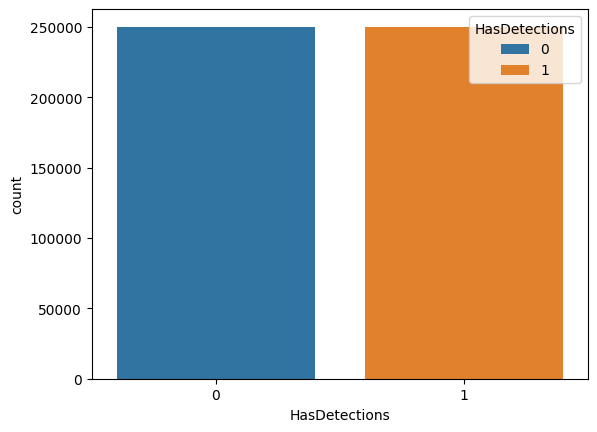

In [20]:
sns.countplot(data=df_origin,x=TARGET,hue=TARGET);

# 3.- Estudio Univariable

#### 3.0.- ProductName

Atributo Categórico
El atributo 'ProductName' tiene 0 valores nulos (0.0%)

Descripción estadístiica:

count           500000
unique               3
top       win8defender
freq            494604
Name: ProductName, dtype: object


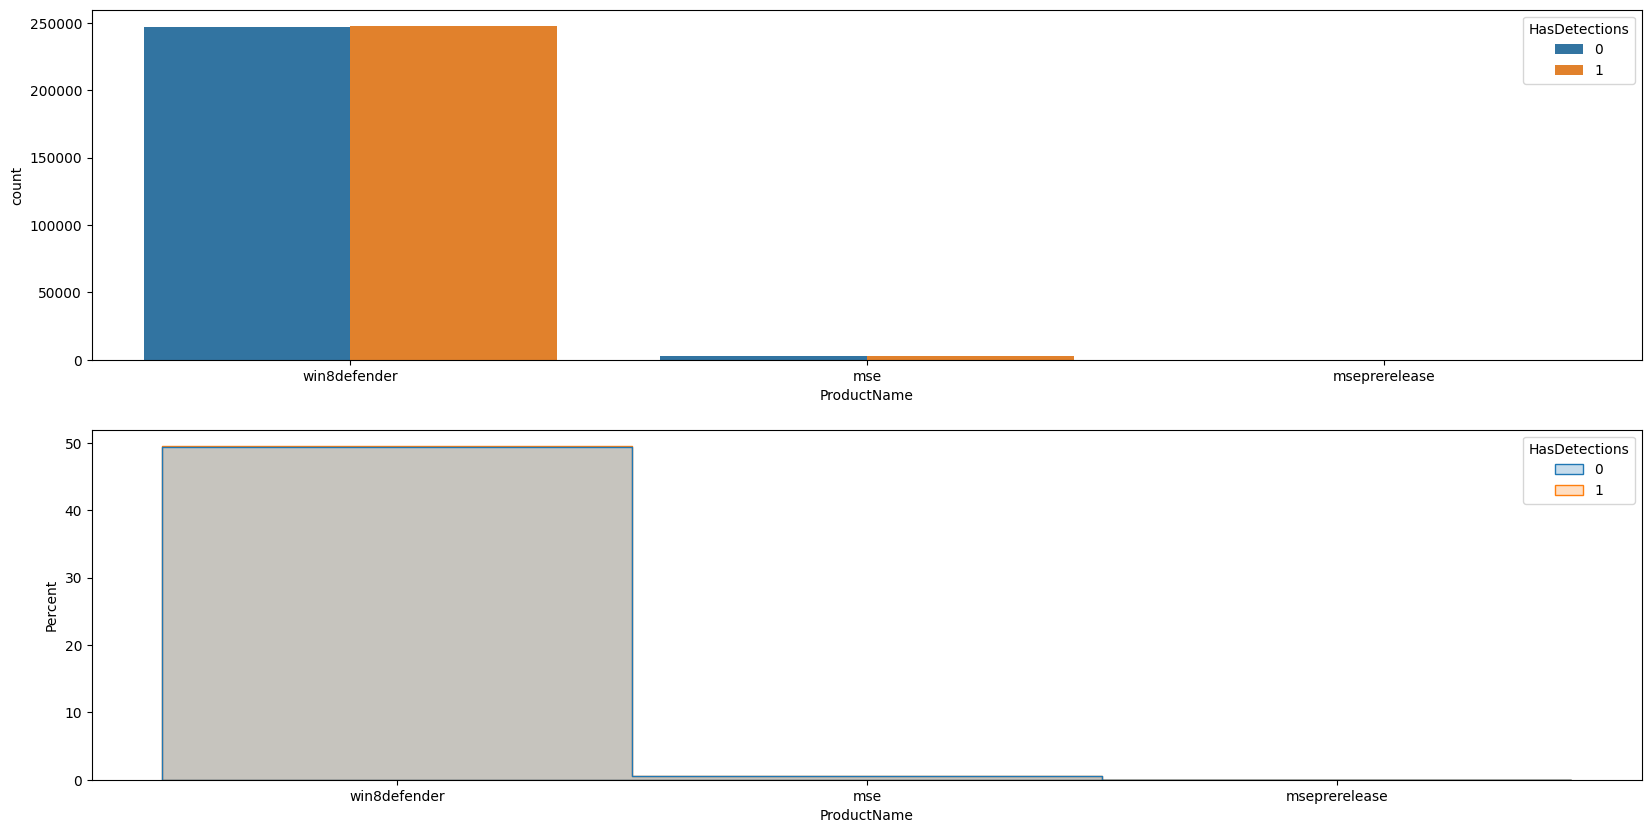

Equipos  Proporcion_Equipos  Infectados  Proporcion_Infectados
ProductName                                                                  
win8defender    494604               98.92      247367                  50.01
mse               5395                1.08        2586                  47.93
mseprerelease        1                0.00           0                   0.00

In [21]:
AnalisisAtributo(df_origin,df_origin.columns[0],tar=TARGET)

#### 3.1.- EngineVersion

Atributo Categórico
El atributo 'EngineVersion' tiene 0 valores nulos (0.0%)

Descripción estadístiica:

count          500000
unique             53
top       1.1.15200.1
freq           216491
Name: EngineVersion, dtype: object


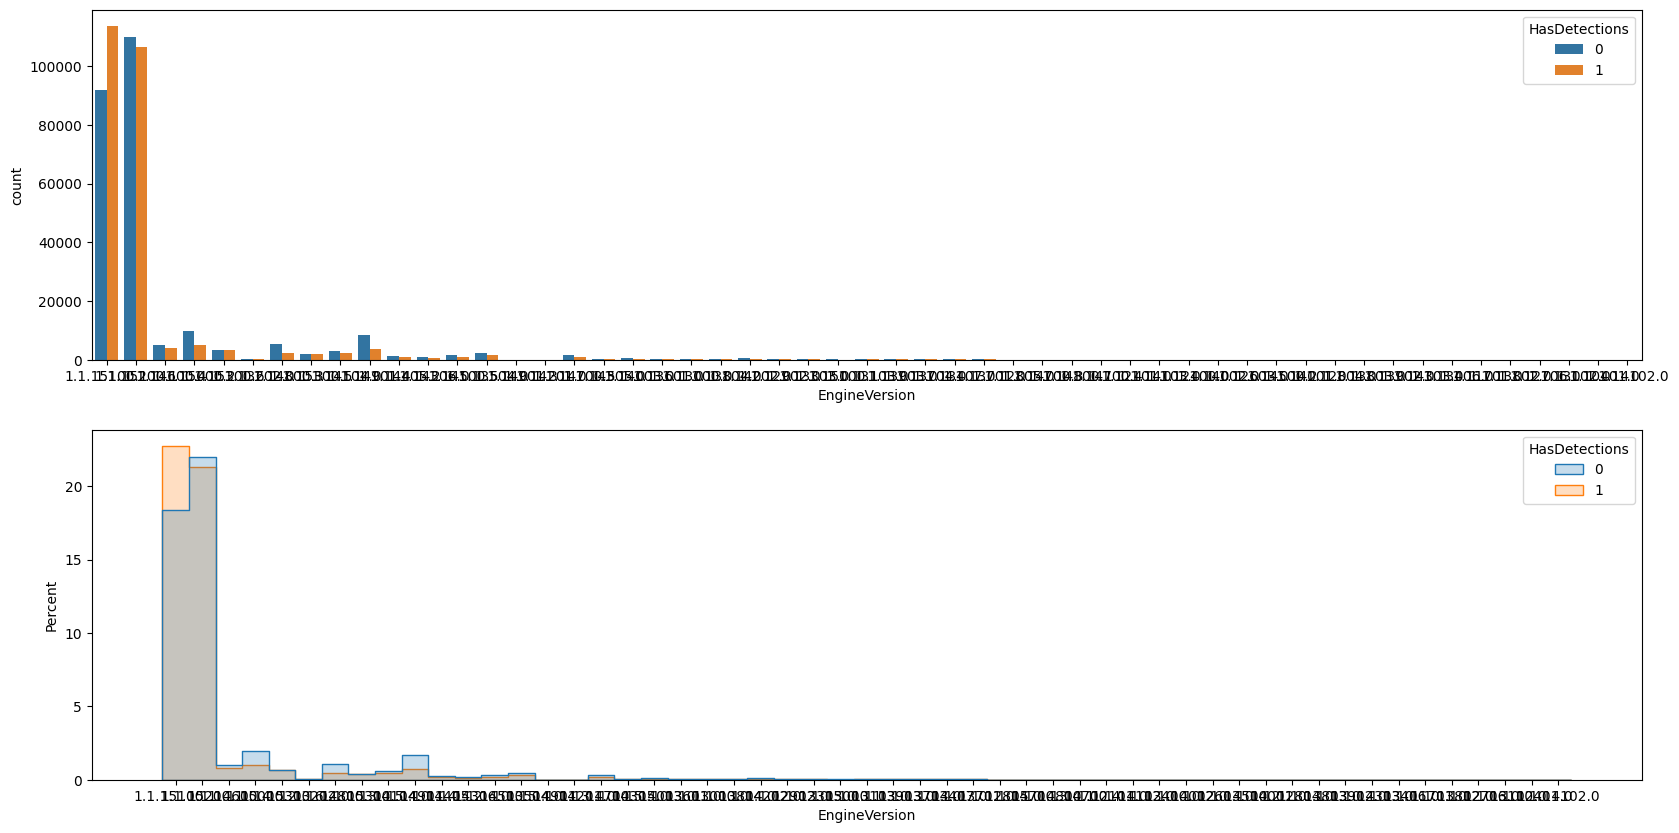

Equipos  Proporcion_Equipos  Infectados  Proporcion_Infectados
EngineVersion                                                                
1.1.15200.1     216491               43.30      106453                  49.17
1.1.15100.1     205494               41.10      113557                  55.26
1.1.15000.2      14752                2.95        5041                  34.17
1.1.14901.4      11984                2.40        3670                  30.62
1.1.14600.4       9005                1.80        3986                  44.26
...                ...                 ...         ...                    ...
1.1.13406.0          1                0.00           1                 100.00
1.1.13102.0          1                0.00           1                 100.00
1.1.12706.0          1                0.00           0                   0.00
1.1.12400.0          1                0.00           1                 100.00
1.1.10401.0          1                0.00           0                   0.00

[53 rows x 4 columns]

In [22]:
AnalisisAtributo(df_origin,df_origin.columns[1],tar=TARGET)

#### 3.2.- AppVersion

Atributo Categórico
El atributo 'AppVersion' tiene 0 valores nulos (0.0%)

Descripción estadístiica:

count              500000
unique                 95
top       4.18.1807.18075
freq               288809
Name: AppVersion, dtype: object


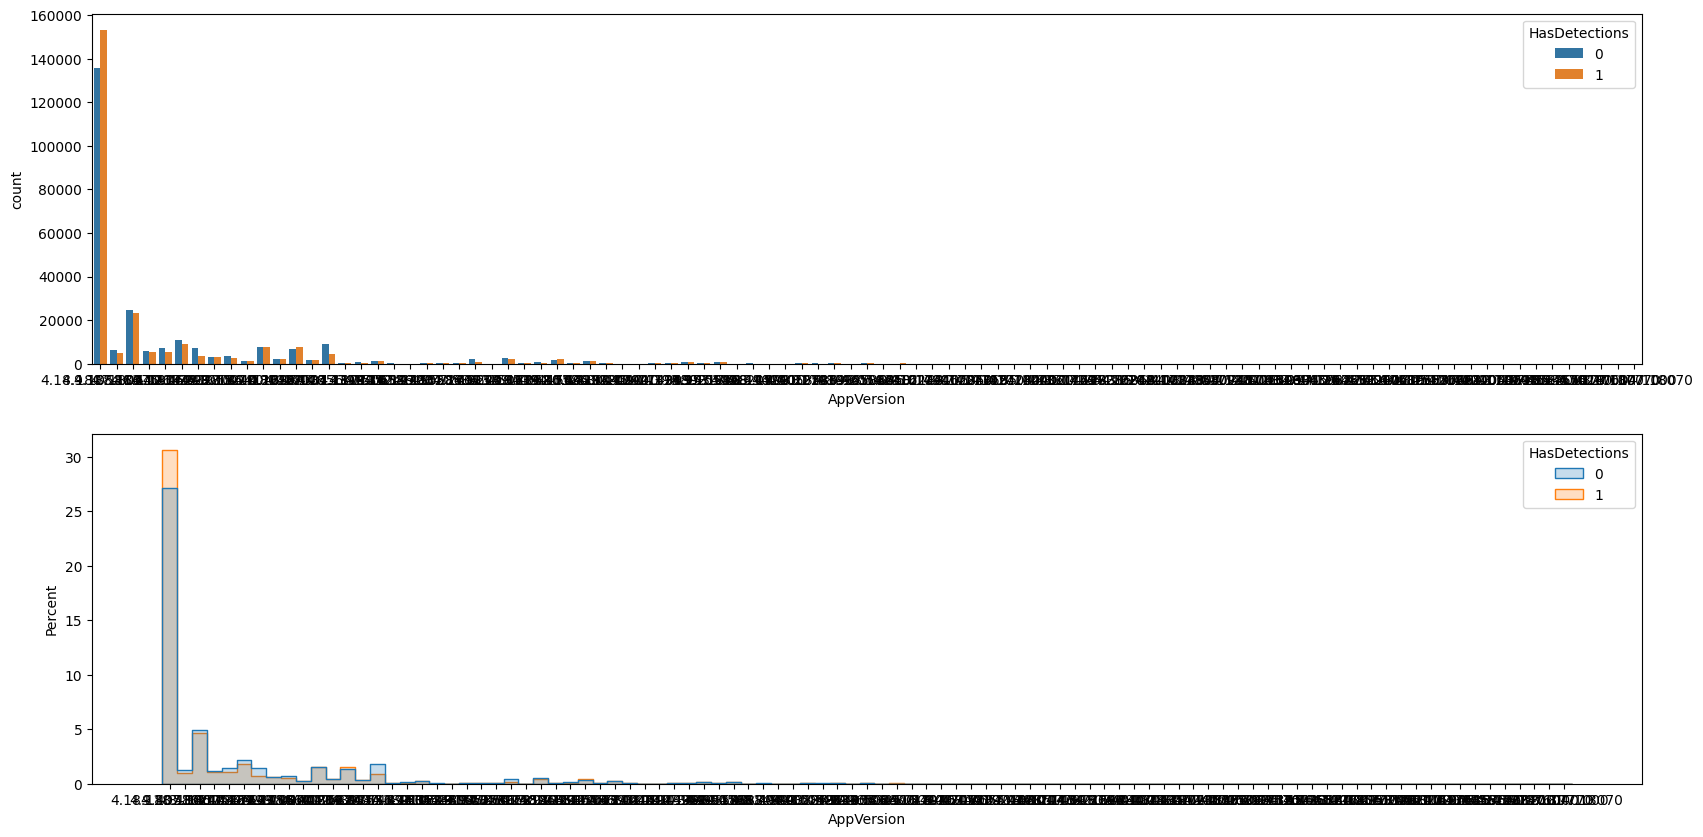

Equipos  Proporcion_Equipos  Infectados  \
AppVersion                                                 
4.18.1807.18075   288809               57.76      152973   
4.18.1806.18062    47641                9.53       23108   
4.12.16299.15      20197                4.04        9207   
4.10.209.0         15292                3.06        7771   
4.13.17134.1       14414                2.88        7579   
...                  ...                 ...         ...   
4.9.10586.456          1                0.00           1   
4.13.17618.1000        1                0.00           1   
4.18.1806.20033        1                0.00           1   
4.13.17639.1000        1                0.00           0   
4.15.17655.1000        1                0.00           0   

                 Proporcion_Infectados  
AppVersion                              
4.18.1807.18075                  52.97  
4.18.1806.18062                  48.50  
4.12.16299.15                    45.59  
4.10.209.0                       50.82  
4.13.17134.1                     52.58  
...                                ...  
4.9.10586.456                   100.00  
4.13.17618.1000                 100.00  
4.18.1806.20033                 100.00  
4.13.17639.1000                   0.00  
4.15.17655.1000                   0.00  

[95 rows x 4 columns]

In [23]:
AnalisisAtributo(df_origin,df_origin.columns[2],tar=TARGET)

#### 3.3.- AvSigVersion

Atributo Categórico
El atributo 'AvSigVersion' tiene 0 valores nulos (0.0%)

Descripción estadístiica:

count           500000
unique            6455
top       1.273.1420.0
freq              5771
Name: AvSigVersion, dtype: object


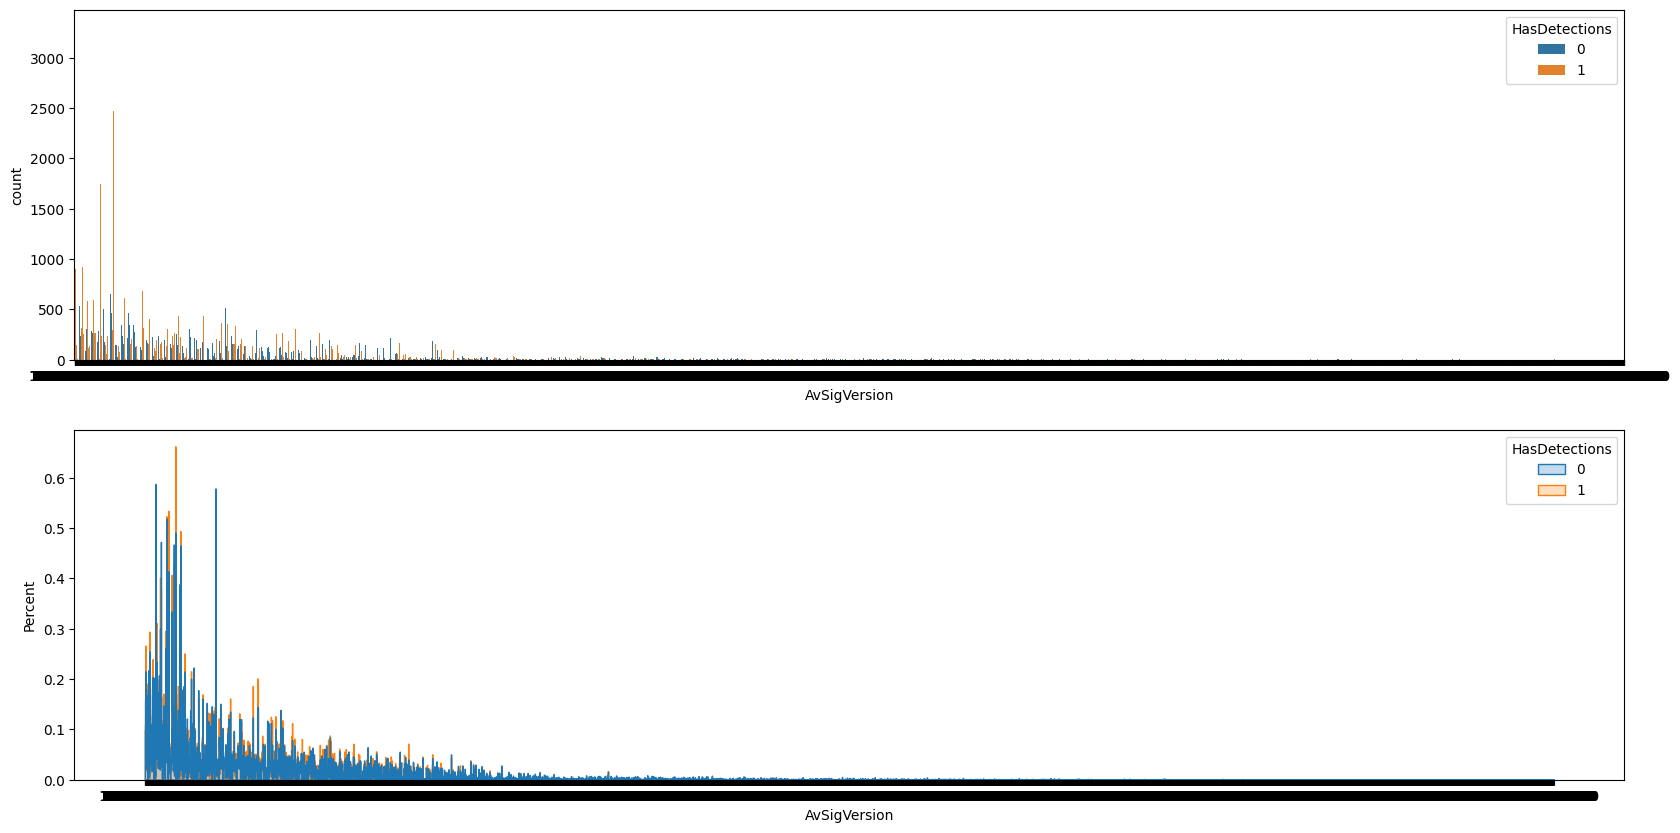

Equipos  Proporcion_Equipos  Infectados  Proporcion_Infectados
AvSigVersion                                                                
1.273.1420.0     5771                1.15        3313                  57.41
1.263.48.0       5537                1.11        2597                  46.90
1.275.1140.0     5317                1.06        2423                  45.57
1.275.727.0      5214                1.04        2619                  50.23
1.273.371.0      4799                0.96        2471                  51.49
...               ...                 ...         ...                    ...
1.257.611.0         1                0.00           1                 100.00
1.235.1530.0        1                0.00           0                   0.00
1.235.1538.0        1                0.00           1                 100.00
1.245.1169.0        1                0.00           1                 100.00
1.233.3763.0        1                0.00           0                   0.00

[6455 rows x 4 columns]

In [24]:
AnalisisAtributo(df_origin,df_origin.columns[3],tar=TARGET)

#### 3.4.- IsBeta

Atributo Numérico
El atributo 'IsBeta' tiene 0 valores nulos (0.0%)

Descripción estadístiica:
count   500,000.00
mean          0.00
std           0.00
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           1.00
Name: IsBeta, dtype: float64

El atributo tiene 2 valores únicos

TOP 10 porcentaje de valores únicos:
IsBeta
0   100.00
1     0.00
Name: proportion, dtype: float64


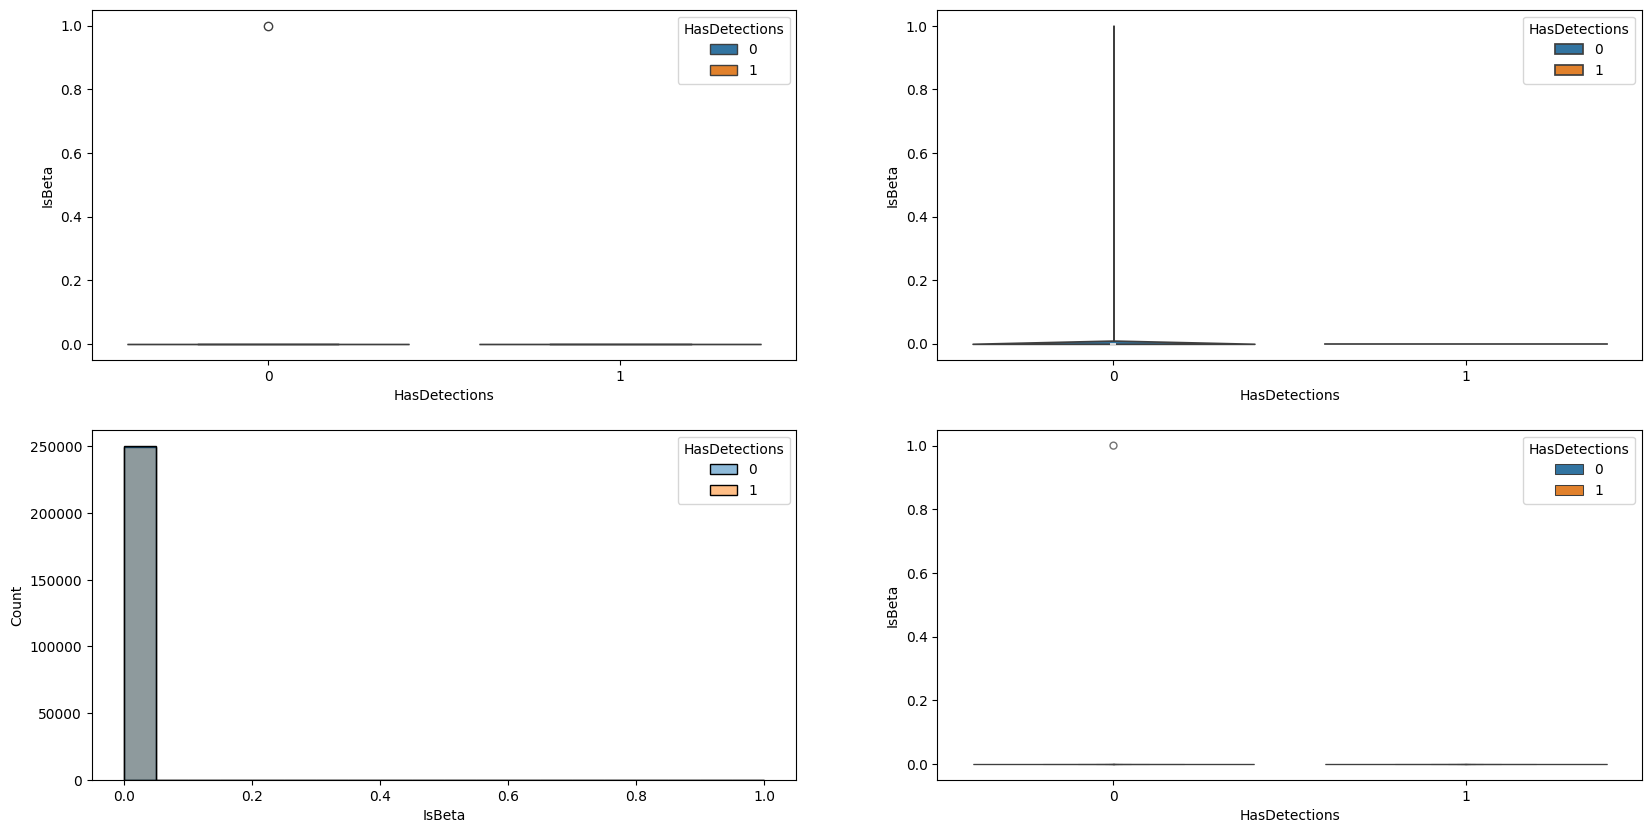

In [25]:
AnalisisAtributo(df_origin,df_origin.columns[4],tar=TARGET)

#### 3.5.- RtpStateBitfield

Atributo Numérico
El atributo 'RtpStateBitfield' tiene 1832 valores nulos (0.37%)

Descripción estadístiica:
count   498,168.00
mean          6.85
std           1.02
min           0.00
25%           7.00
50%           7.00
75%           7.00
max          35.00
Name: RtpStateBitfield, dtype: float64

El atributo tiene 7 valores únicos

TOP 10 porcentaje de valores únicos:
RtpStateBitfield
7.00    96.97
0.00     2.12
NaN      0.37
8.00     0.26
5.00     0.23
3.00     0.04
1.00     0.02
35.00    0.00
Name: proportion, dtype: float64


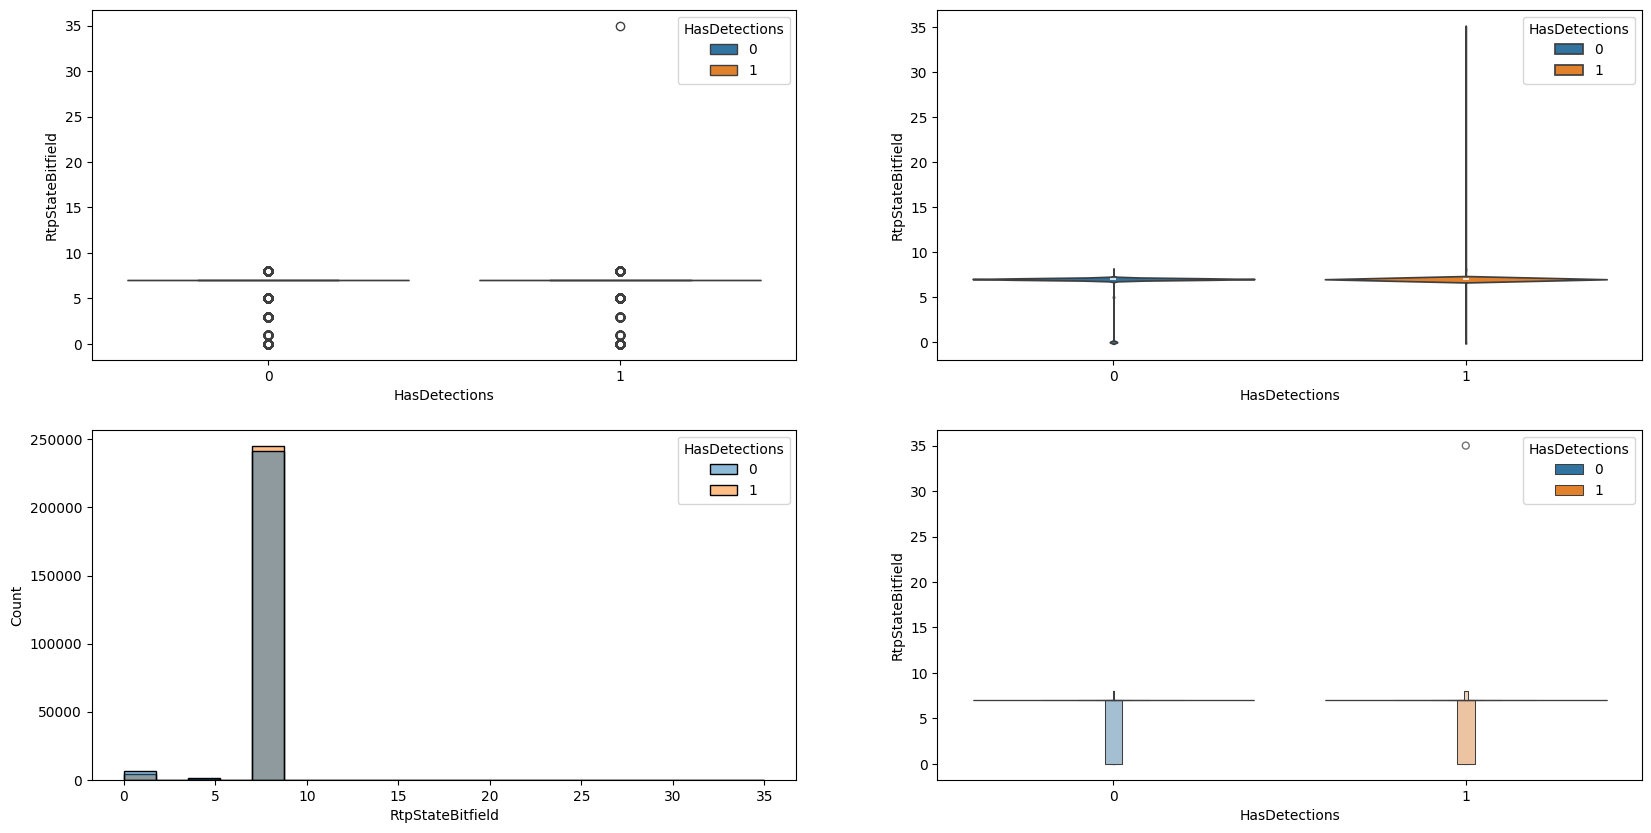

In [26]:
AnalisisAtributo(df_origin,df_origin.columns[5],tar=TARGET)

#### 3.6.- IsSxsPassiveMode

Atributo Numérico
El atributo 'IsSxsPassiveMode' tiene 0 valores nulos (0.0%)

Descripción estadístiica:
count   500,000.00
mean          0.02
std           0.13
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           1.00
Name: IsSxsPassiveMode, dtype: float64

El atributo tiene 2 valores únicos

TOP 10 porcentaje de valores únicos:
IsSxsPassiveMode
0   98.28
1    1.72
Name: proportion, dtype: float64


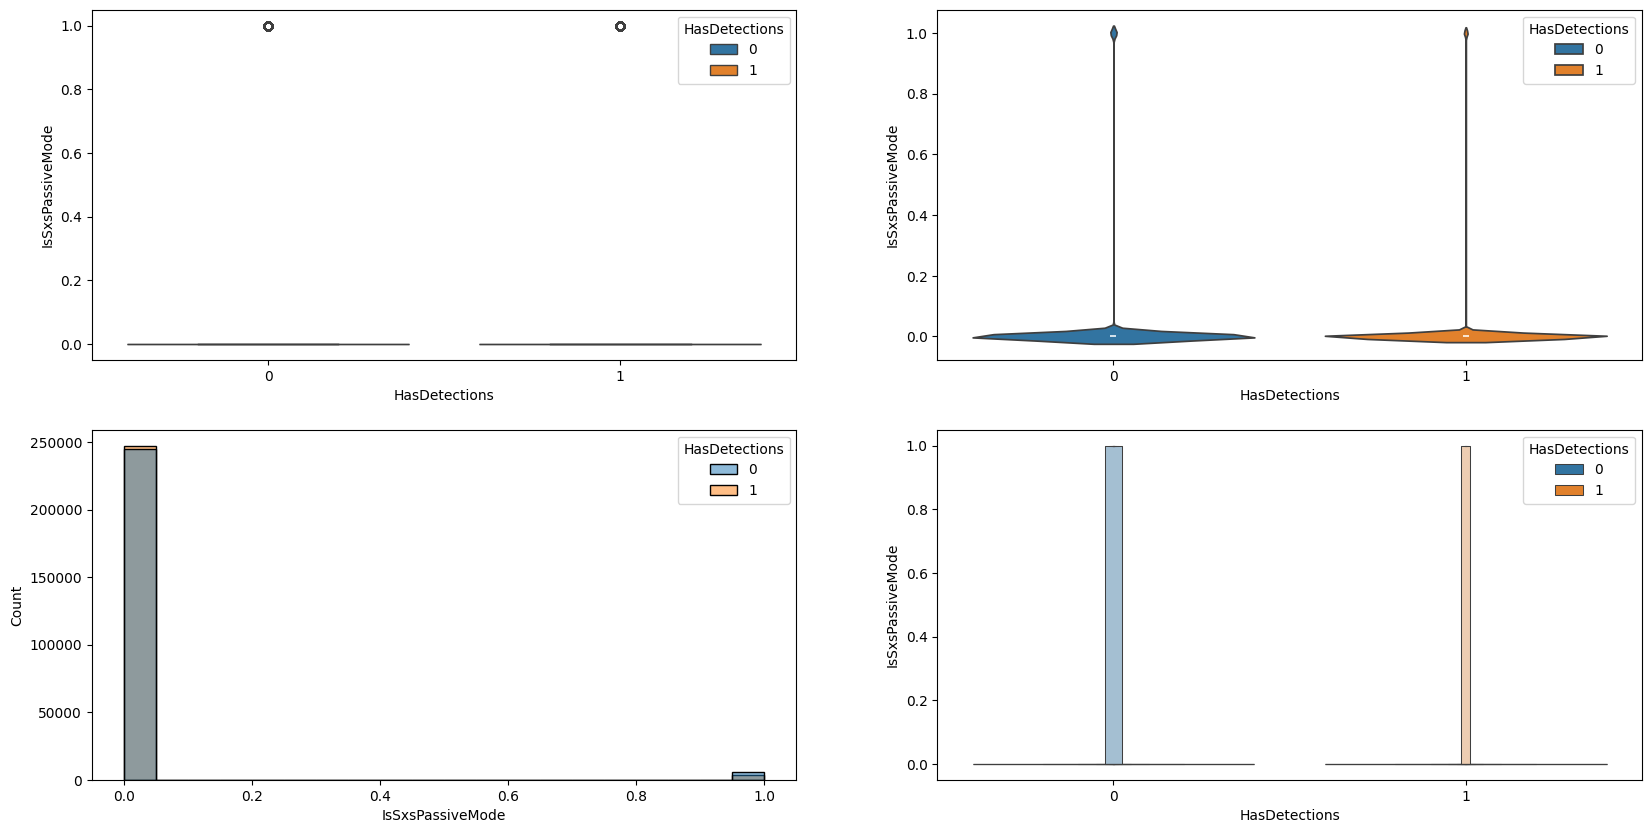

In [27]:
AnalisisAtributo(df_origin,df_origin.columns[6],tar=TARGET)

#### 3.7.- DefaultBrowsersIdentifier

Atributo Numérico
El atributo 'DefaultBrowsersIdentifier' tiene 475939 valores nulos (95.19%)

Descripción estadístiica:
count   24,061.00
mean     1,652.82
std      1,004.75
min          1.00
25%        788.00
50%      1,632.00
75%      2,381.00
max      3,209.00
Name: DefaultBrowsersIdentifier, dtype: float64

El atributo tiene 554 valores únicos

TOP 10 porcentaje de valores únicos:
DefaultBrowsersIdentifier
NaN        95.19
239.00      0.52
3,195.00    0.48
1,632.00    0.32
3,176.00    0.26
146.00      0.25
1,910.00    0.21
1,727.00    0.19
2,064.00    0.15
2,725.00    0.14
Name: proportion, dtype: float64


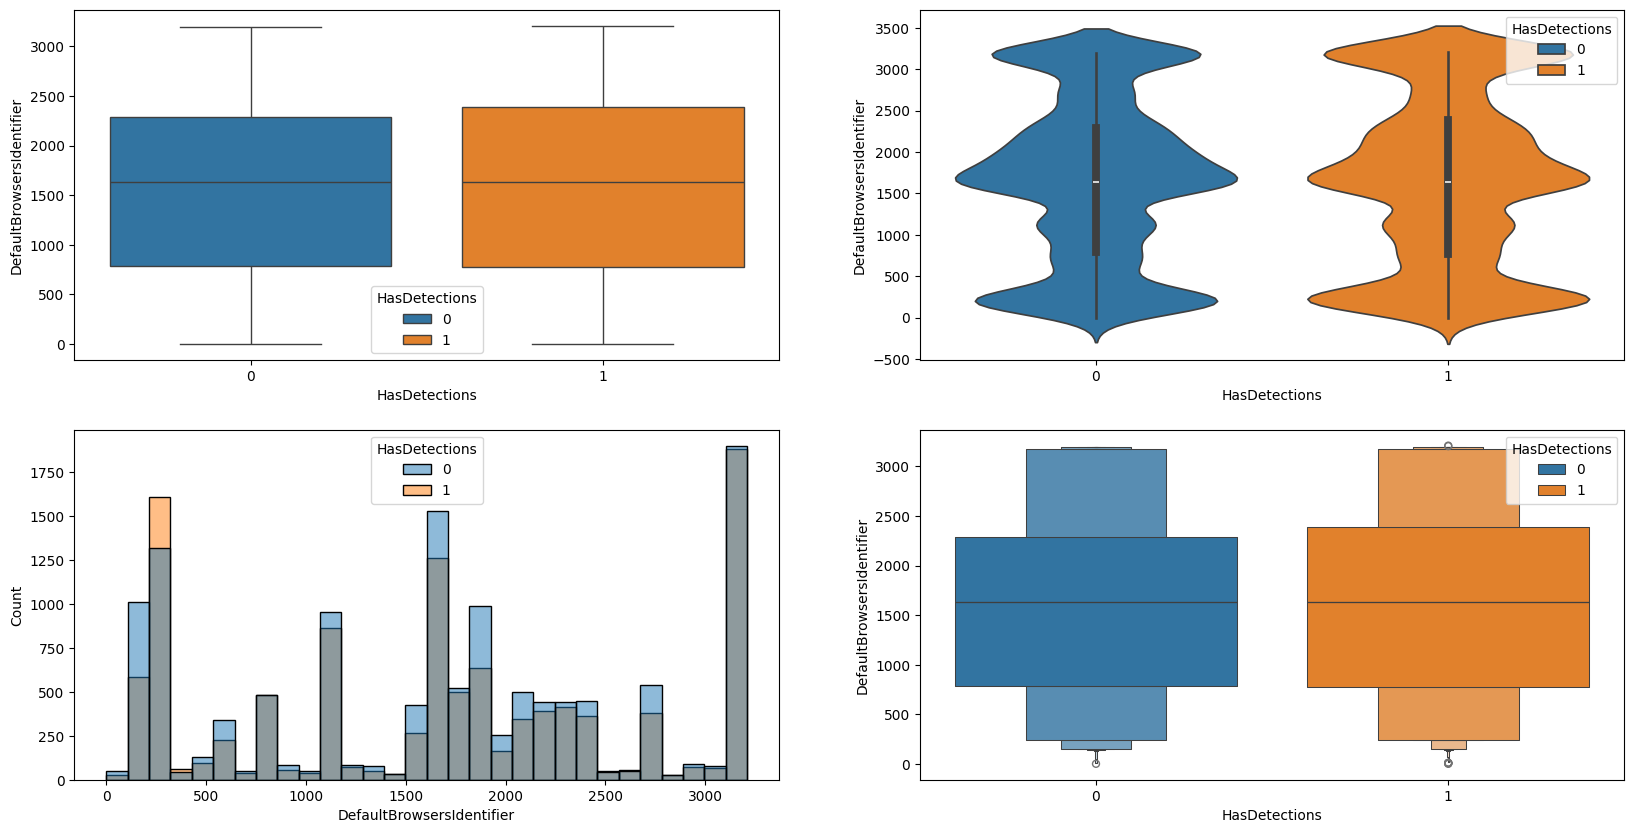

In [28]:
AnalisisAtributo(df_origin,df_origin.columns[7],tar=TARGET)

#### 3.8.- AVProductStatesIdentifier

Atributo Numérico
El atributo 'AVProductStatesIdentifier' tiene 1938 valores nulos (0.39%)

Descripción estadístiica:
count   498,062.00
mean     47,850.91
std      14,023.09
min           3.00
25%      49,480.00
50%      53,447.00
75%      53,447.00
max      70,492.00
Name: AVProductStatesIdentifier, dtype: float64

El atributo tiene 5516 valores únicos

TOP 10 porcentaje de valores únicos:
AVProductStatesIdentifier
53,447.00   65.29
7,945.00     5.33
47,238.00    3.69
62,773.00    2.99
46,413.00    1.27
23,657.00    1.14
49,480.00    1.14
41,571.00    1.09
29,199.00    0.83
51,954.00    0.74
Name: proportion, dtype: float64


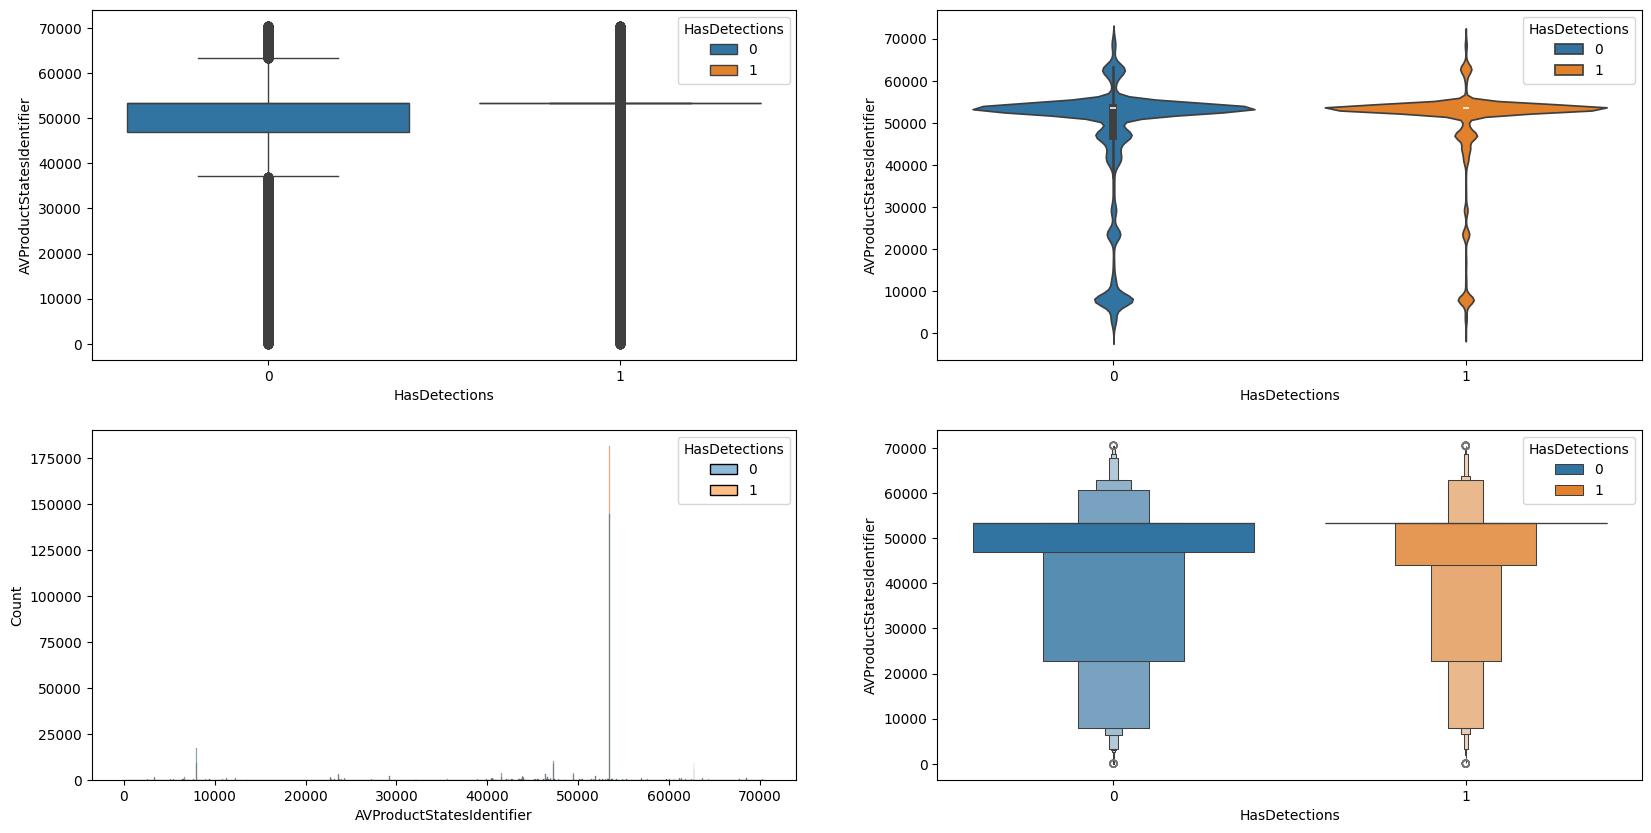

In [29]:
AnalisisAtributo(df_origin,df_origin.columns[8],tar=TARGET)

#### 3.9.- AVProductsInstalled

Atributo Numérico
El atributo 'AVProductsInstalled' tiene 1938 valores nulos (0.39%)

Descripción estadístiica:
count   498,062.00
mean          1.33
std           0.52
min           1.00
25%           1.00
50%           1.00
75%           2.00
max           5.00
Name: AVProductsInstalled, dtype: float64

El atributo tiene 5 valores únicos

TOP 10 porcentaje de valores únicos:
AVProductsInstalled
1.00   69.61
2.00   27.57
3.00    2.32
NaN     0.39
4.00    0.10
5.00    0.01
Name: proportion, dtype: float64


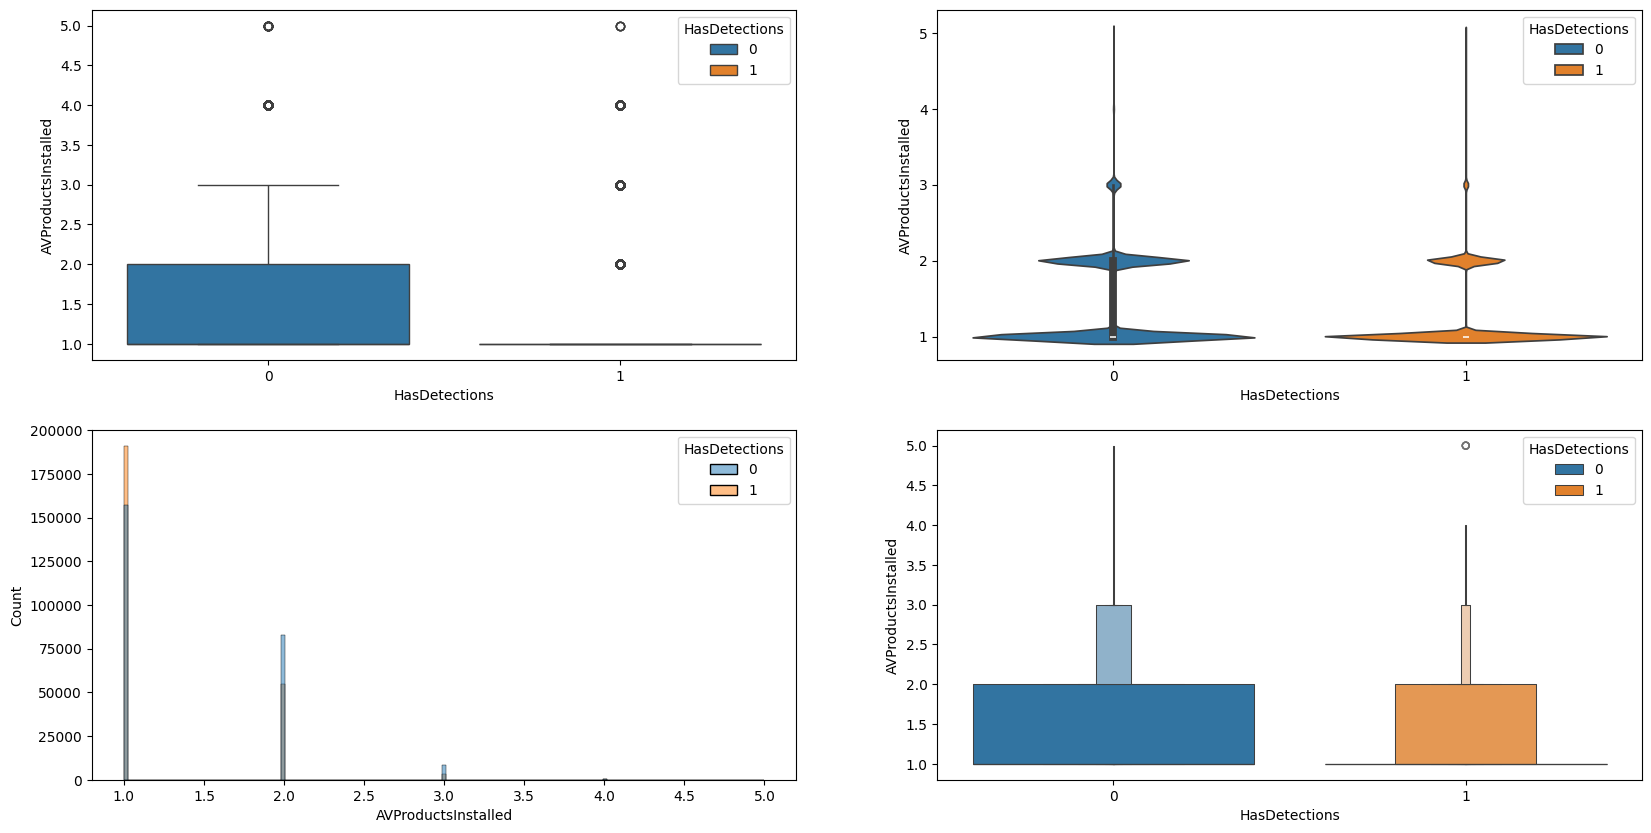

In [30]:
AnalisisAtributo(df_origin,df_origin.columns[9],tar=TARGET)

#### 3.10.- AVProductsEnabled

Atributo Numérico
El atributo 'AVProductsEnabled' tiene 1938 valores nulos (0.39%)

Descripción estadístiica:
count   498,062.00
mean          1.02
std           0.17
min           0.00
25%           1.00
50%           1.00
75%           1.00
max           4.00
Name: AVProductsEnabled, dtype: float64

El atributo tiene 5 valores únicos

TOP 10 porcentaje de valores únicos:
AVProductsEnabled
1.00   97.04
2.00    2.21
NaN     0.39
0.00    0.29
3.00    0.06
4.00    0.01
Name: proportion, dtype: float64


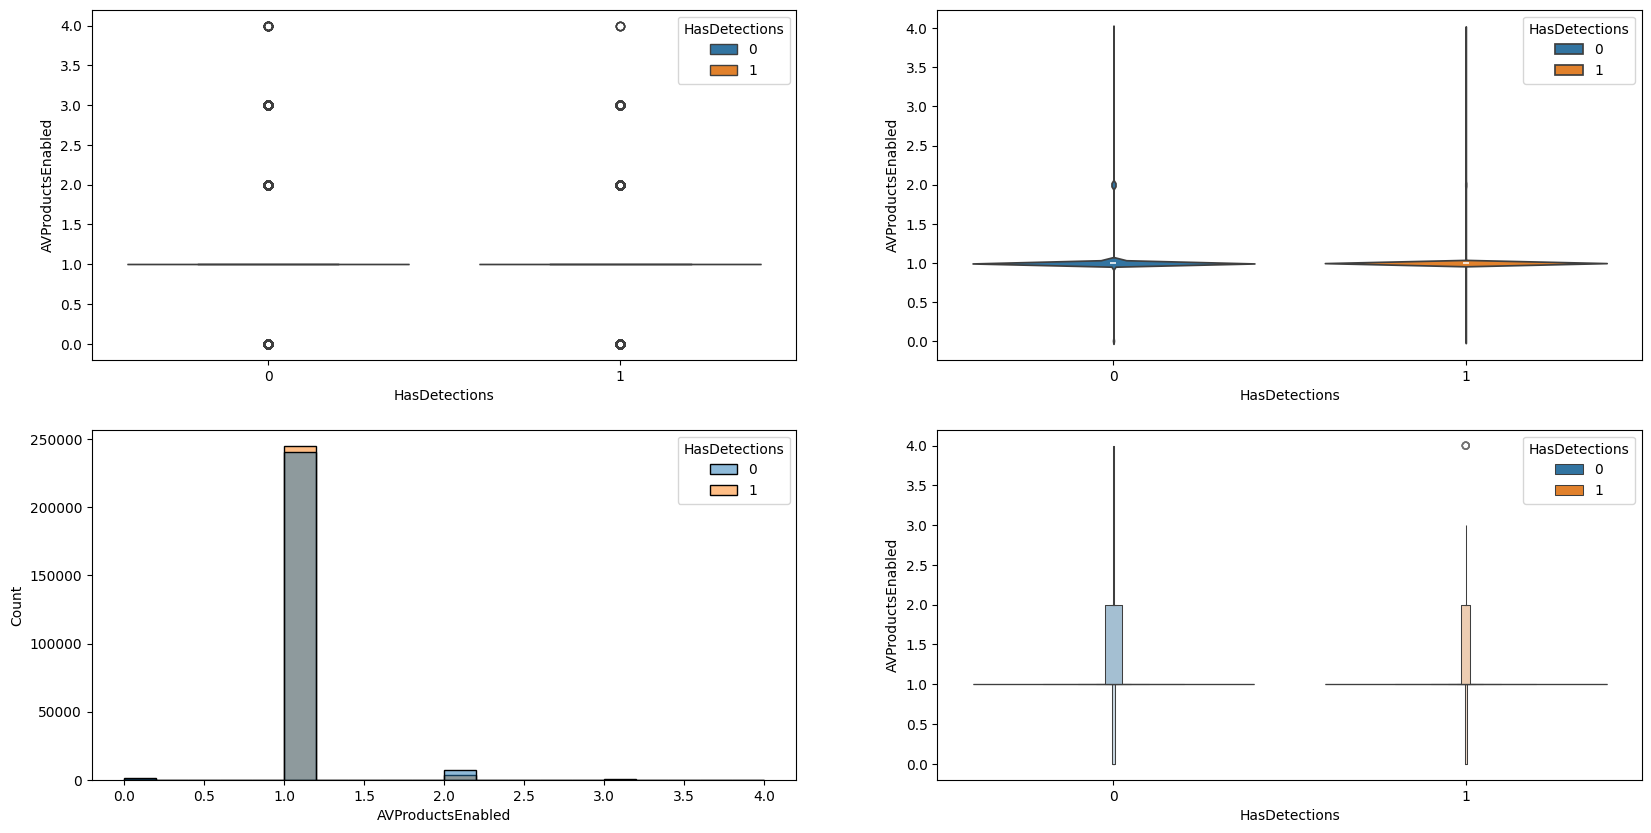

In [31]:
AnalisisAtributo(df_origin,df_origin.columns[10],tar=TARGET)

#### 3.11.- HasTpm

Atributo Numérico
El atributo 'HasTpm' tiene 0 valores nulos (0.0%)

Descripción estadístiica:
count   500,000.00
mean          0.99
std           0.11
min           0.00
25%           1.00
50%           1.00
75%           1.00
max           1.00
Name: HasTpm, dtype: float64

El atributo tiene 2 valores únicos

TOP 10 porcentaje de valores únicos:
HasTpm
1   98.78
0    1.22
Name: proportion, dtype: float64


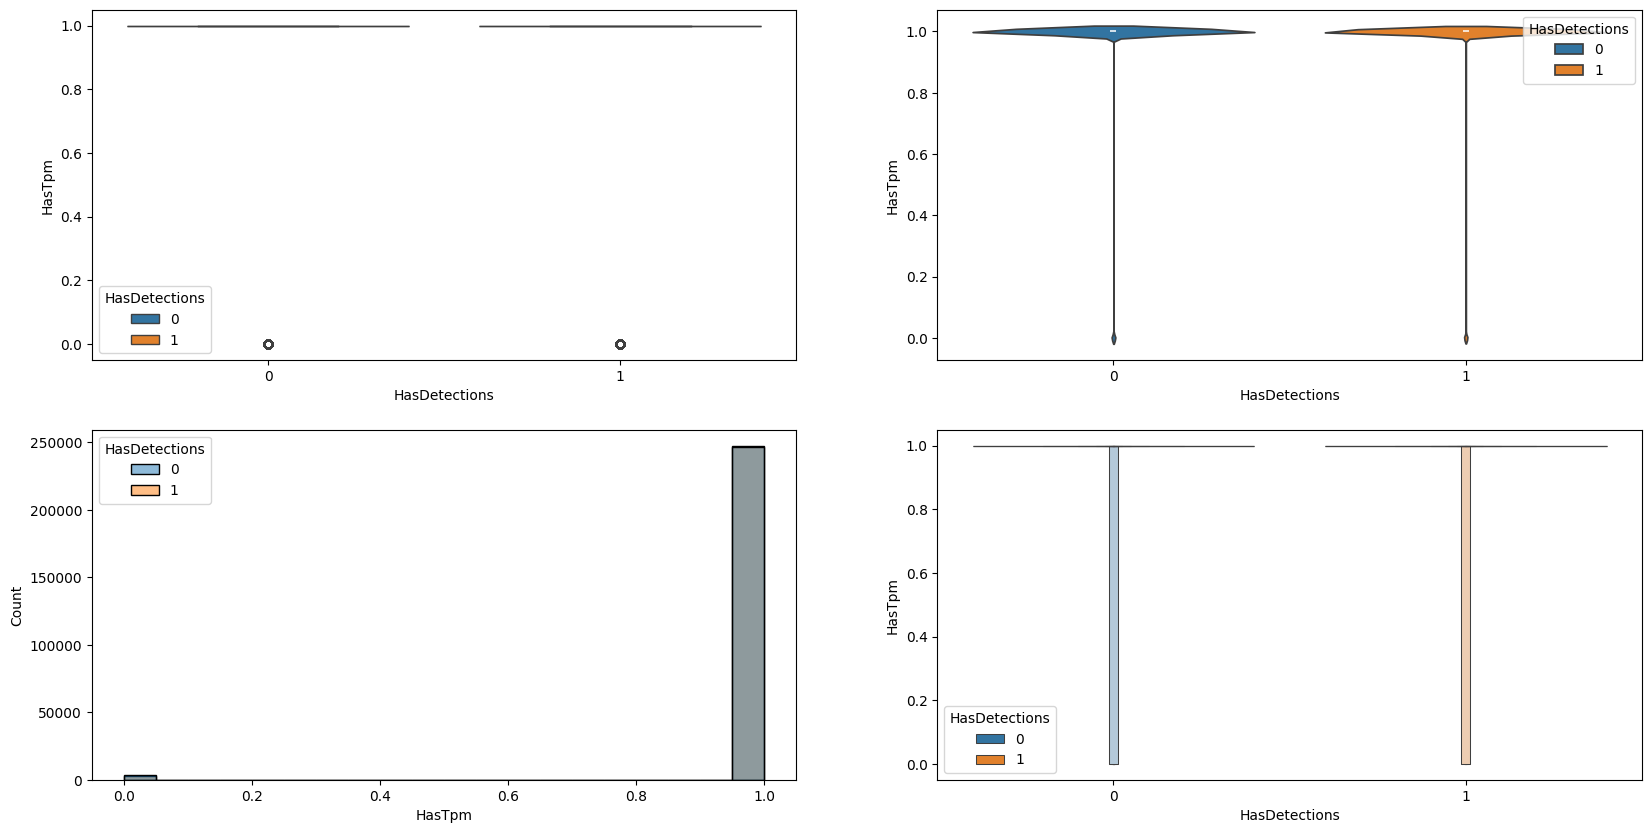

In [32]:
AnalisisAtributo(df_origin,df_origin.columns[11],tar=TARGET)

#### 3.12.- CountryIdentifier

Atributo Numérico
El atributo 'CountryIdentifier' tiene 0 valores nulos (0.0%)

Descripción estadístiica:
count   500,000.00
mean        108.04
std          63.07
min           1.00
25%          51.00
50%          97.00
75%         162.00
max         222.00
Name: CountryIdentifier, dtype: float64

El atributo tiene 222 valores únicos

TOP 10 porcentaje de valores únicos:
CountryIdentifier
43    4.47
29    3.85
141   3.68
93    3.24
171   3.15
60    2.62
201   2.48
207   2.40
66    2.32
89    2.21
Name: proportion, dtype: float64


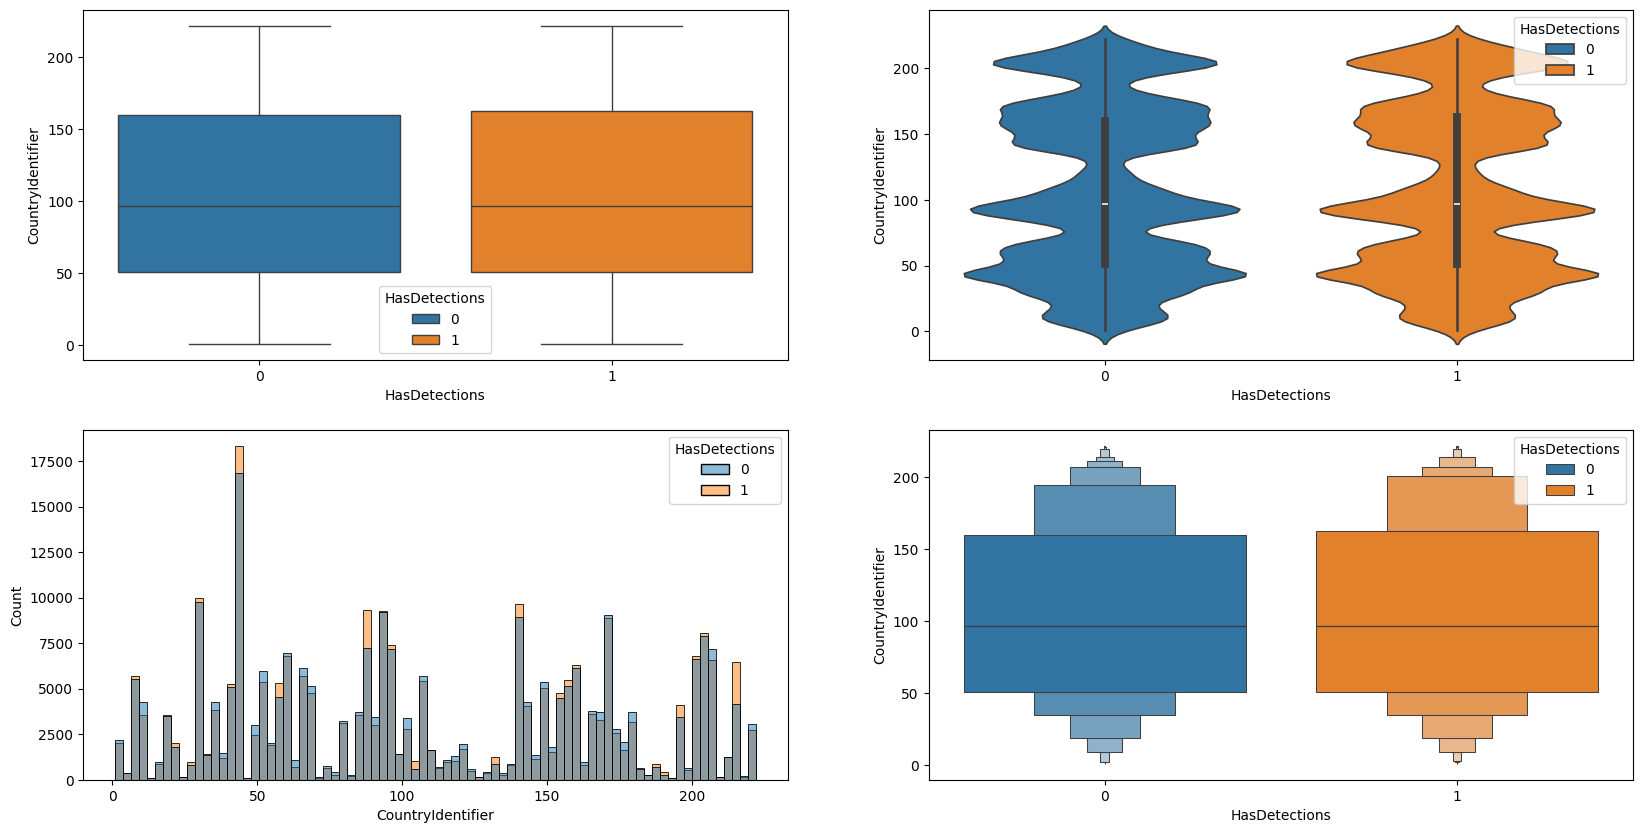

In [33]:
AnalisisAtributo(df_origin,df_origin.columns[12],tar=TARGET)

#### 3.13.- CityIdentifier

Atributo Numérico
El atributo 'CityIdentifier' tiene 18240 valores nulos (3.65%)

Descripción estadístiica:
count   481,760.00
mean     81,271.65
std      48,985.13
min           7.00
25%      36,825.00
50%      82,373.00
75%     123,939.50
max     167,958.00
Name: CityIdentifier, dtype: float64

El atributo tiene 37157 valores únicos

TOP 10 porcentaje de valores únicos:
CityIdentifier
NaN          3.65
130,775.00   1.05
16,668.00    0.95
82,373.00    0.93
10,222.00    0.80
61,668.00    0.74
143,782.00   0.71
66,202.00    0.71
58,607.00    0.67
92,213.00    0.64
Name: proportion, dtype: float64


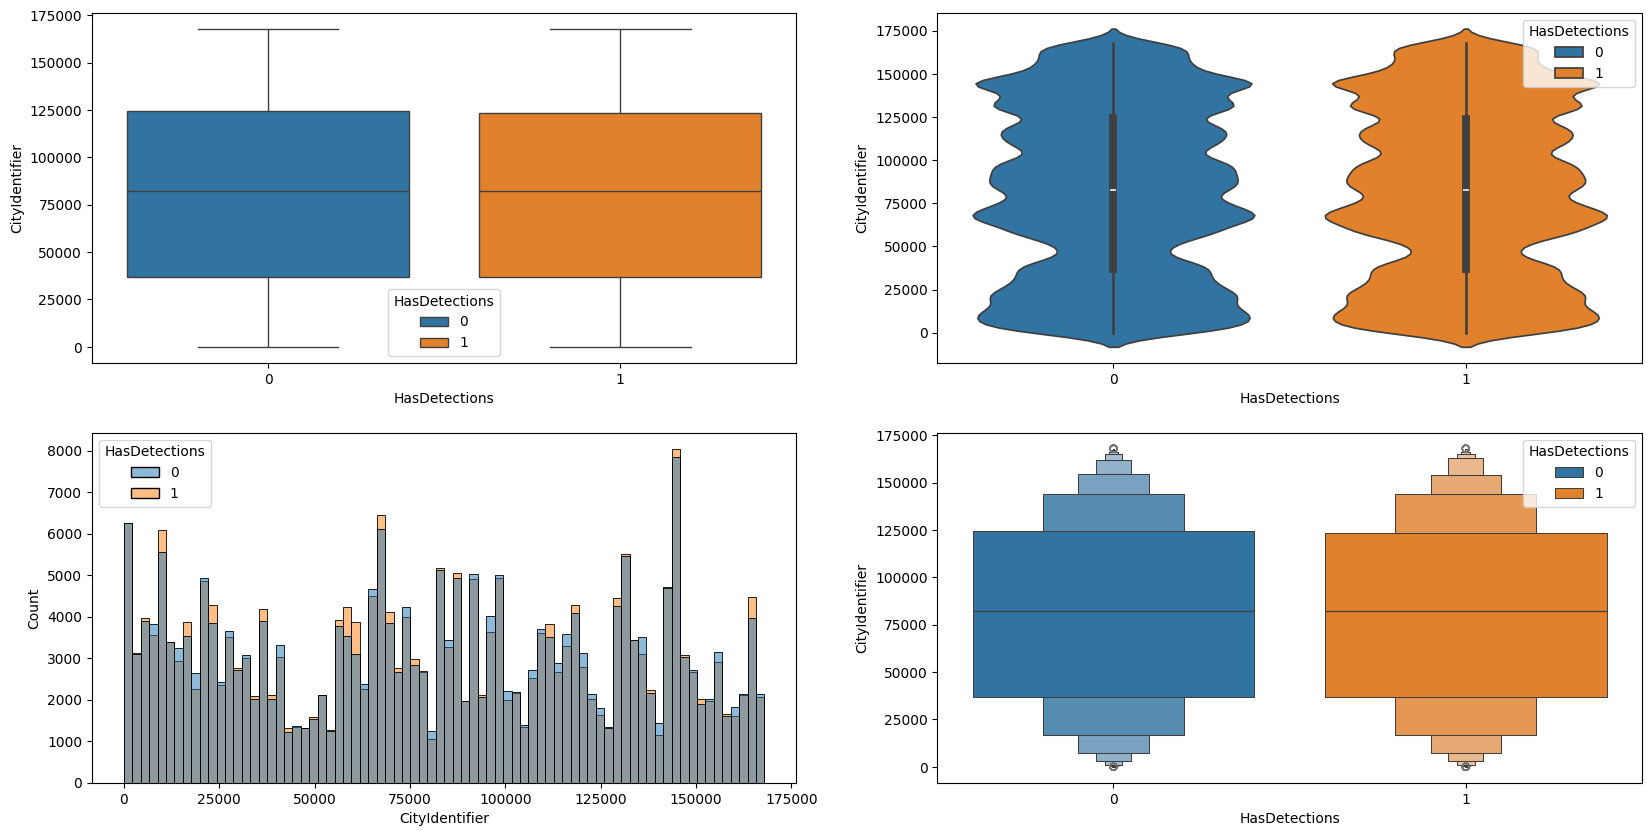

In [34]:
AnalisisAtributo(df_origin,df_origin.columns[13],tar=TARGET)

#### 3.14.- OrganizationIdentifier

Atributo Numérico
El atributo 'OrganizationIdentifier' tiene 154563 valores nulos (30.91%)

Descripción estadístiica:
count   345,437.00
mean         24.87
std           5.61
min           1.00
25%          18.00
50%          27.00
75%          27.00
max          52.00
Name: OrganizationIdentifier, dtype: float64

El atributo tiene 44 valores únicos

TOP 10 porcentaje de valores únicos:
OrganizationIdentifier
27.00   46.98
NaN     30.91
18.00   19.77
48.00    0.73
50.00    0.51
37.00    0.21
11.00    0.21
49.00    0.15
46.00    0.13
14.00    0.05
Name: proportion, dtype: float64


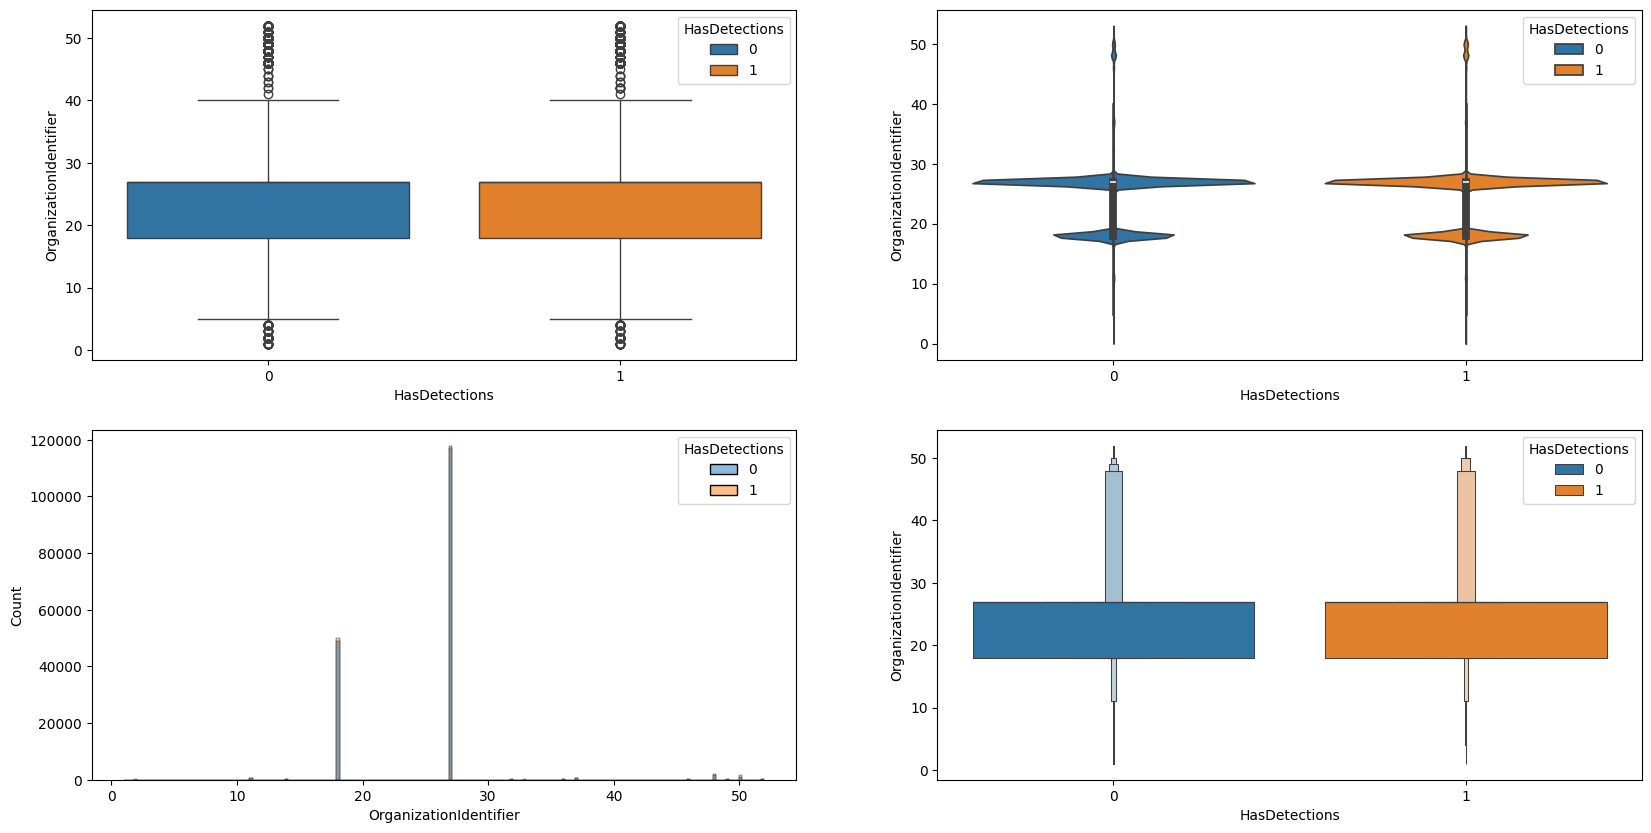

In [35]:
AnalisisAtributo(df_origin,df_origin.columns[14],tar=TARGET)

#### 3.15.- GeoNameIdentifier

Atributo Numérico
El atributo 'GeoNameIdentifier' tiene 16 valores nulos (0.0%)

Descripción estadístiica:
count   499,984.00
mean        169.73
std          89.33
min           1.00
25%          89.00
50%         181.00
75%         267.00
max         296.00
Name: GeoNameIdentifier, dtype: float64

El atributo tiene 268 valores únicos

TOP 10 porcentaje de valores únicos:
GeoNameIdentifier
277.00   17.22
211.00    4.72
53.00     4.60
89.00     4.03
240.00    3.90
35.00     3.83
167.00    3.77
276.00    3.32
267.00    2.42
126.00    2.21
Name: proportion, dtype: float64


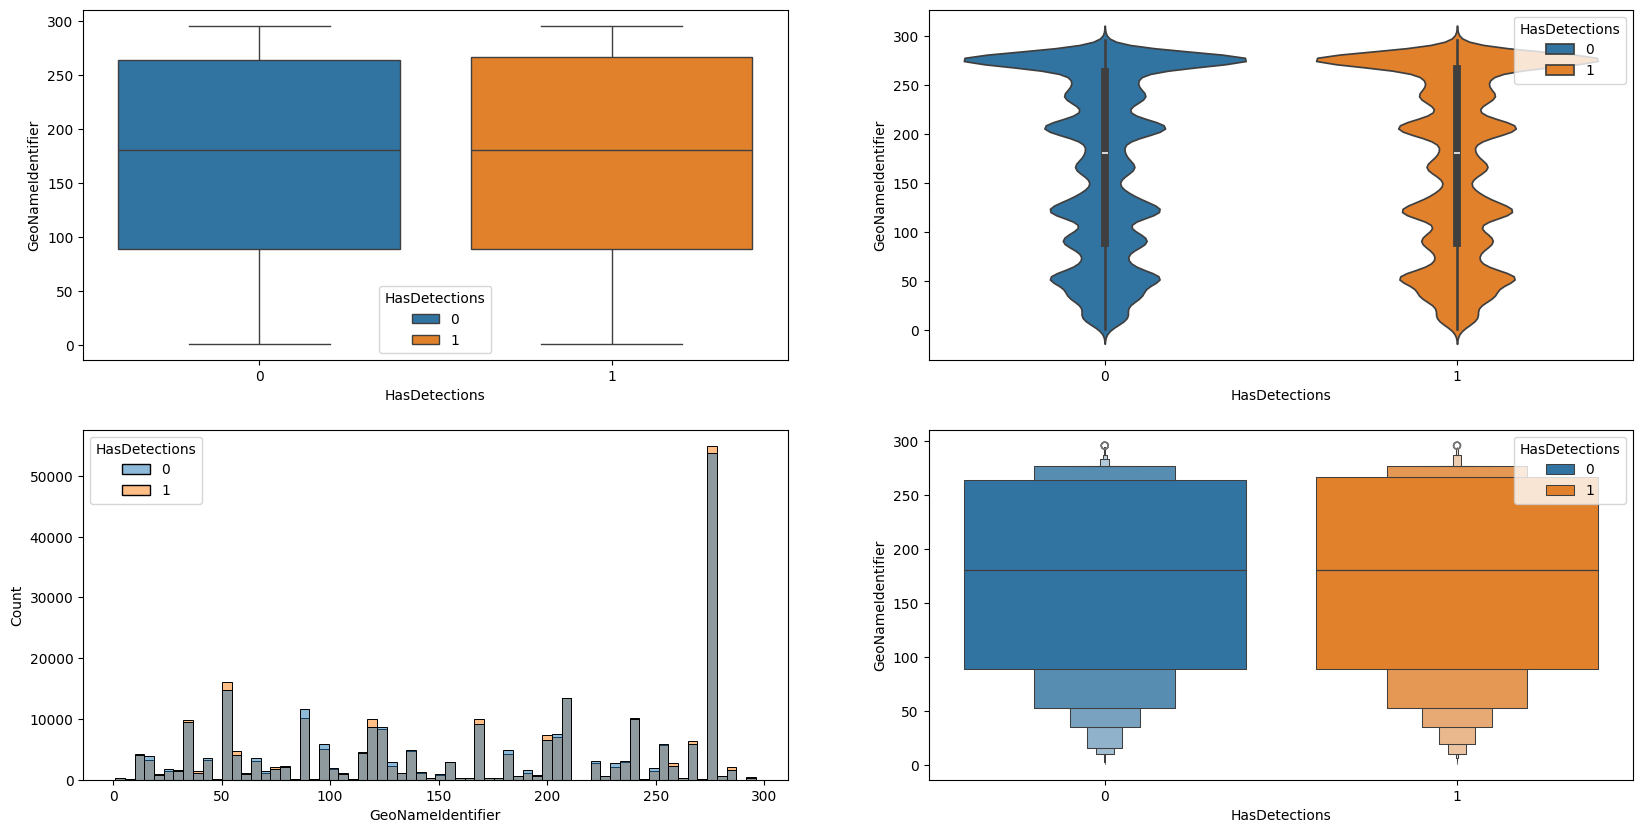

In [36]:
AnalisisAtributo(df_origin,df_origin.columns[15],tar=TARGET)

#### 3.16.- LocaleEnglishNameIdentifier

Atributo Numérico
El atributo 'LocaleEnglishNameIdentifier' tiene 0 valores nulos (0.0%)

Descripción estadístiica:
count   500,000.00
mean        122.61
std          69.30
min           1.00
25%          74.00
50%          88.00
75%         182.00
max         283.00
Name: LocaleEnglishNameIdentifier, dtype: float64

El atributo tiene 233 valores únicos

TOP 10 porcentaje de valores únicos:
LocaleEnglishNameIdentifier
75    23.56
182    5.04
42     4.60
74     4.58
88     4.20
233    3.84
171    3.81
227    3.69
251    2.38
124    2.17
Name: proportion, dtype: float64


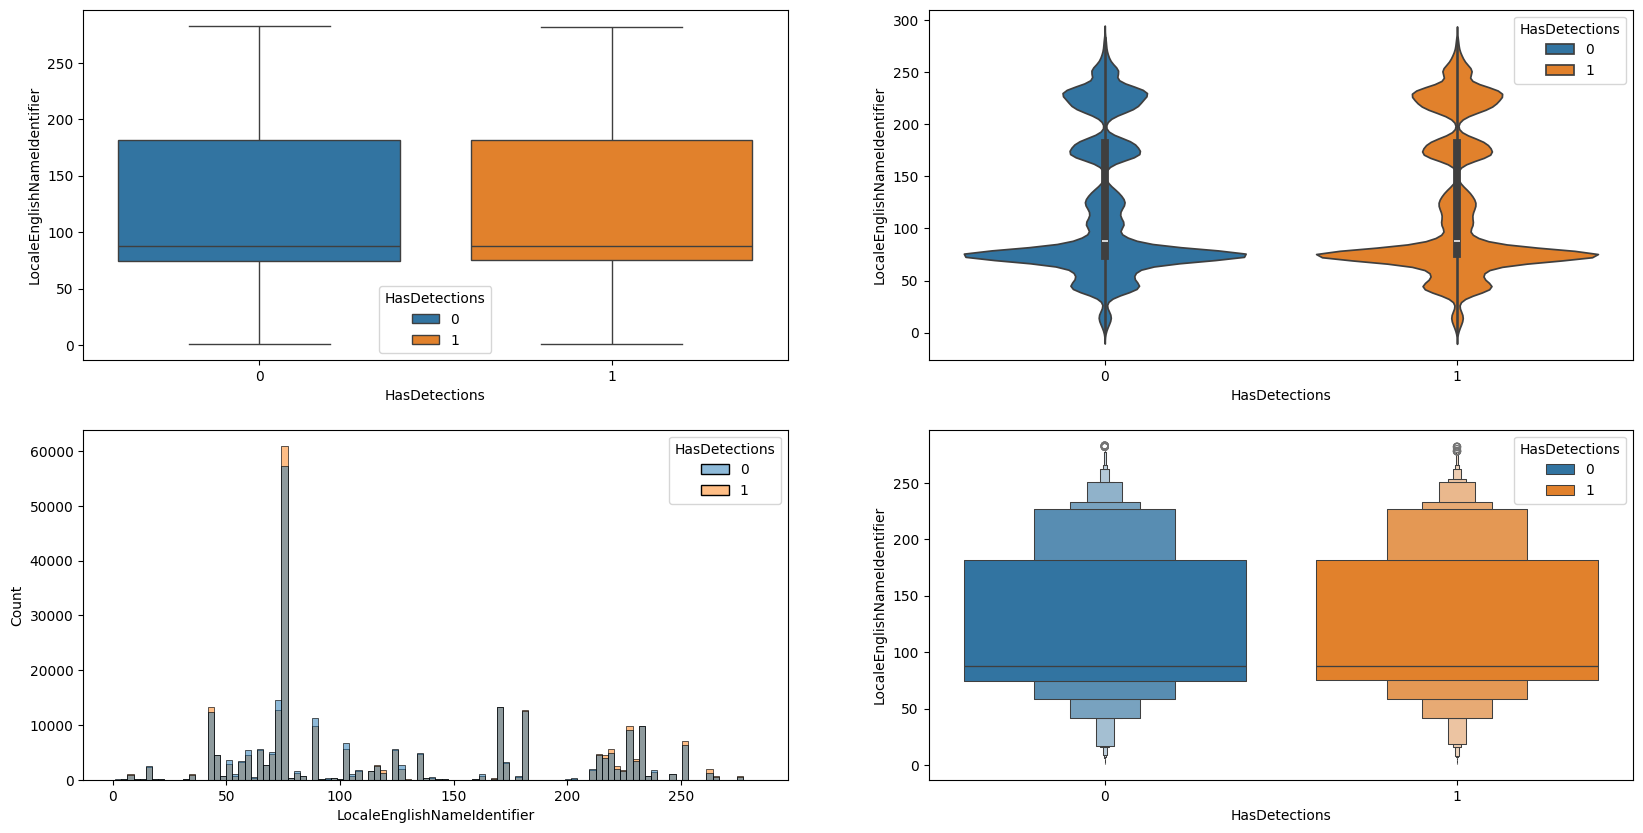

In [37]:
AnalisisAtributo(df_origin,df_origin.columns[16],tar=TARGET)

#### 3.17.- Platform

Atributo Categórico
El atributo 'Platform' tiene 0 valores nulos (0.0%)

Descripción estadístiica:

count        500000
unique            4
top       windows10
freq         483048
Name: Platform, dtype: object


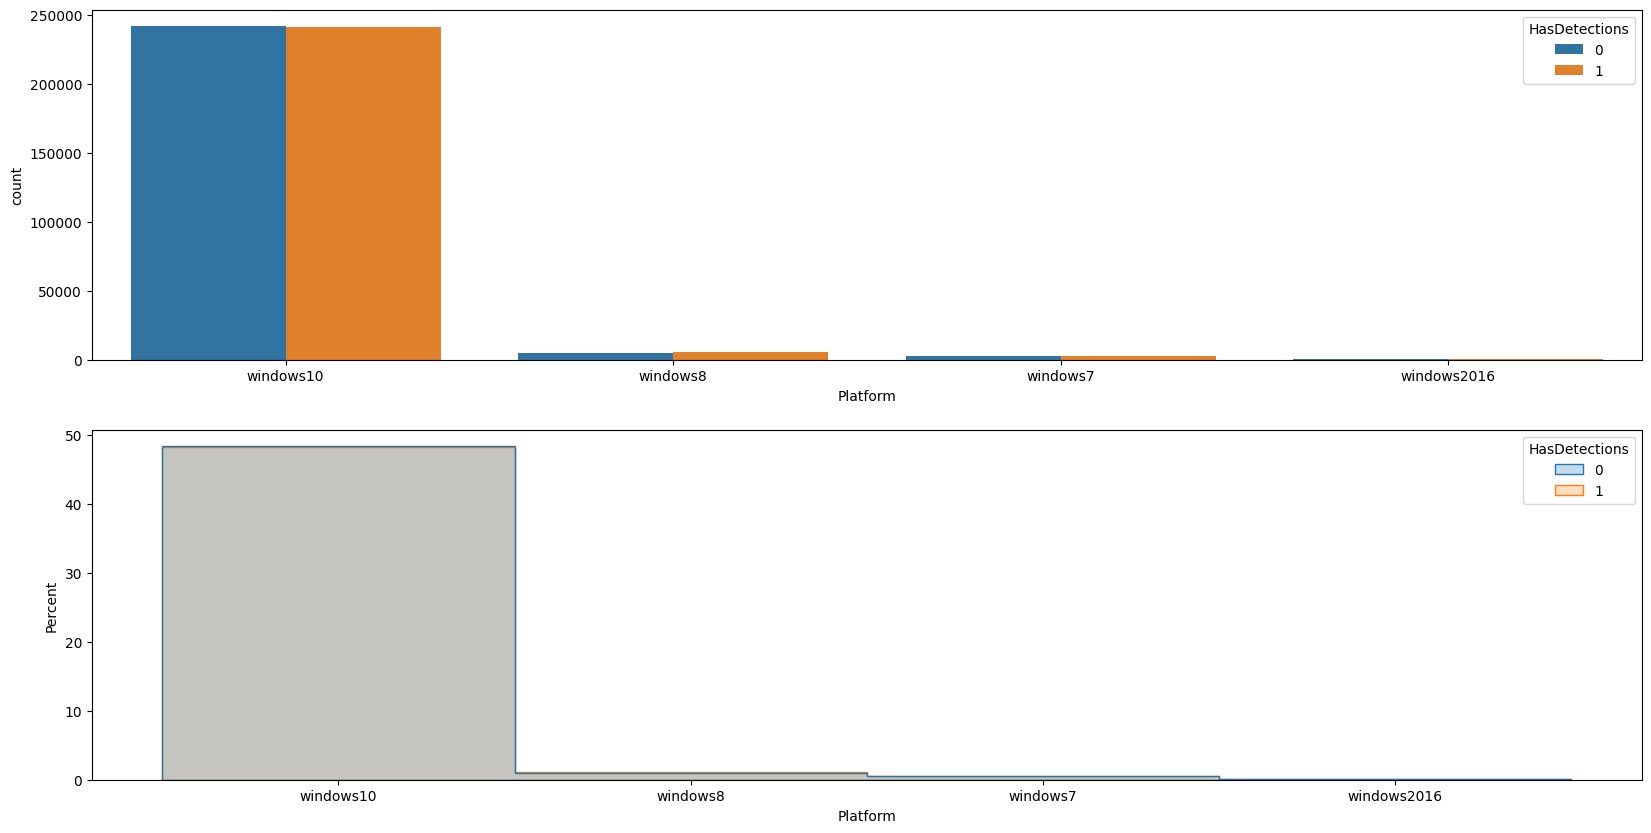

Equipos  Proporcion_Equipos  Infectados  Proporcion_Infectados
Platform                                                                   
windows10     483048               96.61      241476                  49.99
windows8       10825                2.16        5614                  51.86
windows7        5314                1.06        2562                  48.21
windows2016      813                0.16         301                  37.02

In [38]:
AnalisisAtributo(df_origin,df_origin.columns[17],tar=TARGET)

#### 3.18.- Processor

Atributo Categórico
El atributo 'Processor' tiene 0 valores nulos (0.0%)

Descripción estadístiica:

count     500000
unique         3
top          x64
freq      454423
Name: Processor, dtype: object


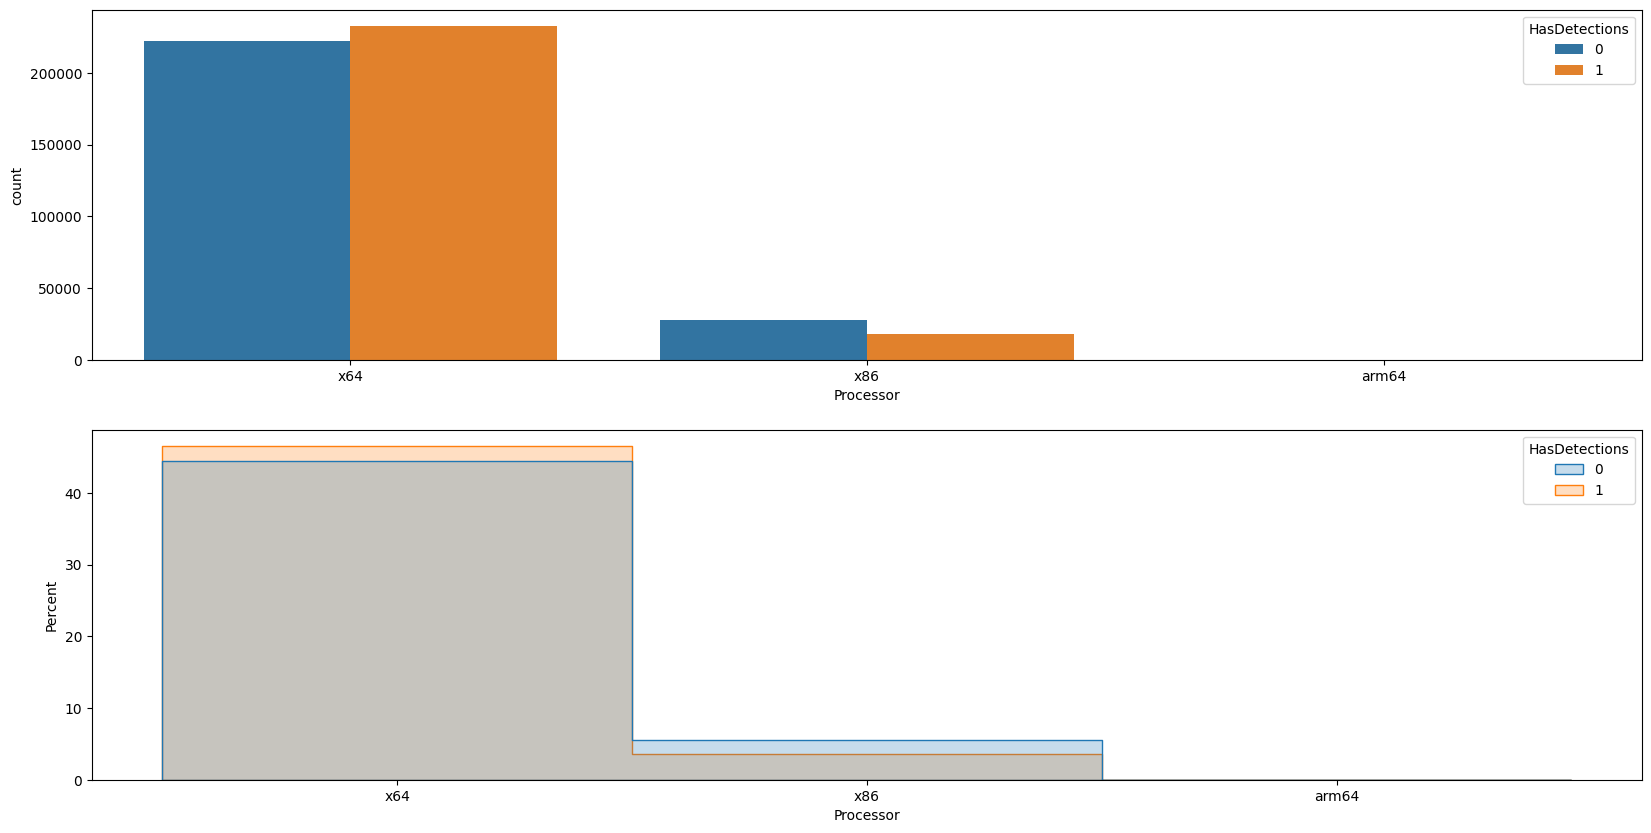

Equipos  Proporcion_Equipos  Infectados  Proporcion_Infectados
Processor                                                                
x64         454423               90.88      232321                  51.12
x86          45563                9.11       17632                  38.70
arm64           14                0.00           0                   0.00

In [39]:
AnalisisAtributo(df_origin,df_origin.columns[18],tar=TARGET)

#### 3.19.- OsVer

Atributo Categórico
El atributo 'OsVer' tiene 0 valores nulos (0.0%)

Descripción estadístiica:

count       500000
unique          21
top       10.0.0.0
freq        483830
Name: OsVer, dtype: object


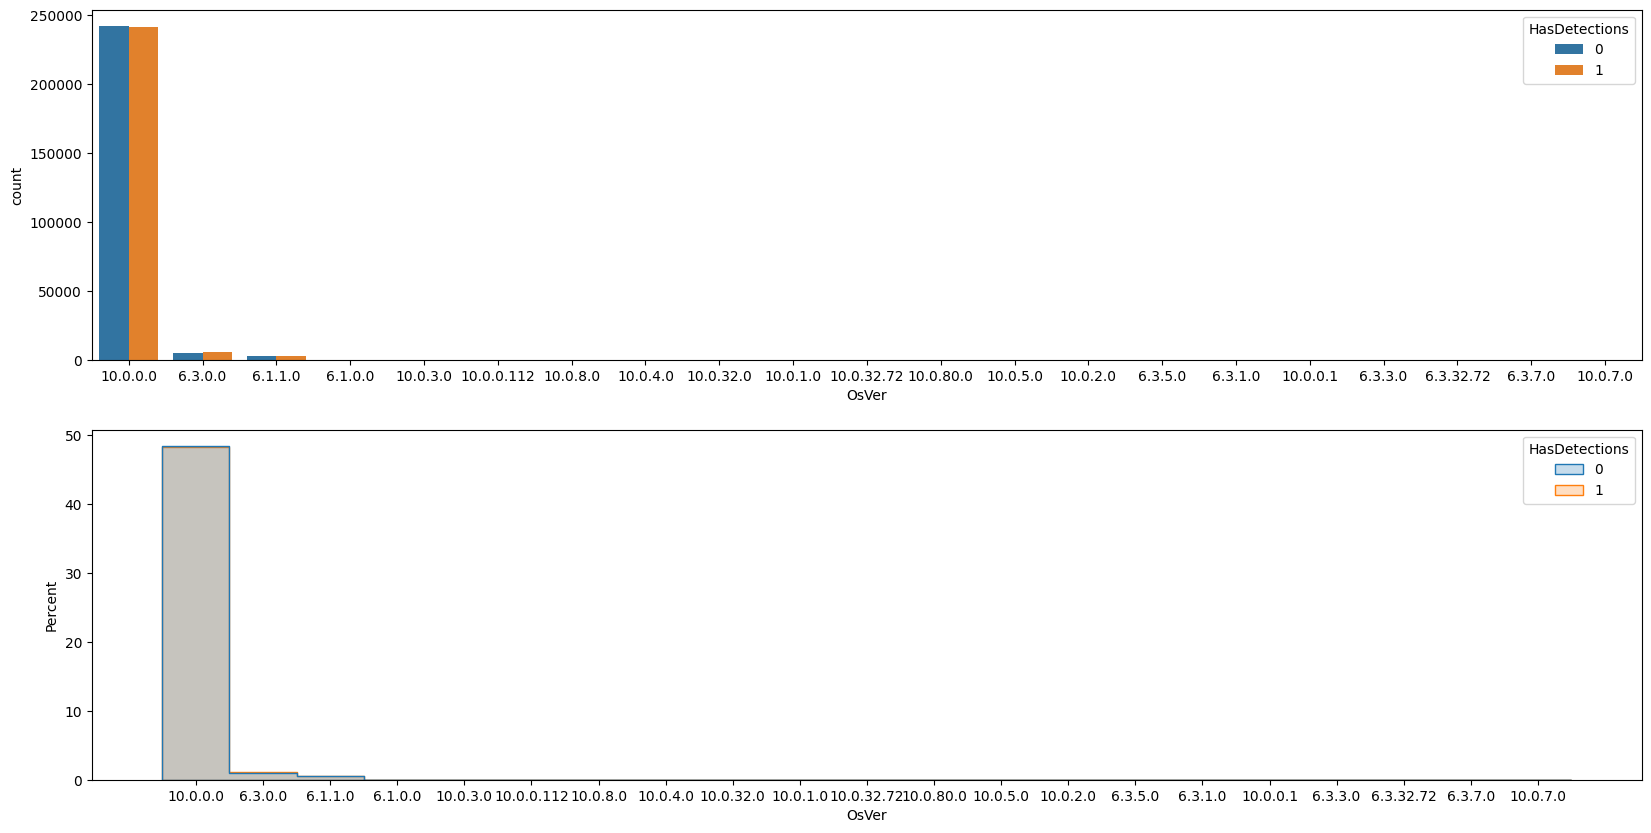

Equipos  Proporcion_Equipos  Infectados  Proporcion_Infectados
OsVer                                                                     
10.0.0.0     483830               96.77      241755                  49.97
6.3.0.0       10818                2.16        5612                  51.88
6.1.1.0        5281                1.06        2552                  48.32
6.1.0.0          33                0.01          10                  30.30
10.0.3.0         12                0.00           9                  75.00
10.0.1.0          7                0.00           5                  71.43
6.3.3.0           2                0.00           0                   0.00
10.0.32.72        2                0.00           0                   0.00
6.3.1.0           2                0.00           1                  50.00
10.0.0.1          2                0.00           2                 100.00
6.3.5.0           1                0.00           0                   0.00
6.3.32.72         1                0.00           0                   0.00
10.0.7.0          1                0.00           1                 100.00
10.0.80.0         1                0.00           0                   0.00
10.0.8.0          1                0.00           1                 100.00
10.0.5.0          1                0.00           1                 100.00
10.0.4.0          1                0.00           0                   0.00
10.0.32.0         1                0.00           1                 100.00
10.0.2.0          1                0.00           1                 100.00
10.0.0.112        1                0.00           1                 100.00
6.3.7.0           1                0.00           1                 100.00

In [40]:
AnalisisAtributo(df_origin,df_origin.columns[19],tar=TARGET)

#### 3.20.- OsBuild

Atributo Numérico
El atributo 'OsBuild' tiene 0 valores nulos (0.0%)

Descripción estadístiica:
count   500,000.00
mean     15,726.93
std       2,188.65
min       7,600.00
25%      15,063.00
50%      16,299.00
75%      17,134.00
max      18,242.00
Name: OsBuild, dtype: float64

El atributo tiene 48 valores únicos

TOP 10 porcentaje de valores únicos:
OsBuild
17134   44.16
16299   27.98
15063    8.67
14393    8.14
10586    4.59
10240    3.00
9600     2.17
7601     1.06
17692    0.03
17738    0.03
Name: proportion, dtype: float64


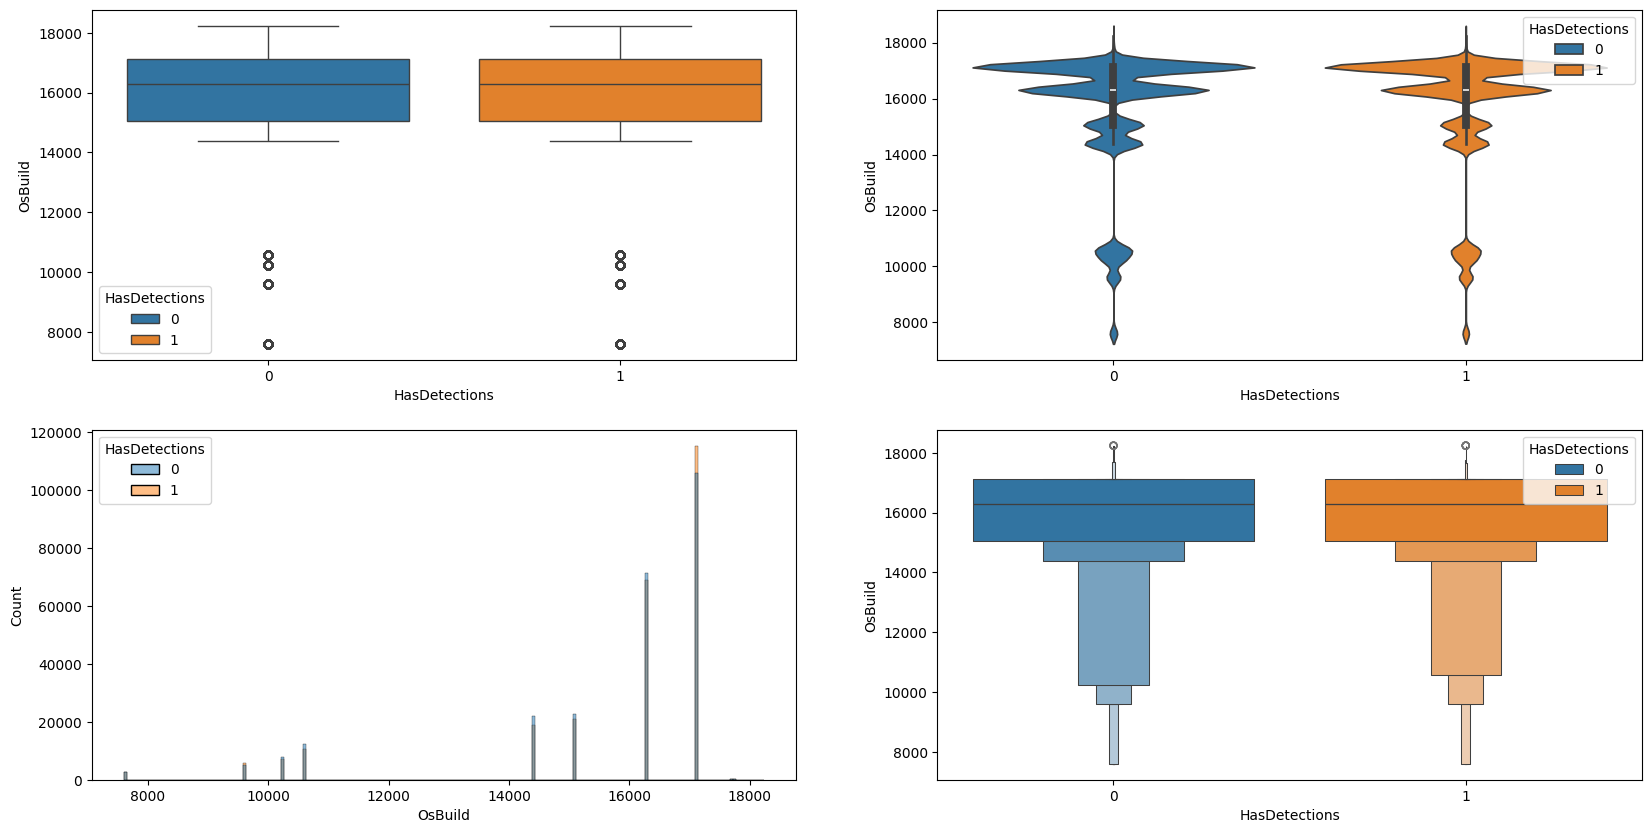

In [41]:
AnalisisAtributo(df_origin,df_origin.columns[20],tar=TARGET)

#### 3.21.- OsSuite

Atributo Numérico
El atributo 'OsSuite' tiene 0 valores nulos (0.0%)

Descripción estadístiica:
count   500,000.00
mean        574.72
std         248.20
min          16.00
25%         256.00
50%         768.00
75%         768.00
max         784.00
Name: OsSuite, dtype: float64

El atributo tiene 9 valores únicos

TOP 10 porcentaje de valores únicos:
OsSuite
768   62.25
256   37.59
272    0.14
16     0.01
400    0.01
305    0.01
784    0.00
274    0.00
18     0.00
Name: proportion, dtype: float64


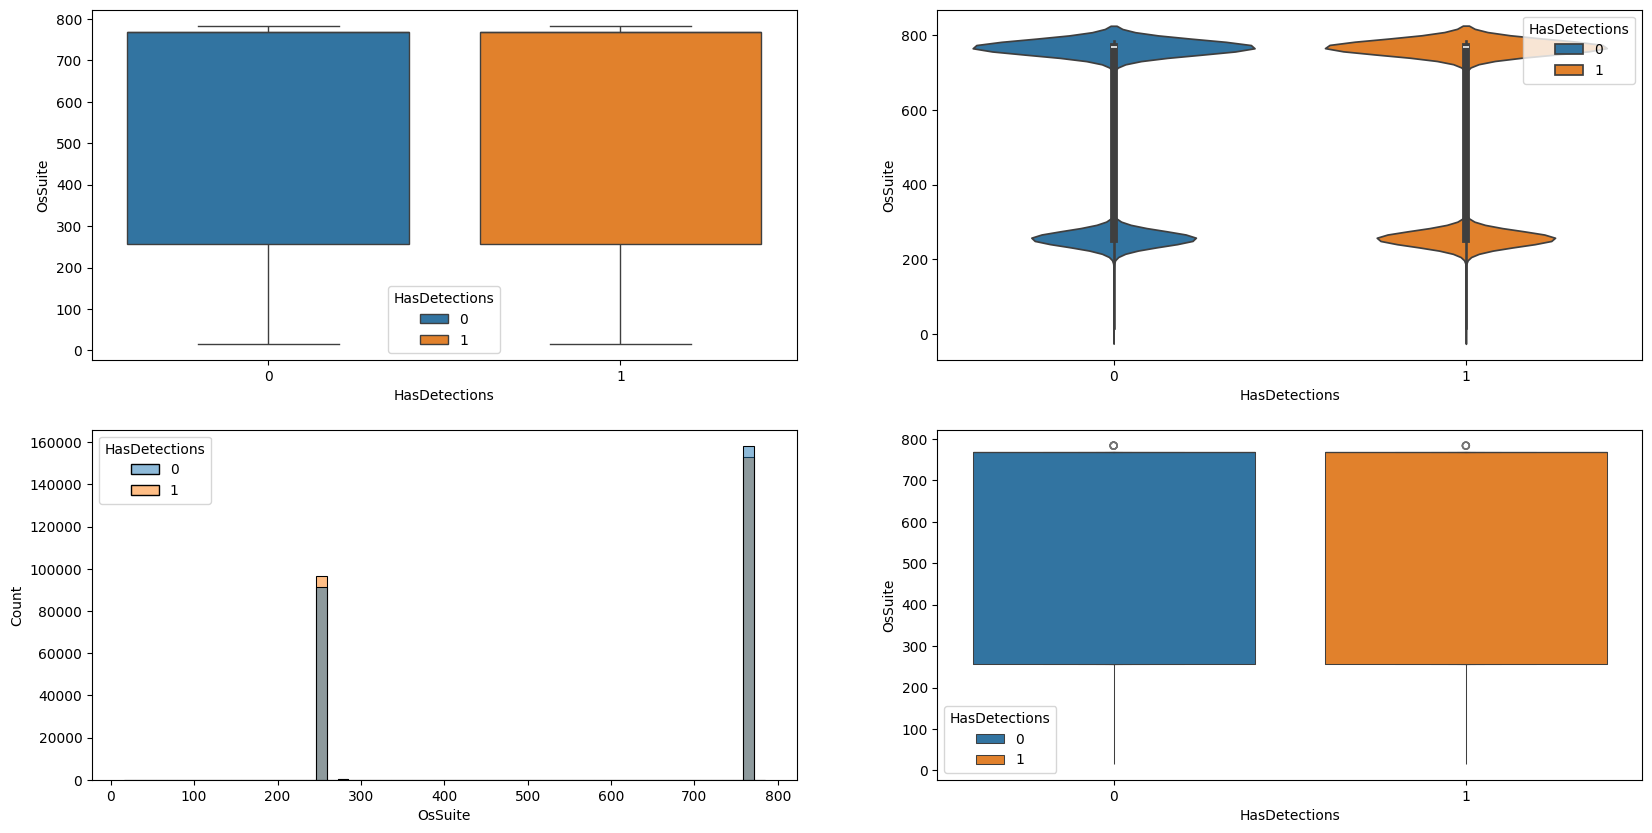

In [42]:
AnalisisAtributo(df_origin,df_origin.columns[21],tar=TARGET)

In [136]:
top=(768,256)
df_origin['OsSuite']=df_origin['OsSuite'].apply(lambda x: 0 if x not in top else x)
del(top)

#### 3.22.- OsPlatformSubRelease

Atributo Categórico
El atributo 'OsPlatformSubRelease' tiene 0 valores nulos (0.0%)

Descripción estadístiica:

count     500000
unique         9
top          rs4
freq      220779
Name: OsPlatformSubRelease, dtype: object


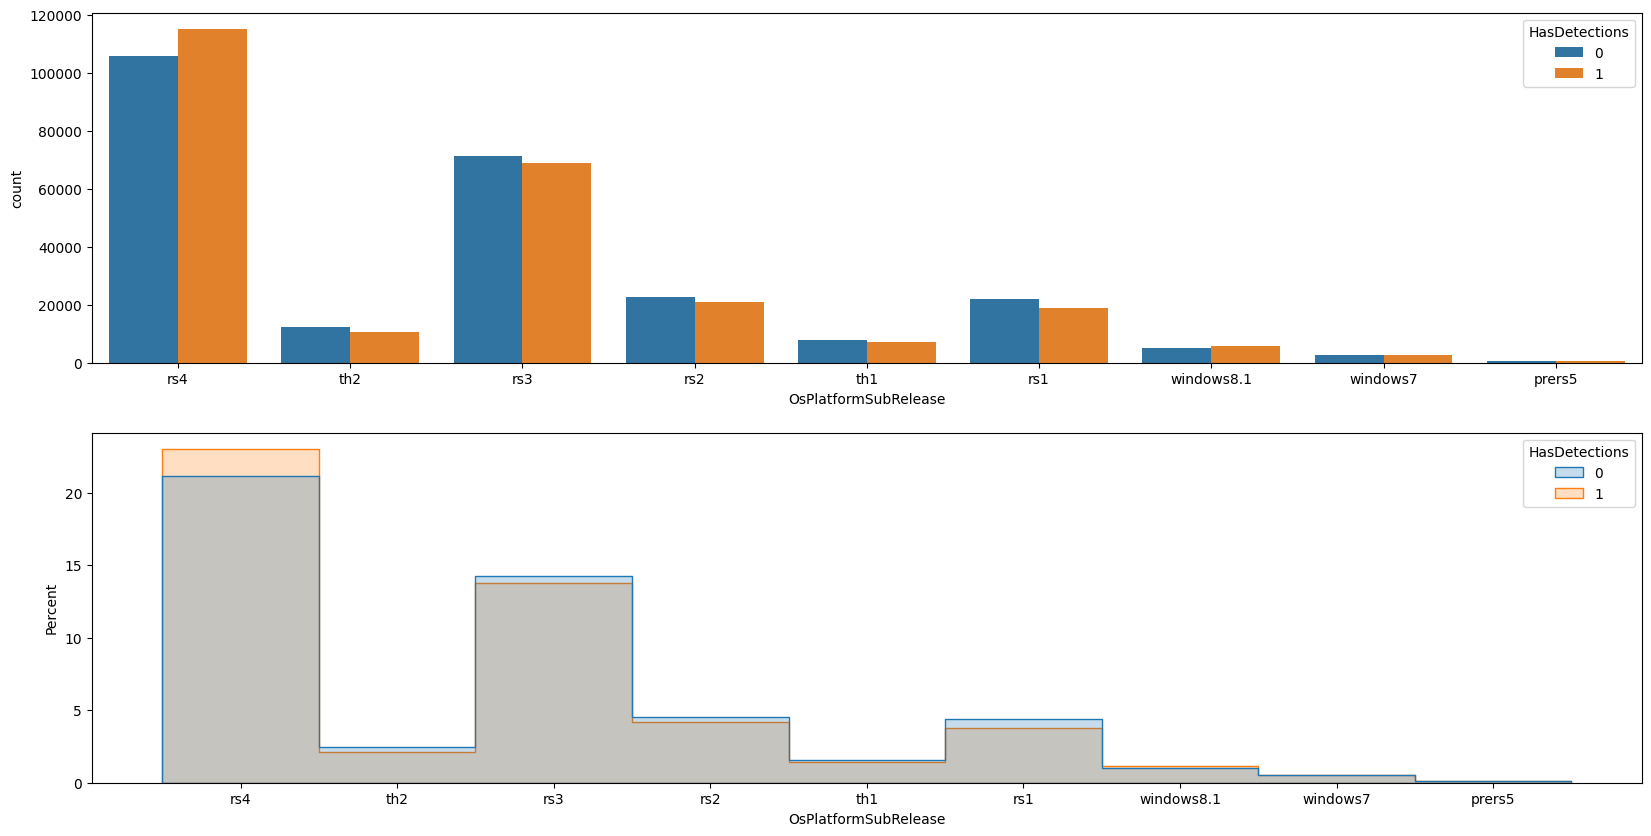

Equipos  Proporcion_Equipos  Infectados  \
OsPlatformSubRelease                                            
rs4                    220779               44.16      114996   
rs3                    139901               27.98       68735   
rs2                     43352                8.67       20778   
rs1                     40717                8.14       18848   
th2                     22955                4.59       10608   
th1                     15014                3.00        7309   
windows8.1              10825                2.16        5614   
windows7                 5314                1.06        2562   
prers5                   1143                0.23         503   

                      Proporcion_Infectados  
OsPlatformSubRelease                         
rs4                                   52.09  
rs3                                   49.13  
rs2                                   47.93  
rs1                                   46.29  
th2                                   46.21  
th1                                   48.68  
windows8.1                            51.86  
windows7                              48.21  
prers5                                44.01

In [43]:
AnalisisAtributo(df_origin,df_origin.columns[22],tar=TARGET)

In [137]:
# Como prers5 representa un 0.23 de la muestra y se refiere a versiones previas a la versión de W10 de Octubre del 2018, la agruparemos con la versión rs1
df_origin['OsPlatformSubRelease']=df_origin['OsPlatformSubRelease'].apply(lambda x: 'rs1' if x=='prers5' else x)

#### 3.23.- OsBuildLab

Atributo Categórico
El atributo 'OsBuildLab' tiene 1 valores nulos (0.0%)

Descripción estadístiica:

count                                       499999
unique                                         453
top       17134.1.amd64fre.rs4_release.180410-1804
freq                                        206436
Name: OsBuildLab, dtype: object


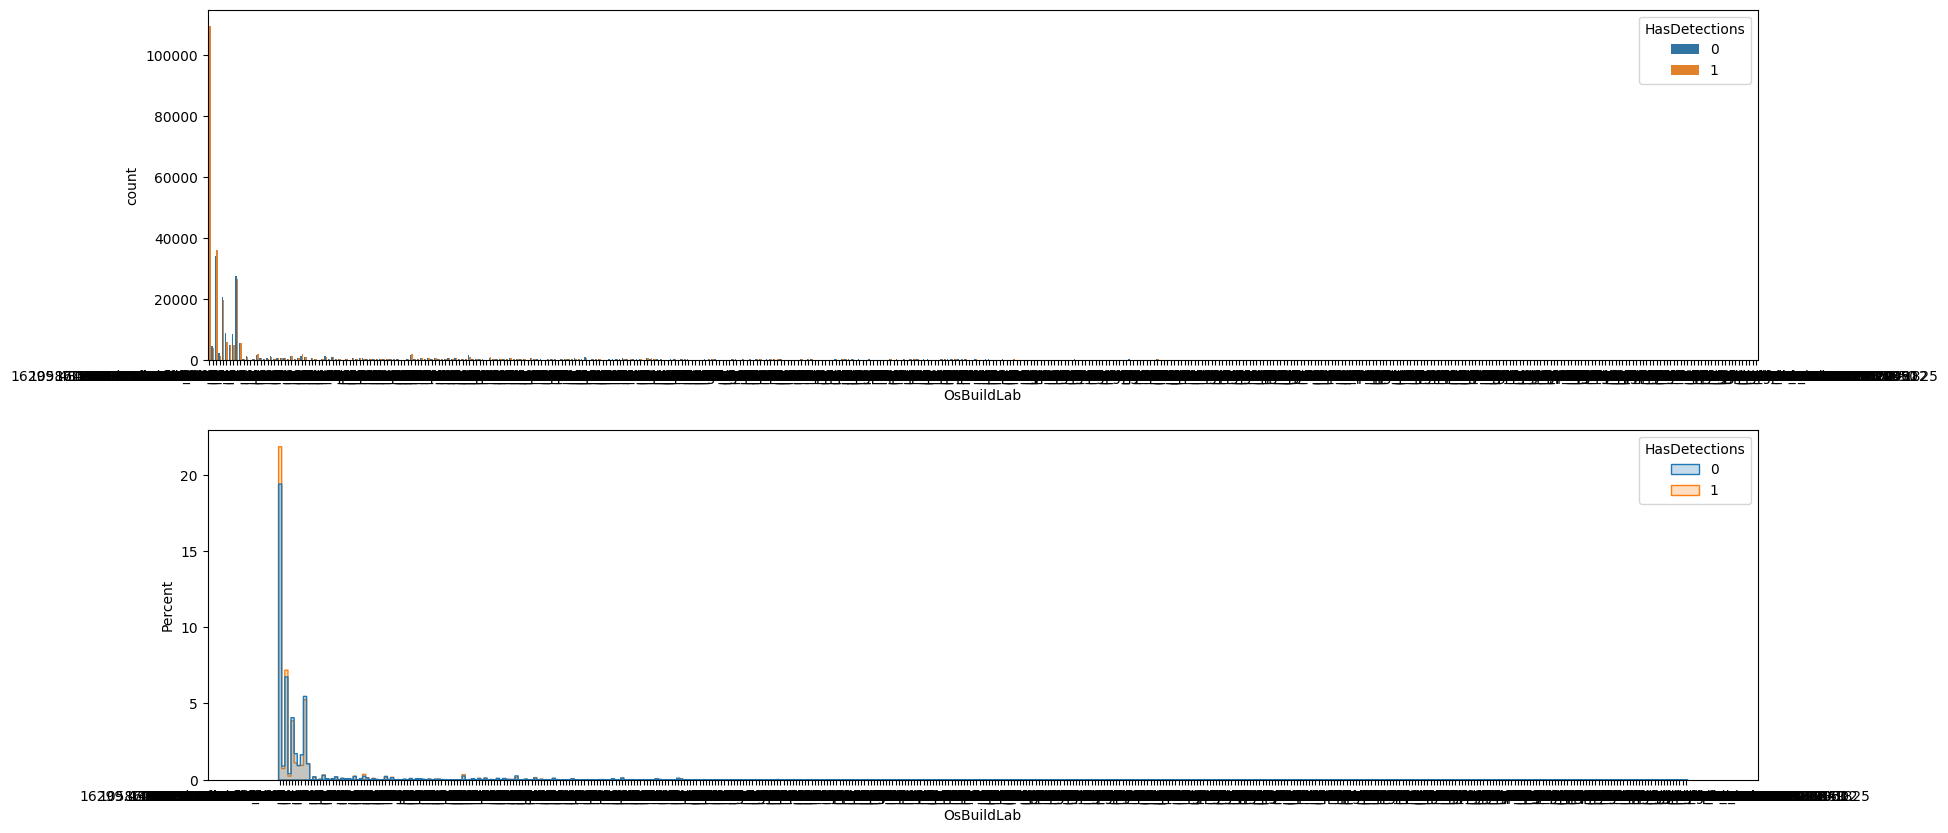

Equipos  \
OsBuildLab                                                    
17134.1.amd64fre.rs4_release.180410-1804             206436   
16299.431.amd64fre.rs3_release_svc_escrow.18050...    69884   
16299.15.amd64fre.rs3_release.170928-1534             53826   
15063.0.amd64fre.rs2_release.170317-1834              39908   
17134.1.x86fre.rs4_release.180410-1804                14334   
...                                                     ...   
7600.17118.amd64fre.win7_gdr.120830-0334                  1   
7600.16841.amd64fre.win7_gdr.110622-1503                  1   
18219.1000.amd64fre.rs_prerelease.180810-1721             1   
18214.1000.amd64fre.rs_prerelease.180803-1553             1   
NaN                                                       1   

                                                    Proporcion_Equipos  \
OsBuildLab                                                               
17134.1.amd64fre.rs4_release.180410-1804                         41.29   
16299.431.amd64fre.rs3_release_svc_escrow.18050...               13.98   
16299.15.amd64fre.rs3_release.170928-1534                        10.77   
15063.0.amd64fre.rs2_release.170317-1834                          7.98   
17134.1.x86fre.rs4_release.180410-1804                            2.87   
...                                                                ...   
7600.17118.amd64fre.win7_gdr.120830-0334                          0.00   
7600.16841.amd64fre.win7_gdr.110622-1503                          0.00   
18219.1000.amd64fre.rs_prerelease.180810-1721                     0.00   
18214.1000.amd64fre.rs_prerelease.180803-1553                     0.00   
NaN                                                               0.00   

                                                    Infectados  \
OsBuildLab                                                       
17134.1.amd64fre.rs4_release.180410-1804                109335   
16299.431.amd64fre.rs3_release_svc_escrow.18050...       36047   
16299.15.amd64fre.rs3_release.170928-1534                26378   
15063.0.amd64fre.rs2_release.170317-1834                 19454   
17134.1.x86fre.rs4_release.180410-1804                    5661   
...                                                        ...   
7600.17118.amd64fre.win7_gdr.120830-0334                     0   
7600.16841.amd64fre.win7_gdr.110622-1503                     0   
18219.1000.amd64fre.rs_prerelease.180810-1721                1   
18214.1000.amd64fre.rs_prerelease.180803-1553                0   
NaN                                                          0   

                                                    Proporcion_Infectados  
OsBuildLab                                                                 
17134.1.amd64fre.rs4_release.180410-1804                            52.96  
16299.431.amd64fre.rs3_release_svc_escrow.18050...                  51.58  
16299.15.amd64fre.rs3_release.170928-1534                           49.01  
15063.0.amd64fre.rs2_release.170317-1834                            48.75  
17134.1.x86fre.rs4_release.180410-1804                              39.49  
...                                                                   ...  
7600.17118.amd64fre.win7_gdr.120830-0334                             0.00  
7600.16841.amd64fre.win7_gdr.110622-1503                             0.00  
18219.1000.amd64fre.rs_prerelease.180810-1721                      100.00  
18214.1000.amd64fre.rs_prerelease.180803-1553                        0.00  
NaN                                                                  0.00  

[454 rows x 4 columns]

In [44]:
AnalisisAtributo(df_origin,df_origin.columns[23],tar=TARGET)

In [138]:
top4=(df_origin.OsBuildLab.value_counts(normalize=True)*100)[:4].index.tolist()
df_origin['OsBuildLab']=df_origin['OsBuildLab'].apply(lambda x: x if x in top4 else 'Other')
del(top4)

#### 3.24- SkuEdition

Atributo Categórico
El atributo 'SkuEdition' tiene 0 valores nulos (0.0%)

Descripción estadístiica:

count     500000
unique         8
top         Home
freq      308567
Name: SkuEdition, dtype: object


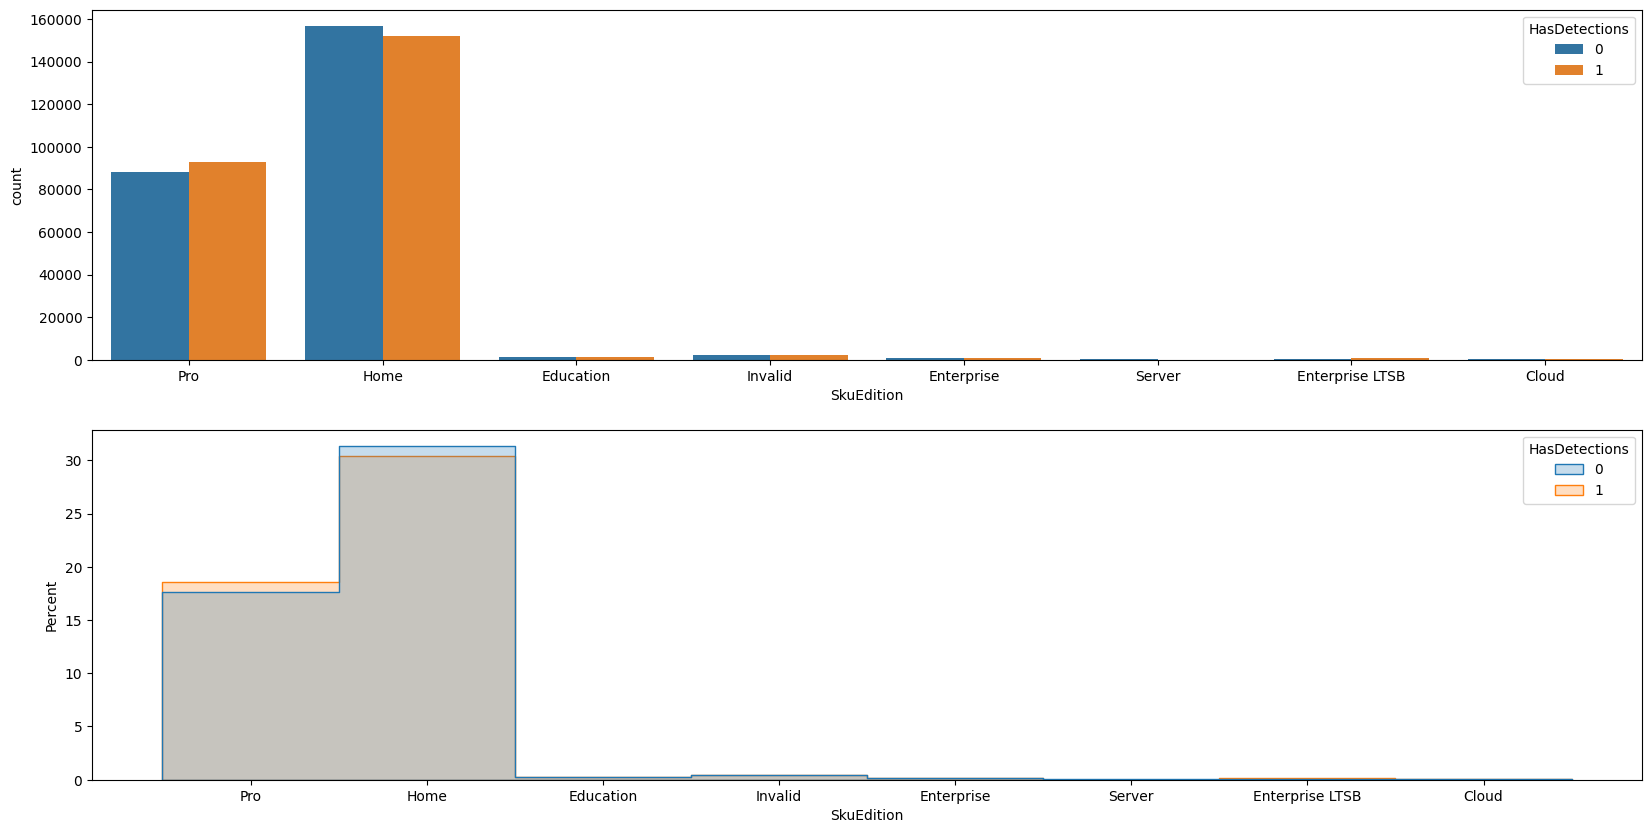

Equipos  Proporcion_Equipos  Infectados  \
SkuEdition                                                 
Home              308567               61.71      152007   
Pro               181042               36.21       92853   
Invalid             4423                0.88        2069   
Education           2321                0.46        1202   
Enterprise          1999                0.40        1035   
Enterprise LTSB     1141                0.23         614   
Cloud                309                0.06         121   
Server               198                0.04          52   

                 Proporcion_Infectados  
SkuEdition                              
Home                             49.26  
Pro                              51.29  
Invalid                          46.78  
Education                        51.79  
Enterprise                       51.78  
Enterprise LTSB                  53.81  
Cloud                            39.16  
Server                           26.26

In [45]:
AnalisisAtributo(df_origin,df_origin.columns[24],tar=TARGET)

In [139]:
top2=('Home', 'Pro')
df_origin['SkuEdition']=df_origin['SkuEdition'].apply(lambda x: x if x in top2 else 'Other')
del(top2)

#### 3.25.- IsProtected

Atributo Numérico
El atributo 'IsProtected' tiene 1926 valores nulos (0.39%)

Descripción estadístiica:
count   498,074.00
mean          0.95
std           0.23
min           0.00
25%           1.00
50%           1.00
75%           1.00
max           1.00
Name: IsProtected, dtype: float64

El atributo tiene 2 valores únicos

TOP 10 porcentaje de valores únicos:
IsProtected
1.00   94.21
0.00    5.40
NaN     0.39
Name: proportion, dtype: float64


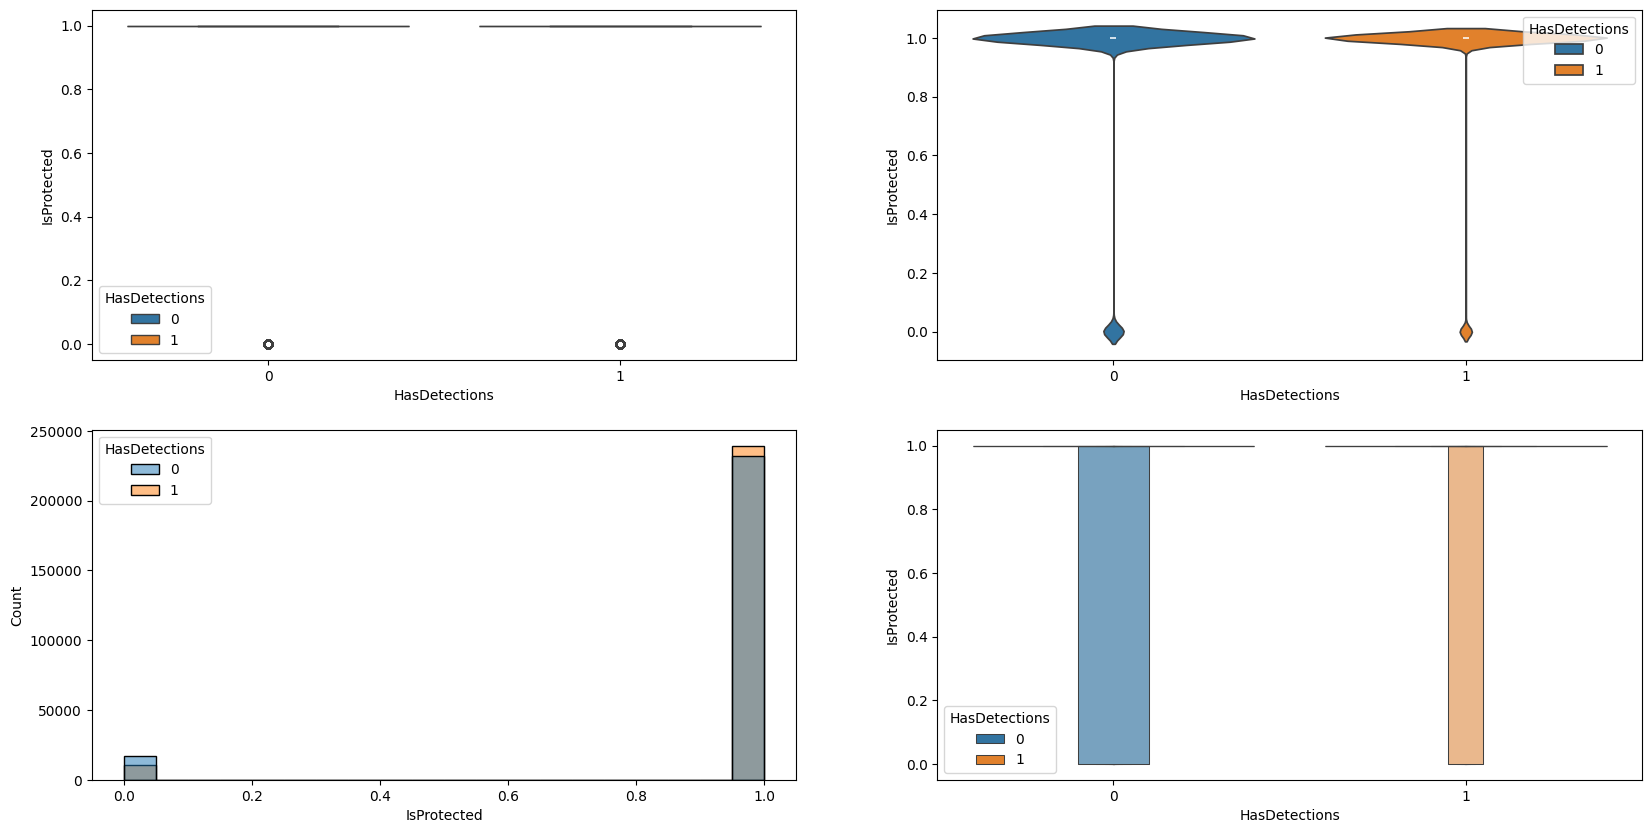

In [46]:
AnalisisAtributo(df_origin,df_origin.columns[25],tar=TARGET)

#### 3.26.- AutoSampleOptIn

Atributo Numérico
El atributo 'AutoSampleOptIn' tiene 0 valores nulos (0.0%)

Descripción estadístiica:
count   500,000.00
mean          0.00
std           0.01
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           1.00
Name: AutoSampleOptIn, dtype: float64

El atributo tiene 2 valores únicos

TOP 10 porcentaje de valores únicos:
AutoSampleOptIn
0   100.00
1     0.00
Name: proportion, dtype: float64


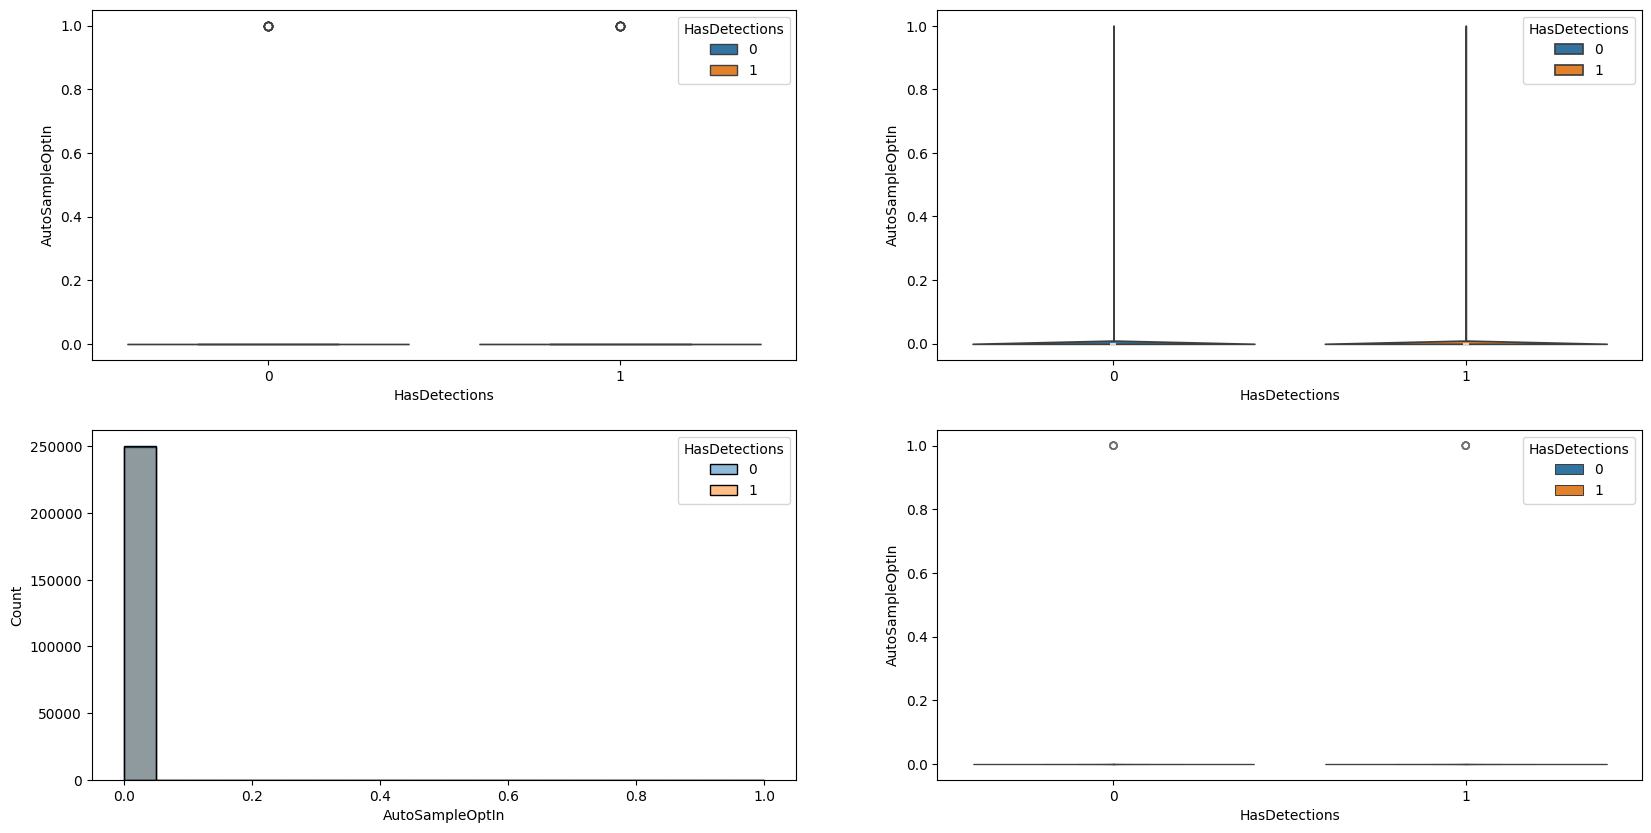

In [47]:
AnalisisAtributo(df_origin,df_origin.columns[26],tar=TARGET)

#### 3.27.- PuaMode

Atributo Categórico
El atributo 'PuaMode' tiene 499874 valores nulos (99.97%)

Descripción estadístiica:

count     126
unique      1
top        on
freq      126
Name: PuaMode, dtype: object


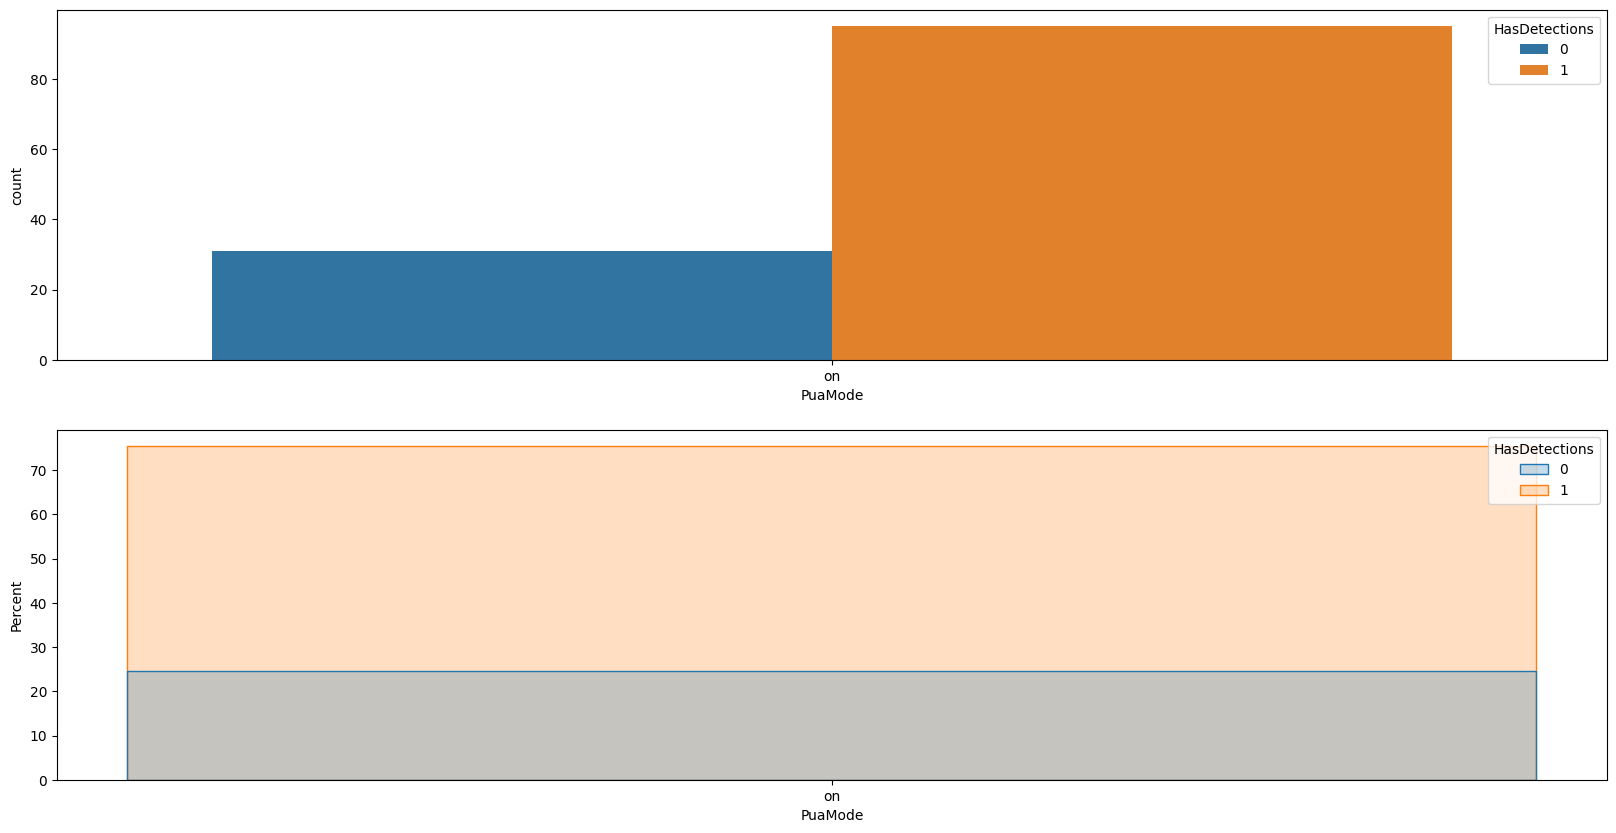

Equipos  Proporcion_Equipos  Infectados  Proporcion_Infectados
PuaMode                                                                
NaN       499874               99.97      249858                  49.98
on           126                0.03          95                  75.40

In [48]:
AnalisisAtributo(df_origin,df_origin.columns[27],tar=TARGET)

#### 3.28.- SMode

Atributo Numérico
El atributo 'SMode' tiene 29848 valores nulos (5.97%)

Descripción estadístiica:
count   470,152.00
mean          0.00
std           0.02
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           1.00
Name: SMode, dtype: float64

El atributo tiene 2 valores únicos

TOP 10 porcentaje de valores únicos:
SMode
0.00   93.99
NaN     5.97
1.00    0.04
Name: proportion, dtype: float64


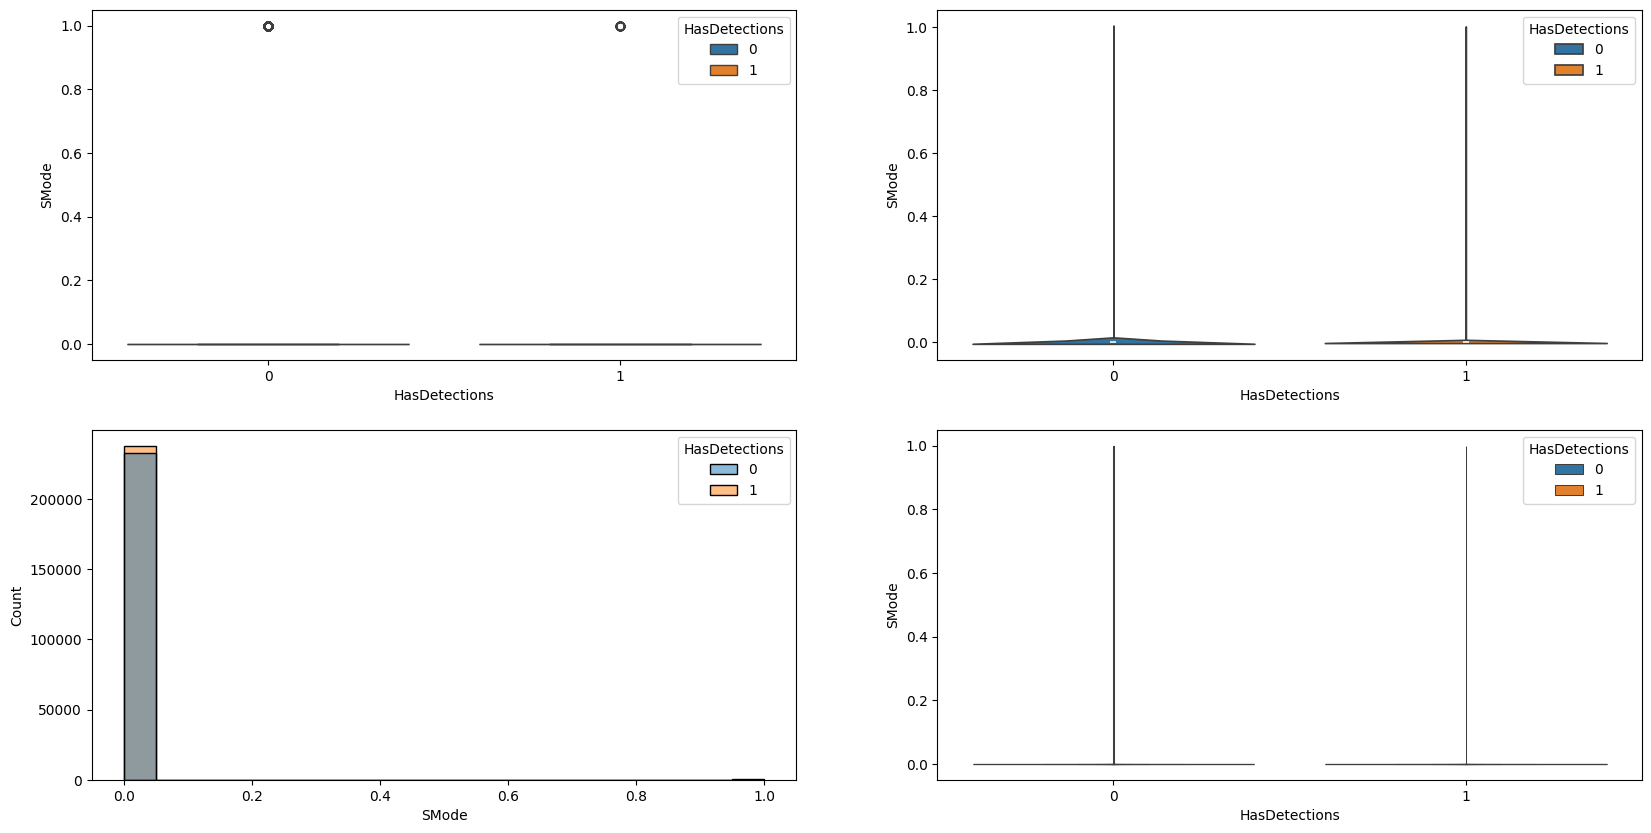

In [49]:
AnalisisAtributo(df_origin,df_origin.columns[28],tar=TARGET)

#### 3.29.- IeVerIdentifier

Atributo Numérico
El atributo 'IeVerIdentifier' tiene 3209 valores nulos (0.64%)

Descripción estadístiica:
count   496,791.00
mean        126.66
std          42.63
min           8.00
25%         111.00
50%         135.00
75%         137.00
max         429.00
Name: IeVerIdentifier, dtype: float64

El atributo tiene 179 valores únicos

TOP 10 porcentaje de valores únicos:
IeVerIdentifier
137.00   43.83
117.00   19.73
108.00    5.27
111.00    5.23
98.00     3.95
135.00    2.46
74.00     2.28
53.00     2.27
94.00     1.94
105.00    1.94
Name: proportion, dtype: float64


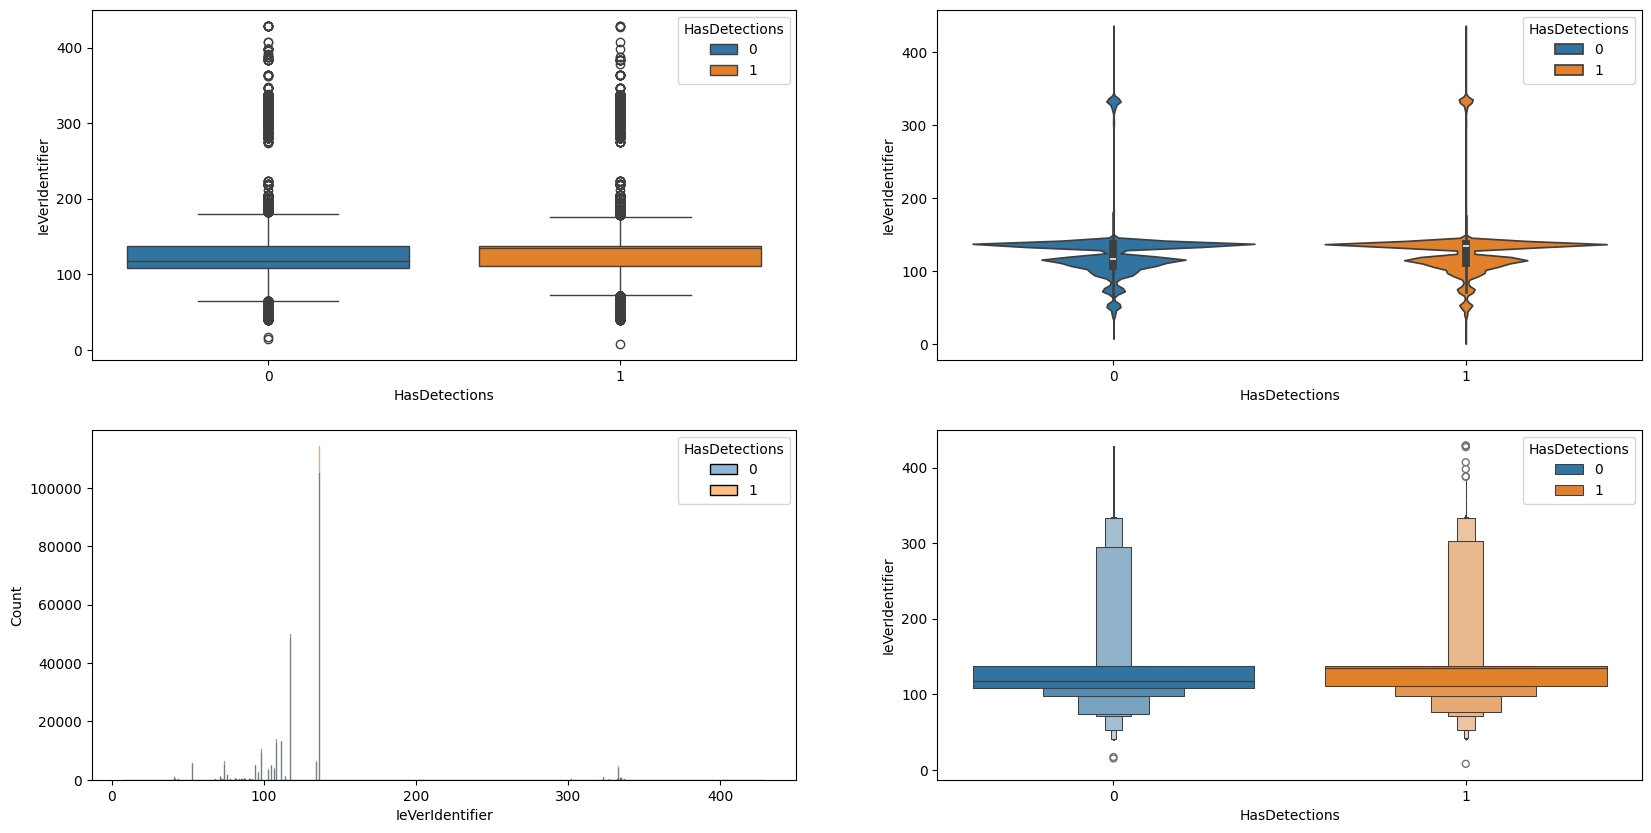

In [50]:
AnalisisAtributo(df_origin,df_origin.columns[29],tar=TARGET)

In [140]:
top5=df_origin['IeVerIdentifier'].value_counts(normalize=True).head().index.tolist()
df_origin['IeVerIdentifier']=df_origin['IeVerIdentifier'].apply(lambda x: x if x in top5 else 0)
del(top5)

#### 3.30.- SmartScreen

Atributo Categórico
El atributo 'SmartScreen' tiene 178596 valores nulos (35.72%)

Descripción estadístiica:

count           321404
unique              12
top       RequireAdmin
freq            241594
Name: SmartScreen, dtype: object


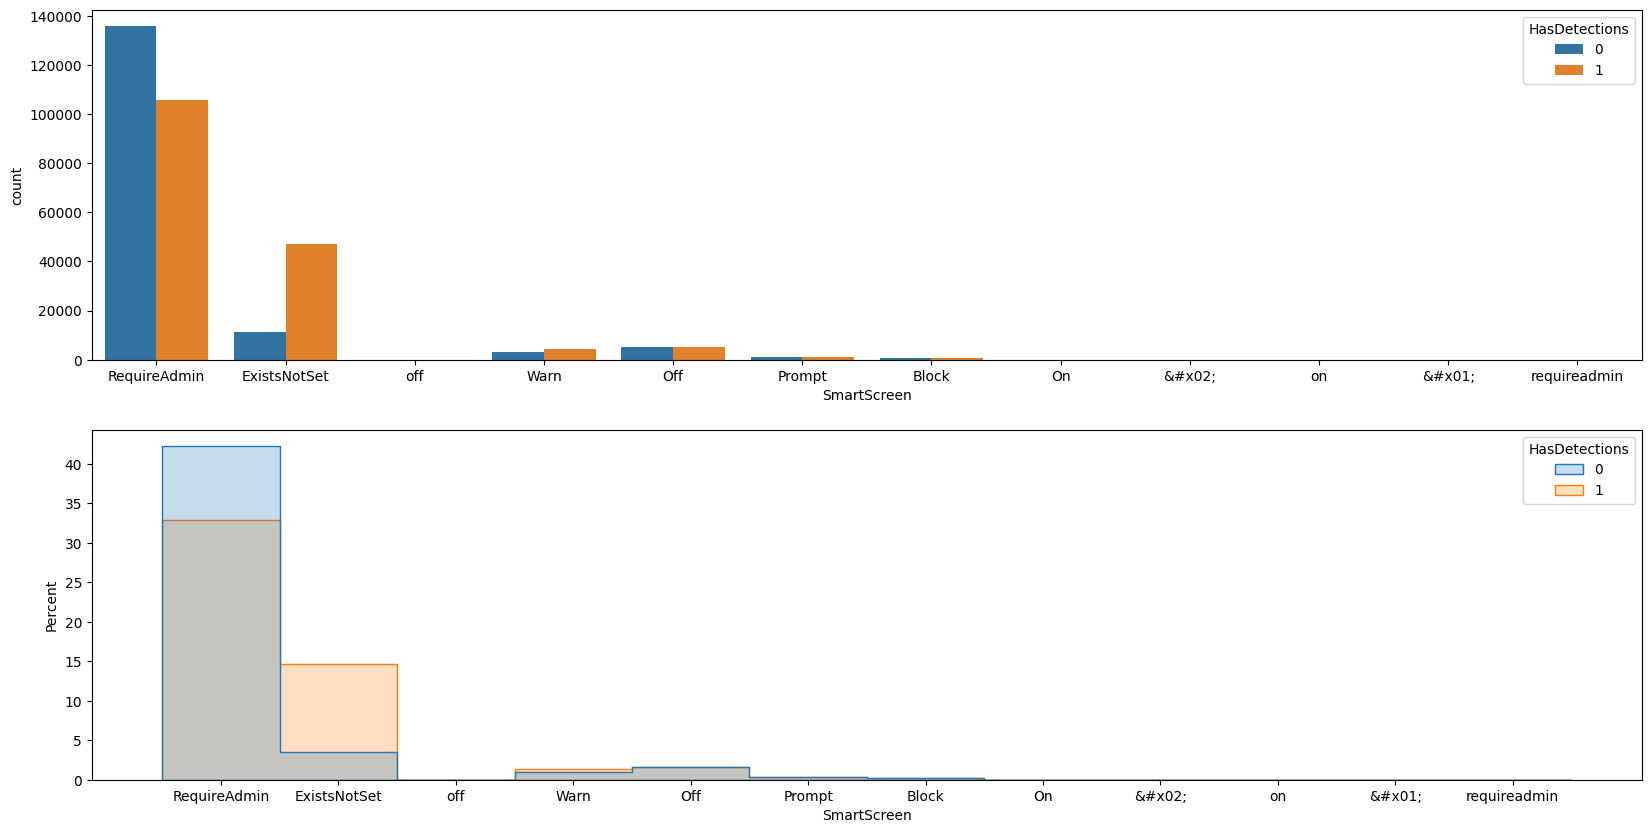

Equipos  Proporcion_Equipos  Infectados  Proporcion_Infectados
SmartScreen                                                                 
RequireAdmin   241594               48.32      105890                  43.83
NaN            178596               35.72       85919                  48.11
ExistsNotSet    58497               11.70       47115                  80.54
Off             10388                2.08        5055                  48.66
Warn             7530                1.51        4306                  57.18
Prompt           1950                0.39         928                  47.59
Block            1274                0.25         640                  50.24
off                75                0.02          43                  57.33
On                 53                0.01          36                  67.92
&#x02;             20                0.00          11                  55.00
&#x01;             14                0.00           6                  42.86
on                  8                0.00           4                  50.00
requireadmin        1                0.00           0                   0.00

In [51]:
AnalisisAtributo(df_origin,df_origin.columns[30],tar=TARGET)

#### 3.31.- Firewall

Atributo Numérico
El atributo 'Firewall' tiene 5162 valores nulos (1.03%)

Descripción estadístiica:
count   494,838.00
mean          0.98
std           0.15
min           0.00
25%           1.00
50%           1.00
75%           1.00
max           1.00
Name: Firewall, dtype: float64

El atributo tiene 2 valores únicos

TOP 10 porcentaje de valores únicos:
Firewall
1.00   96.81
0.00    2.15
NaN     1.03
Name: proportion, dtype: float64


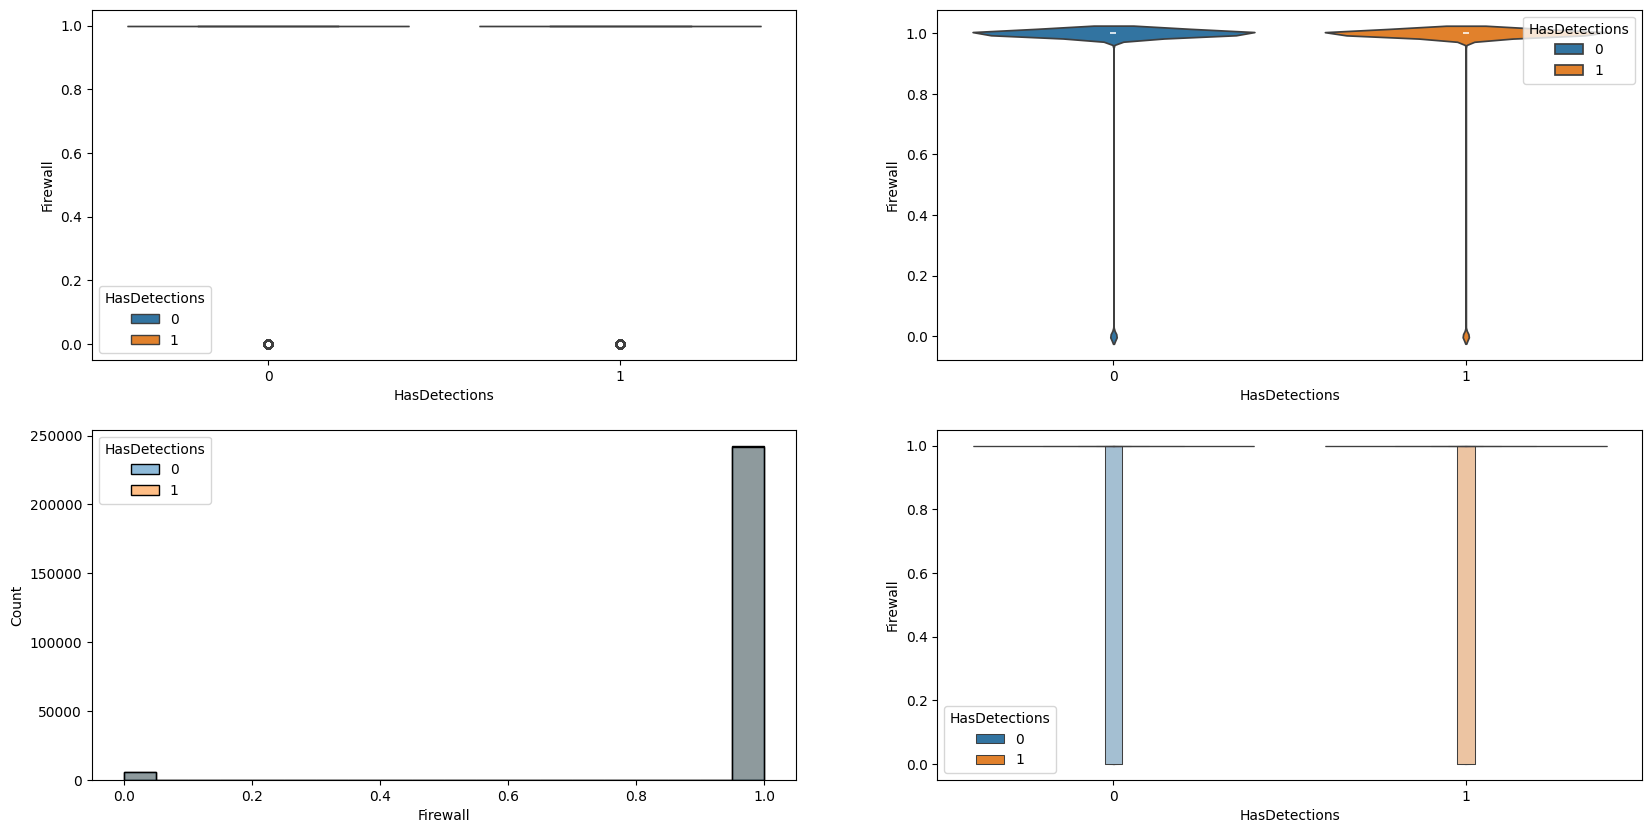

In [52]:
AnalisisAtributo(df_origin,df_origin.columns[31],tar=TARGET)

#### 3.32.- UacLuaenable

Atributo Numérico
El atributo 'UacLuaenable' tiene 623 valores nulos (0.12%)

Descripción estadístiica:
count     499,377.00
mean           13.73
std         8,995.85
min             0.00
25%             1.00
50%             1.00
75%             1.00
max     6,357,062.00
Name: UacLuaenable, dtype: float64

El atributo tiene 5 valores únicos

TOP 10 porcentaje de valores únicos:
UacLuaenable
1.00           99.26
0.00            0.62
NaN             0.12
48.00           0.00
2.00            0.00
6,357,062.00    0.00
Name: proportion, dtype: float64


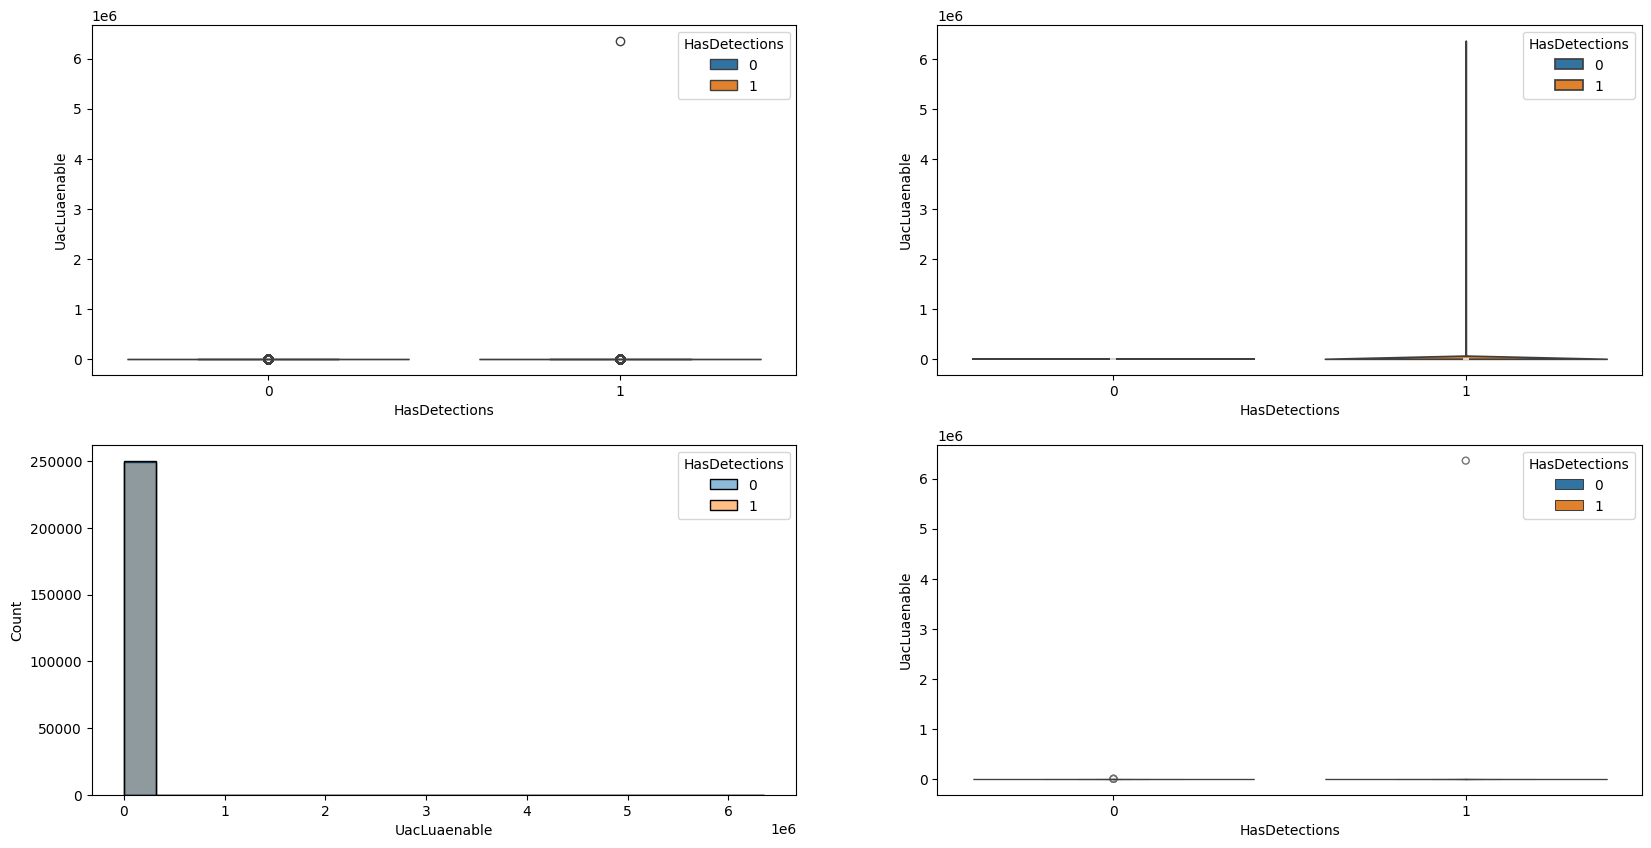

In [53]:
AnalisisAtributo(df_origin,df_origin.columns[32],tar=TARGET)

#### 3.33.- Census_MDC2FormFactor

Atributo Categórico
El atributo 'Census_MDC2FormFactor' tiene 0 valores nulos (0.0%)

Descripción estadístiica:

count       500000
unique          12
top       Notebook
freq        320948
Name: Census_MDC2FormFactor, dtype: object


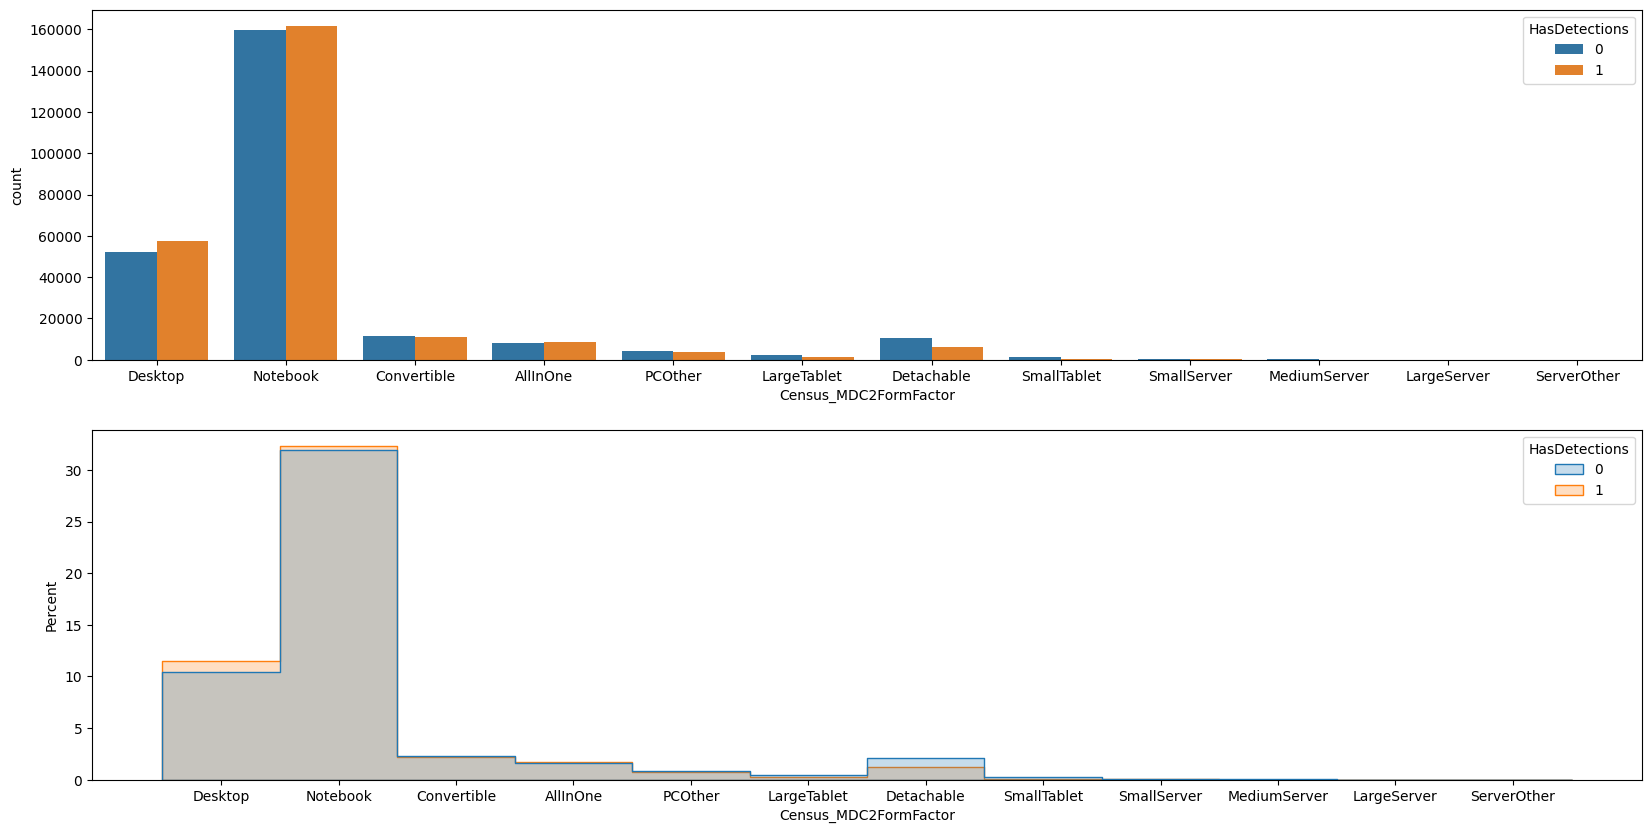

Equipos  Proporcion_Equipos  Infectados  \
Census_MDC2FormFactor                                            
Notebook                320948               64.19      161411   
Desktop                 109527               21.91       57306   
Convertible              22369                4.47       11025   
Detachable               16802                3.36        6351   
AllInOne                 16372                3.27        8384   
PCOther                   7800                1.56        3715   
LargeTablet               3645                0.73        1138   
SmallTablet               1797                0.36         360   
SmallServer                496                0.10         191   
MediumServer               192                0.04          62   
LargeServer                 50                0.01          10   
ServerOther                  2                0.00           0   

                       Proporcion_Infectados  
Census_MDC2FormFactor                         
Notebook                               50.29  
Desktop                                52.32  
Convertible                            49.29  
Detachable                             37.80  
AllInOne                               51.21  
PCOther                                47.63  
LargeTablet                            31.22  
SmallTablet                            20.03  
SmallServer                            38.51  
MediumServer                           32.29  
LargeServer                            20.00  
ServerOther                             0.00

In [54]:
AnalisisAtributo(df_origin,df_origin.columns[33],tar=TARGET)

In [141]:
top2=('Notebook', 'Desktop')
df_origin['Census_MDC2FormFactor']=df_origin['Census_MDC2FormFactor'].apply(lambda x: x if x in top2 else 'Other')
del(top2)

#### 3.34.- Census_DeviceFamily

Atributo Categórico
El atributo 'Census_DeviceFamily' tiene 0 valores nulos (0.0%)

Descripción estadístiica:

count              500000
unique                  3
top       Windows.Desktop
freq               499183
Name: Census_DeviceFamily, dtype: object


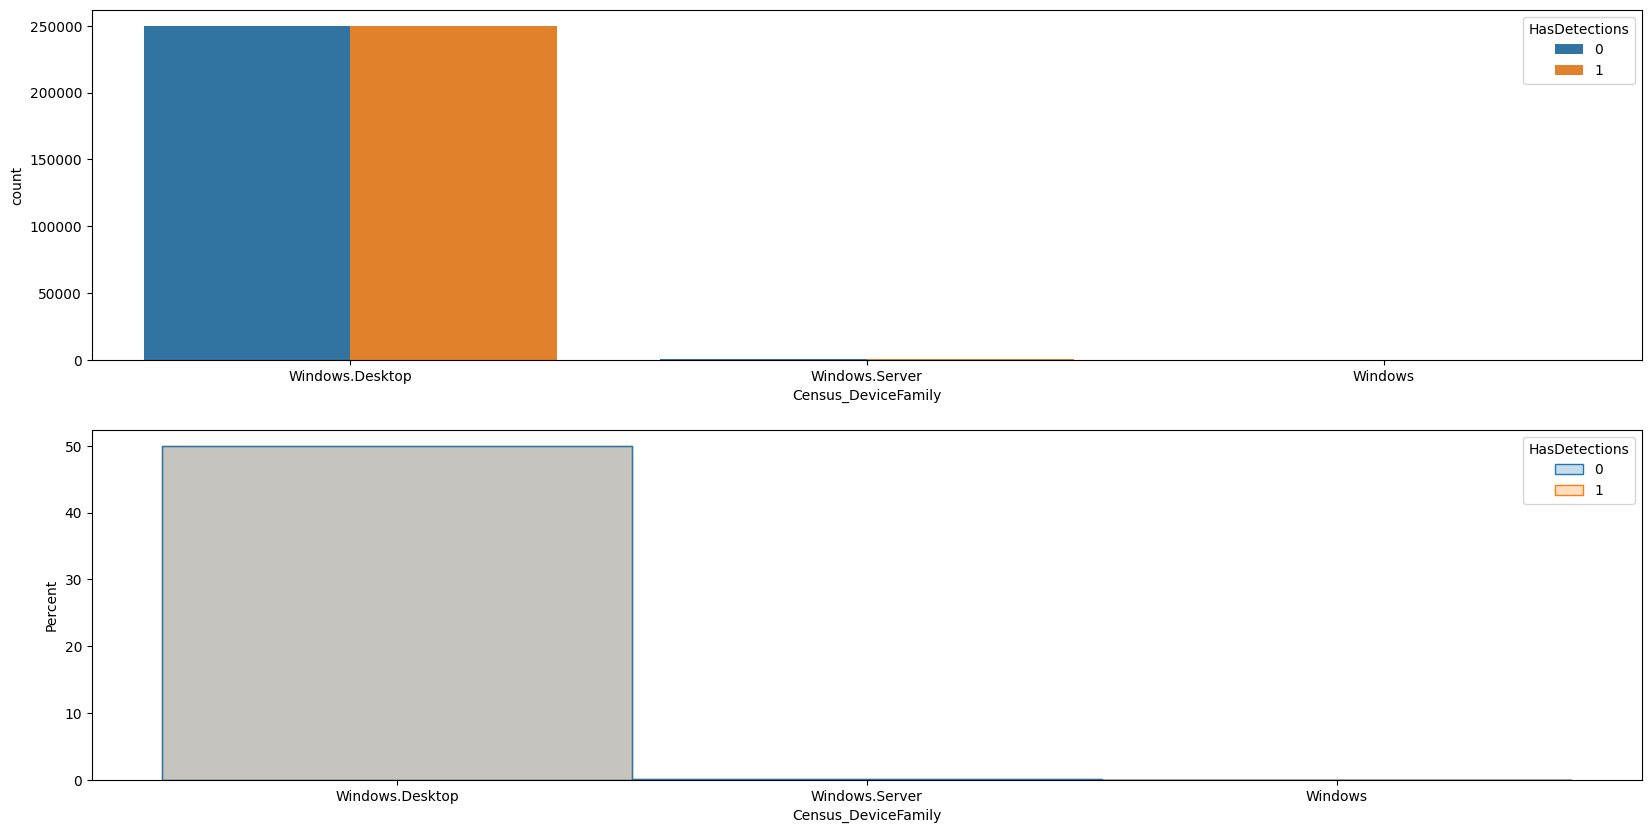

Equipos  Proporcion_Equipos  Infectados  \
Census_DeviceFamily                                            
Windows.Desktop       499183               99.84      249651   
Windows.Server           816                0.16         302   
Windows                    1                0.00           0   

                     Proporcion_Infectados  
Census_DeviceFamily                         
Windows.Desktop                      50.01  
Windows.Server                       37.01  
Windows                               0.00

In [55]:
AnalisisAtributo(df_origin,df_origin.columns[34],tar=TARGET)

#### 3.35.- Census_OEMNameIdentifier

Atributo Numérico
El atributo 'Census_OEMNameIdentifier' tiene 5381 valores nulos (1.08%)

Descripción estadístiica:
count   494,619.00
mean      2,218.65
std       1,315.71
min          54.00
25%       1,443.00
50%       2,102.00
75%       2,668.00
max       6,143.00
Name: Census_OEMNameIdentifier, dtype: float64

El atributo tiene 1589 valores únicos

TOP 10 porcentaje de valores únicos:
Census_OEMNameIdentifier
2,668.00   14.40
2,102.00   11.58
1,443.00   10.64
2,206.00   10.38
585.00     10.06
525.00      9.46
4,589.00    3.48
4,730.00    3.40
1,980.00    3.23
4,142.00    2.24
Name: proportion, dtype: float64


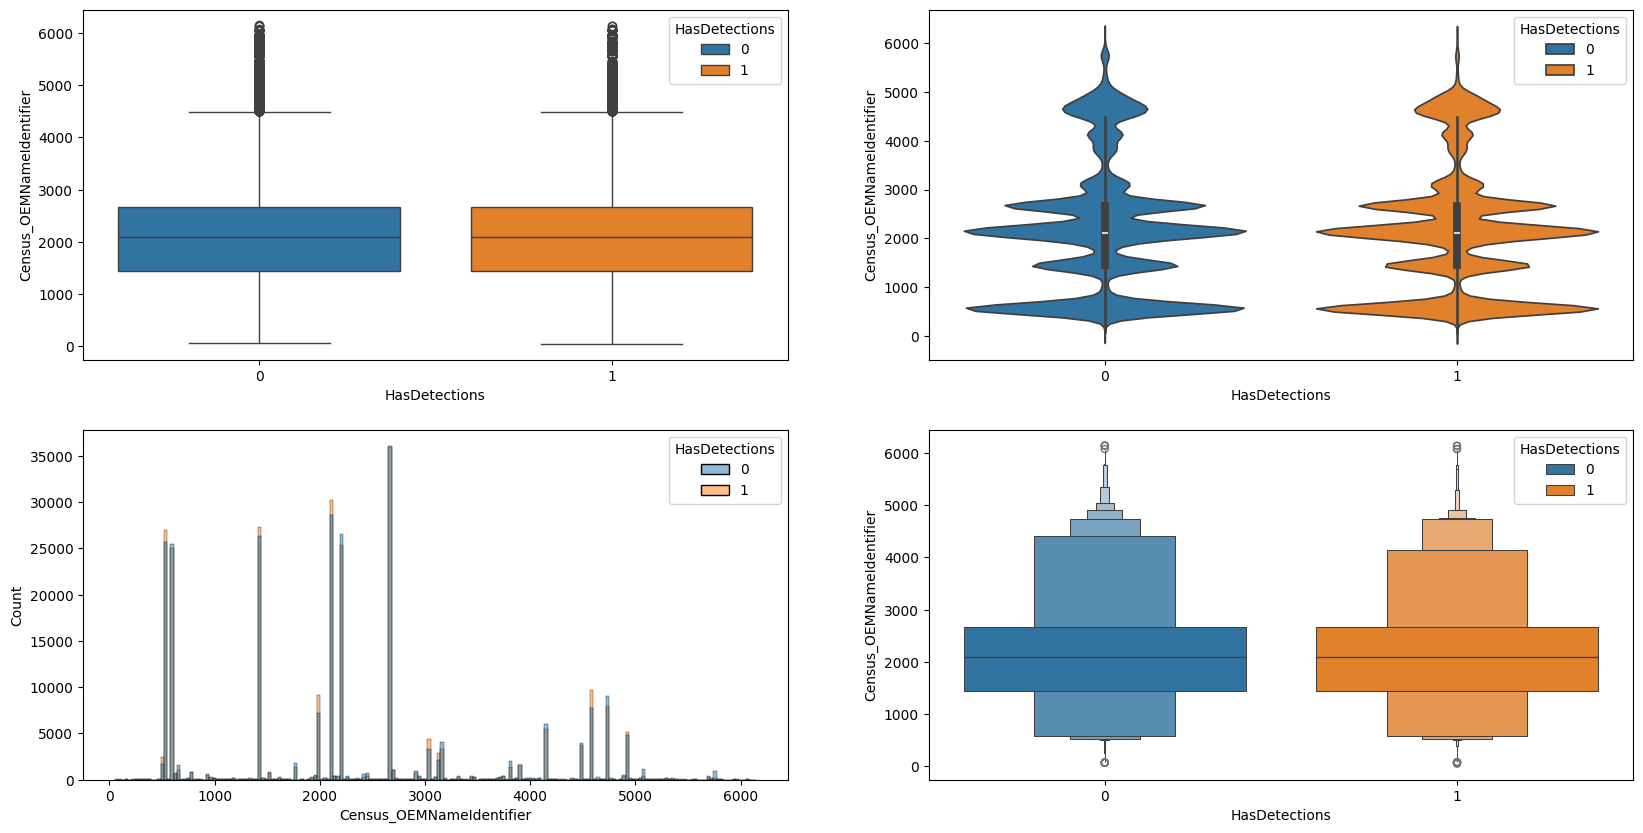

In [56]:
AnalisisAtributo(df_origin,df_origin.columns[35],tar=TARGET)

In [142]:
top10=(df_origin['Census_OEMNameIdentifier'].value_counts(dropna=False, normalize=False)).head(10).index.tolist()
df_origin['Census_OEMNameIdentifier']=df_origin['Census_OEMNameIdentifier'].apply(lambda x: x if x in top10 else 0)
del(top10)

#### 3.36.- Census_OEMModelIdentifier

Atributo Numérico
El atributo 'Census_OEMModelIdentifier' tiene 5764 valores nulos (1.15%)

Descripción estadístiica:
count   494,236.00
mean    239,128.05
std      72,048.88
min           1.00
25%     189,641.75
50%     247,520.00
75%     304,438.00
max     345,493.00
Name: Census_OEMModelIdentifier, dtype: float64

El atributo tiene 40697 valores únicos

TOP 10 porcentaje de valores únicos:
Census_OEMModelIdentifier
313,586.00   3.42
242,491.00   2.95
317,701.00   1.54
317,708.00   1.31
NaN          1.15
228,975.00   0.88
188,345.00   0.81
241,876.00   0.79
245,824.00   0.76
244,755.00   0.57
Name: proportion, dtype: float64


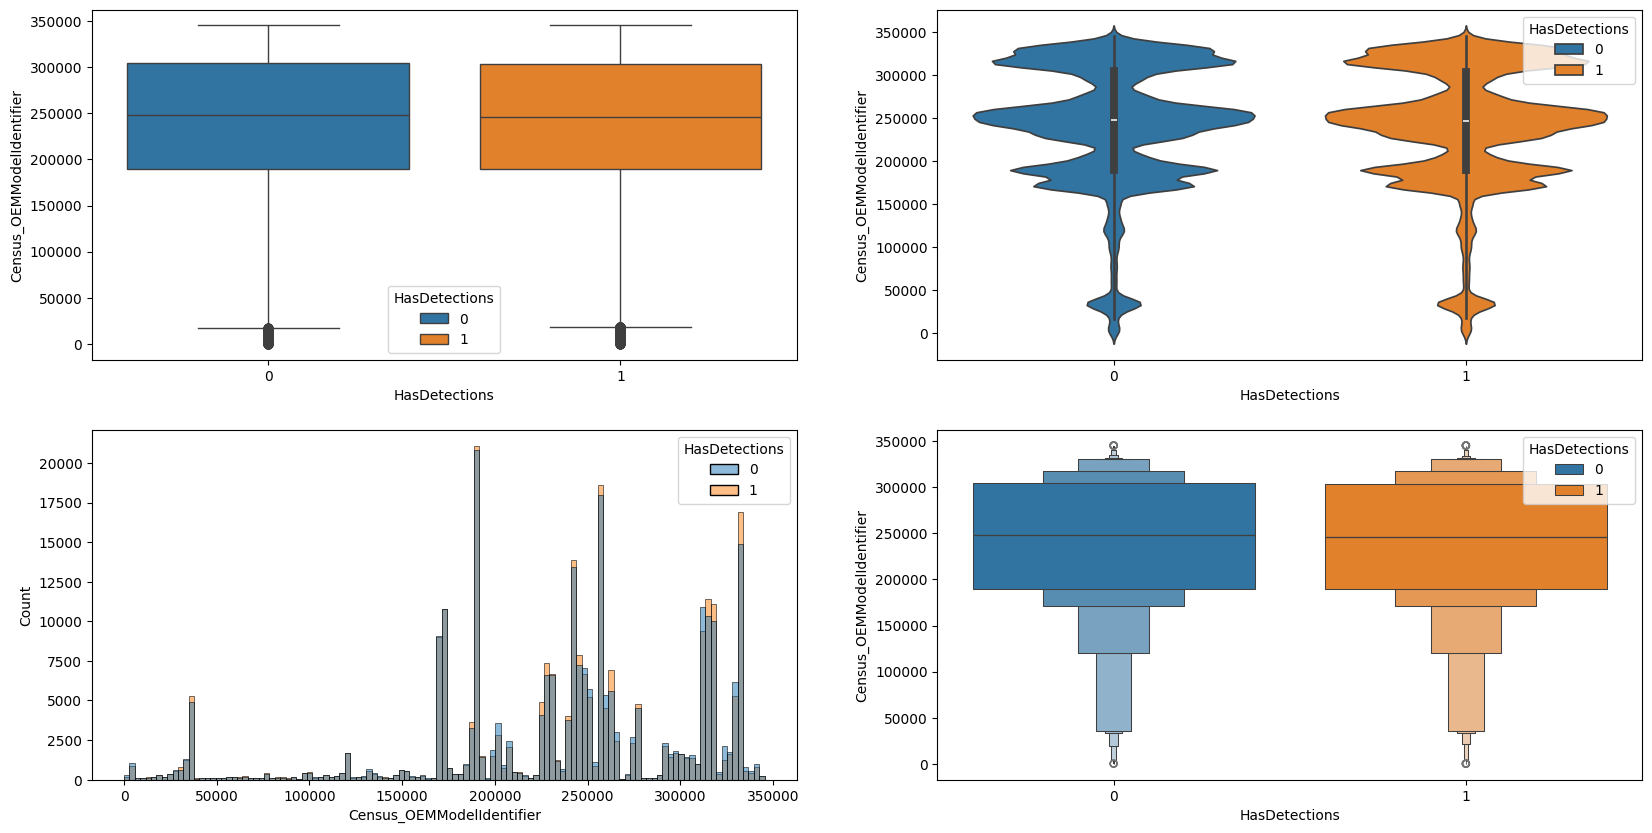

In [57]:
AnalisisAtributo(df_origin,df_origin.columns[36],tar=TARGET)

#### 3.37.- Census_ProcessorCoreCount

Atributo Numérico
El atributo 'Census_ProcessorCoreCount' tiene 2347 valores nulos (0.47%)

Descripción estadístiica:
count   497,653.00
mean          3.99
std           2.07
min           1.00
25%           2.00
50%           4.00
75%           4.00
max          88.00
Name: Census_ProcessorCoreCount, dtype: float64

El atributo tiene 27 valores únicos

TOP 10 porcentaje de valores únicos:
Census_ProcessorCoreCount
4.00    60.82
2.00    25.84
8.00     9.80
12.00    1.04
6.00     0.80
1.00     0.80
NaN      0.47
16.00    0.20
3.00     0.15
32.00    0.02
Name: proportion, dtype: float64


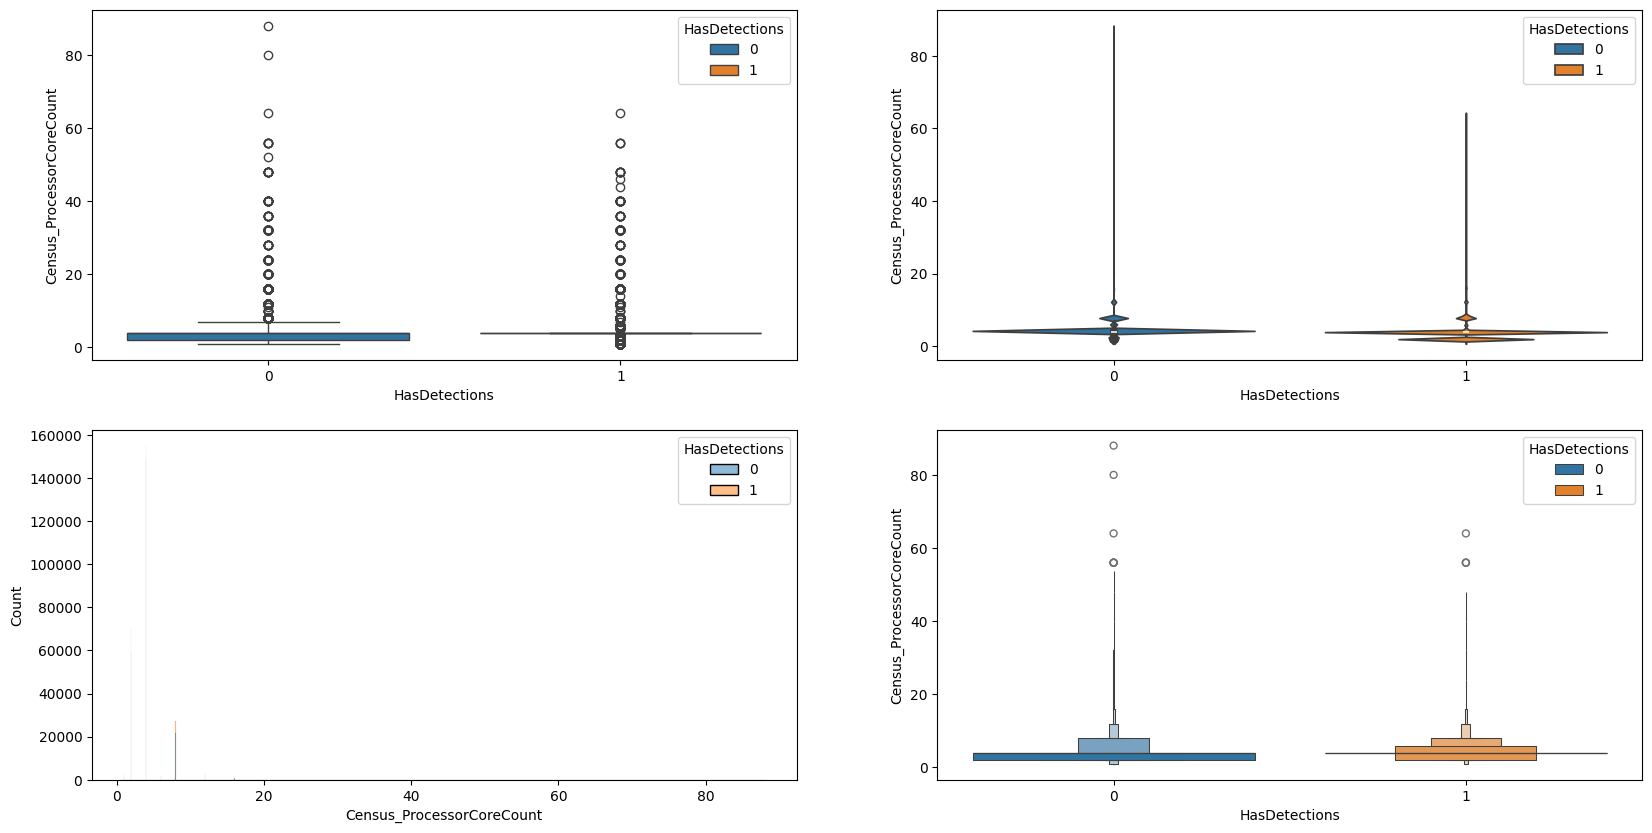

In [58]:
AnalisisAtributo(df_origin,df_origin.columns[37],tar=TARGET)

In [143]:
top3=df_origin['Census_ProcessorCoreCount'].value_counts().index.tolist()[:3]
df_origin['Census_ProcessorCoreCount']=df_origin['Census_ProcessorCoreCount'].apply(lambda x: x if x in top3 else 0)
del(top3)

#### 3.38.- Census_ProcessorManufacturerIdentifier

Atributo Numérico
El atributo 'Census_ProcessorManufacturerIdentifier' tiene 2347 valores nulos (0.47%)

Descripción estadístiica:
count   497,653.00
mean          4.53
std           1.29
min           1.00
25%           5.00
50%           5.00
75%           5.00
max          10.00
Name: Census_ProcessorManufacturerIdentifier, dtype: float64

El atributo tiene 4 valores únicos

TOP 10 porcentaje de valores únicos:
Census_ProcessorManufacturerIdentifier
5.00    87.81
1.00    11.72
NaN      0.47
10.00    0.00
3.00     0.00
Name: proportion, dtype: float64


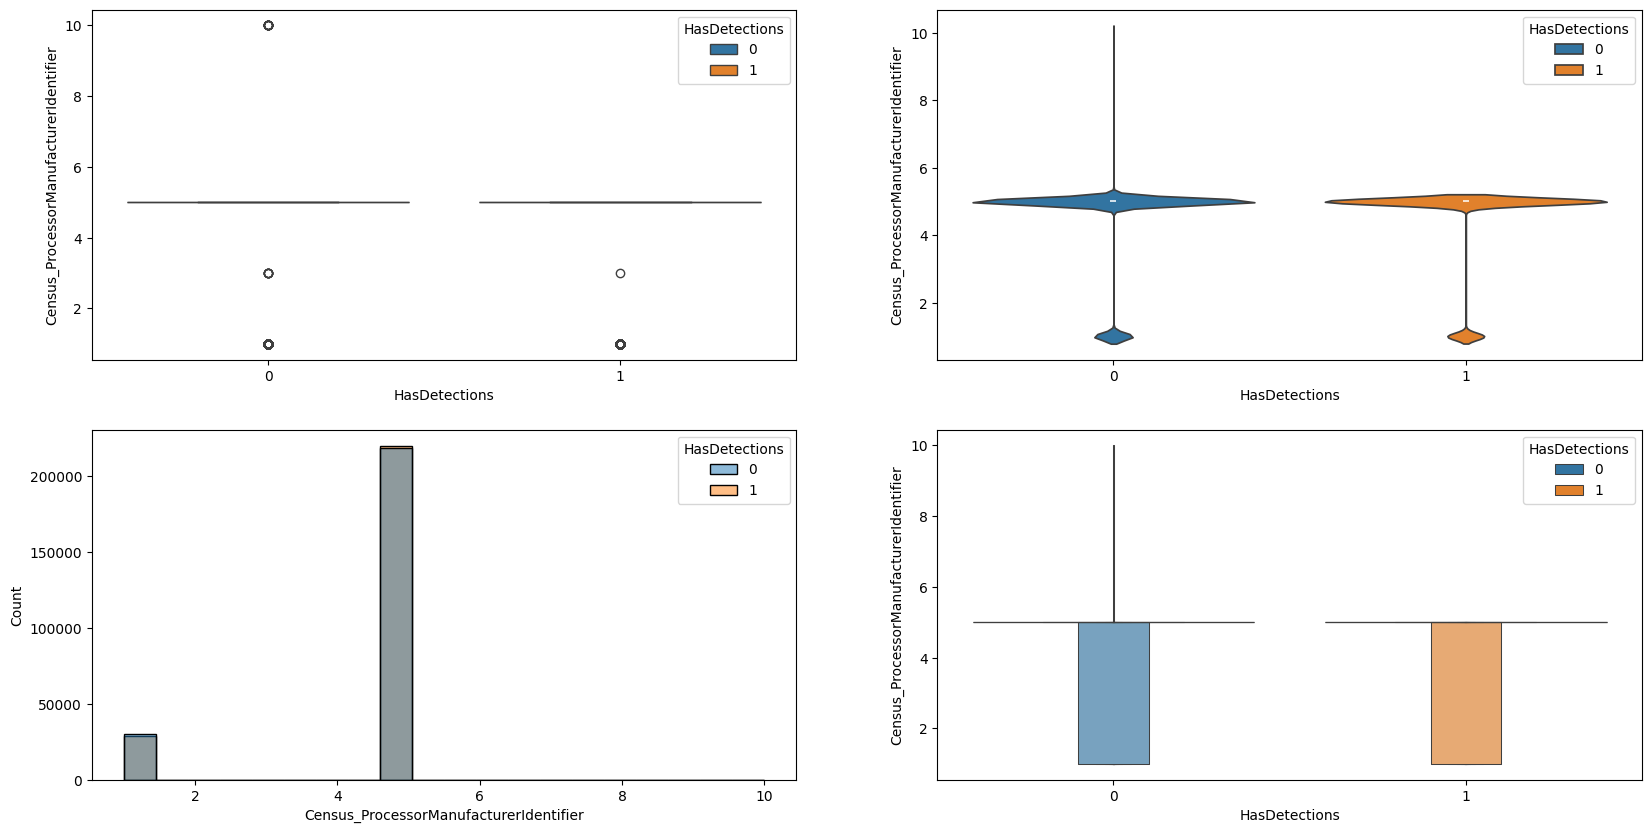

In [59]:
AnalisisAtributo(df_origin,df_origin.columns[38],tar=TARGET)

#### 3.39.- Census_ProcessorModelIdentifier

Atributo Numérico
El atributo 'Census_ProcessorModelIdentifier' tiene 2349 valores nulos (0.47%)

Descripción estadístiica:
count   497,651.00
mean      2,370.99
std         842.14
min           3.00
25%       1,998.00
50%       2,500.00
75%       2,877.00
max       4,472.00
Name: Census_ProcessorModelIdentifier, dtype: float64

El atributo tiene 2243 valores únicos

TOP 10 porcentaje de valores únicos:
Census_ProcessorModelIdentifier
2,697.00   3.24
1,998.00   2.97
2,660.00   2.15
2,373.00   1.98
1,992.00   1.90
2,382.00   1.90
2,640.00   1.70
2,097.00   1.49
1,985.00   1.48
1,848.00   1.39
Name: proportion, dtype: float64


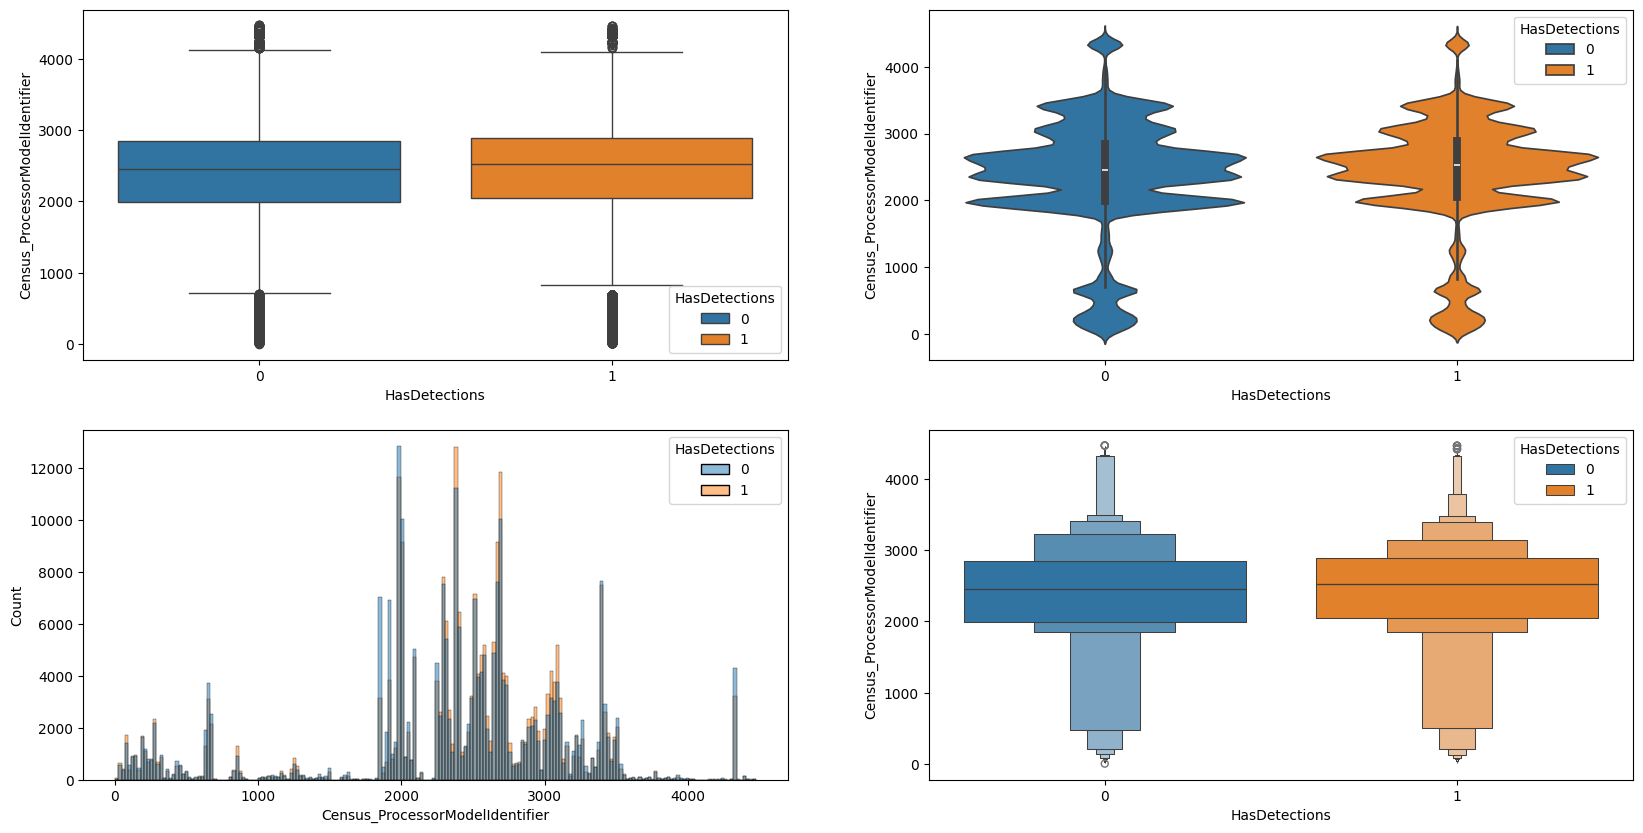

In [60]:
AnalisisAtributo(df_origin,df_origin.columns[39],tar=TARGET)

#### 3.40.- Census_ProcessorClass

Atributo Categórico
El atributo 'Census_ProcessorClass' tiene 497918 valores nulos (99.58%)

Descripción estadístiica:

count     2082
unique       3
top        mid
freq      1196
Name: Census_ProcessorClass, dtype: object


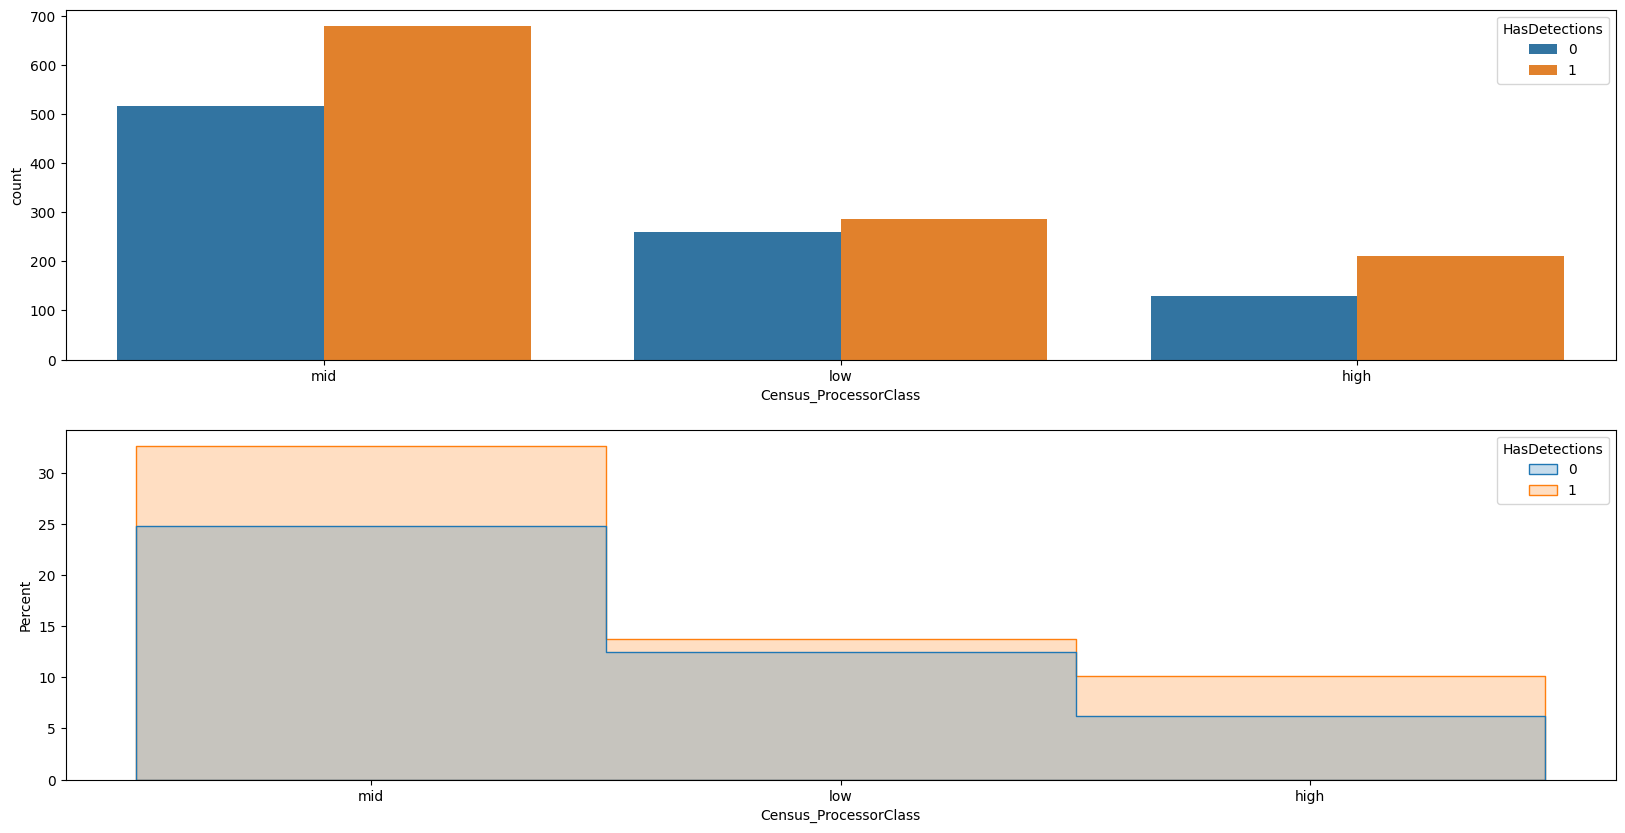

Equipos  Proporcion_Equipos  Infectados  \
Census_ProcessorClass                                            
NaN                     497918               99.58      248776   
mid                       1196                0.24         679   
low                        546                0.11         287   
high                       340                0.07         211   

                       Proporcion_Infectados  
Census_ProcessorClass                         
NaN                                    49.96  
mid                                    56.77  
low                                    52.56  
high                                   62.06

In [61]:
AnalisisAtributo(df_origin,df_origin.columns[40],tar=TARGET)

#### 3.41.- Census_PrimaryDiskTotalCapacity

Atributo Numérico
El atributo 'Census_PrimaryDiskTotalCapacity' tiene 2976 valores nulos (0.6%)

Descripción estadístiica:
count      497,024.00
mean       514,043.32
std        370,446.82
min         10,240.00
25%        239,372.00
50%        476,940.00
75%        953,869.00
max     47,687,668.00
Name: Census_PrimaryDiskTotalCapacity, dtype: float64

El atributo tiene 1103 valores únicos

TOP 10 porcentaje de valores únicos:
Census_PrimaryDiskTotalCapacity
476,940.00   31.74
953,869.00   24.44
305,245.00    5.34
122,104.00    5.29
244,198.00    5.03
238,475.00    3.52
29,820.00     3.41
114,473.00    2.92
715,404.00    2.75
228,936.00    1.80
Name: proportion, dtype: float64


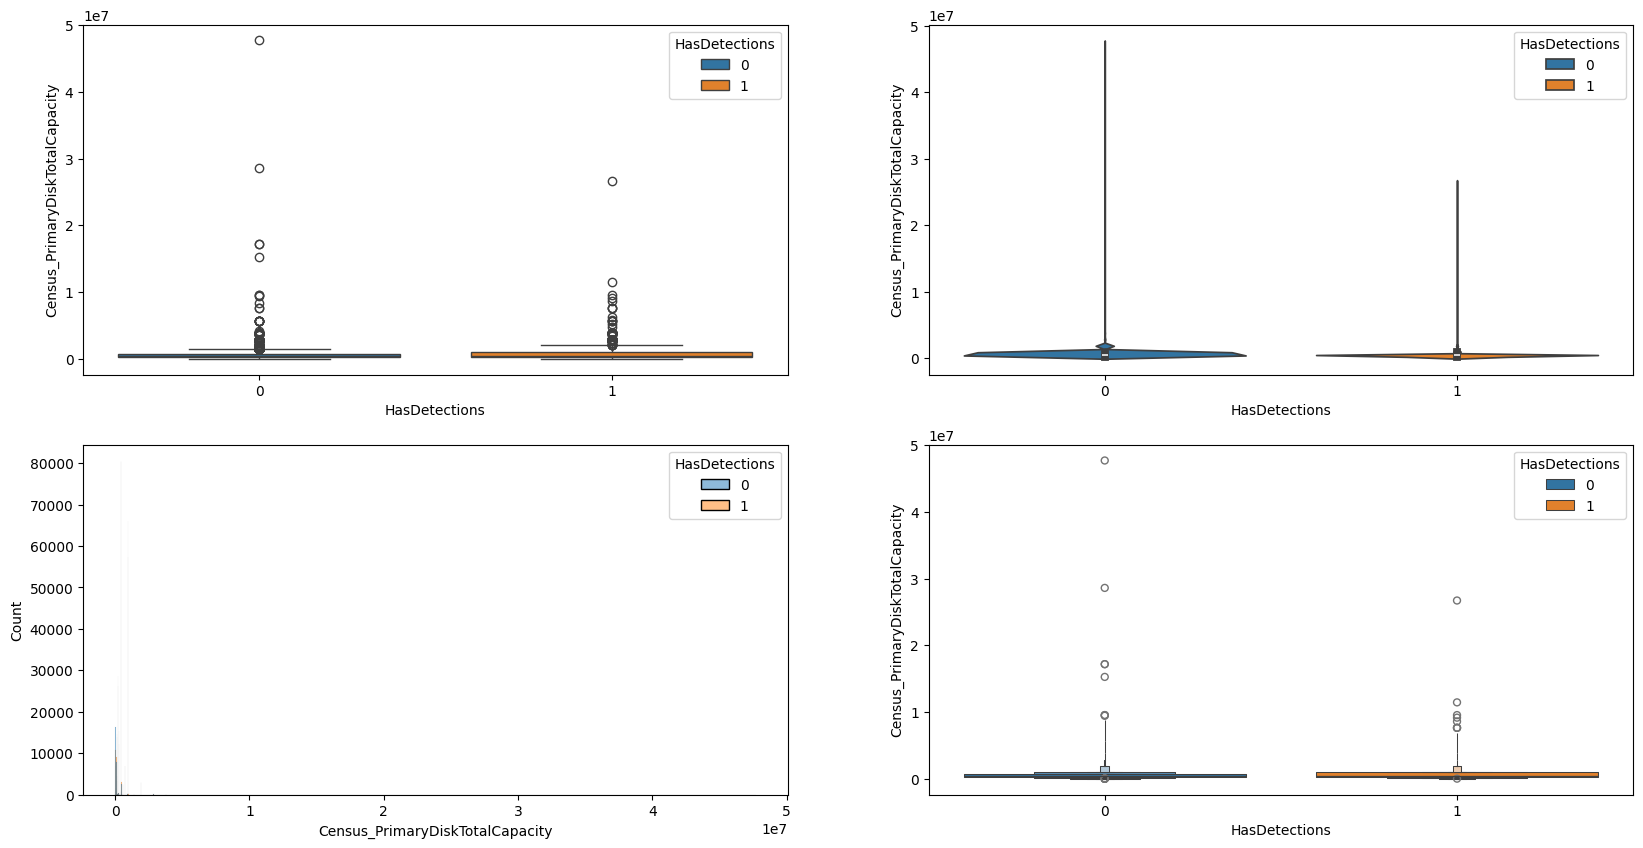

In [62]:
AnalisisAtributo(df_origin,df_origin.columns[41],tar=TARGET)

#### 3.42.- Census_PrimaryDiskTypeName

Atributo Categórico
El atributo 'Census_PrimaryDiskTypeName' tiene 709 valores nulos (0.14%)

Descripción estadístiica:

count     499291
unique         4
top          HDD
freq      325429
Name: Census_PrimaryDiskTypeName, dtype: object


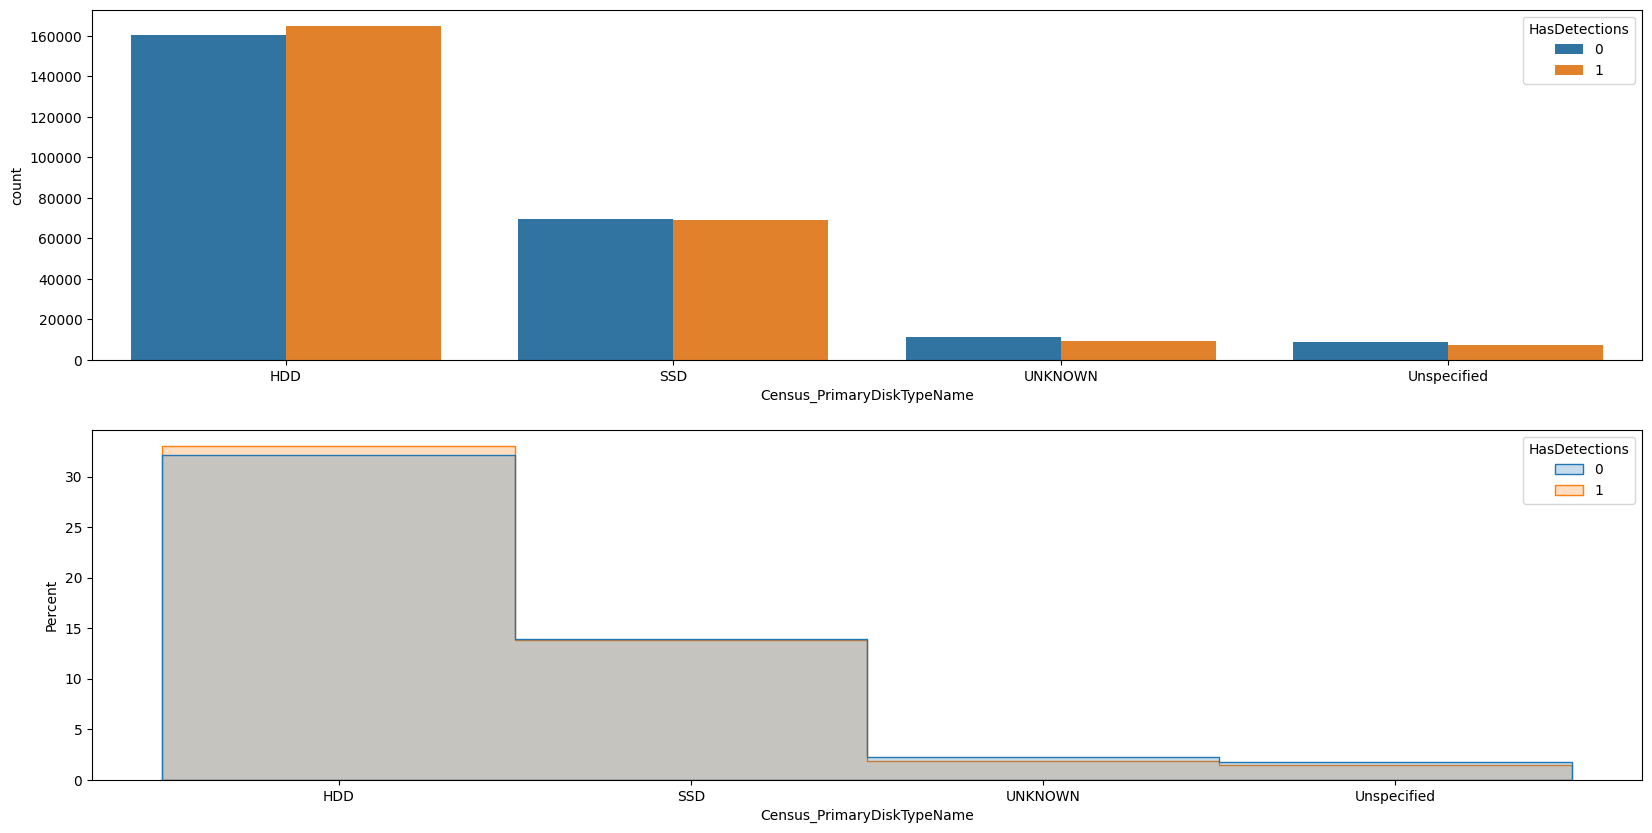

Equipos  Proporcion_Equipos  Infectados  \
Census_PrimaryDiskTypeName                                            
HDD                          325429               65.09      164762   
SSD                          138155               27.63       68821   
UNKNOWN                       20083                4.02        9019   
Unspecified                   15624                3.12        7000   
NaN                             709                0.14         351   

                            Proporcion_Infectados  
Census_PrimaryDiskTypeName                         
HDD                                         50.63  
SSD                                         49.81  
UNKNOWN                                     44.91  
Unspecified                                 44.80  
NaN                                         49.51

In [63]:
AnalisisAtributo(df_origin,df_origin.columns[42],tar=TARGET)

#### 3.43.- Census_SystemVolumeTotalCapacity

Atributo Numérico
El atributo 'Census_SystemVolumeTotalCapacity' tiene 2976 valores nulos (0.6%)

Descripción estadístiica:
count      497,024.00
mean       378,054.64
std        338,472.22
min          9,689.00
25%        120,775.00
50%        249,450.00
75%        475,981.00
max     47,687,100.00
Name: Census_SystemVolumeTotalCapacity, dtype: float64

El atributo tiene 142051 valores únicos

TOP 10 porcentaje de valores únicos:
Census_SystemVolumeTotalCapacity
NaN          0.60
28,542.00    0.58
926,992.00   0.57
476,389.00   0.48
476,324.00   0.46
102,400.00   0.46
953,253.00   0.45
952,728.00   0.43
476,323.00   0.40
475,799.00   0.40
Name: proportion, dtype: float64


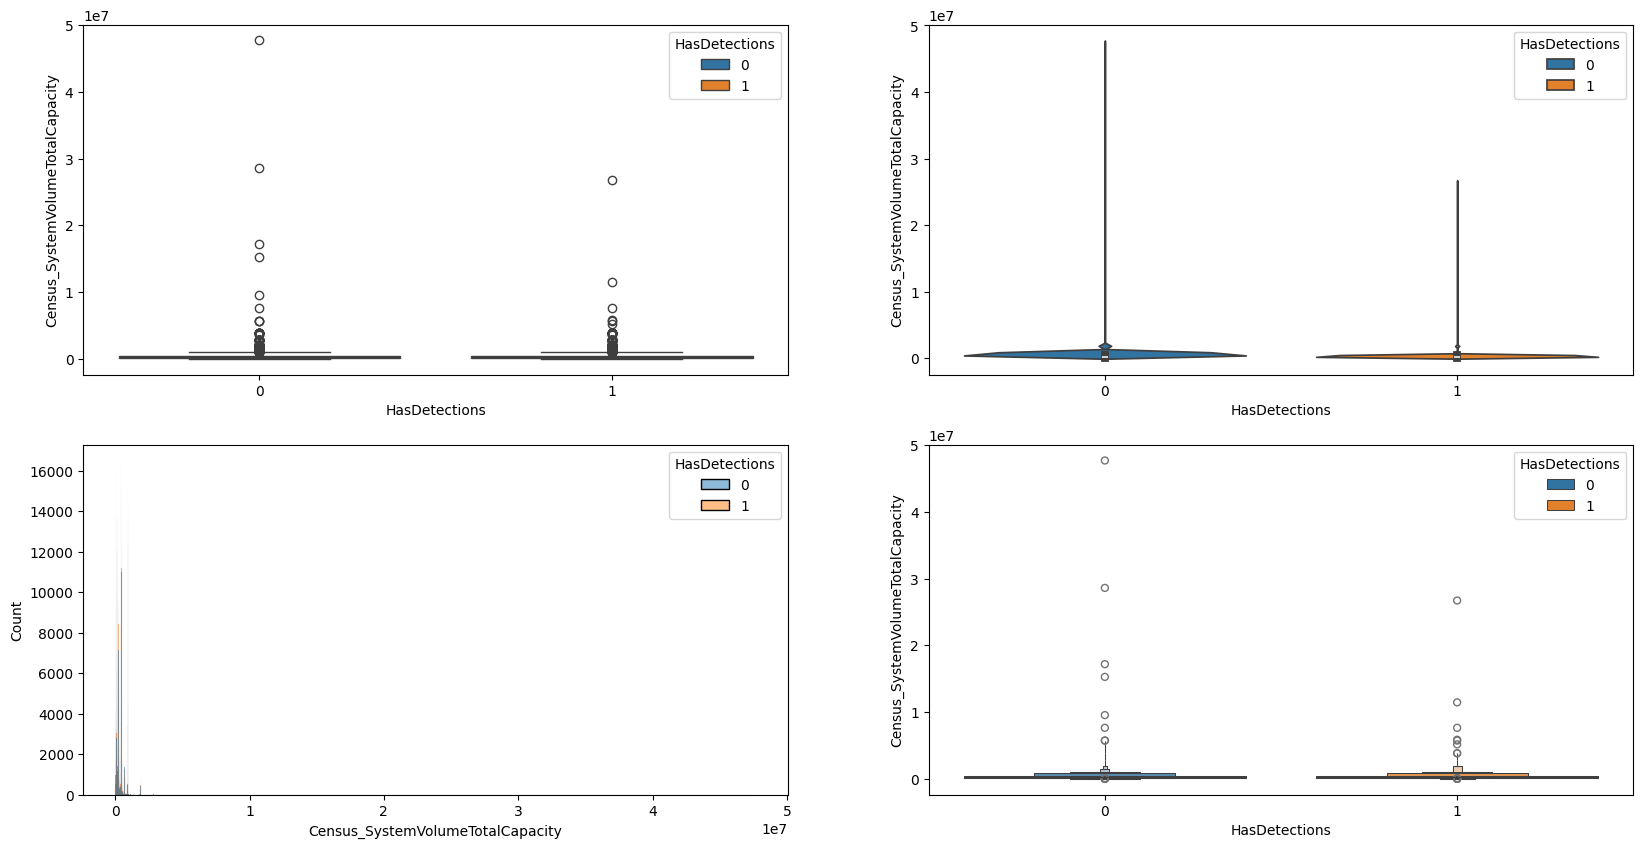

In [64]:
AnalisisAtributo(df_origin,df_origin.columns[43],tar=TARGET)

#### 3.44.- Census_HasOpticalDiskDrive

Atributo Numérico
El atributo 'Census_HasOpticalDiskDrive' tiene 0 valores nulos (0.0%)

Descripción estadístiica:
count   500,000.00
mean          0.08
std           0.27
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           1.00
Name: Census_HasOpticalDiskDrive, dtype: float64

El atributo tiene 2 valores únicos

TOP 10 porcentaje de valores únicos:
Census_HasOpticalDiskDrive
0   92.30
1    7.70
Name: proportion, dtype: float64


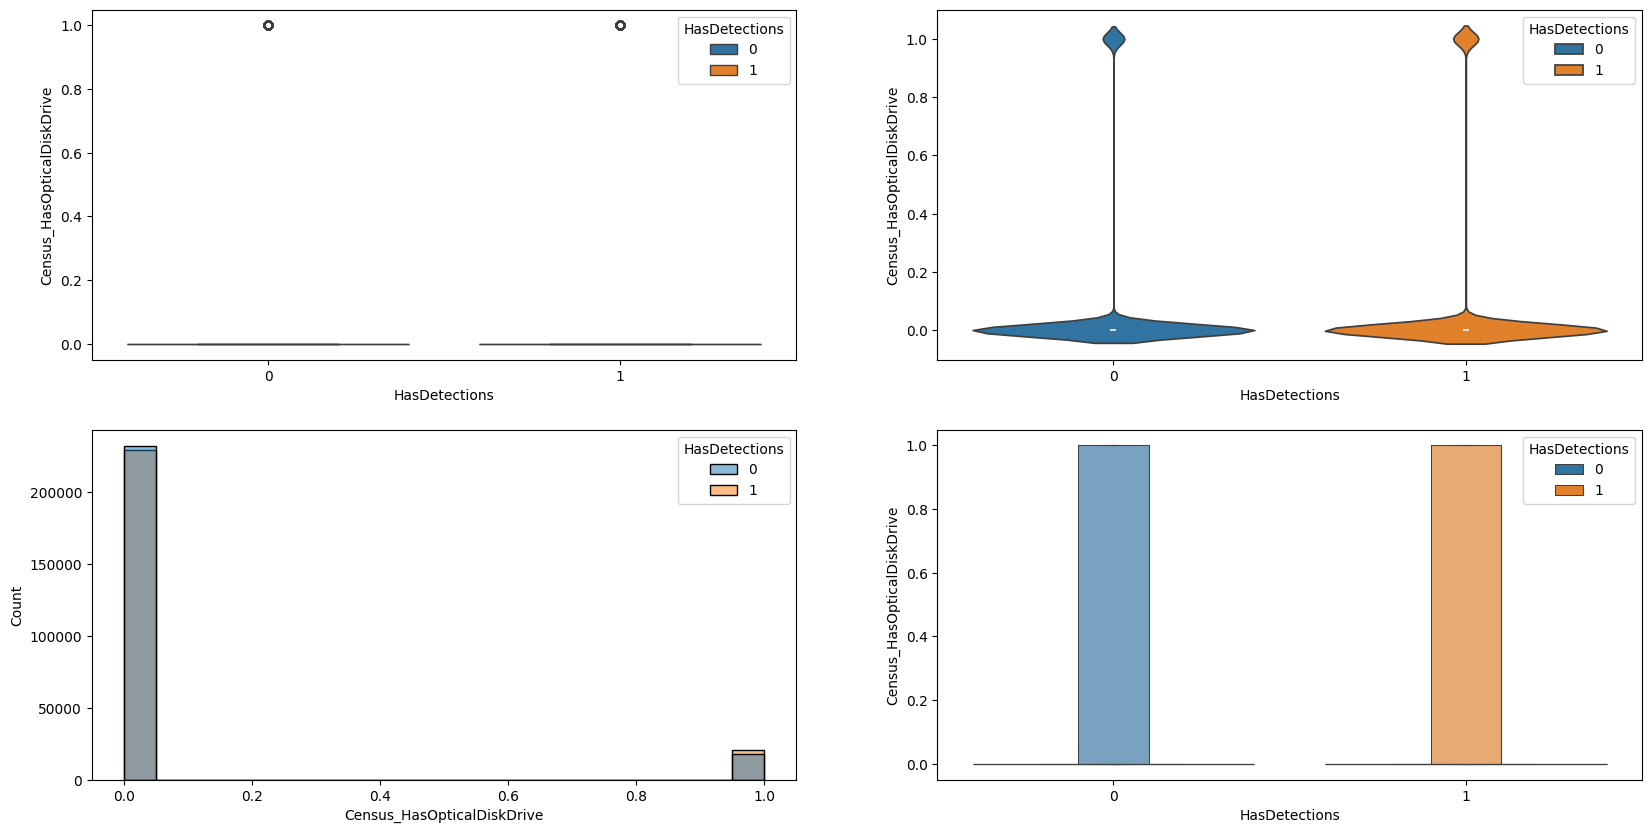

In [65]:
AnalisisAtributo(df_origin,df_origin.columns[44],tar=TARGET)

#### 3.45.- Census_TotalPhysicalRAM

Atributo Numérico
El atributo 'Census_TotalPhysicalRAM' tiene 4556 valores nulos (0.91%)

Descripción estadístiica:
count   495,444.00
mean      6,129.23
std       4,964.52
min         512.00
25%       4,096.00
50%       4,096.00
75%       8,192.00
max     393,216.00
Name: Census_TotalPhysicalRAM, dtype: float64

El atributo tiene 552 valores únicos

TOP 10 porcentaje de valores únicos:
Census_TotalPhysicalRAM
4,096.00    45.74
8,192.00    24.63
2,048.00    12.34
16,384.00    6.04
6,144.00     4.47
12,288.00    1.81
3,072.00     1.69
NaN          0.91
1,024.00     0.72
32,768.00    0.66
Name: proportion, dtype: float64


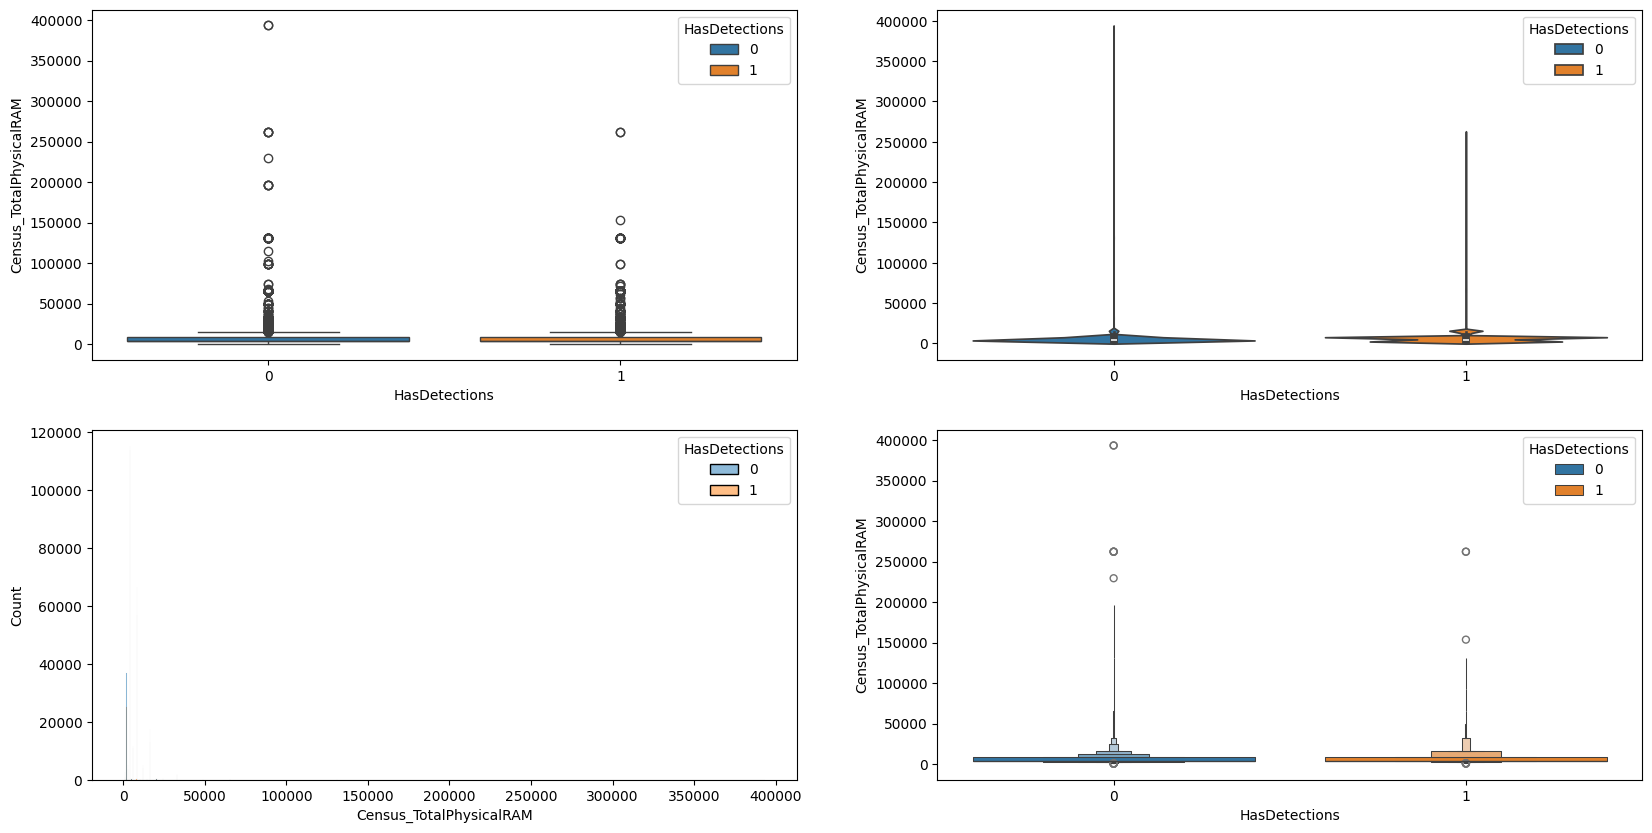

In [66]:
AnalisisAtributo(df_origin,df_origin.columns[45],tar=TARGET)

#### 3.46.- Census_ChassisTypeName

Atributo Categórico
El atributo 'Census_ChassisTypeName' tiene 37 valores nulos (0.01%)

Descripción estadístiica:

count       499963
unique          34
top       Notebook
freq        294232
Name: Census_ChassisTypeName, dtype: object


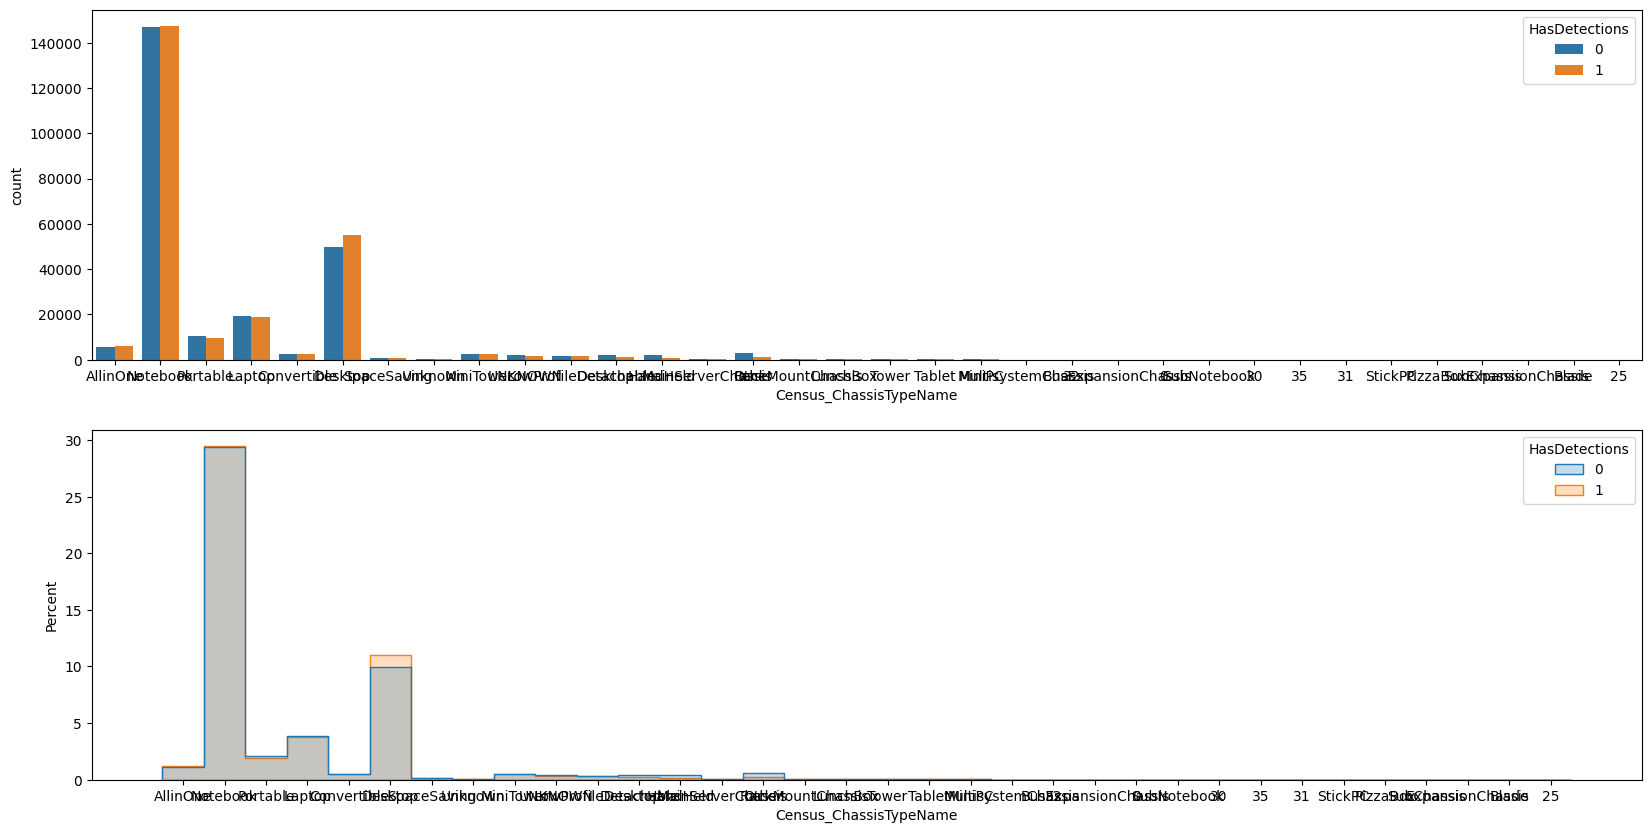

Equipos  Proporcion_Equipos  Infectados  \
Census_ChassisTypeName                                            
Notebook                 294232               58.85      147270   
Desktop                  104979               21.00       55150   
Laptop                    38261                7.65       18864   
Portable                  20181                4.04        9696   
AllinOne                  11407                2.28        5831   
MiniTower                  4849                0.97        2597   
Convertible                4685                0.94        2252   
Other                      4215                0.84        1151   
UNKNOWN                    3695                0.74        1636   
Detachable                 2930                0.59        1020   
LowProfileDesktop          2878                0.58        1481   
HandHeld                   2652                0.53         784   
SpaceSaving                1689                0.34         807   
Tablet                      730                0.15         263   
Tower                       692                0.14         362   
Unknown                     575                0.12         247   
MainServerChassis           512                0.10         228   
MiniPC                      261                0.05          89   
LunchBox                    224                0.04         102   
RackMountChassis            189                0.04          62   
SubNotebook                  47                0.01          17   
BusExpansionChassis          38                0.01          15   
NaN                          37                0.01          17   
30                           11                0.00           3   
StickPC                       7                0.00           0   
0                             5                0.00           2   
PizzaBox                      3                0.00           1   
MultisystemChassis            3                0.00           1   
Blade                         3                0.00           0   
35                            3                0.00           1   
SubChassis                    2                0.00           1   
31                            2                0.00           2   
25                            1                0.00           0   
ExpansionChassis              1                0.00           0   
32                            1                0.00           1   

                        Proporcion_Infectados  
Census_ChassisTypeName                         
Notebook                                50.05  
Desktop                                 52.53  
Laptop                                  49.30  
Portable                                48.05  
AllinOne                                51.12  
MiniTower                               53.56  
Convertible                             48.07  
Other                                   27.31  
UNKNOWN                                 44.28  
Detachable                              34.81  
LowProfileDesktop                       51.46  
HandHeld                                29.56  
SpaceSaving                             47.78  
Tablet                                  36.03  
Tower                                   52.31  
Unknown                                 42.96  
MainServerChassis                       44.53  
MiniPC                                  34.10  
LunchBox                                45.54  
RackMountChassis                        32.80  
SubNotebook                             36.17  
BusExpansionChassis                     39.47  
NaN                                     45.95  
30                                      27.27  
StickPC                                  0.00  
0                                       40.00  
PizzaBox                                33.33  
MultisystemChassis                      33.33  
Blade                                    0.00  
35                                      33.33  
SubChass

In [67]:
AnalisisAtributo(df_origin,df_origin.columns[46],tar=TARGET)

#### 3.47.- Census_InternalPrimaryDiagonalDisplaySizeInInches

Atributo Numérico
El atributo 'Census_InternalPrimaryDiagonalDisplaySizeInInches' tiene 2654 valores nulos (0.53%)

Descripción estadístiica:
count   497,346.00
mean         16.69
std           5.93
min           4.90
25%          13.90
50%          15.50
75%          17.20
max         142.00
Name: Census_InternalPrimaryDiagonalDisplaySizeInInches, dtype: float64

El atributo tiene 520 valores únicos

TOP 10 porcentaje de valores únicos:
Census_InternalPrimaryDiagonalDisplaySizeInInches
15.50   34.26
13.90   10.57
14.00    6.10
11.60    3.52
21.50    3.09
13.30    2.76
18.50    2.35
13.20    2.32
23.00    2.15
15.60    2.02
Name: proportion, dtype: float64


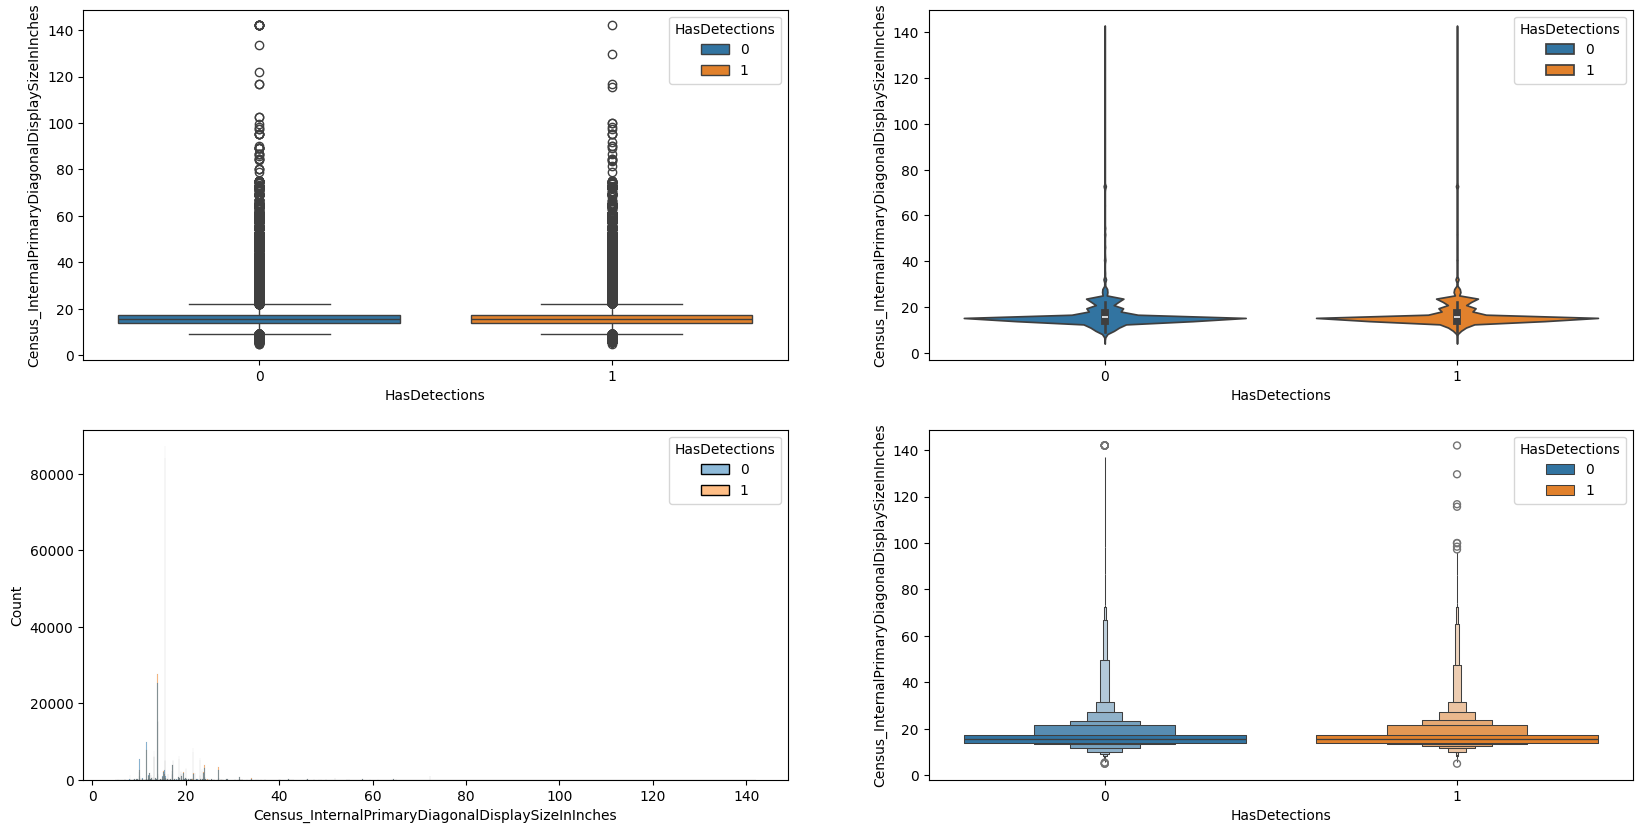

In [68]:
AnalisisAtributo(df_origin,df_origin.columns[47],tar=TARGET)

#### 3.48.- Census_InternalPrimaryDisplayResolutionHorizontal

Atributo Numérico
El atributo 'Census_InternalPrimaryDisplayResolutionHorizontal' tiene 2650 valores nulos (0.53%)

Descripción estadístiica:
count   497,350.00
mean      1,548.30
std         368.57
min          -1.00
25%       1,366.00
50%       1,366.00
75%       1,920.00
max      11,520.00
Name: Census_InternalPrimaryDisplayResolutionHorizontal, dtype: float64

El atributo tiene 474 valores únicos

TOP 10 porcentaje de valores únicos:
Census_InternalPrimaryDisplayResolutionHorizontal
1,366.00   50.40
1,920.00   25.02
1,280.00    5.94
1,600.00    5.65
1,024.00    3.87
1,440.00    1.89
1,360.00    1.41
1,680.00    1.25
2,560.00    0.80
2,736.00    0.63
Name: proportion, dtype: float64


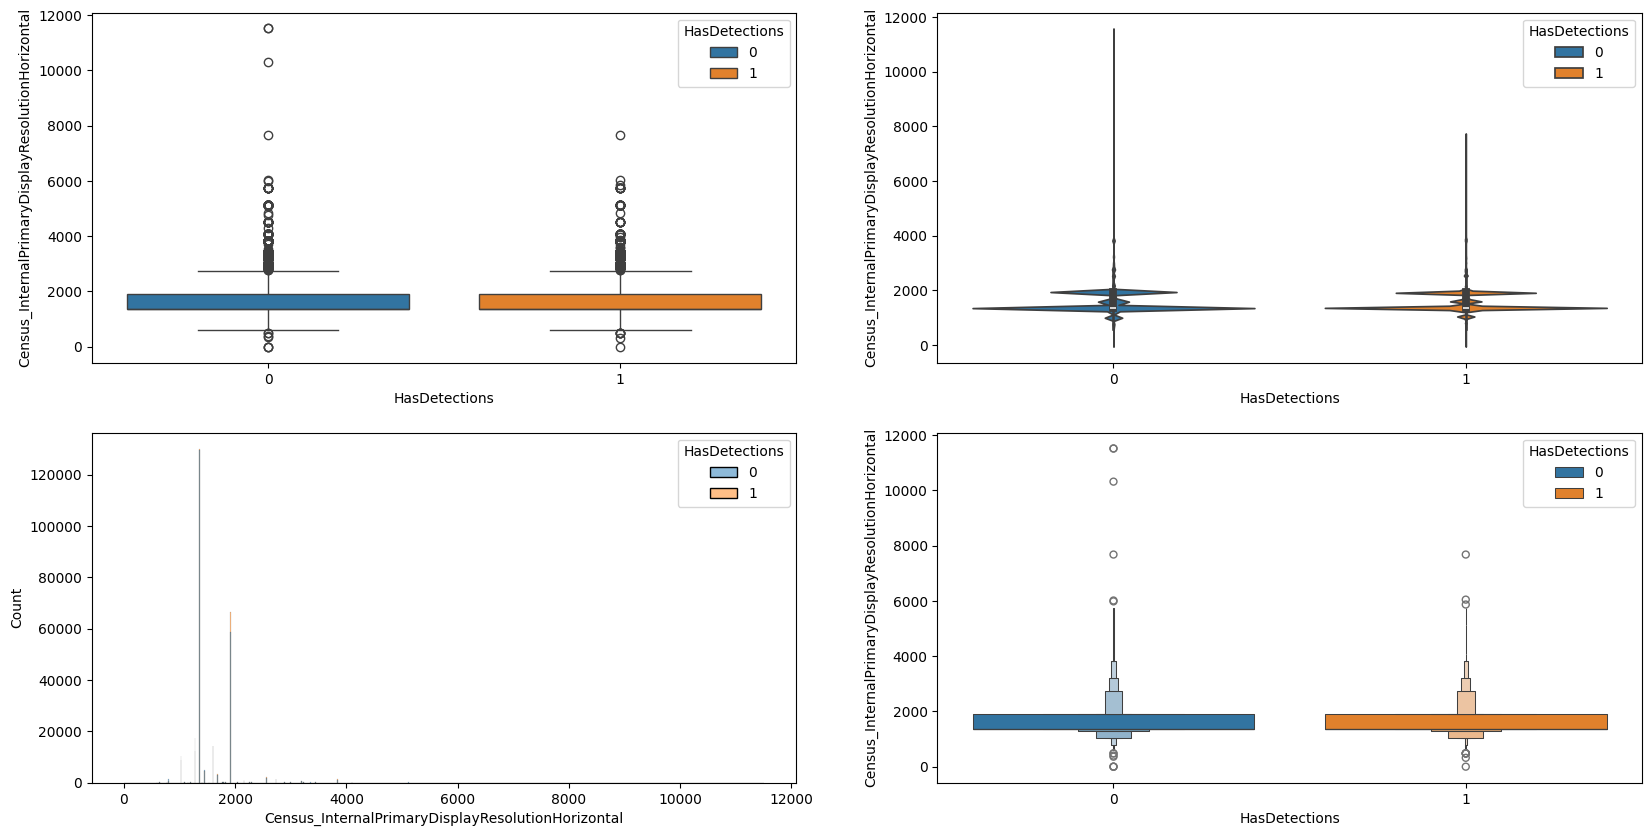

In [69]:
AnalisisAtributo(df_origin,df_origin.columns[48],tar=TARGET)

#### 3.49.- Census_InternalPrimaryDisplayResolutionVertical

Atributo Numérico
El atributo 'Census_InternalPrimaryDisplayResolutionVertical' tiene 2650 valores nulos (0.53%)

Descripción estadístiica:
count   497,350.00
mean        898.24
std         214.86
min          -1.00
25%         768.00
50%         768.00
75%       1,080.00
max       4,320.00
Name: Census_InternalPrimaryDisplayResolutionVertical, dtype: float64

El atributo tiene 514 valores únicos

TOP 10 porcentaje de valores únicos:
Census_InternalPrimaryDisplayResolutionVertical
768.00     55.55
1,080.00   24.23
900.00      7.38
800.00      2.94
1,024.00    2.12
1,050.00    1.28
1,440.00    0.90
1,200.00    0.88
600.00      0.70
1,824.00    0.63
Name: proportion, dtype: float64


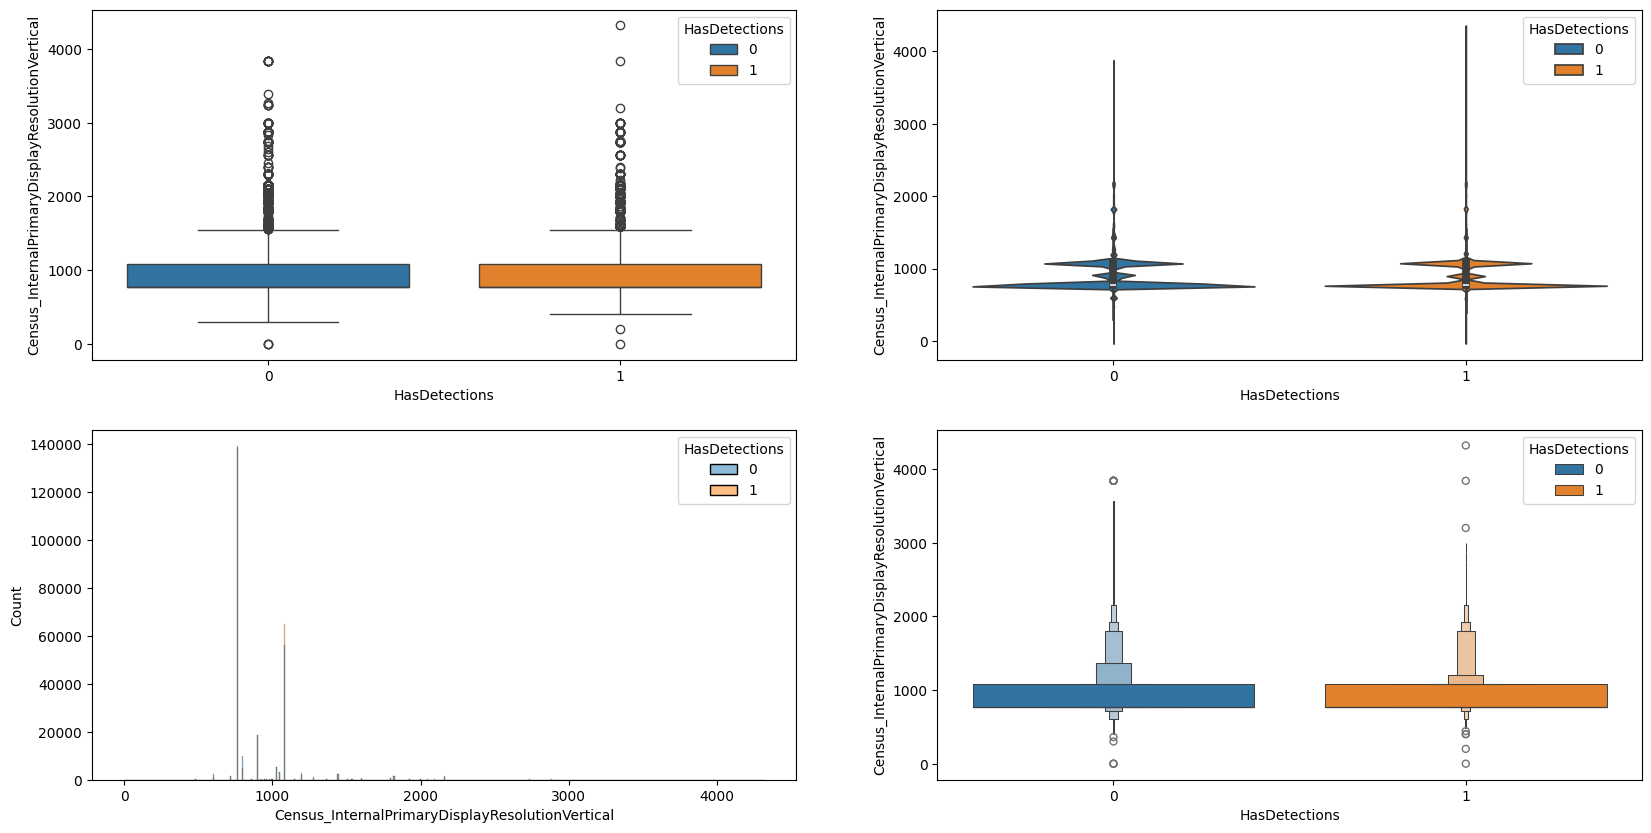

In [70]:
AnalisisAtributo(df_origin,df_origin.columns[49],tar=TARGET)

#### 3.50.- Census_PowerPlatformRoleName

Atributo Categórico
El atributo 'Census_PowerPlatformRoleName' tiene 2 valores nulos (0.0%)

Descripción estadístiica:

count     499998
unique         9
top       Mobile
freq      346378
Name: Census_PowerPlatformRoleName, dtype: object


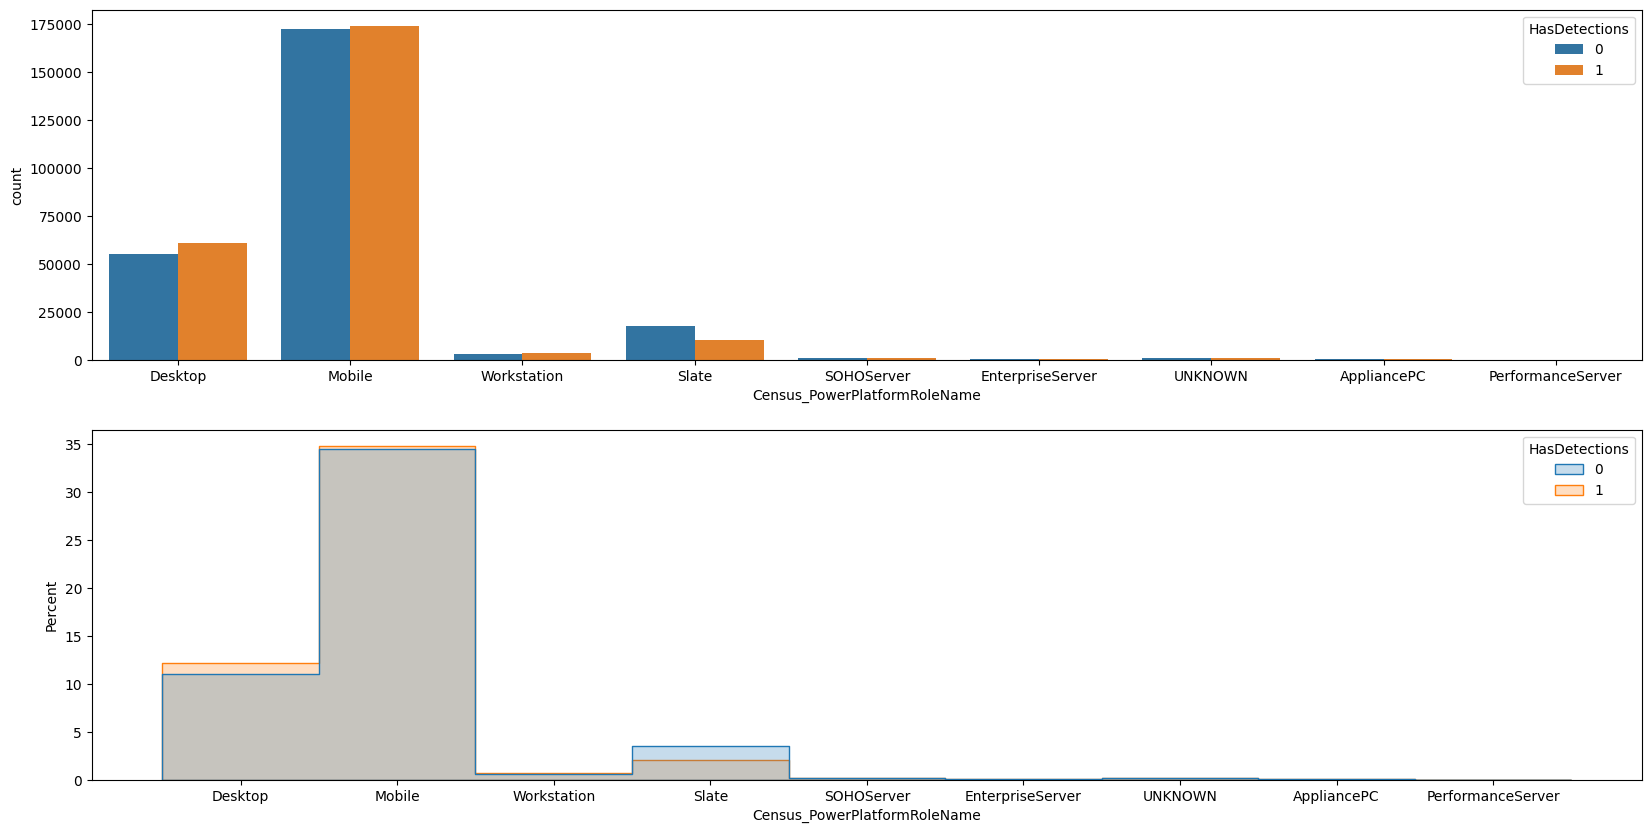

Equipos  Proporcion_Equipos  Infectados  \
Census_PowerPlatformRoleName                                            
Mobile                         346378               69.28      173910   
Desktop                        116054               23.21       60942   
Slate                           27475                5.50       10082   
Workstation                      6235                1.25        3198   
SOHOServer                       2062                0.41        1024   
UNKNOWN                          1172                0.23         571   
EnterpriseServer                  406                0.08         177   
AppliancePC                       212                0.04          46   
PerformanceServer                   4                0.00           3   
NaN                                 2                0.00           0   

                              Proporcion_Infectados  
Census_PowerPlatformRoleName                         
Mobile                                        50.21  
Desktop                                       52.51  
Slate                                         36.70  
Workstation                                   51.29  
SOHOServer                                    49.66  
UNKNOWN                                       48.72  
EnterpriseServer                              43.60  
AppliancePC                                   21.70  
PerformanceServer                             75.00  
NaN                                            0.00

In [71]:
AnalisisAtributo(df_origin,df_origin.columns[50],tar=TARGET)

#### 3.51.- Census_InternalBatteryType

Atributo Categórico
El atributo 'Census_InternalBatteryType' tiene 355603 valores nulos (71.12%)

Descripción estadístiica:

count     144397
unique        28
top         lion
freq      113500
Name: Census_InternalBatteryType, dtype: object


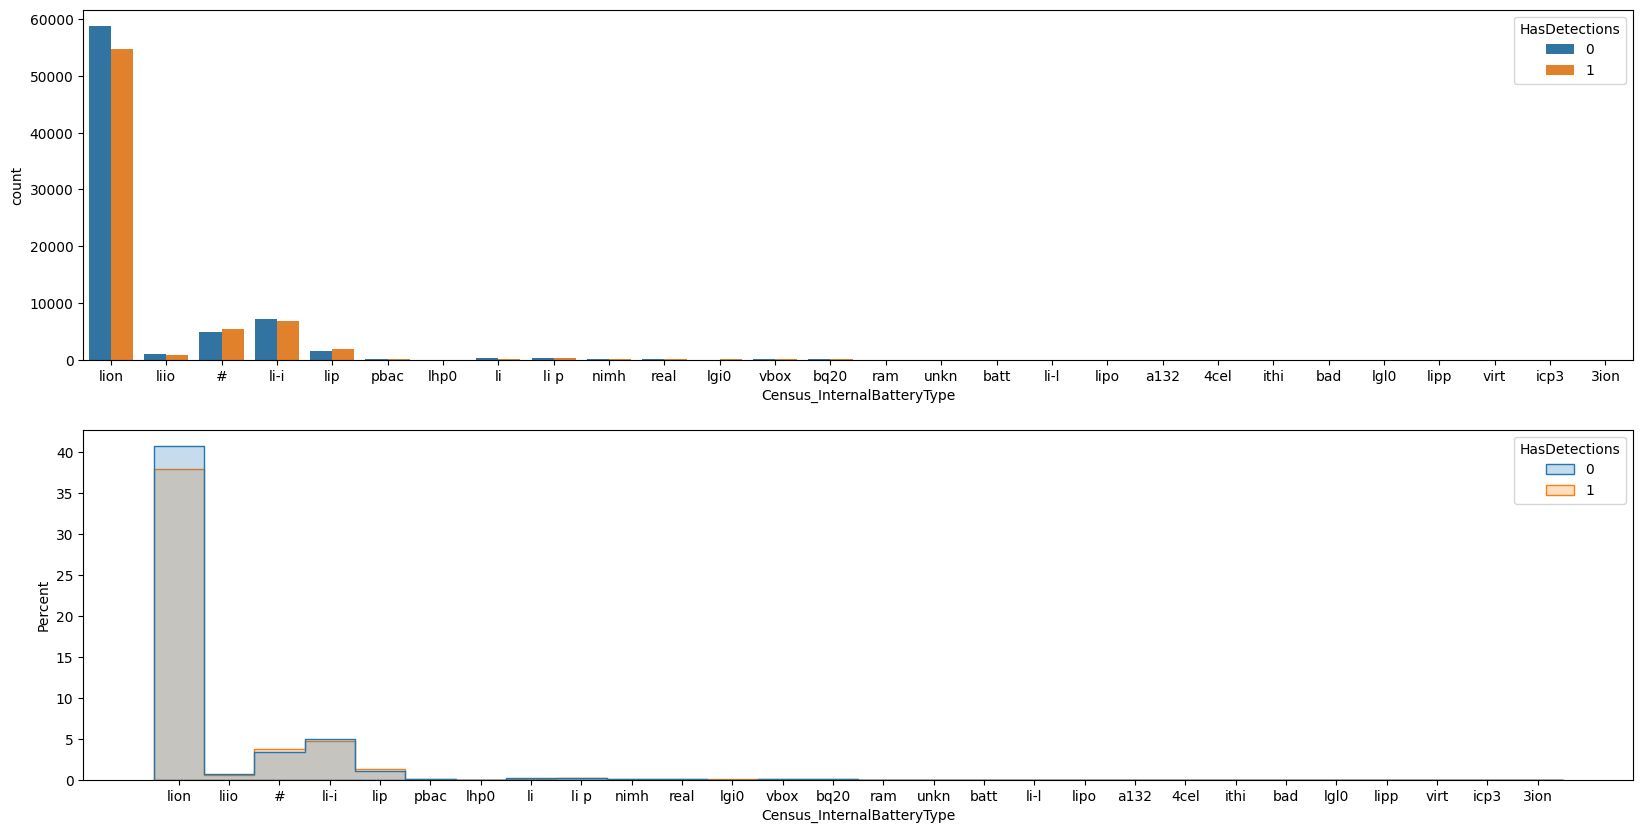

Equipos  Proporcion_Equipos  Infectados  \
Census_InternalBatteryType                                            
NaN                          355603               71.12      179829   
lion                         113500               22.70       54715   
li-i                          13855                2.77        6718   
#                             10176                2.04        5321   
lip                            3326                0.67        1791   
liio                           1814                0.36         830   
li p                            466                0.09         218   
li                              356                0.07         154   
nimh                            272                0.05         118   
real                            162                0.03          85   
bq20                            143                0.03          38   
pbac                            130                0.03          65   
vbox                             89                0.02          22   
lgi0                             29                0.01          17   
unkn                             19                0.00          11   
lipo                             13                0.00           6   
lhp0                             12                0.00           4   
ithi                              7                0.00           2   
4cel                              6                0.00           1   
ram                               5                0.00           1   
batt                              3                0.00           0   
lipp                              3                0.00           2   
bad                               3                0.00           1   
virt                              2                0.00           0   
a132                              2                0.00           1   
icp3                              1                0.00           1   
li-l                              1                0.00           1   
3ion                              1                0.00           0   
lgl0                              1                0.00           1   

                            Proporcion_Infectados  
Census_InternalBatteryType                         
NaN                                         50.57  
lion                                        48.21  
li-i                                        48.49  
#                                           52.29  
lip                                         53.85  
liio                                        45.76  
li p                                        46.78  
li                                          43.26  
nimh                                        43.38  
real                                        52.47  
bq20                                        26.57  
pbac                                        50.00  
vbox                                        24.72  
lgi0                                        58.62  
unkn                                        57.89  
lipo                                        46.15  
lhp0                                        33.33  
ithi                                        28.57  
4cel                                        16.67  
ram                                         20.00  
batt                                         0.00  
lipp                                        66.67  
bad                                         33.33  
virt                                         0.00  
a132                                        50.00  
icp3                                       100.00  
li-l                                       100.00  
3ion                                         0.00  
lgl0                                       100.00

In [72]:
AnalisisAtributo(df_origin,df_origin.columns[51],tar=TARGET)

#### 3.52.- Census_InternalBatteryNumberOfCharges

Atributo Numérico
El atributo 'Census_InternalBatteryNumberOfCharges' tiene 15038 valores nulos (3.01%)

Descripción estadístiica:
count         484,962.00
mean    1,125,600,150.21
std     1,888,768,455.78
min                 0.00
25%                 0.00
50%                 0.00
75%     4,294,967,295.00
max     4,294,967,295.00
Name: Census_InternalBatteryNumberOfCharges, dtype: float64

El atributo tiene 5248 valores únicos

TOP 10 porcentaje de valores únicos:
Census_InternalBatteryNumberOfCharges
0.00               56.64
4,294,967,295.00   25.29
NaN                 3.01
1.00                0.59
16.00               0.30
2.00                0.30
3.00                0.24
33.00               0.21
4.00                0.20
5.00                0.18
Name: proportion, dtype: float64


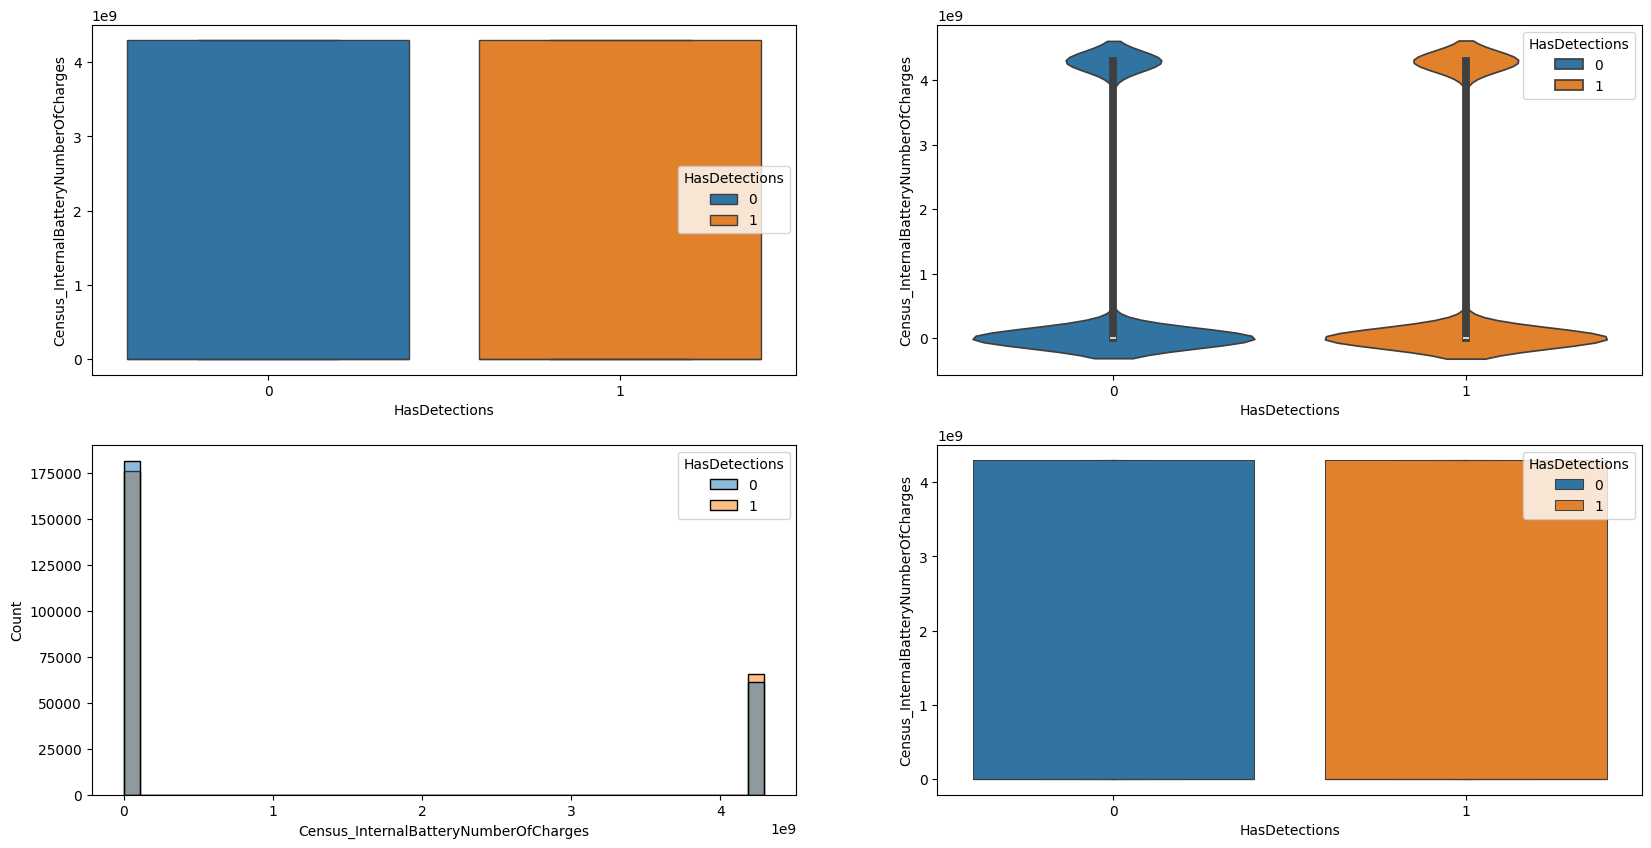

In [73]:
AnalisisAtributo(df_origin,df_origin.columns[52],tar=TARGET)

#### 3.53.- Census_OSVersion

Atributo Categórico
El atributo 'Census_OSVersion' tiene 0 valores nulos (0.0%)

Descripción estadístiica:

count             500000
unique               305
top       10.0.17134.228
freq               79975
Name: Census_OSVersion, dtype: object


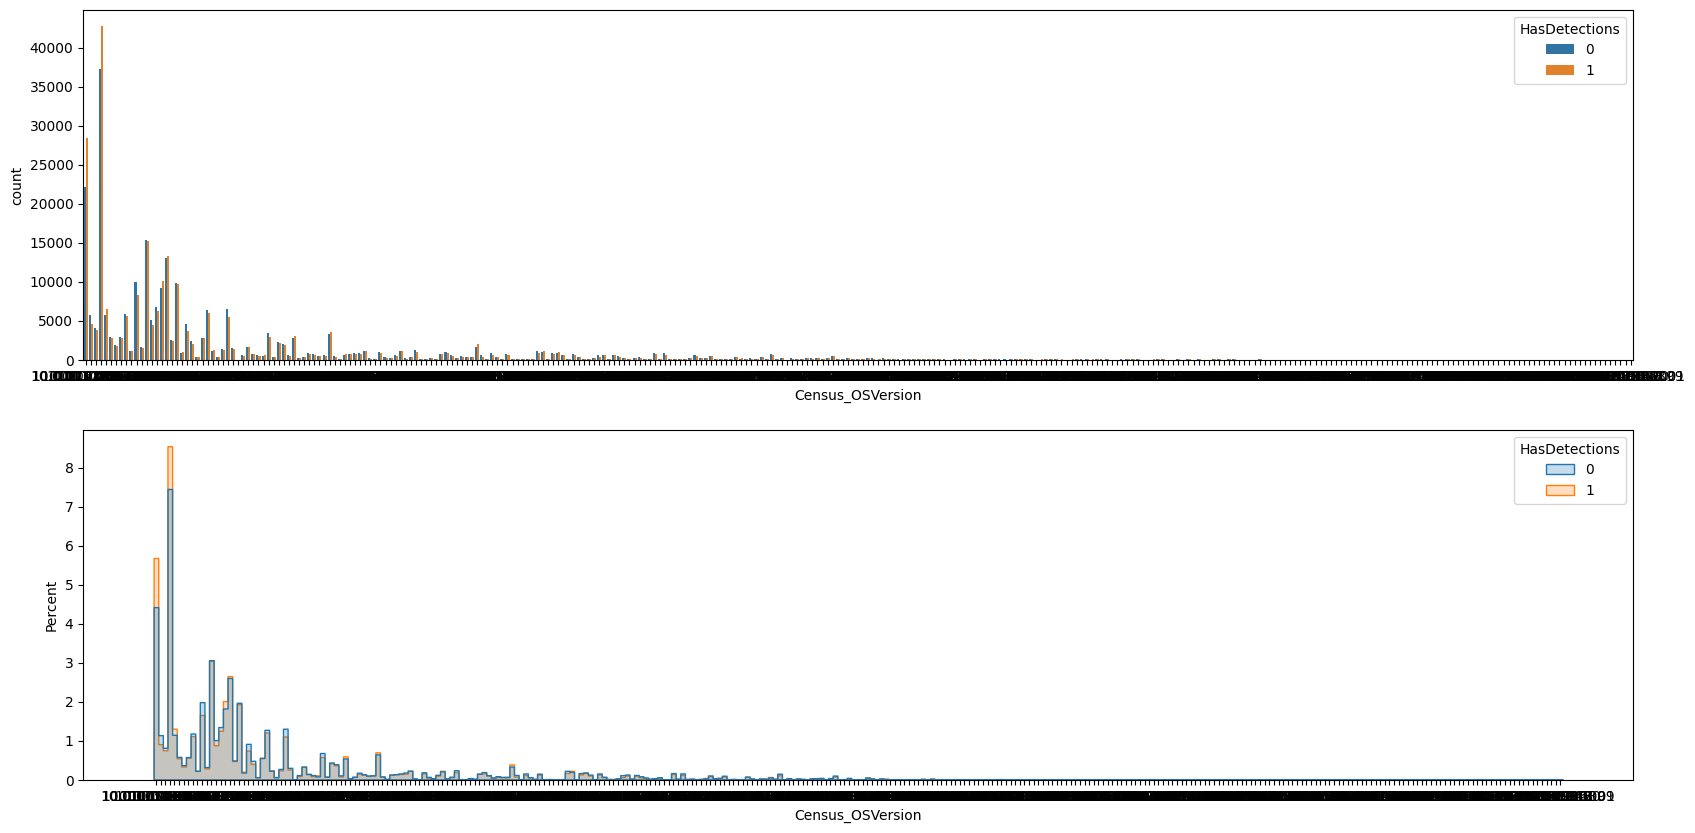

Equipos  Proporcion_Equipos  Infectados  \
Census_OSVersion                                            
10.0.17134.228      79975               16.00       42726   
10.0.17134.165      50511               10.10       28404   
10.0.16299.431      30519                6.10       15207   
10.0.17134.285      26289                5.26       13265   
10.0.17134.112      19501                3.90        9661   
...                   ...                 ...         ...   
10.0.14393.1670         1                0.00           0   
10.0.10240.16399        1                0.00           0   
10.0.17134.281          1                0.00           0   
10.0.17604.1000         1                0.00           1   
6.3.9600.19069          1                0.00           0   

                  Proporcion_Infectados  
Census_OSVersion                         
10.0.17134.228                    53.42  
10.0.17134.165                    56.23  
10.0.16299.431                    49.83  
10.0.17134.285                    50.46  
10.0.17134.112                    49.54  
...                                 ...  
10.0.14393.1670                    0.00  
10.0.10240.16399                   0.00  
10.0.17134.281                     0.00  
10.0.17604.1000                  100.00  
6.3.9600.19069                     0.00  

[305 rows x 4 columns]

In [74]:
AnalisisAtributo(df_origin,df_origin.columns[53],tar=TARGET)

#### 3.54.- Census_OSArchitecture

Atributo Categórico
El atributo 'Census_OSArchitecture' tiene 0 valores nulos (0.0%)

Descripción estadístiica:

count     500000
unique         3
top        amd64
freq      454435
Name: Census_OSArchitecture, dtype: object


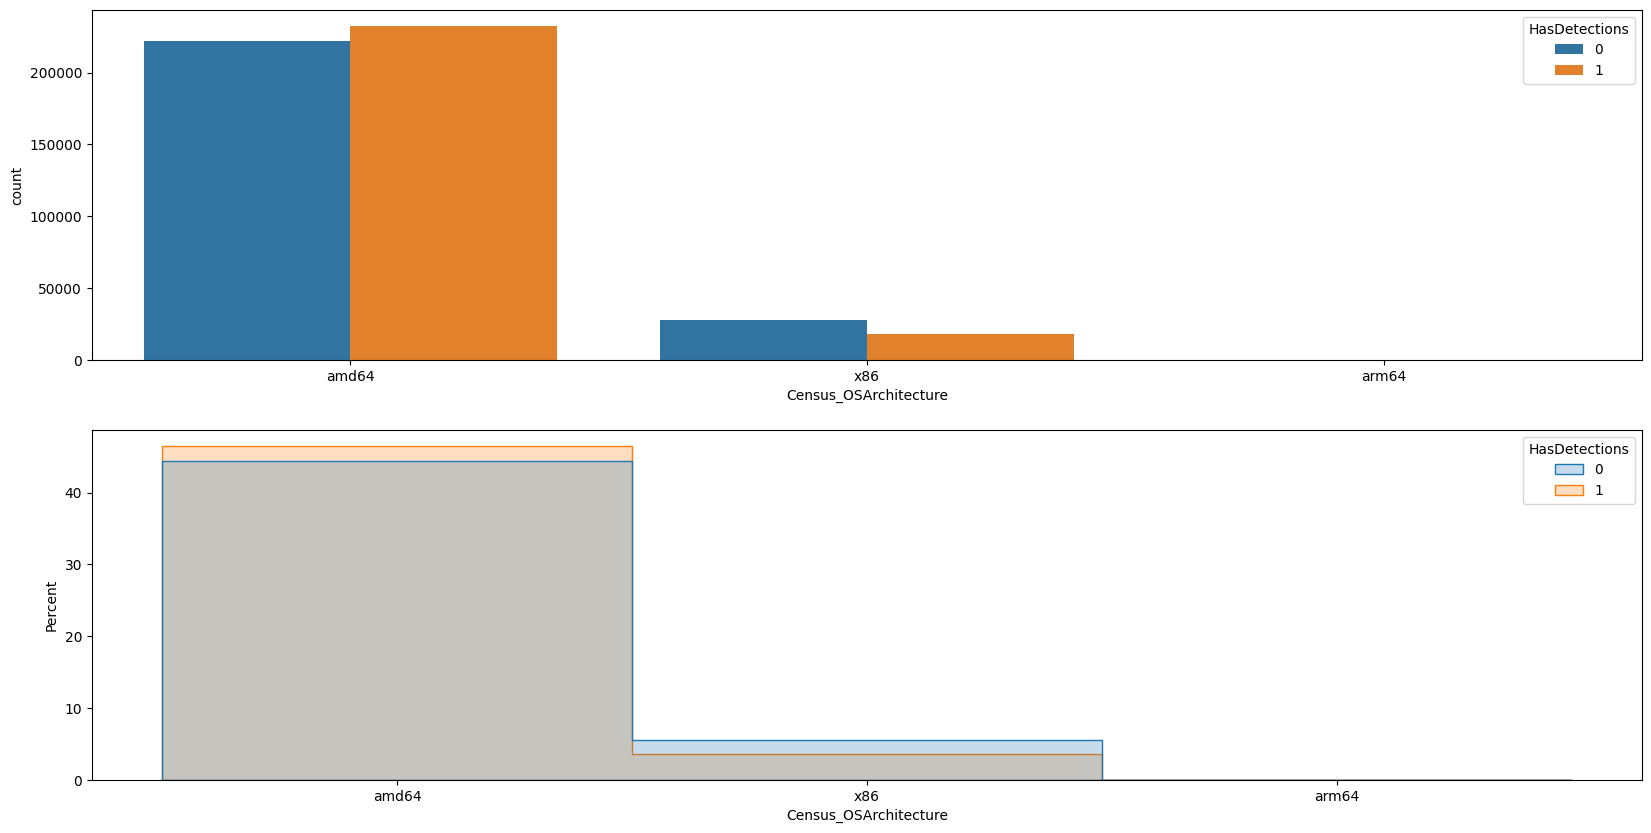

Equipos  Proporcion_Equipos  Infectados  \
Census_OSArchitecture                                            
amd64                   454435               90.89      232267   
x86                      45551                9.11       17686   
arm64                       14                0.00           0   

                       Proporcion_Infectados  
Census_OSArchitecture                         
amd64                                  51.11  
x86                                    38.83  
arm64                                   0.00

In [75]:
AnalisisAtributo(df_origin,df_origin.columns[54],tar=TARGET)

#### 3.55.- Census_OSBranch

Atributo Categórico
El atributo 'Census_OSBranch' tiene 0 valores nulos (0.0%)

Descripción estadístiica:

count          500000
unique             15
top       rs4_release
freq           226001
Name: Census_OSBranch, dtype: object


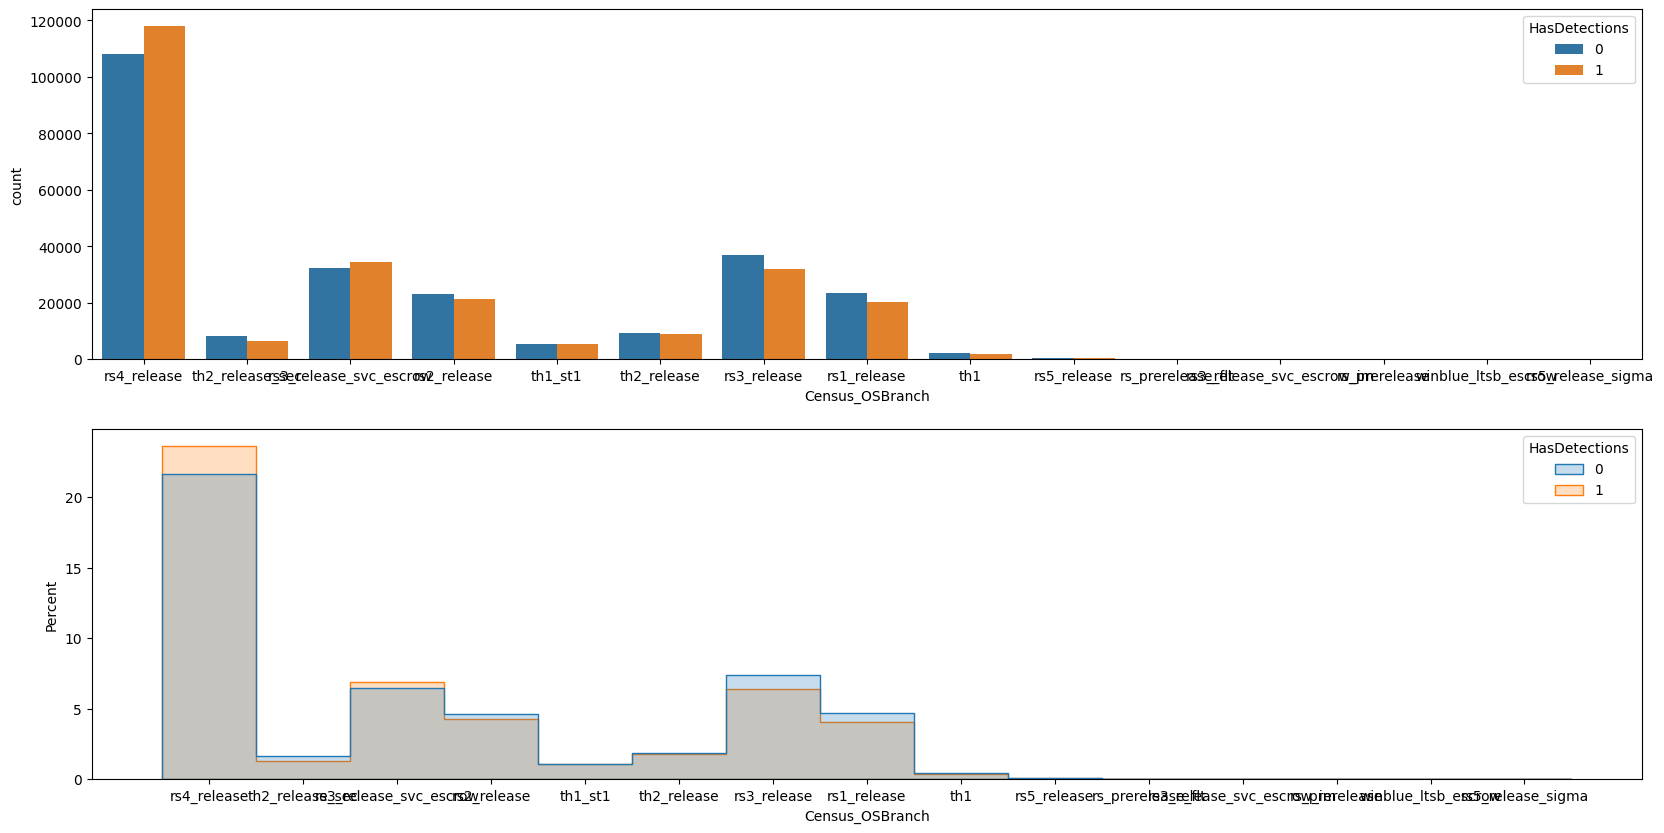

Equipos  Proporcion_Equipos  Infectados  \
Census_OSBranch                                                      
rs4_release                 226001               45.20      118008   
rs3_release                  69216               13.84       32176   
rs3_release_svc_escrow       67027               13.41       34572   
rs2_release                  44264                8.85       21230   
rs1_release                  43705                8.74       20322   
th2_release                  18298                3.66        9022   
th2_release_sec              14895                2.98        6638   
th1_st1                      10822                2.16        5451   
th1                           4284                0.86        1892   
rs5_release                    839                0.17         364   
rs3_release_svc_escrow_im      329                0.07         132   
rs_prerelease                  184                0.04          76   
rs_prerelease_flt              132                0.03          69   
rs5_release_sigma                3                0.00           1   
winblue_ltsb_escrow              1                0.00           0   

                           Proporcion_Infectados  
Census_OSBranch                                   
rs4_release                                52.22  
rs3_release                                46.49  
rs3_release_svc_escrow                     51.58  
rs2_release                                47.96  
rs1_release                                46.50  
th2_release                                49.31  
th2_release_sec                            44.57  
th1_st1                                    50.37  
th1                                        44.16  
rs5_release                                43.38  
rs3_release_svc_escrow_im                  40.12  
rs_prerelease                              41.30  
rs_prerelease_flt                          52.27  
rs5_release_sigma                          33.33  
winblue_ltsb_escrow                         0.00

In [76]:
AnalisisAtributo(df_origin,df_origin.columns[55],tar=TARGET)

#### 3.56.- Census_OSBuildNumber

Atributo Numérico
El atributo 'Census_OSBuildNumber' tiene 0 valores nulos (0.0%)

Descripción estadístiica:
count   500,000.00
mean     15,841.37
std       1,959.44
min       9,600.00
25%      15,063.00
50%      16,299.00
75%      17,134.00
max      18,242.00
Name: Census_OSBuildNumber, dtype: float64

El atributo tiene 61 valores únicos

TOP 10 porcentaje de valores únicos:
Census_OSBuildNumber
17134   45.20
16299   27.31
15063    8.85
14393    8.74
10586    6.64
10240    3.02
17738    0.03
17692    0.03
17744    0.03
17758    0.02
Name: proportion, dtype: float64


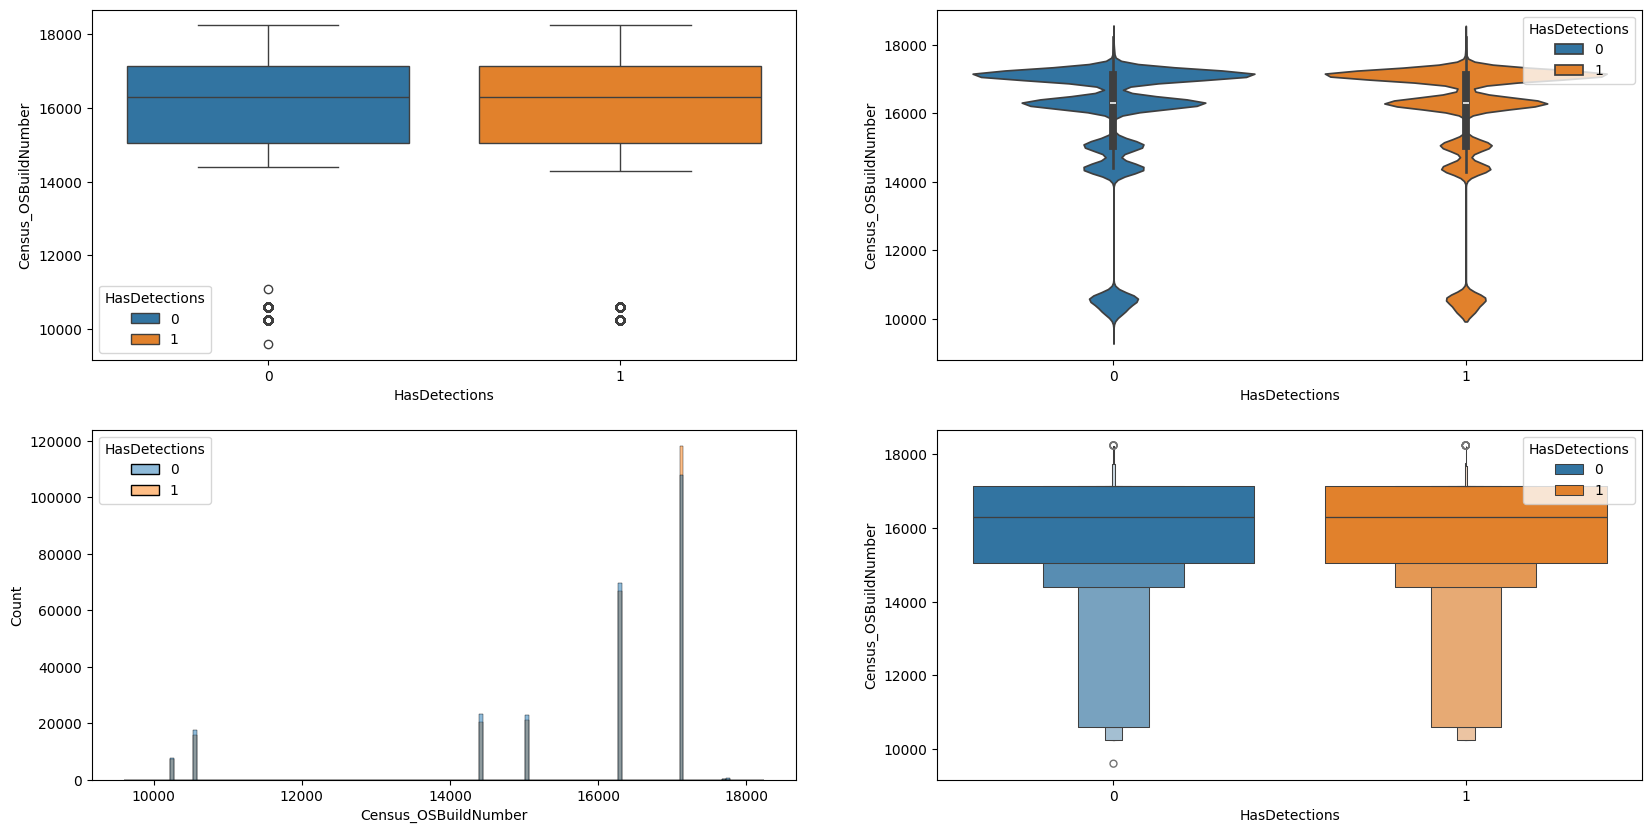

In [77]:
AnalisisAtributo(df_origin,df_origin.columns[56],tar=TARGET)

#### 3.57.- Census_OSBuildRevision

Atributo Numérico
El atributo 'Census_OSBuildRevision' tiene 0 valores nulos (0.0%)

Descripción estadístiica:
count   500,000.00
mean        967.22
std       2,920.63
min           0.00
25%         165.00
50%         285.00
75%         547.00
max      19,069.00
Name: Census_OSBuildRevision, dtype: float64

El atributo tiene 242 valores únicos

TOP 10 porcentaje de valores únicos:
Census_OSBuildRevision
228    16.00
165    10.10
431     6.10
285     5.26
112     3.90
547     3.84
371     3.64
191     2.60
2189    2.48
611     2.45
Name: proportion, dtype: float64


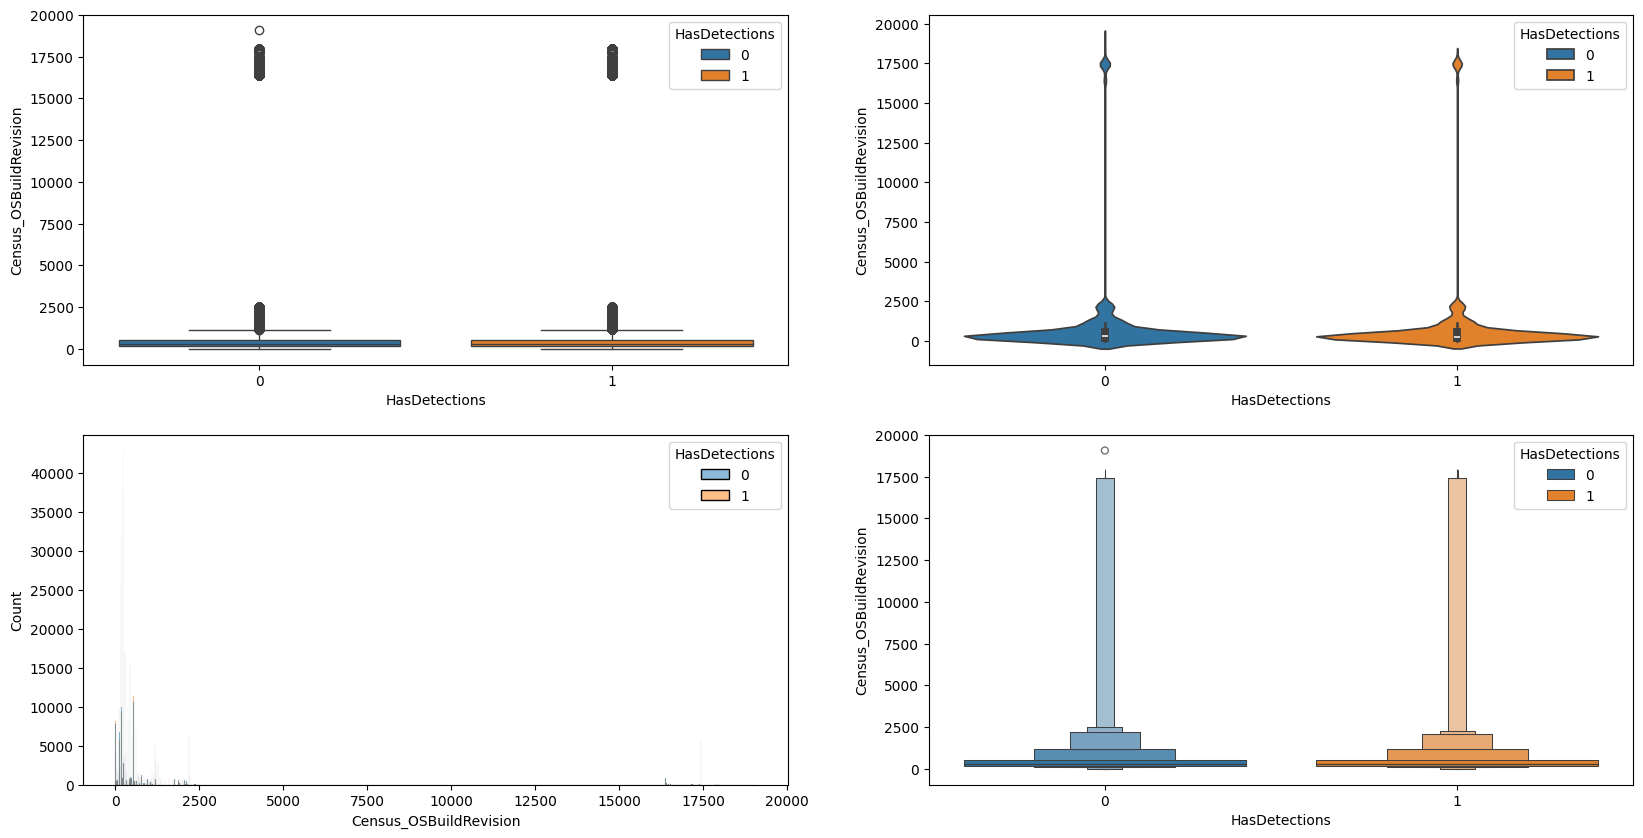

In [78]:
AnalisisAtributo(df_origin,df_origin.columns[57],tar=TARGET)

#### 3.58.- Census_OSEdition

Atributo Categórico
El atributo 'Census_OSEdition' tiene 0 valores nulos (0.0%)

Descripción estadístiica:

count     500000
unique        22
top         Core
freq      194469
Name: Census_OSEdition, dtype: object


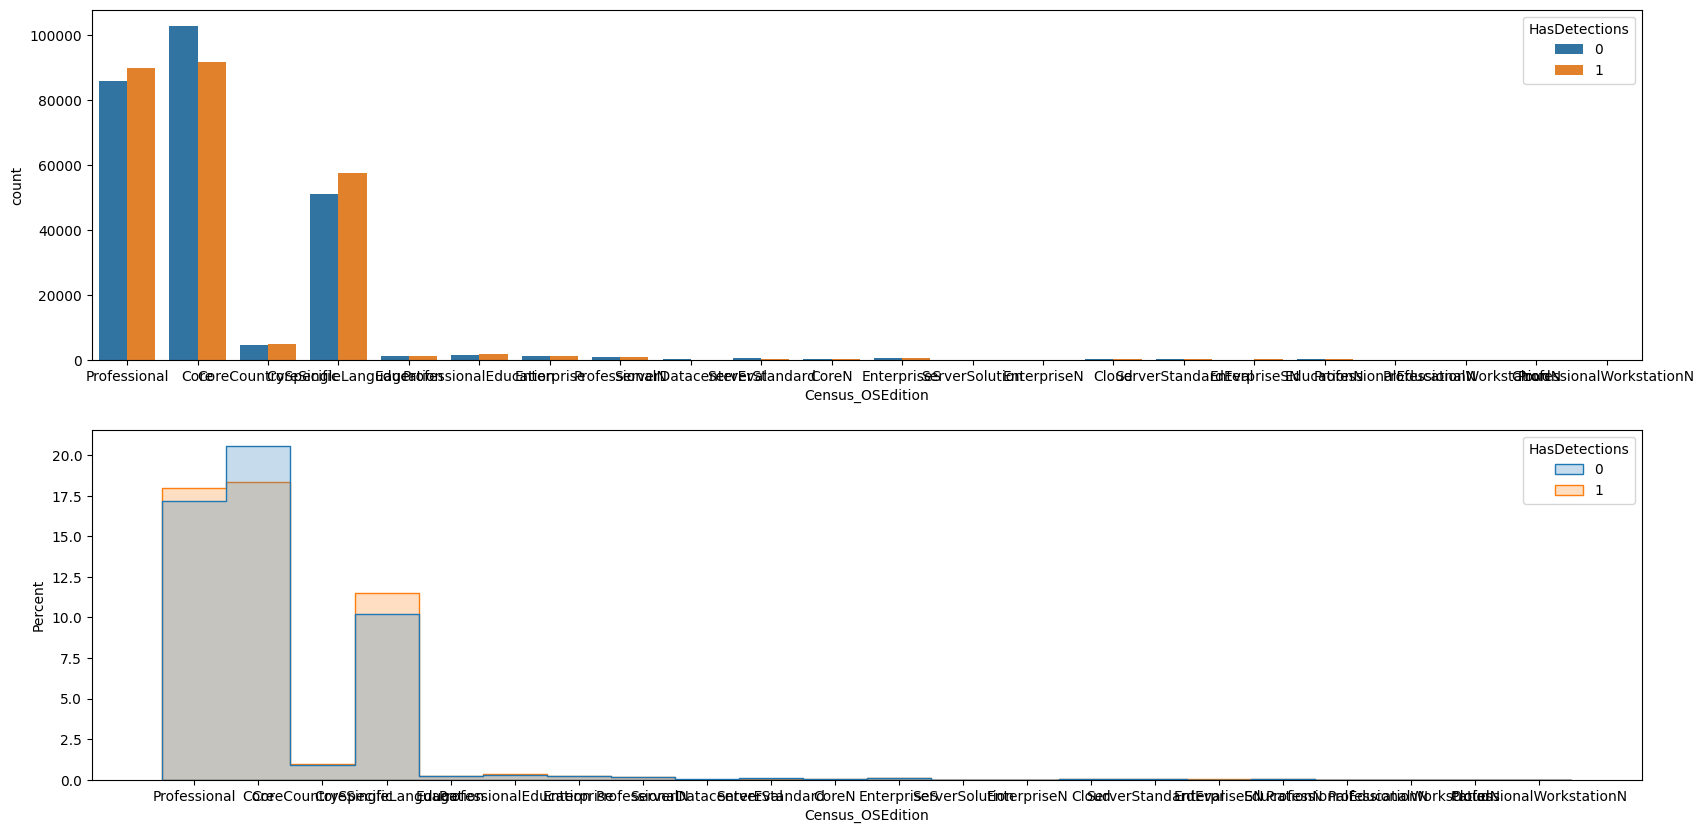

Equipos  Proporcion_Equipos  Infectados  \
Census_OSEdition                                                    
Core                       194469               38.89       91666   
Professional               175808               35.16       89889   
CoreSingleLanguage         108696               21.74       57588   
CoreCountrySpecific          9275                1.86        4755   
ProfessionalEducation        3100                0.62        1695   
Education                    2310                0.46        1210   
Enterprise                   2055                0.41        1065   
ProfessionalN                1624                0.32         873   
EnterpriseS                  1108                0.22         583   
ServerStandard                584                0.12         237   
Cloud                         336                0.07         134   
CoreN                         251                0.05         108   
ServerStandardEval            151                0.03          37   
EducationN                     61                0.01          28   
ServerDatacenterEval           47                0.01          15   
EnterpriseSN                   47                0.01          35   
ServerSolution                 34                0.01          13   
EnterpriseN                    28                0.01          16   
ProfessionalEducationN         12                0.00           4   
ProfessionalWorkstation         2                0.00           1   
CloudN                          1                0.00           0   
ProfessionalWorkstationN        1                0.00           1   

                          Proporcion_Infectados  
Census_OSEdition                                 
Core                                      47.14  
Professional                              51.13  
CoreSingleLanguage                        52.98  
CoreCountrySpecific                       51.27  
ProfessionalEducation                     54.68  
Education                                 52.38  
Enterprise                                51.82  
ProfessionalN                             53.76  
EnterpriseS                               52.62  
ServerStandard                            40.58  
Cloud                                     39.88  
CoreN                                     43.03  
ServerStandardEval                        24.50  
EducationN                                45.90  
ServerDatacenterEval                      31.91  
EnterpriseSN                              74.47  
ServerSolution                            38.24  
EnterpriseN                               57.14  
ProfessionalEducationN                    33.33  
ProfessionalWorkstation                   50.00  
CloudN                                     0.00  
ProfessionalWorkstationN                 100.00

In [79]:
AnalisisAtributo(df_origin,df_origin.columns[58],tar=TARGET)

#### 3.59.- Census_OSSkuName

Atributo Categórico
El atributo 'Census_OSSkuName' tiene 0 valores nulos (0.0%)

Descripción estadístiica:

count     500000
unique        21
top         CORE
freq      194464
Name: Census_OSSkuName, dtype: object


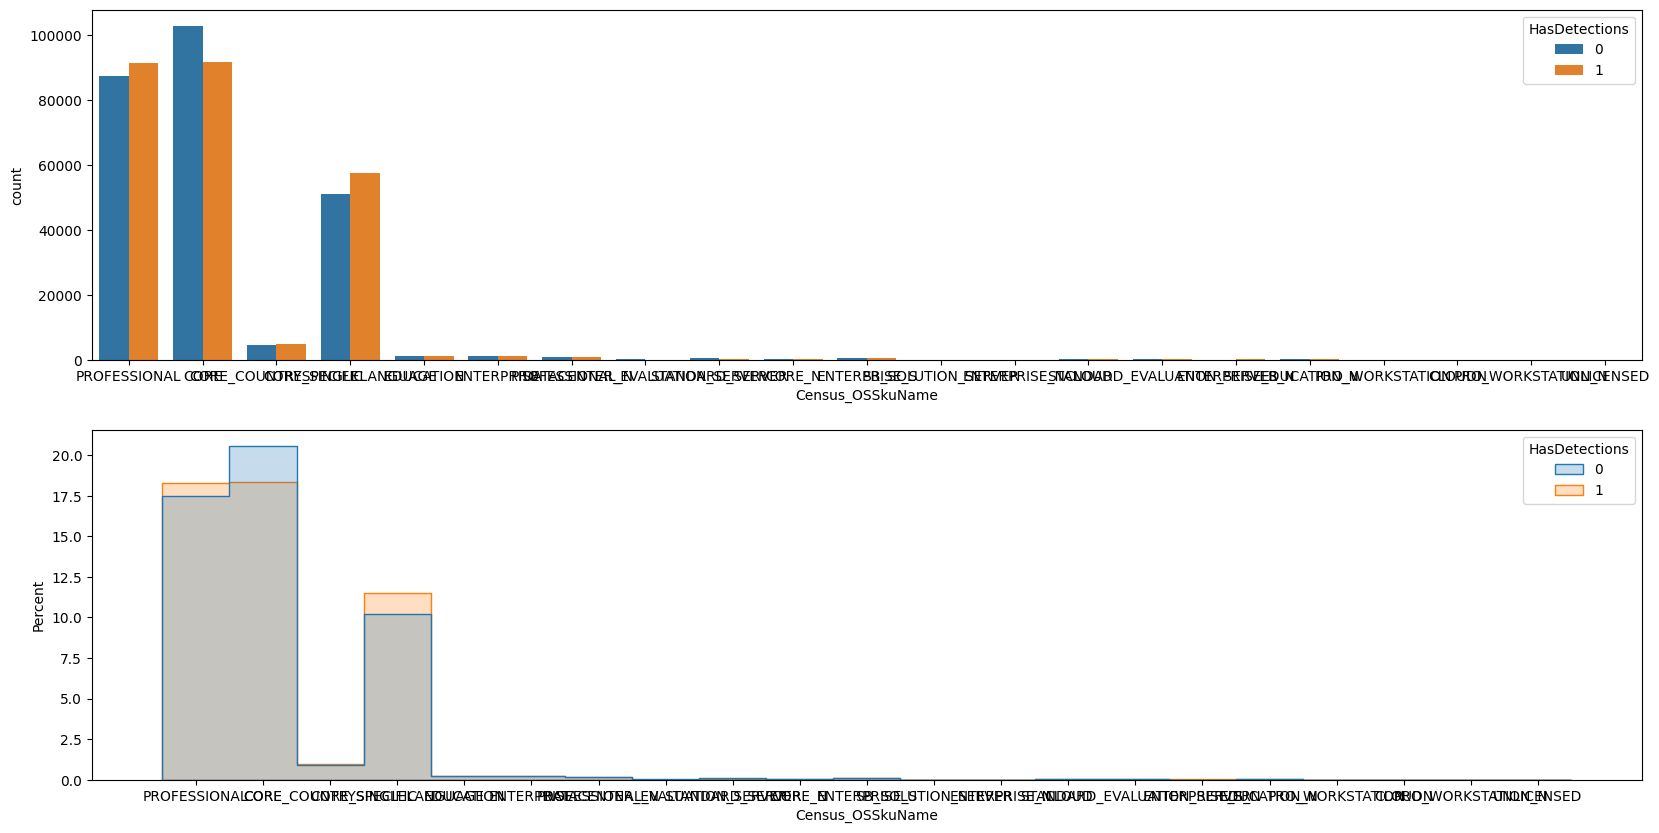

Equipos  Proporcion_Equipos  Infectados  \
Census_OSSkuName                                                        
CORE                           194464               38.89       91666   
PROFESSIONAL                   178947               35.79       91603   
CORE_SINGLELANGUAGE            108674               21.73       57578   
CORE_COUNTRYSPECIFIC             9257                1.85        4743   
EDUCATION                        2313                0.46        1213   
ENTERPRISE                       2063                0.41        1067   
PROFESSIONAL_N                   1634                0.33         875   
ENTERPRISE_S                     1107                0.22         583   
STANDARD_SERVER                   584                0.12         237   
CLOUD                             332                0.07         133   
CORE_N                            251                0.05         108   
STANDARD_EVALUATION_SERVER        151                0.03          37   
EDUCATION_N                        61                0.01          28   
ENTERPRISE_S_N                     48                0.01          35   
DATACENTER_EVALUATION_SERVER       47                0.01          15   
SB_SOLUTION_SERVER                 34                0.01          13   
ENTERPRISE_N                       28                0.01          16   
PRO_WORKSTATION                     2                0.00           1   
PRO_WORKSTATION_N                   1                0.00           1   
CLOUDN                              1                0.00           0   
UNLICENSED                          1                0.00           1   

                              Proporcion_Infectados  
Census_OSSkuName                                     
CORE                                          47.14  
PROFESSIONAL                                  51.19  
CORE_SINGLELANGUAGE                           52.98  
CORE_COUNTRYSPECIFIC                          51.24  
EDUCATION                                     52.44  
ENTERPRISE                                    51.72  
PROFESSIONAL_N                                53.55  
ENTERPRISE_S                                  52.66  
STANDARD_SERVER                               40.58  
CLOUD                                         40.06  
CORE_N                                        43.03  
STANDARD_EVALUATION_SERVER                    24.50  
EDUCATION_N                                   45.90  
ENTERPRISE_S_N                                72.92  
DATACENTER_EVALUATION_SERVER                  31.91  
SB_SOLUTION_SERVER                            38.24  
ENTERPRISE_N                                  57.14  
PRO_WORKSTATION                               50.00  
PRO_WORKSTATION_N                            100.00  
CLOUDN                                         0.00  
UNLICENSED                                   100.00

In [80]:
AnalisisAtributo(df_origin,df_origin.columns[59],tar=TARGET)

#### 3.60.- Census_OSInstallTypeName

Atributo Categórico
El atributo 'Census_OSInstallTypeName' tiene 0 valores nulos (0.0%)

Descripción estadístiica:

count         500000
unique             9
top       UUPUpgrade
freq          146780
Name: Census_OSInstallTypeName, dtype: object


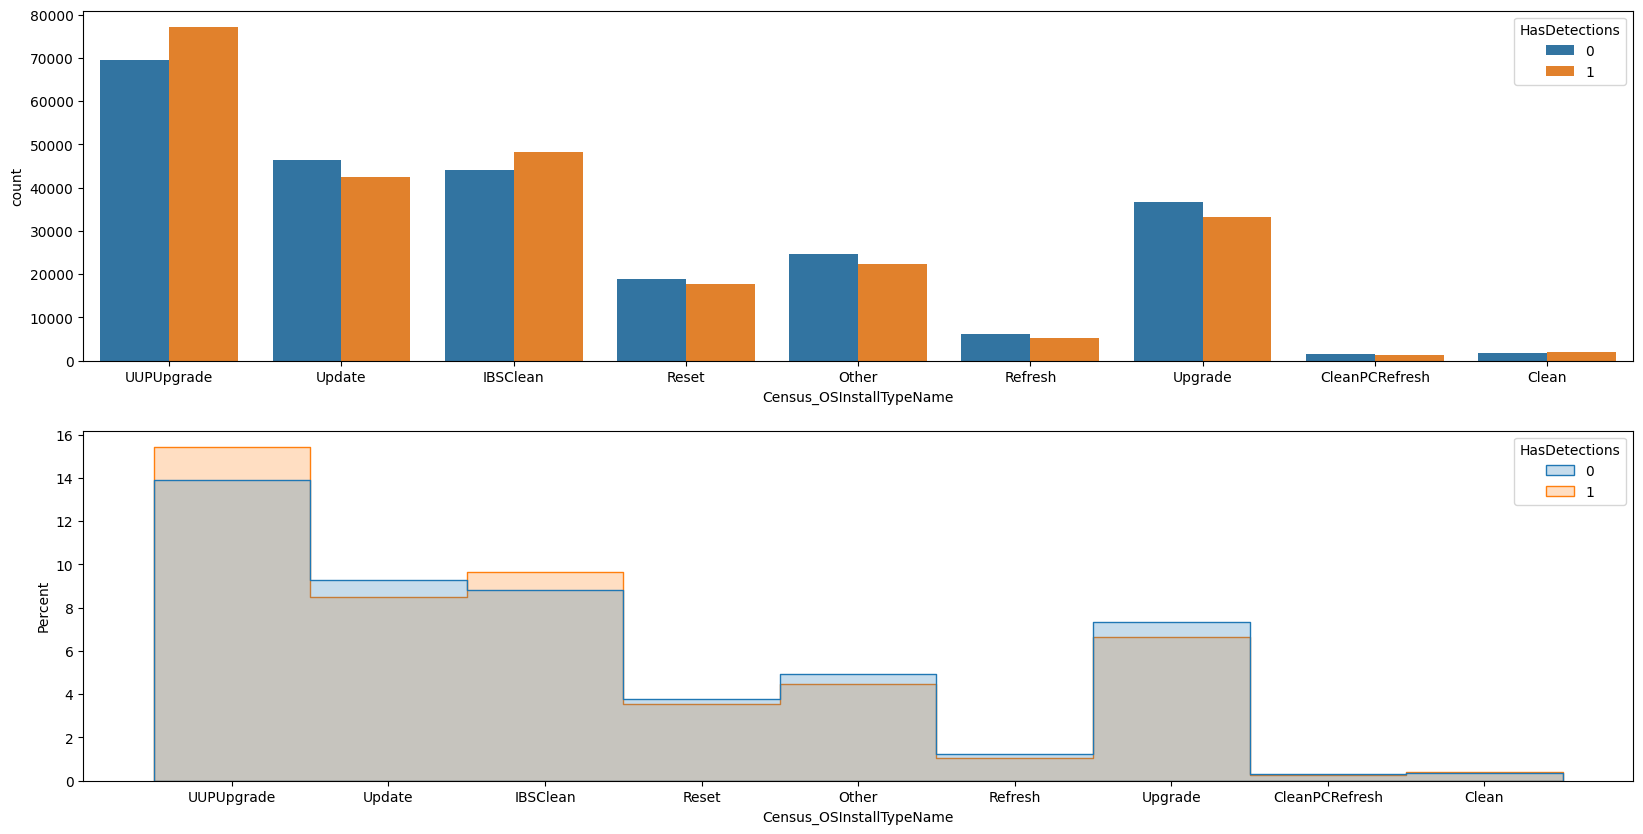

Equipos  Proporcion_Equipos  Infectados  \
Census_OSInstallTypeName                                            
UUPUpgrade                 146780               29.36       77129   
IBSClean                    92403               18.48       48304   
Update                      88892               17.78       42499   
Upgrade                     70013               14.00       33254   
Other                       46960                9.39       22409   
Reset                       36510                7.30       17605   
Refresh                     11540                2.31        5326   
Clean                        3885                0.78        2032   
CleanPCRefresh               3017                0.60        1395   

                          Proporcion_Infectados  
Census_OSInstallTypeName                         
UUPUpgrade                                52.55  
IBSClean                                  52.28  
Update                                    47.81  
Upgrade                                   47.50  
Other                                     47.72  
Reset                                     48.22  
Refresh                                   46.15  
Clean                                     52.30  
CleanPCRefresh                            46.24

In [81]:
AnalisisAtributo(df_origin,df_origin.columns[60],tar=TARGET)

#### 3.61.- Census_OSInstallLanguageIdentifier

Atributo Numérico
El atributo 'Census_OSInstallLanguageIdentifier' tiene 3332 valores nulos (0.67%)

Descripción estadístiica:
count   496,668.00
mean         14.61
std          10.20
min           1.00
25%           8.00
50%           9.00
75%          20.00
max          39.00
Name: Census_OSInstallLanguageIdentifier, dtype: float64

El atributo tiene 39 valores únicos

TOP 10 porcentaje de valores únicos:
Census_OSInstallLanguageIdentifier
8.00    35.68
9.00    11.60
7.00     5.75
29.00    5.53
14.00    4.84
37.00    4.53
10.00    4.05
26.00    3.70
5.00     2.82
35.00    2.30
Name: proportion, dtype: float64


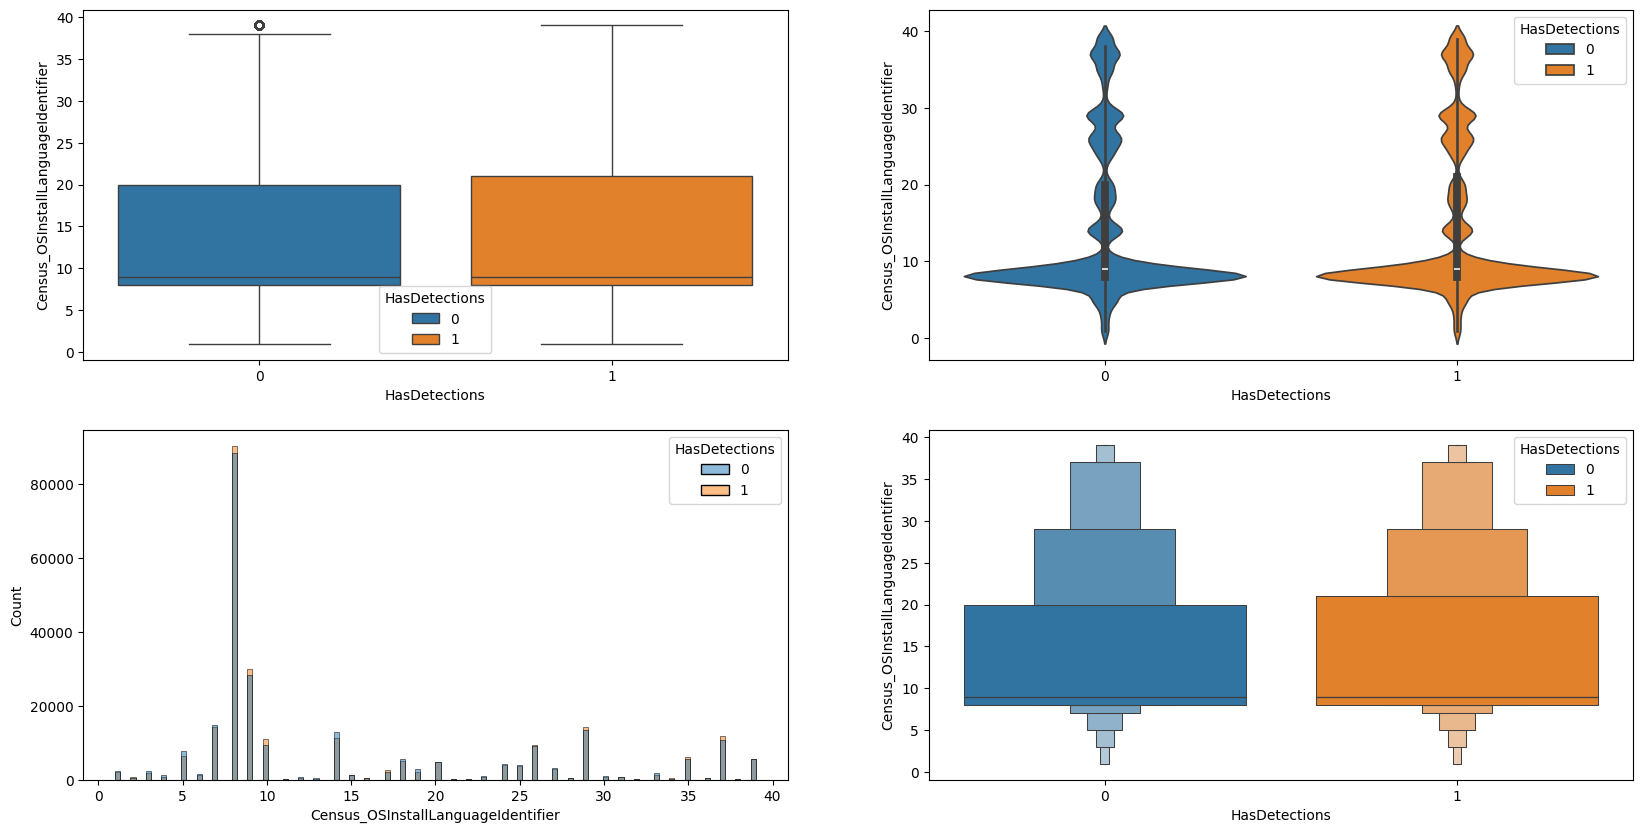

In [82]:
AnalisisAtributo(df_origin,df_origin.columns[61],tar=TARGET)

In [114]:
corr=df_origin.iloc[:,61:63].corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

# Este atributo tiene una alta correlación (0.9) con el atributo 'Census_OSUILocaleIdentifier' 
# debido a que uno indica el idioma del SO y el otro la localización del equipo.

# Como este atributo tiene nulos pero 'Census_OSUILocaleIdentifier' no, eliminaremos este.

#### 3.62.- Census_OSUILocaleIdentifier

Atributo Numérico
El atributo 'Census_OSUILocaleIdentifier' tiene 0 valores nulos (0.0%)

Descripción estadístiica:
count   500,000.00
mean         60.45
std          45.00
min           1.00
25%          31.00
50%          34.00
75%          90.00
max         162.00
Name: Census_OSUILocaleIdentifier, dtype: float64

El atributo tiene 92 valores únicos

TOP 10 porcentaje de valores únicos:
Census_OSUILocaleIdentifier
31    35.60
34    11.66
30     5.76
125    5.60
49     4.88
158    4.59
35     4.18
119    3.74
26     2.82
148    2.32
Name: proportion, dtype: float64


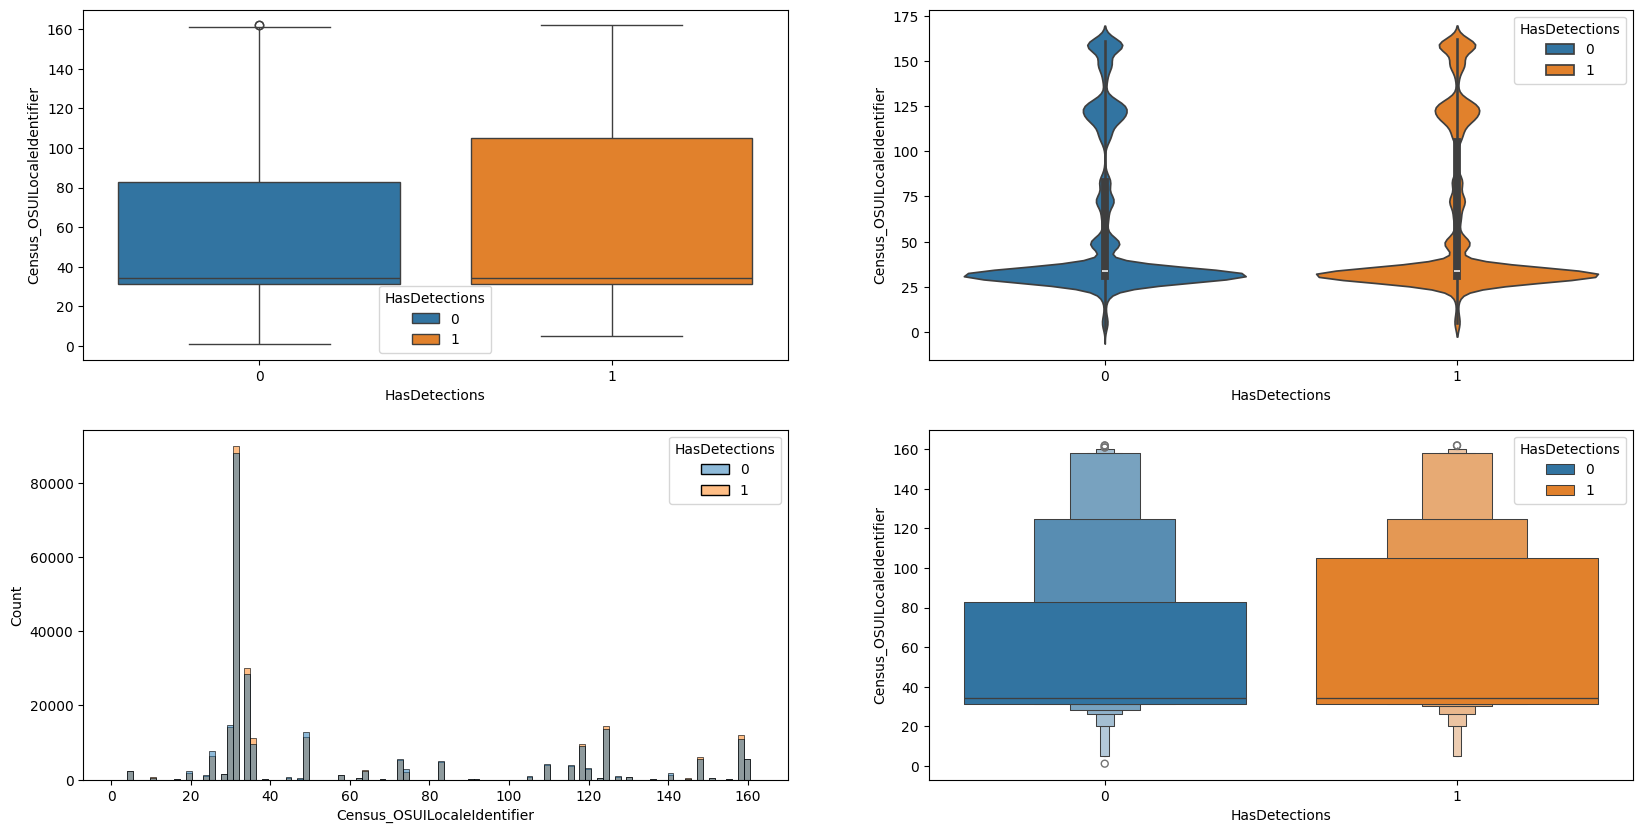

In [115]:
AnalisisAtributo(df_origin,df_origin.columns[62],tar=TARGET)

In [116]:
# Pasamos a int8 (0-256) para reducir carga de procesamiento
df_origin['Census_OSUILocaleIdentifier']=df_origin['Census_OSUILocaleIdentifier'].astype('int8')

#### 3.63.- Census_OSWUAutoUpdateOptionsName

Atributo Categórico
El atributo 'Census_OSWUAutoUpdateOptionsName' tiene 0 valores nulos (0.0%)

Descripción estadístiica:

count       500000
unique           6
top       FullAuto
freq        222482
Name: Census_OSWUAutoUpdateOptionsName, dtype: object


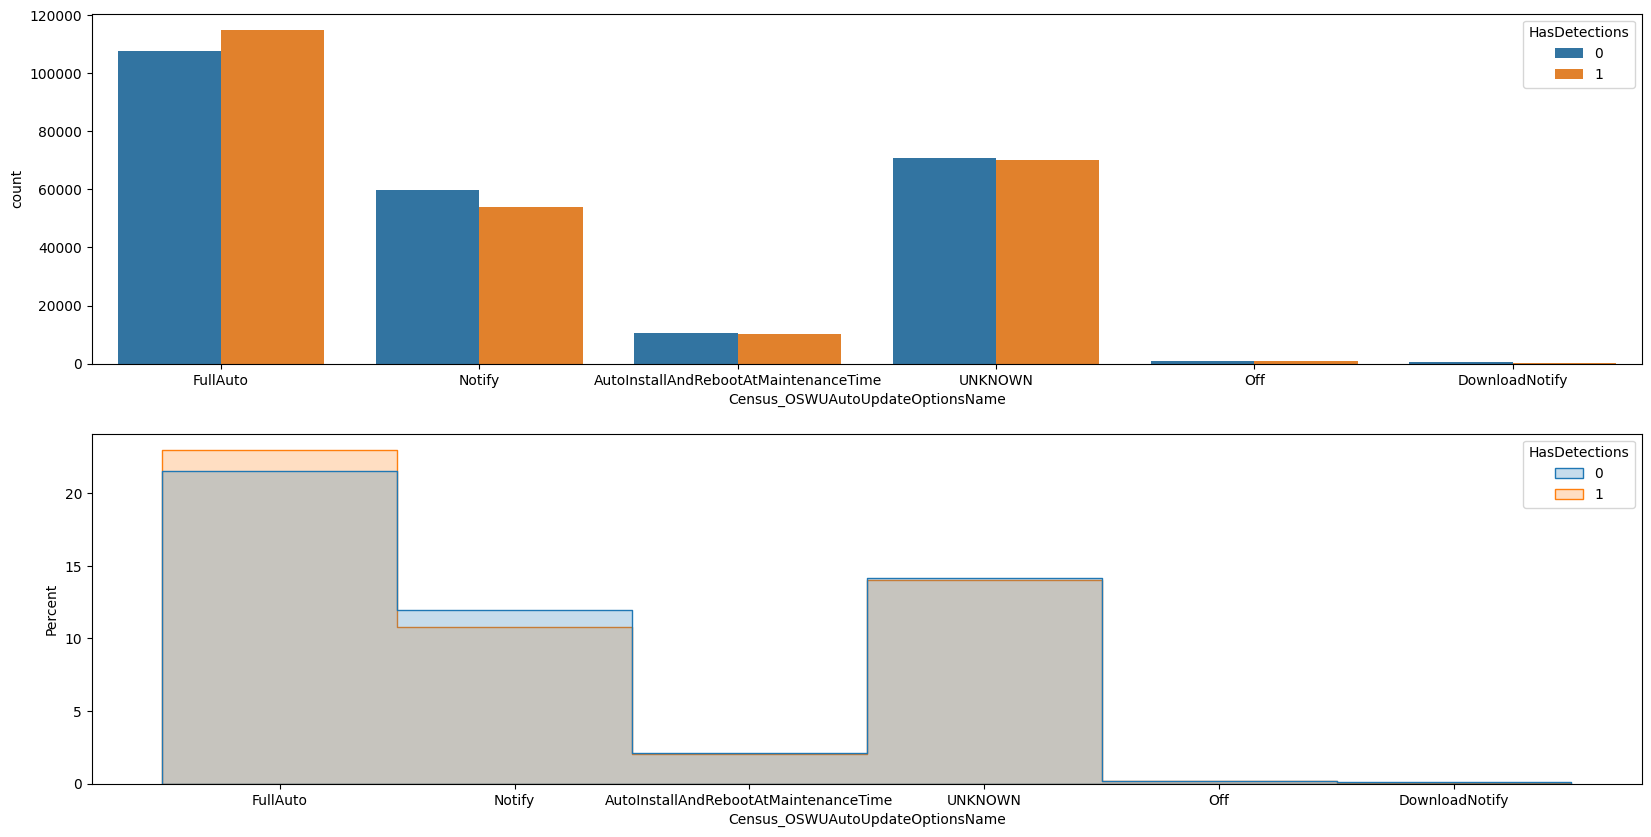

Equipos  Proporcion_Equipos  \
Census_OSWUAutoUpdateOptionsName                                     
FullAuto                                222482               44.50   
UNKNOWN                                 140961               28.19   
Notify                                  113507               22.70   
AutoInstallAndRebootAtMaintenanceTime    20731                4.15   
Off                                       1506                0.30   
DownloadNotify                             813                0.16   

                                       Infectados  Proporcion_Infectados  
Census_OSWUAutoUpdateOptionsName                                          
FullAuto                                   114807                  51.60  
UNKNOWN                                     70190                  49.79  
Notify                                      53867                  47.46  
AutoInstallAndRebootAtMaintenanceTime       10056                  48.51  
Off                                           732                  48.61  
DownloadNotify                                301                  37.02

In [84]:
AnalisisAtributo(df_origin,df_origin.columns[63],tar=TARGET)

In [117]:
group_list=('AutoInstallAndRebootAtMaintenanceTime', 'Off','DownloadNotify')

df_origin['Census_OSWUAutoUpdateOptionsName']=df_origin['Census_OSWUAutoUpdateOptionsName'].apply(lambda x: 'UNKNOWN' if (x in group_list) else x )

#### 3.64.- Census_IsPortableOperatingSystem

Atributo Numérico
El atributo 'Census_IsPortableOperatingSystem' tiene 0 valores nulos (0.0%)

Descripción estadístiica:
count   500,000.00
mean          0.00
std           0.02
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           1.00
Name: Census_IsPortableOperatingSystem, dtype: float64

El atributo tiene 2 valores únicos

TOP 10 porcentaje de valores únicos:
Census_IsPortableOperatingSystem
0   99.95
1    0.05
Name: proportion, dtype: float64


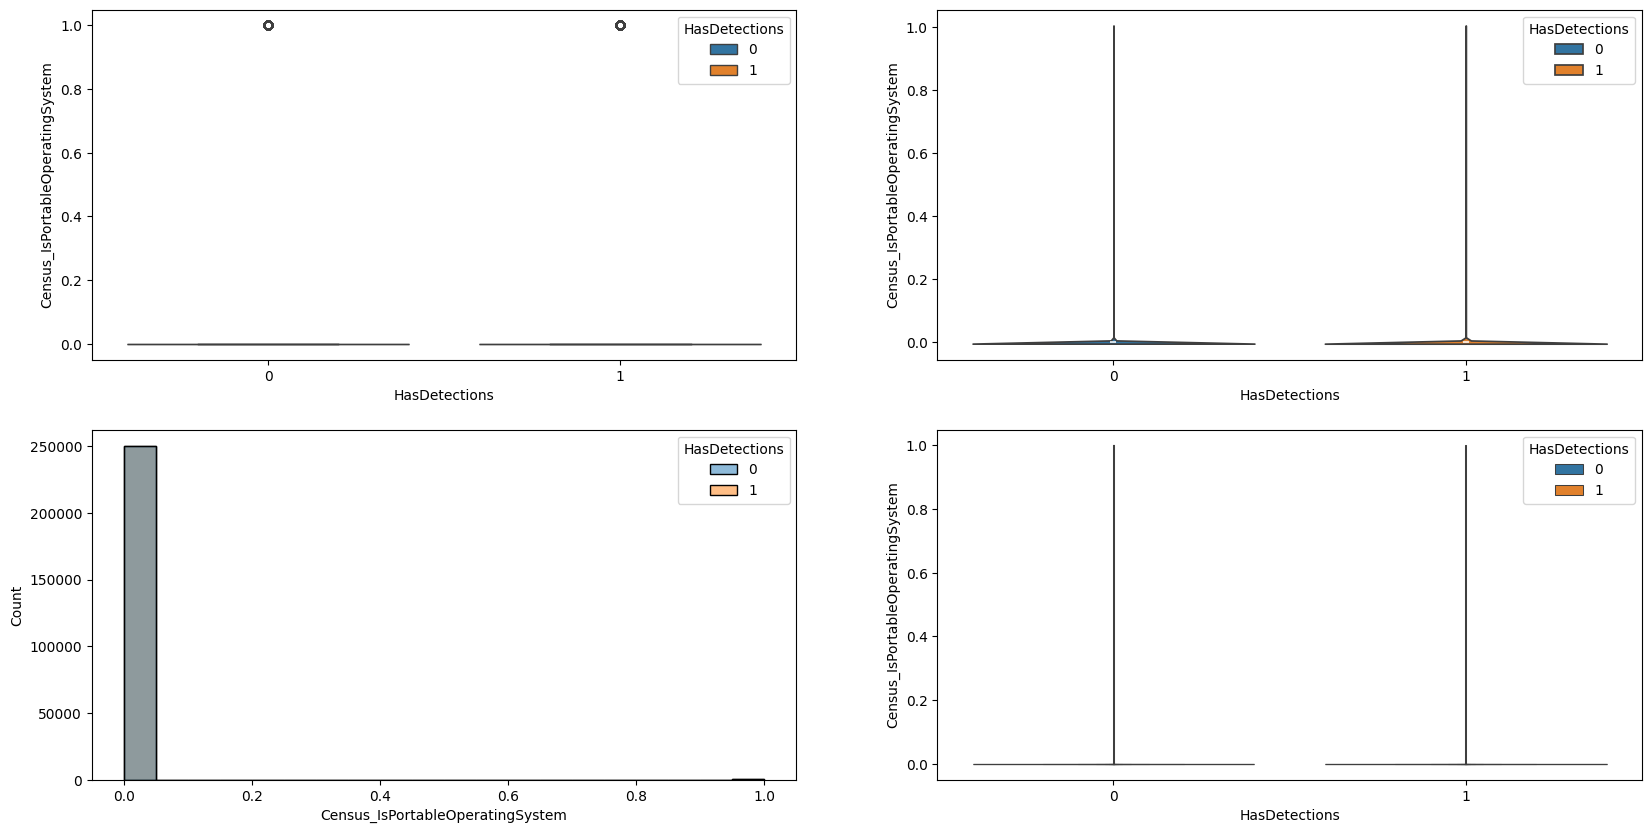

In [118]:
AnalisisAtributo(df_origin,df_origin.columns[64],tar=TARGET)

#### 3.65.- Census_GenuineStateName

Atributo Categórico
El atributo 'Census_GenuineStateName' tiene 0 valores nulos (0.0%)

Descripción estadístiica:

count         500000
unique             4
top       IS_GENUINE
freq          441402
Name: Census_GenuineStateName, dtype: object


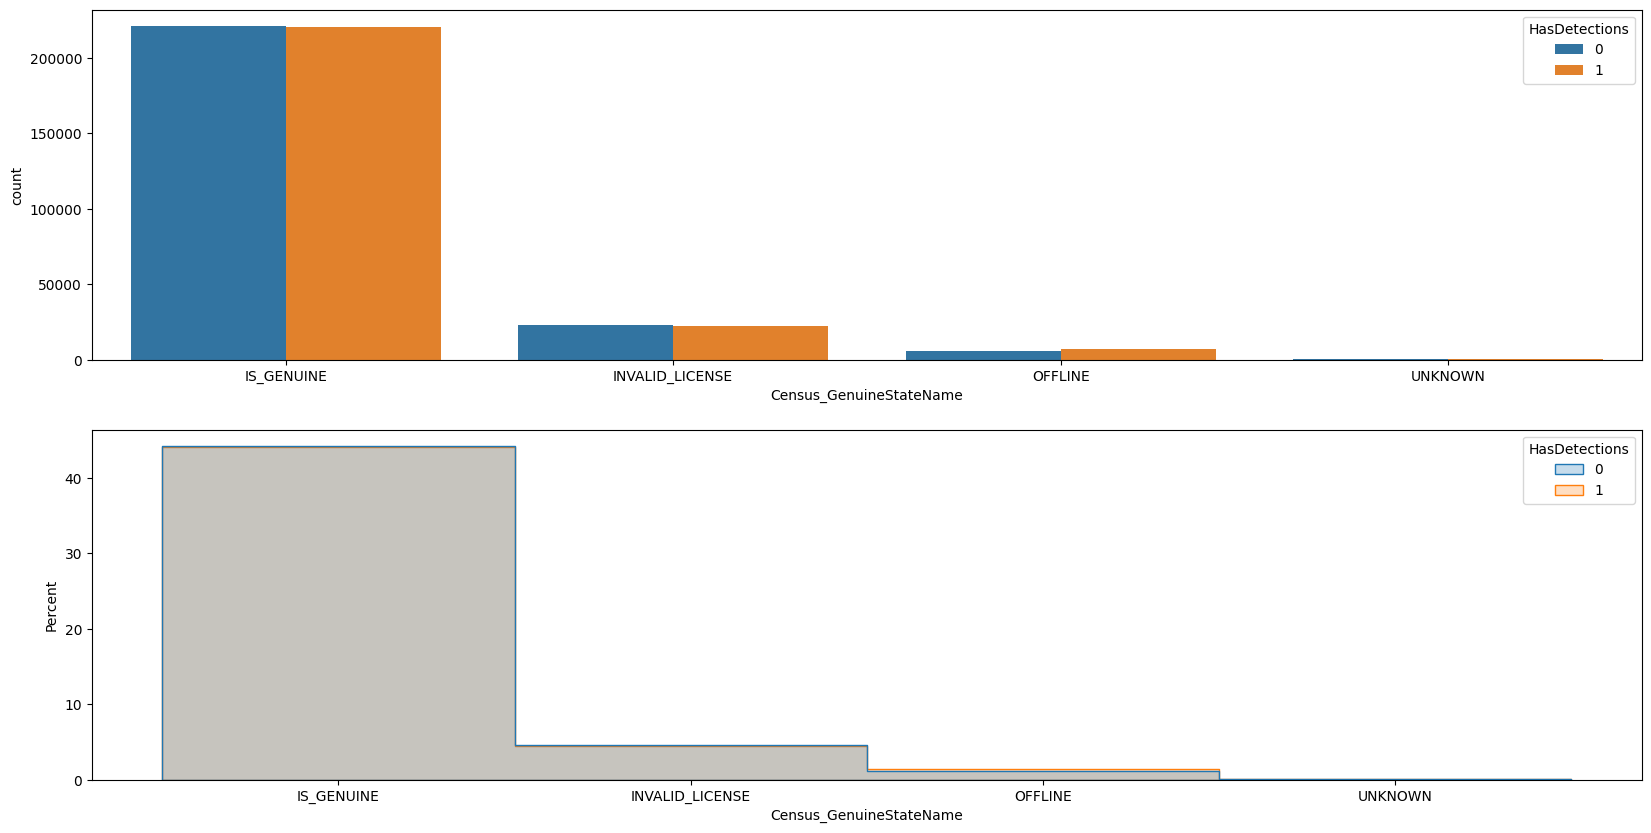

Equipos  Proporcion_Equipos  Infectados  \
Census_GenuineStateName                                            
IS_GENUINE                441402               88.28      220477   
INVALID_LICENSE            44990                9.00       22236   
OFFLINE                    12834                2.57        6994   
UNKNOWN                      774                0.15         246   

                         Proporcion_Infectados  
Census_GenuineStateName                         
IS_GENUINE                               49.95  
INVALID_LICENSE                          49.42  
OFFLINE                                  54.50  
UNKNOWN                                  31.78

In [86]:
AnalisisAtributo(df_origin,df_origin.columns[65],tar=TARGET)

In [119]:
# Agrupamos categorías minoritarias en 'INVALID_LICENSE'
df_origin['Census_GenuineStateName']=df_origin['Census_GenuineStateName'].apply(lambda x: 'INVALID_LICENSE' if (x != 'IS_GENUINE') else x)

#### 3.66.- Census_ActivationChannel

Atributo Categórico
El atributo 'Census_ActivationChannel' tiene 0 valores nulos (0.0%)

Descripción estadístiica:

count     500000
unique         6
top       Retail
freq      264932
Name: Census_ActivationChannel, dtype: object


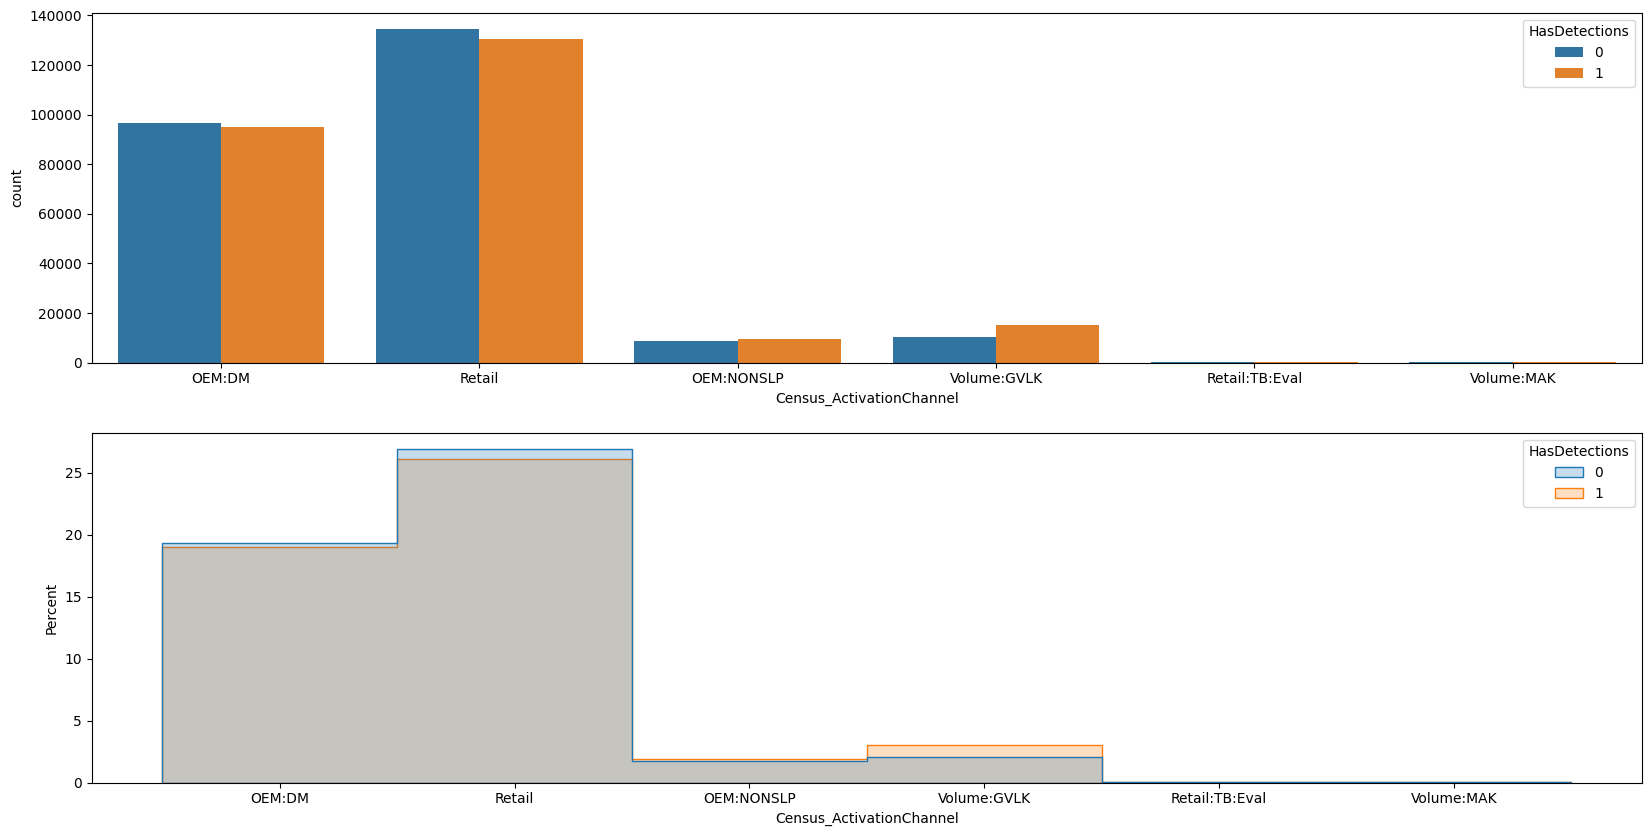

Equipos  Proporcion_Equipos  Infectados  \
Census_ActivationChannel                                            
Retail                     264932               52.99      130532   
OEM:DM                     191350               38.27       94880   
Volume:GVLK                 25109                5.02       14963   
OEM:NONSLP                  17943                3.59        9314   
Volume:MAK                    468                0.09         212   
Retail:TB:Eval                198                0.04          52   

                          Proporcion_Infectados  
Census_ActivationChannel                         
Retail                                    49.27  
OEM:DM                                    49.58  
Volume:GVLK                               59.59  
OEM:NONSLP                                51.91  
Volume:MAK                                45.30  
Retail:TB:Eval                            26.26

In [87]:
AnalisisAtributo(df_origin,df_origin.columns[66],tar=TARGET)

In [120]:
#Agrupamos por categorias principales
df_origin['Census_ActivationChannel']=df_origin['Census_ActivationChannel'].apply(lambda x: 'OEM' if x.startswith('OEM') else 'Volume' if x.startswith('Volume') else 'Retail')

#### 3.67.- Census_IsFlightingInternal

Atributo Numérico
El atributo 'Census_IsFlightingInternal' tiene 415225 valores nulos (83.04%)

Descripción estadístiica:
count   84,775.00
mean         0.00
std          0.00
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: Census_IsFlightingInternal, dtype: float64

El atributo tiene 2 valores únicos

TOP 10 porcentaje de valores únicos:
Census_IsFlightingInternal
NaN    83.05
0.00   16.95
1.00    0.00
Name: proportion, dtype: float64


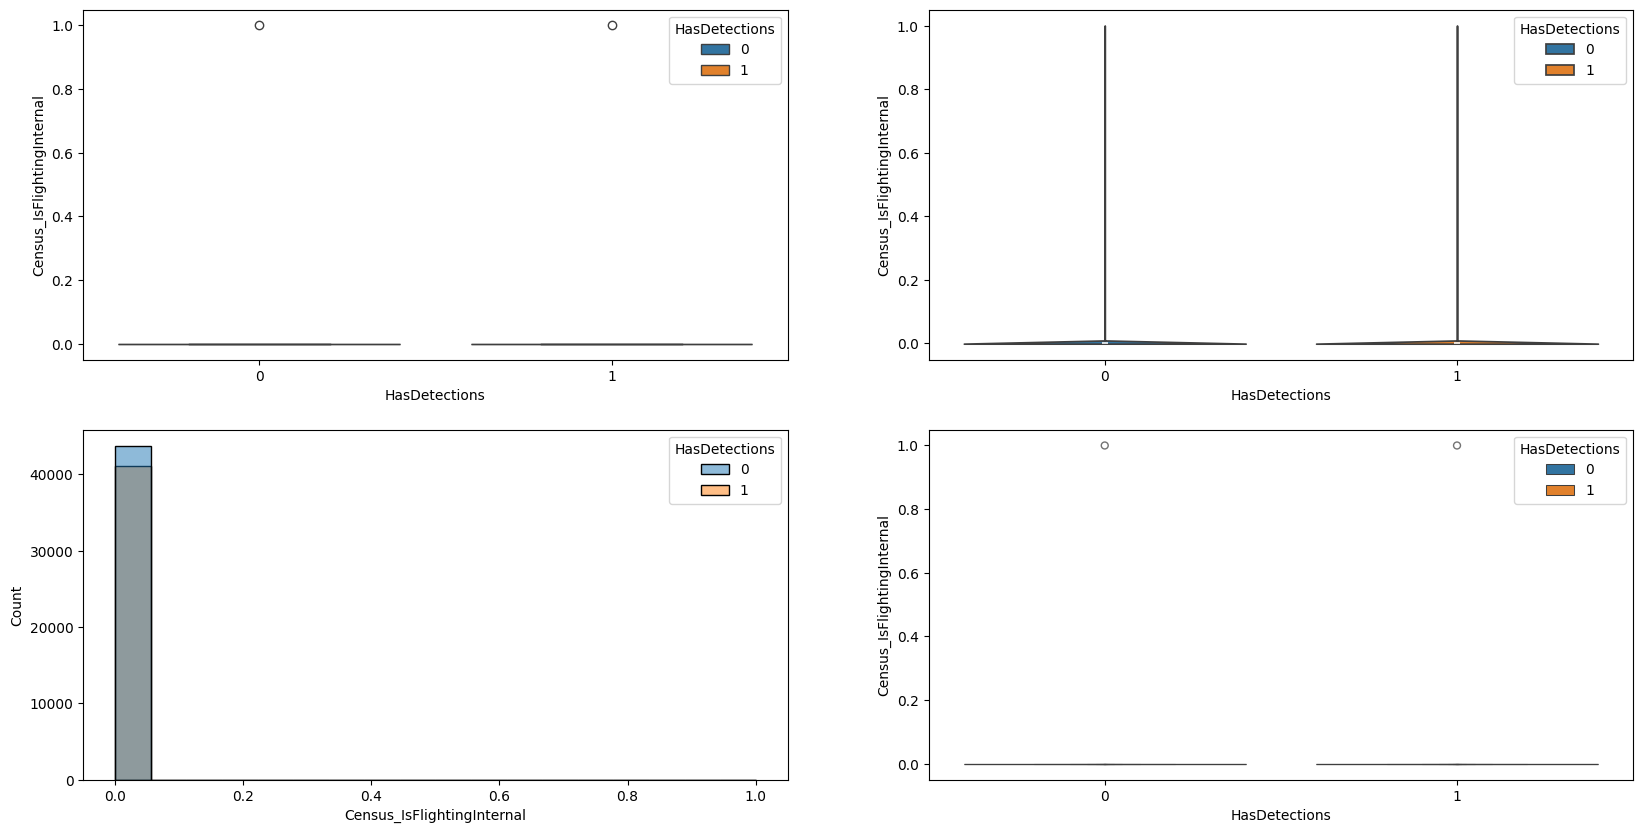

In [88]:
AnalisisAtributo(df_origin,df_origin.columns[67],tar=TARGET)

#### 3.68.- Census_IsFlightsDisabled

Atributo Numérico
El atributo 'Census_IsFlightsDisabled' tiene 8933 valores nulos (1.79%)

Descripción estadístiica:
count   491,067.00
mean          0.00
std           0.00
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           1.00
Name: Census_IsFlightsDisabled, dtype: float64

El atributo tiene 2 valores únicos

TOP 10 porcentaje de valores únicos:
Census_IsFlightsDisabled
0.00   98.21
NaN     1.79
1.00    0.00
Name: proportion, dtype: float64


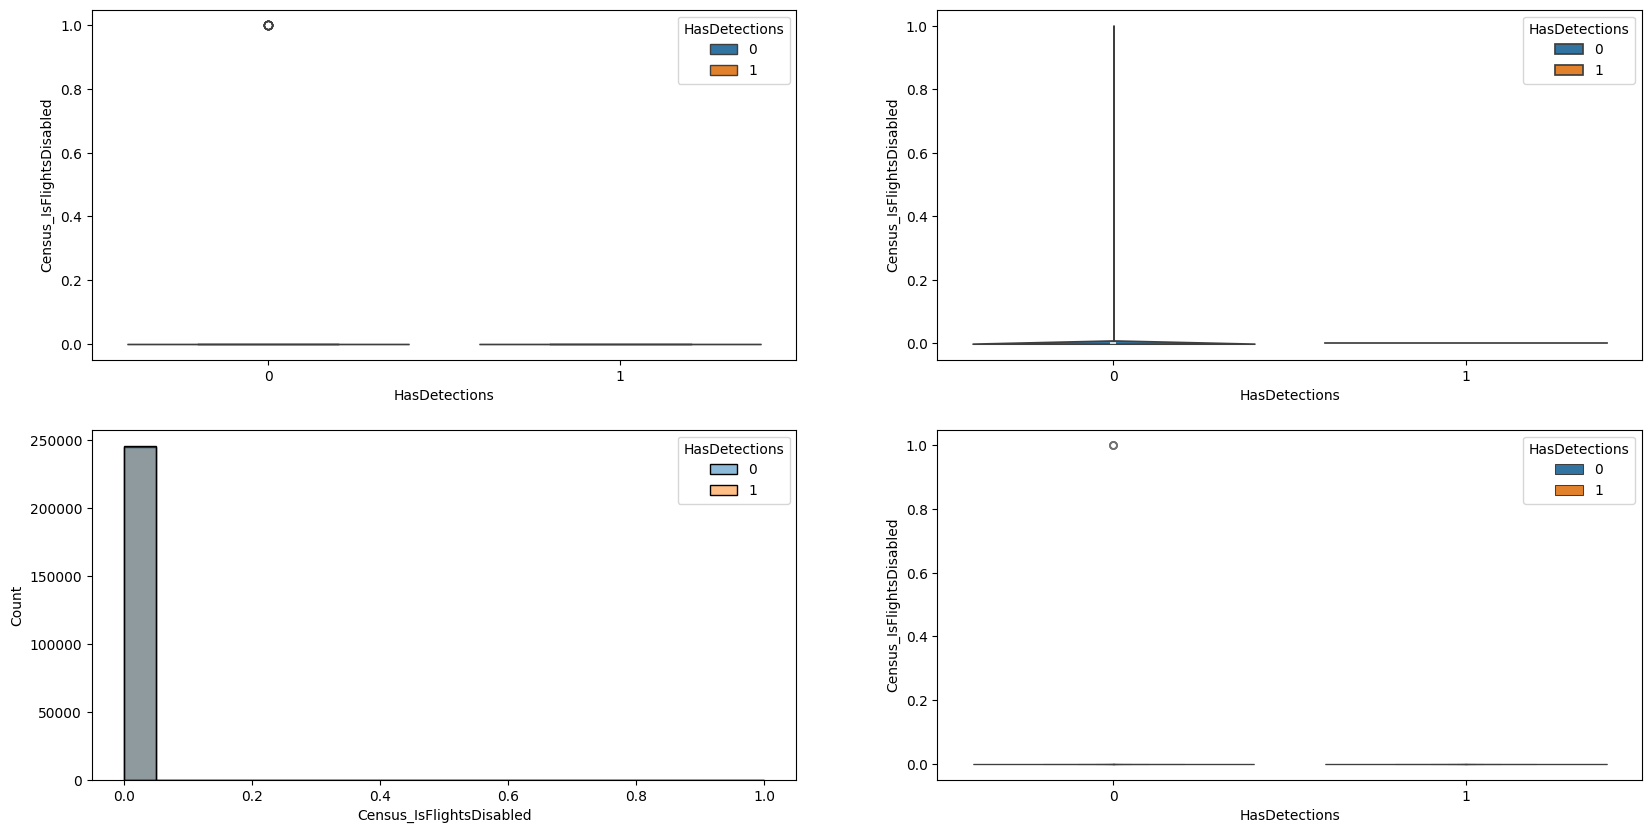

In [89]:
AnalisisAtributo(df_origin,df_origin.columns[68],tar=TARGET)

#### 3.69.- Census_FlightRing

Atributo Categórico
El atributo 'Census_FlightRing' tiene 0 valores nulos (0.0%)

Descripción estadístiica:

count     500000
unique         8
top       Retail
freq      468299
Name: Census_FlightRing, dtype: object


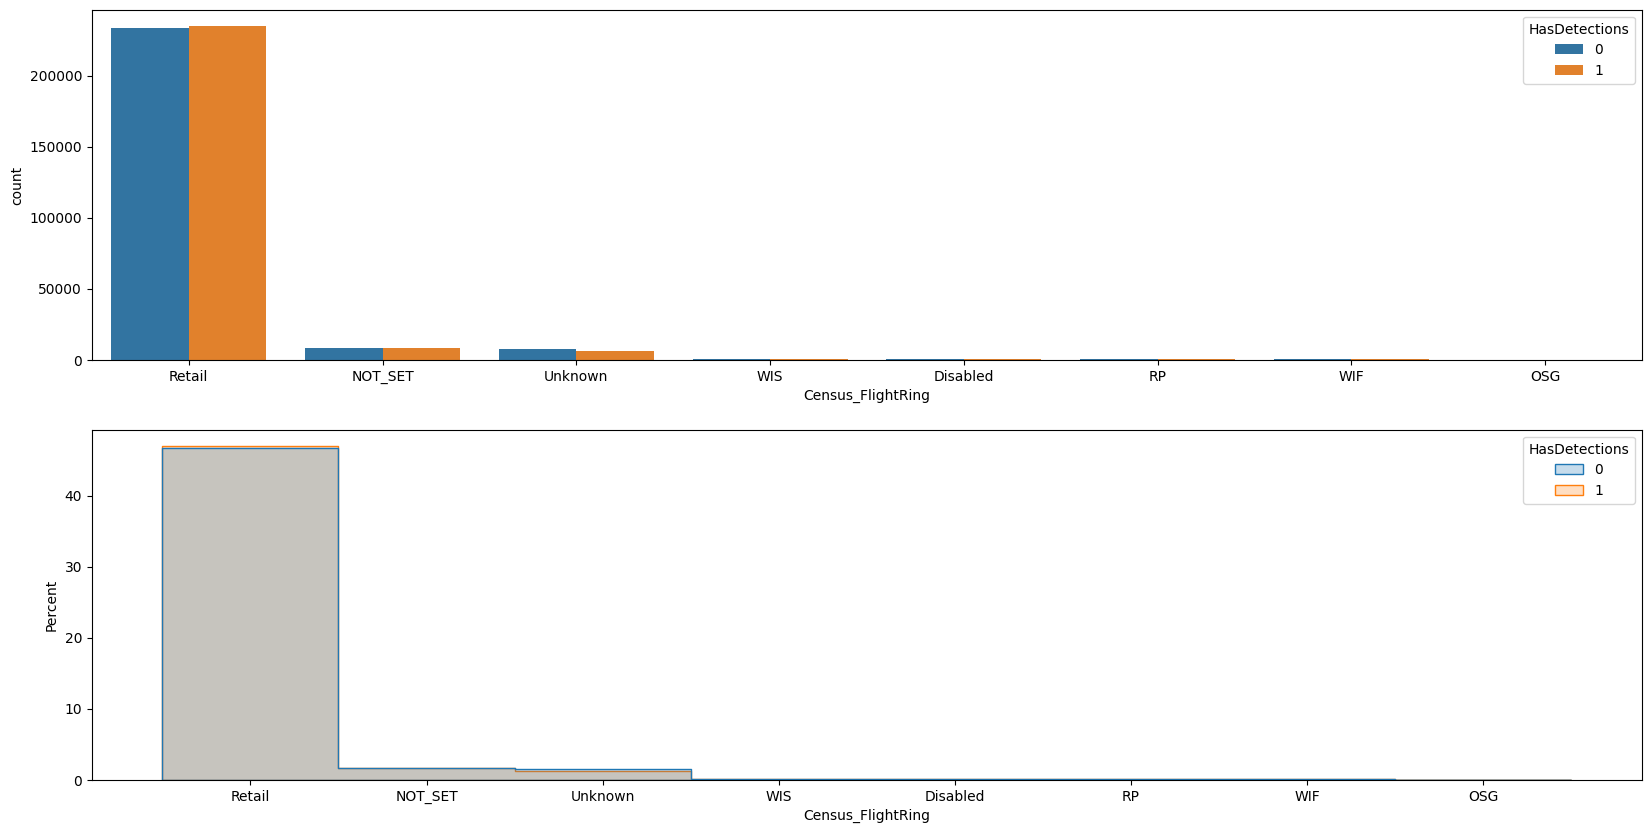

Equipos  Proporcion_Equipos  Infectados  \
Census_FlightRing                                            
Retail              468299               93.66      234693   
NOT_SET              16044                3.21        7980   
Unknown              13701                2.74        6378   
WIS                    606                0.12         250   
RP                     583                0.12         299   
WIF                    549                0.11         253   
Disabled               217                0.04         100   
OSG                      1                0.00           0   

                   Proporcion_Infectados  
Census_FlightRing                         
Retail                             50.12  
NOT_SET                            49.74  
Unknown                            46.55  
WIS                                41.25  
RP                                 51.29  
WIF                                46.08  
Disabled                           46.08  
OSG                                 0.00

In [90]:
AnalisisAtributo(df_origin,df_origin.columns[69],tar=TARGET)

#### 3.70.- Census_ThresholdOptIn

Atributo Numérico
El atributo 'Census_ThresholdOptIn' tiene 318104 valores nulos (63.62%)

Descripción estadístiica:
count   181,896.00
mean          0.00
std           0.02
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           1.00
Name: Census_ThresholdOptIn, dtype: float64

El atributo tiene 2 valores únicos

TOP 10 porcentaje de valores únicos:
Census_ThresholdOptIn
NaN    63.62
0.00   36.37
1.00    0.01
Name: proportion, dtype: float64


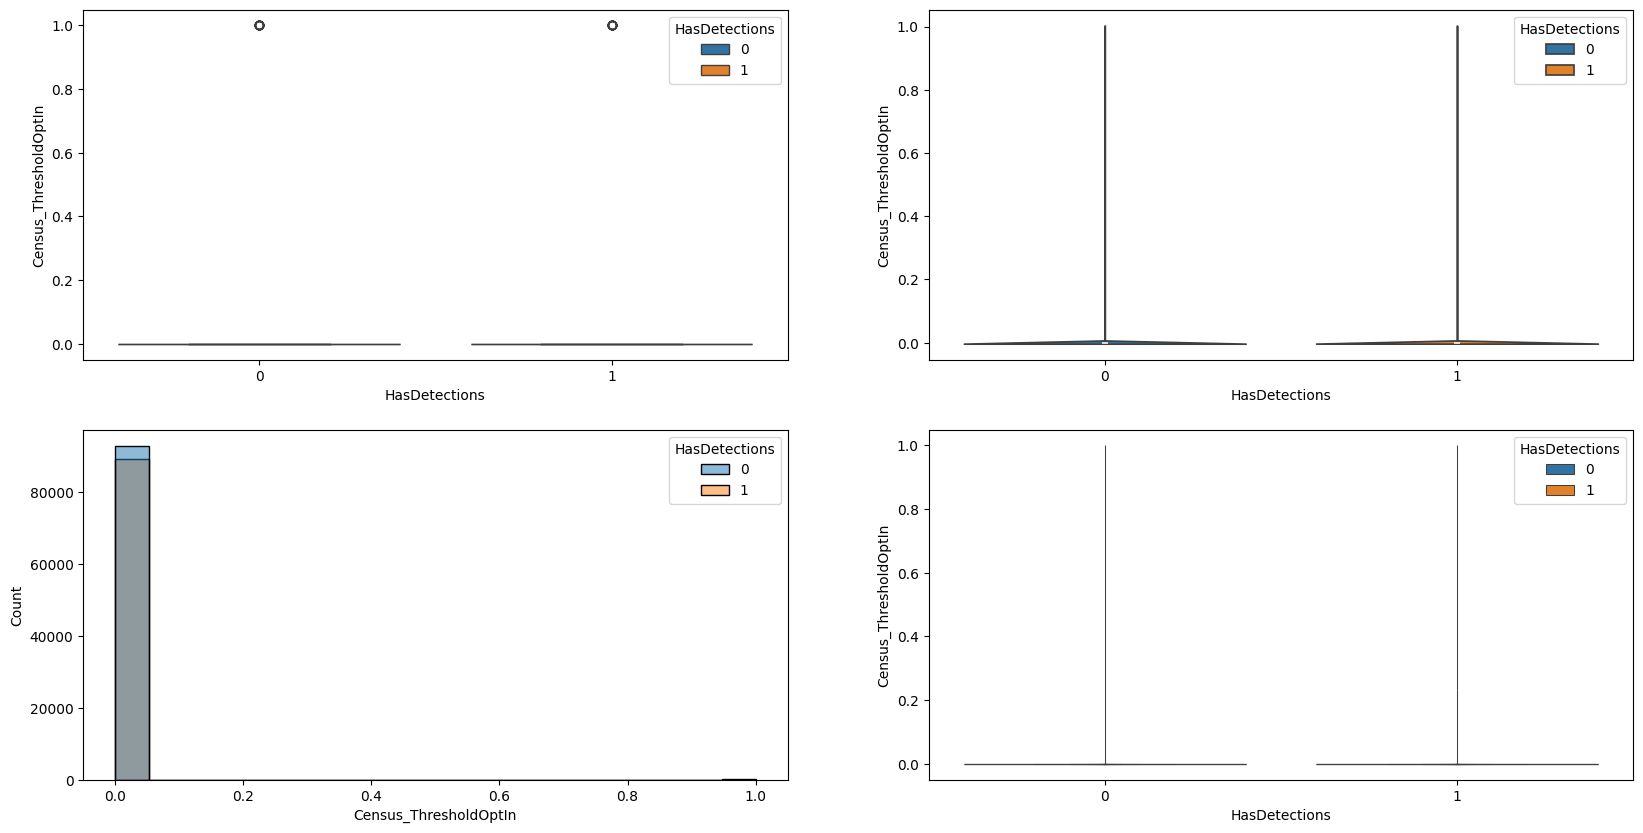

In [91]:
AnalisisAtributo(df_origin,df_origin.columns[70],tar=TARGET)

#### 3.71.- Census_FirmwareManufacturerIdentifier

Atributo Numérico
El atributo 'Census_FirmwareManufacturerIdentifier' tiene 10349 valores nulos (2.07%)

Descripción estadístiica:
count   489,651.00
mean        402.68
std         221.53
min          11.00
25%         142.00
50%         500.00
75%         556.00
max       1,084.00
Name: Census_FirmwareManufacturerIdentifier, dtype: float64

El atributo tiene 303 valores únicos

TOP 10 porcentaje de valores únicos:
Census_FirmwareManufacturerIdentifier
142.00   30.27
628.00   13.76
554.00   13.13
355.00   10.55
556.00    8.98
500.00    4.34
93.00     2.13
NaN       2.07
807.00    1.76
513.00    1.58
Name: proportion, dtype: float64


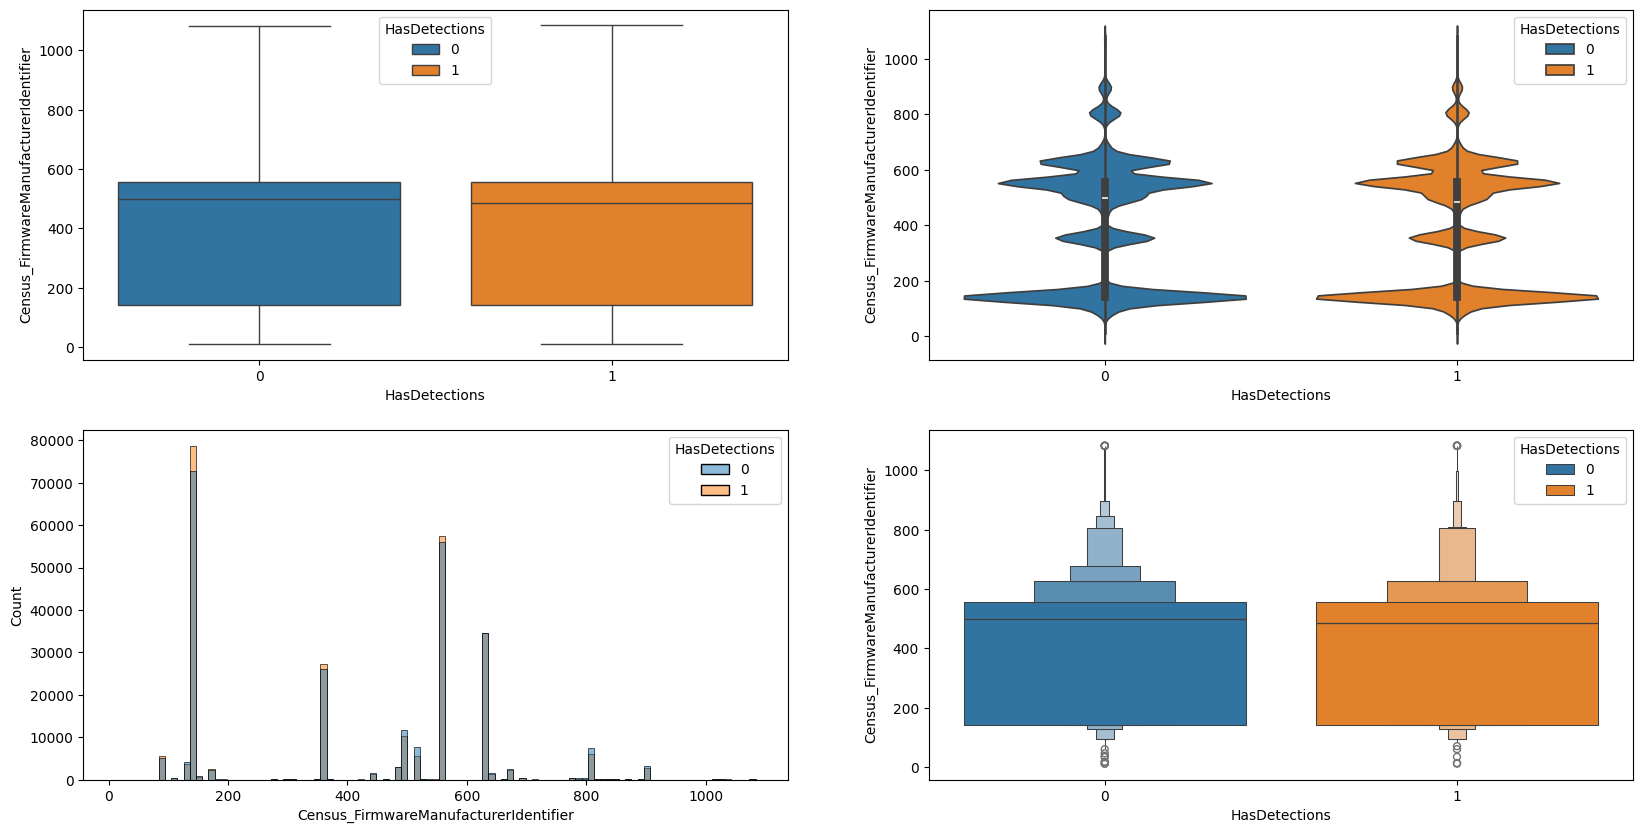

In [92]:
AnalisisAtributo(df_origin,df_origin.columns[71],tar=TARGET)

In [122]:
top4=(142,628,554,355)
df_origin['Census_FirmwareManufacturerIdentifier']=df_origin['Census_FirmwareManufacturerIdentifier'].apply(lambda x: 0 if (x not in top4) else x)
del(top4)

#### 3.72.- Census_FirmwareVersionIdentifier

Atributo Numérico
El atributo 'Census_FirmwareVersionIdentifier' tiene 9061 valores nulos (1.81%)

Descripción estadístiica:
count   490,939.00
mean     33,030.99
std      21,220.16
min          10.00
25%      13,156.00
50%      33,070.00
75%      52,436.00
max      72,091.00
Name: Census_FirmwareVersionIdentifier, dtype: float64

El atributo tiene 23569 valores únicos

TOP 10 porcentaje de valores únicos:
Census_FirmwareVersionIdentifier
NaN         1.81
33,105.00   1.01
33,111.00   0.67
33,054.00   0.62
33,108.00   0.61
63,175.00   0.59
11,778.00   0.59
33,115.00   0.58
63,155.00   0.56
33,060.00   0.54
Name: proportion, dtype: float64


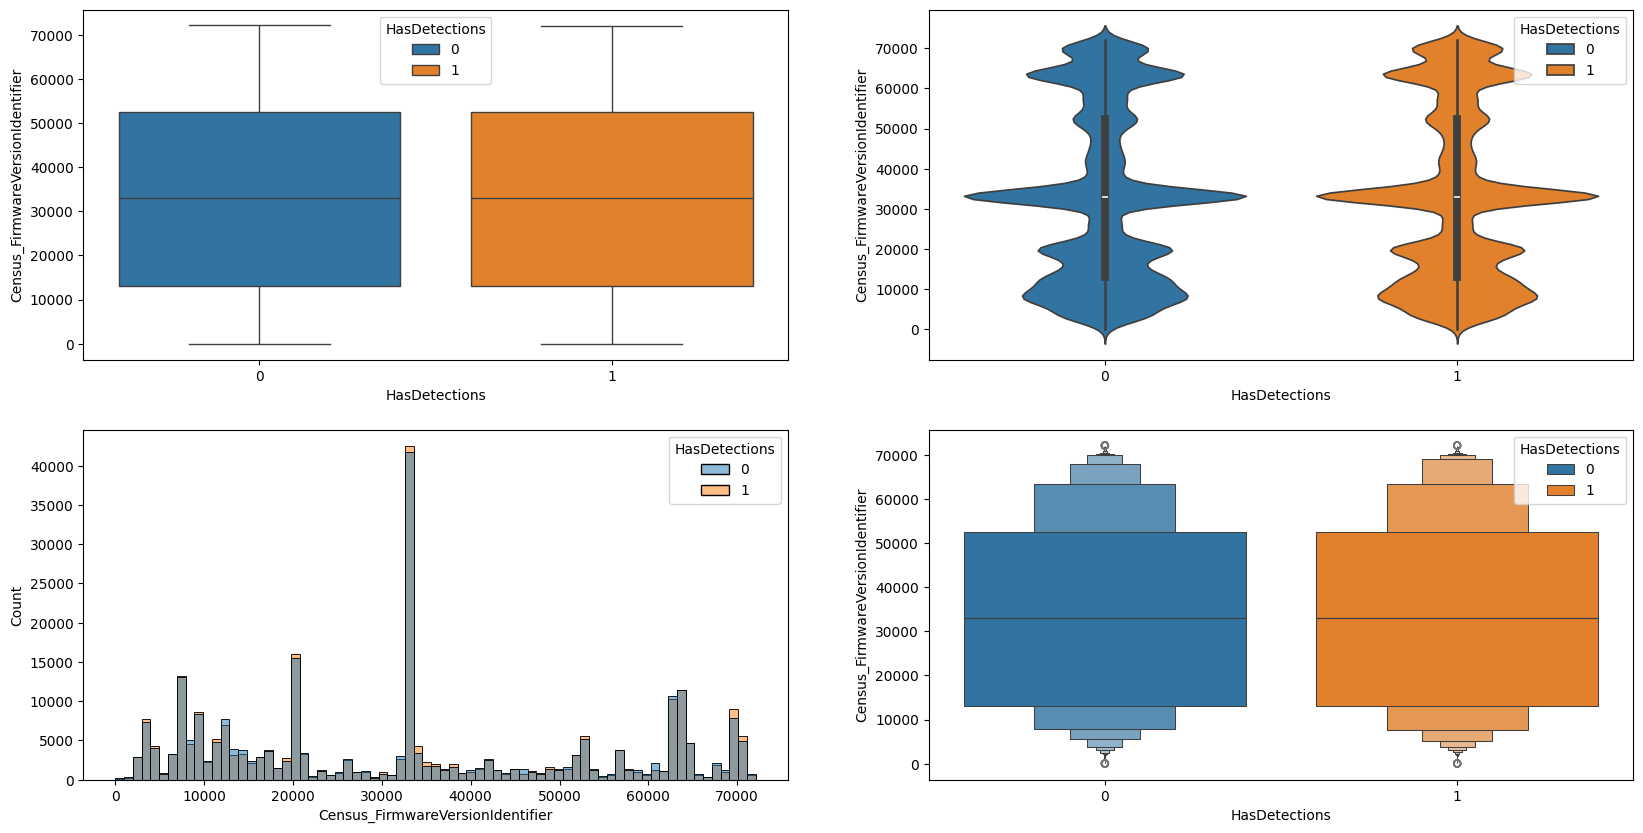

In [93]:
AnalisisAtributo(df_origin,df_origin.columns[72],tar=TARGET)

In [123]:
corr=df_origin[['Census_FirmwareManufacturerIdentifier','Census_FirmwareVersionIdentifier']].corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

# Los atributos Census_FirmwareManufacturerIdentifier y Census_FirmwareVersionIdentifier pese a que estén
# relacionados, no presentan demasiada correlación entre ellos.

In [125]:
mode=df_origin['Census_FirmwareVersionIdentifier'].mode()[0]
mode

33105.0

In [126]:
df_origin['Census_FirmwareVersionIdentifier'].fillna(mode,inplace=True)

In [127]:
df_origin.Census_FirmwareVersionIdentifier.isna().sum()

0

In [128]:
df_origin['Census_FirmwareVersionIdentifier']=df_origin['Census_FirmwareVersionIdentifier'].astype(int)

In [129]:
df_origin['Census_FirmwareVersionIdentifier']=df_origin['Census_FirmwareVersionIdentifier'].apply(lambda x: 0 if x<10000 \
    else 10 if (x in range(10000,19999)) else 20 if (x in range(20000,29999)) else\
    30 if (x in range(30000,39999)) else 40 if (x in range(40000,49999)) else 50 if (x in range(50000,59999)) else\
    60 if (x in range(60000,69999)) else 70)    

In [131]:
df_origin.Census_FirmwareVersionIdentifier.sample(10)

02d50c81c4bd35f1fd6c6728fcbc830e    30
611e0b61f9d9db7de0ef83e97d6b8f7b    30
82ecee1aa94b340fb58366684f2db8c5    60
9660116bfdd50ca38b27a74e163d37c2    30
263d7fc9117f2da1a1614a823a7c5b77    20
3fc062d1db1ca40409d70d1ec83fee38    50
a296ac14f3ed1775e4b847d7f31693d8    30
787171ecf8a4714a5e21b44b30079ec1    50
d3b3ce8b727af3a383db450650032ab9    30
51d8db7a2e7f12d8fac4335444905f4f    50
Name: Census_FirmwareVersionIdentifier, dtype: int64

In [132]:
df_origin.Census_FirmwareVersionIdentifier.info()

<class 'pandas.core.series.Series'>
Index: 500000 entries, f1cd864e97bae82bdf96523e1a539121 to 7b45dc3537e17f16305c5983ca0a1cb9
Series name: Census_FirmwareVersionIdentifier
Non-Null Count   Dtype
--------------   -----
500000 non-null  int64
dtypes: int64(1)
memory usage: 23.8+ MB


#### 3.73.- Census_IsSecureBootEnabled

Atributo Numérico
El atributo 'Census_IsSecureBootEnabled' tiene 0 valores nulos (0.0%)

Descripción estadístiica:
count   500,000.00
mean          0.49
std           0.50
min           0.00
25%           0.00
50%           0.00
75%           1.00
max           1.00
Name: Census_IsSecureBootEnabled, dtype: float64

El atributo tiene 2 valores únicos

TOP 10 porcentaje de valores únicos:
Census_IsSecureBootEnabled
0   51.46
1   48.54
Name: proportion, dtype: float64


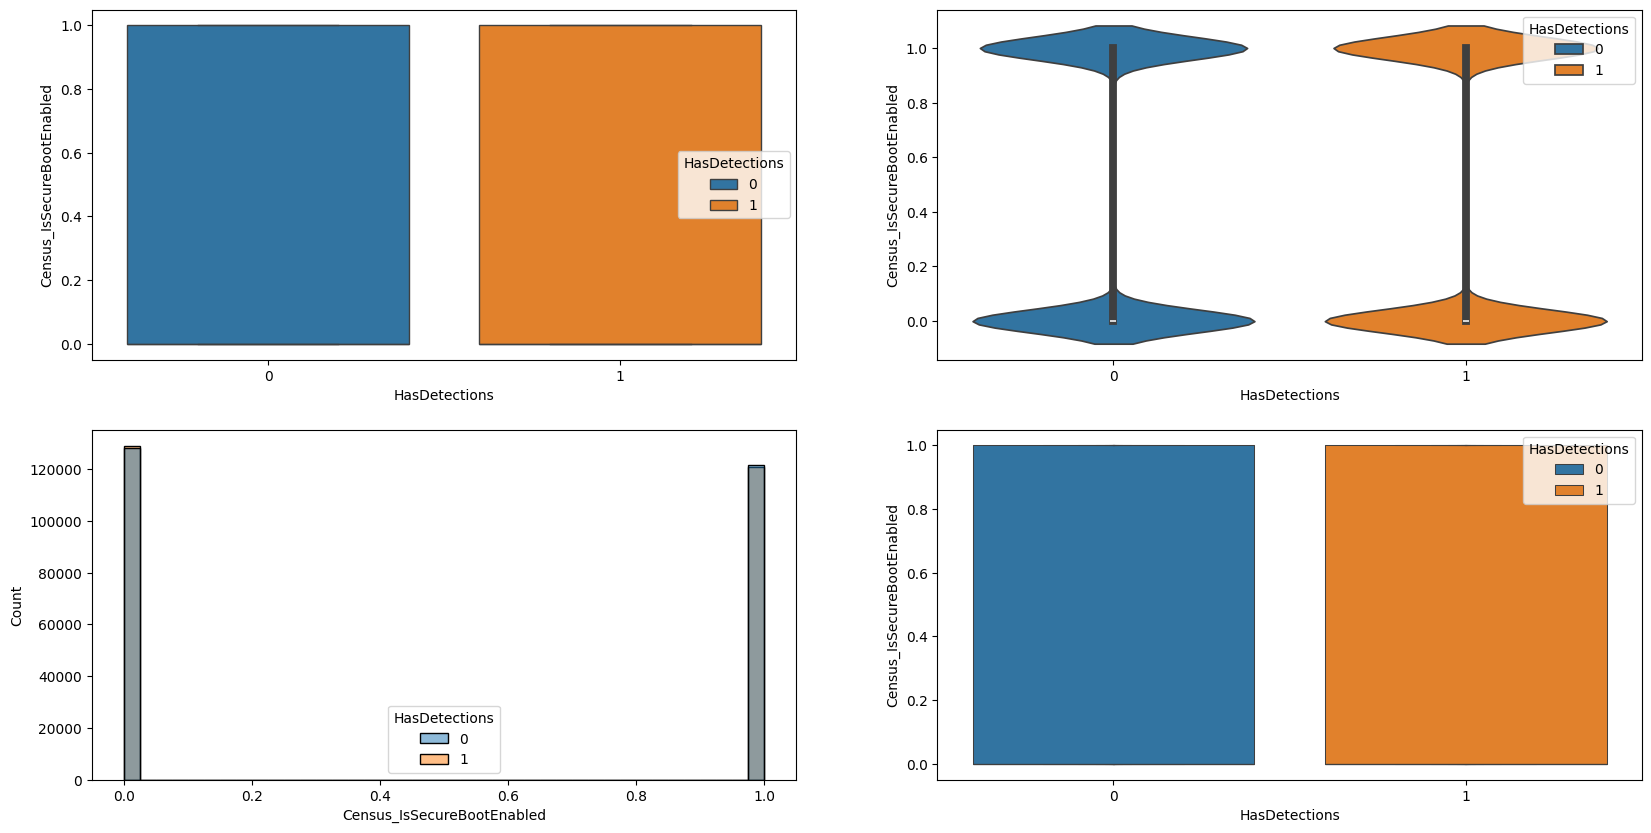

In [94]:
AnalisisAtributo(df_origin,df_origin.columns[73],tar=TARGET)

#### 3.74.- Census_IsWIMBootEnabled

Atributo Numérico
El atributo 'Census_IsWIMBootEnabled' tiene 317666 valores nulos (63.53%)

Descripción estadístiica:
count   182,334.00
mean          0.00
std           0.00
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           0.00
Name: Census_IsWIMBootEnabled, dtype: float64

El atributo tiene 1 valores únicos

TOP 10 porcentaje de valores únicos:
Census_IsWIMBootEnabled
NaN    63.53
0.00   36.47
Name: proportion, dtype: float64


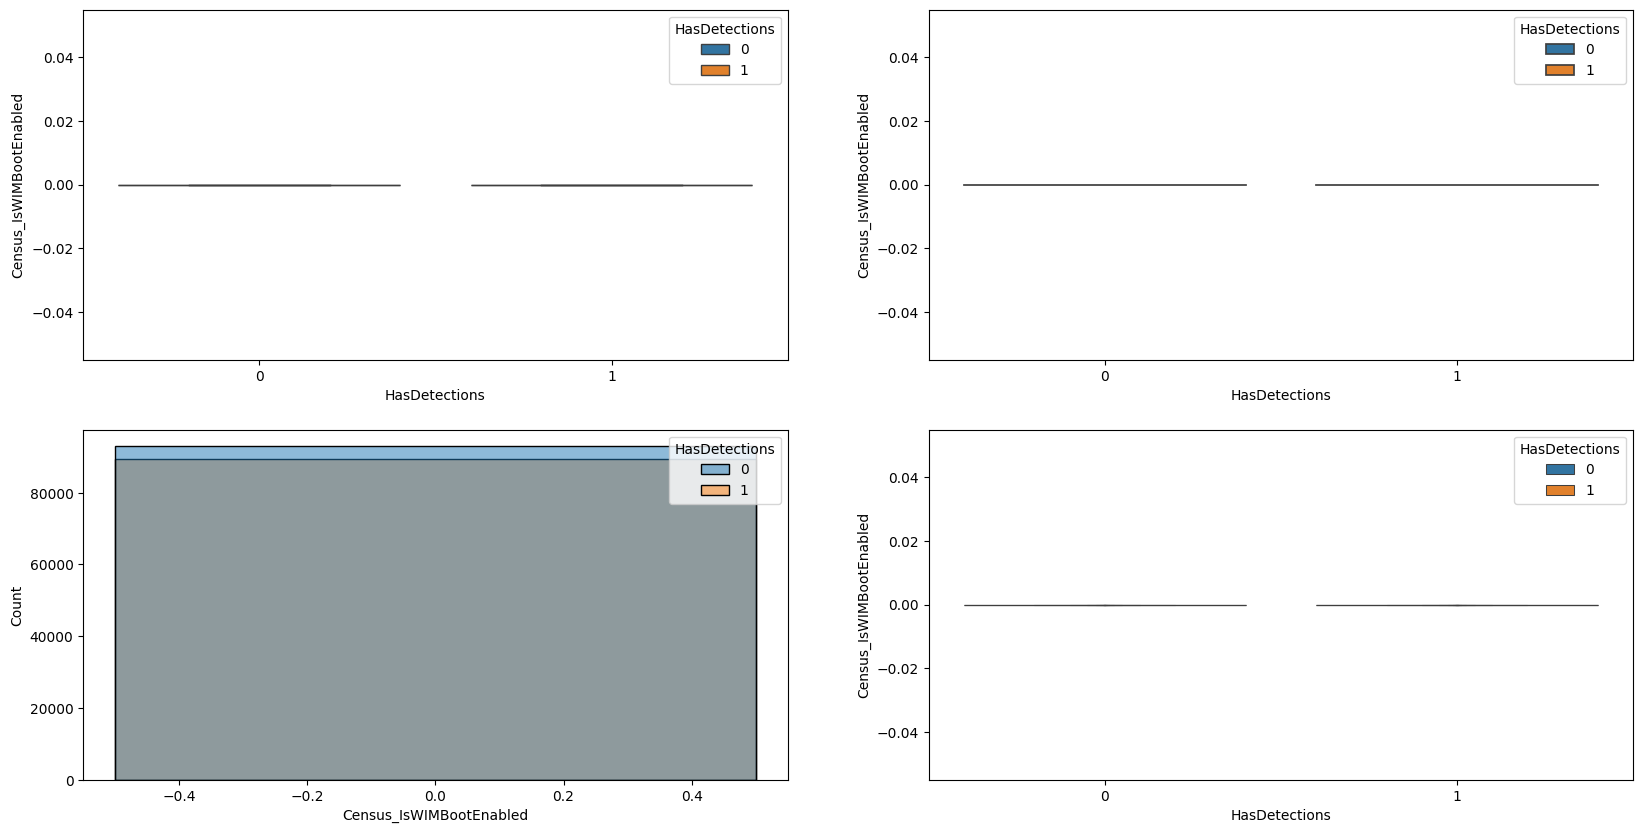

In [95]:
AnalisisAtributo(df_origin,df_origin.columns[74],tar=TARGET)

#### 3.75.- Census_IsVirtualDevice

Atributo Numérico
El atributo 'Census_IsVirtualDevice' tiene 901 valores nulos (0.18%)

Descripción estadístiica:
count   499,099.00
mean          0.01
std           0.08
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           1.00
Name: Census_IsVirtualDevice, dtype: float64

El atributo tiene 2 valores únicos

TOP 10 porcentaje de valores únicos:
Census_IsVirtualDevice
0.00   99.11
1.00    0.71
NaN     0.18
Name: proportion, dtype: float64


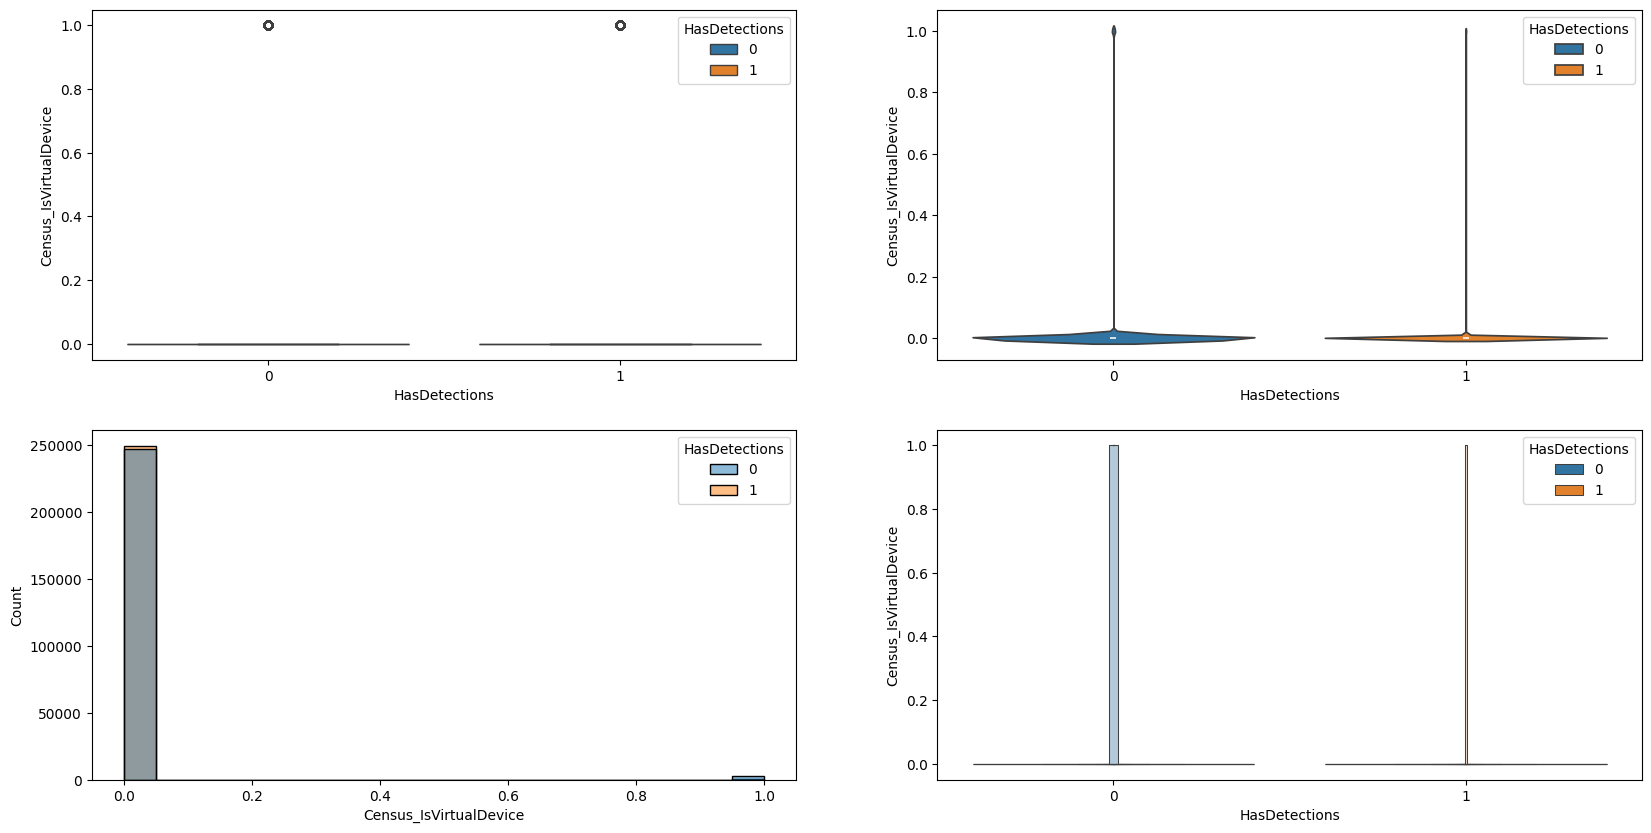

In [96]:
AnalisisAtributo(df_origin,df_origin.columns[75],tar=TARGET)

#### 3.76.- Census_IsTouchEnabled

Atributo Numérico
El atributo 'Census_IsTouchEnabled' tiene 0 valores nulos (0.0%)

Descripción estadístiica:
count   500,000.00
mean          0.13
std           0.33
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           1.00
Name: Census_IsTouchEnabled, dtype: float64

El atributo tiene 2 valores únicos

TOP 10 porcentaje de valores únicos:
Census_IsTouchEnabled
0   87.46
1   12.54
Name: proportion, dtype: float64


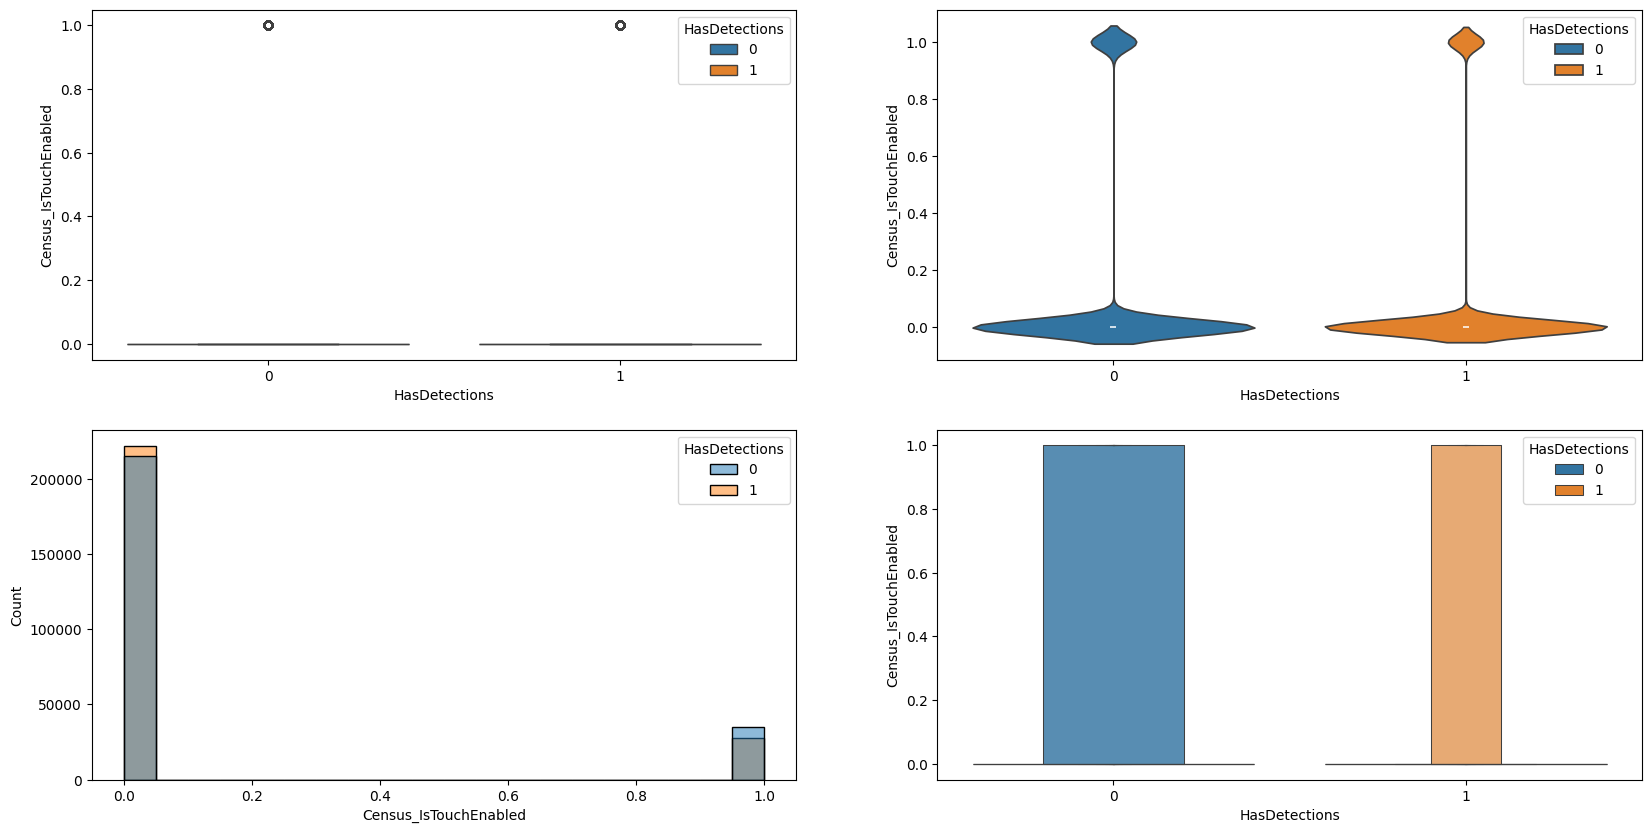

In [97]:
AnalisisAtributo(df_origin,df_origin.columns[76],tar=TARGET)

#### 3.77.- Census_IsPenCapable

Atributo Numérico
El atributo 'Census_IsPenCapable' tiene 0 valores nulos (0.0%)

Descripción estadístiica:
count   500,000.00
mean          0.04
std           0.19
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           1.00
Name: Census_IsPenCapable, dtype: float64

El atributo tiene 2 valores únicos

TOP 10 porcentaje de valores únicos:
Census_IsPenCapable
0   96.23
1    3.77
Name: proportion, dtype: float64


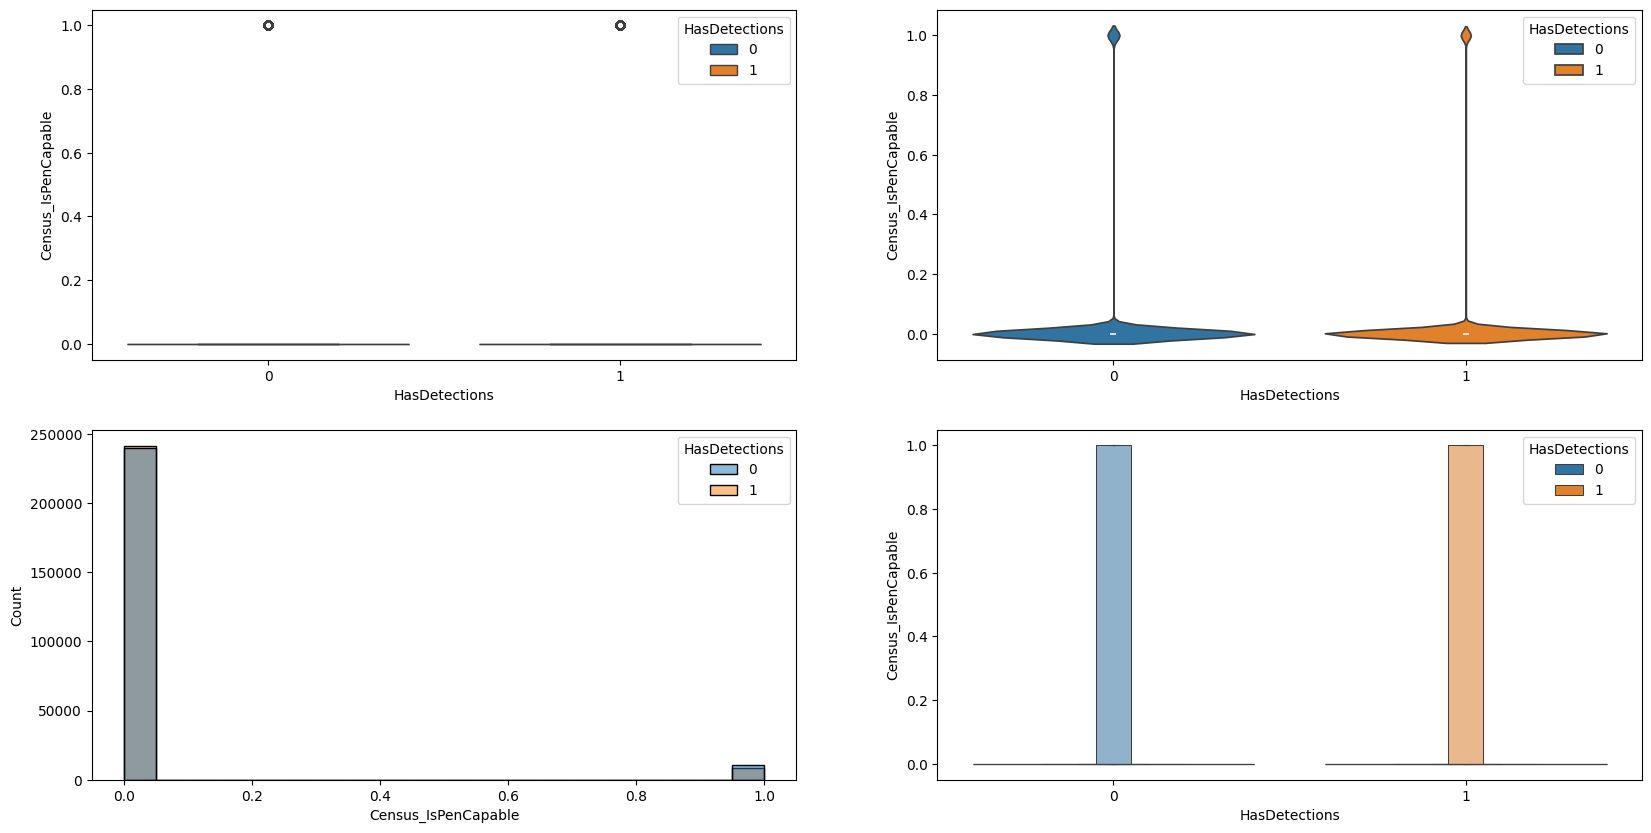

In [98]:
AnalisisAtributo(df_origin,df_origin.columns[77],tar=TARGET)

#### 3.78.- Census_IsAlwaysOnAlwaysConnectedCapable

Atributo Numérico
El atributo 'Census_IsAlwaysOnAlwaysConnectedCapable' tiene 4040 valores nulos (0.81%)

Descripción estadístiica:
count   495,960.00
mean          0.06
std           0.23
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           1.00
Name: Census_IsAlwaysOnAlwaysConnectedCapable, dtype: float64

El atributo tiene 2 valores únicos

TOP 10 porcentaje de valores únicos:
Census_IsAlwaysOnAlwaysConnectedCapable
0.00   93.51
1.00    5.68
NaN     0.81
Name: proportion, dtype: float64


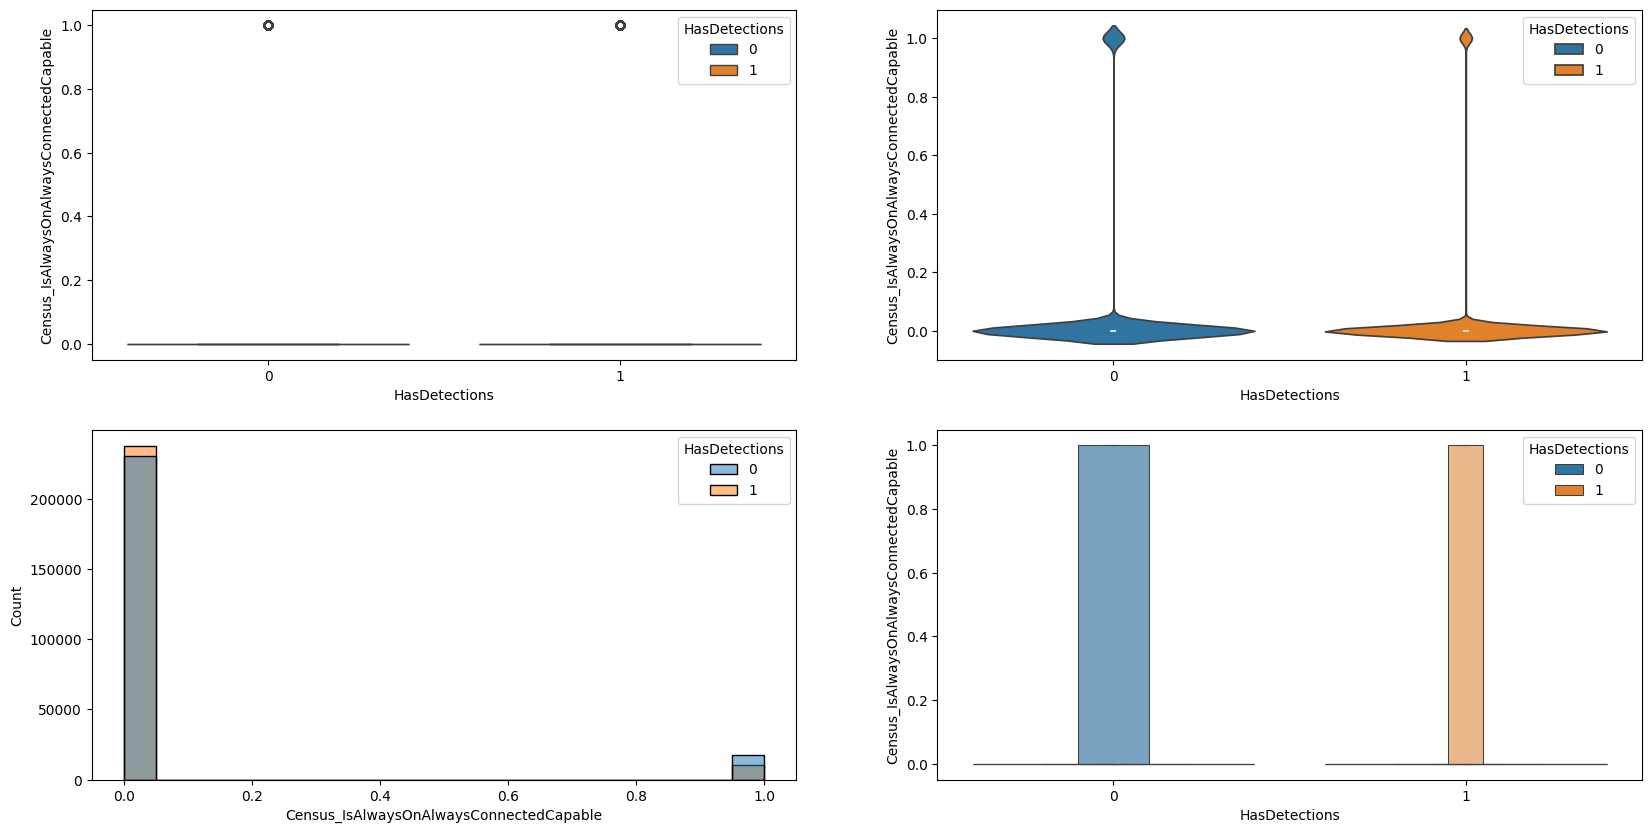

In [99]:
AnalisisAtributo(df_origin,df_origin.columns[78],tar=TARGET)

#### 3.79.- Wdft_IsGamer

Atributo Numérico
El atributo 'Wdft_IsGamer' tiene 16950 valores nulos (3.39%)

Descripción estadístiica:
count   483,050.00
mean          0.28
std           0.45
min           0.00
25%           0.00
50%           0.00
75%           1.00
max           1.00
Name: Wdft_IsGamer, dtype: float64

El atributo tiene 2 valores únicos

TOP 10 porcentaje de valores únicos:
Wdft_IsGamer
0.00   69.17
1.00   27.44
NaN     3.39
Name: proportion, dtype: float64


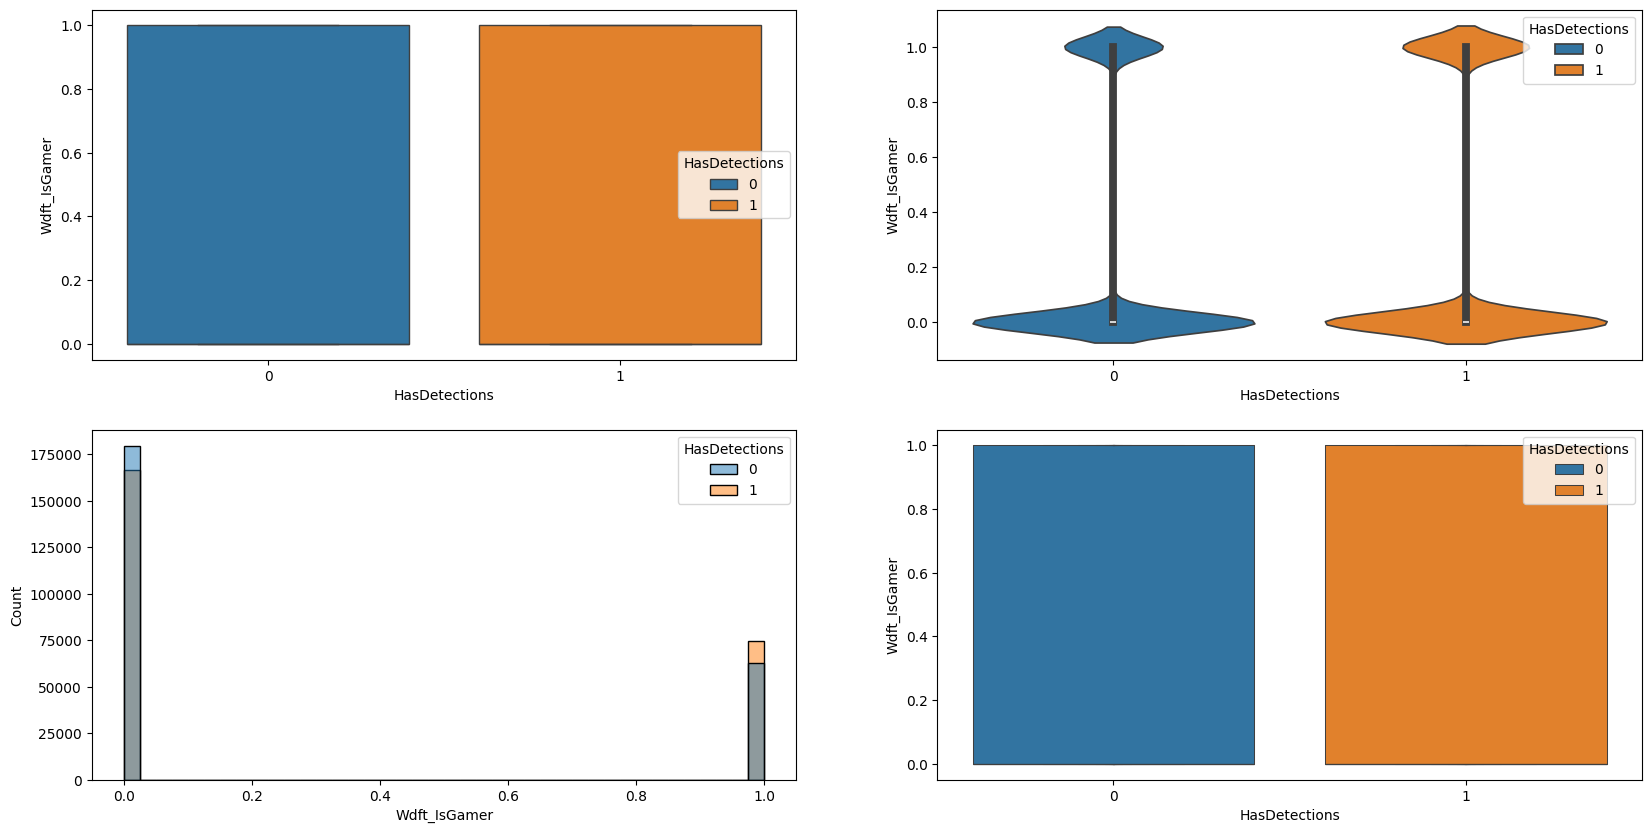

In [100]:
AnalisisAtributo(df_origin,df_origin.columns[79],tar=TARGET)

In [133]:
# Imputamos le valor mínimo (0) ya que por lo general, los equipos gamer suelen llevar software dedicado para identificación de Hardware.
# Si asumimos que el nulo es que no ha podido identificar el Hardware, podemos asumir también que el equipo, porbablemente no sea Gamer

### Utilizaremos el imputer

#### 3.80.- Wdft_RegionIdentifier

Atributo Numérico
El atributo 'Wdft_RegionIdentifier' tiene 16950 valores nulos (3.39%)

Descripción estadístiica:
count   483,050.00
mean          7.89
std           4.55
min           1.00
25%           3.00
50%          10.00
75%          11.00
max          15.00
Name: Wdft_RegionIdentifier, dtype: float64

El atributo tiene 15 valores únicos

TOP 10 porcentaje de valores únicos:
Wdft_RegionIdentifier
10.00   20.08
11.00   15.12
3.00    14.61
1.00    13.74
15.00   11.47
7.00     6.67
NaN      3.39
8.00     3.15
13.00    2.54
5.00     2.29
Name: proportion, dtype: float64


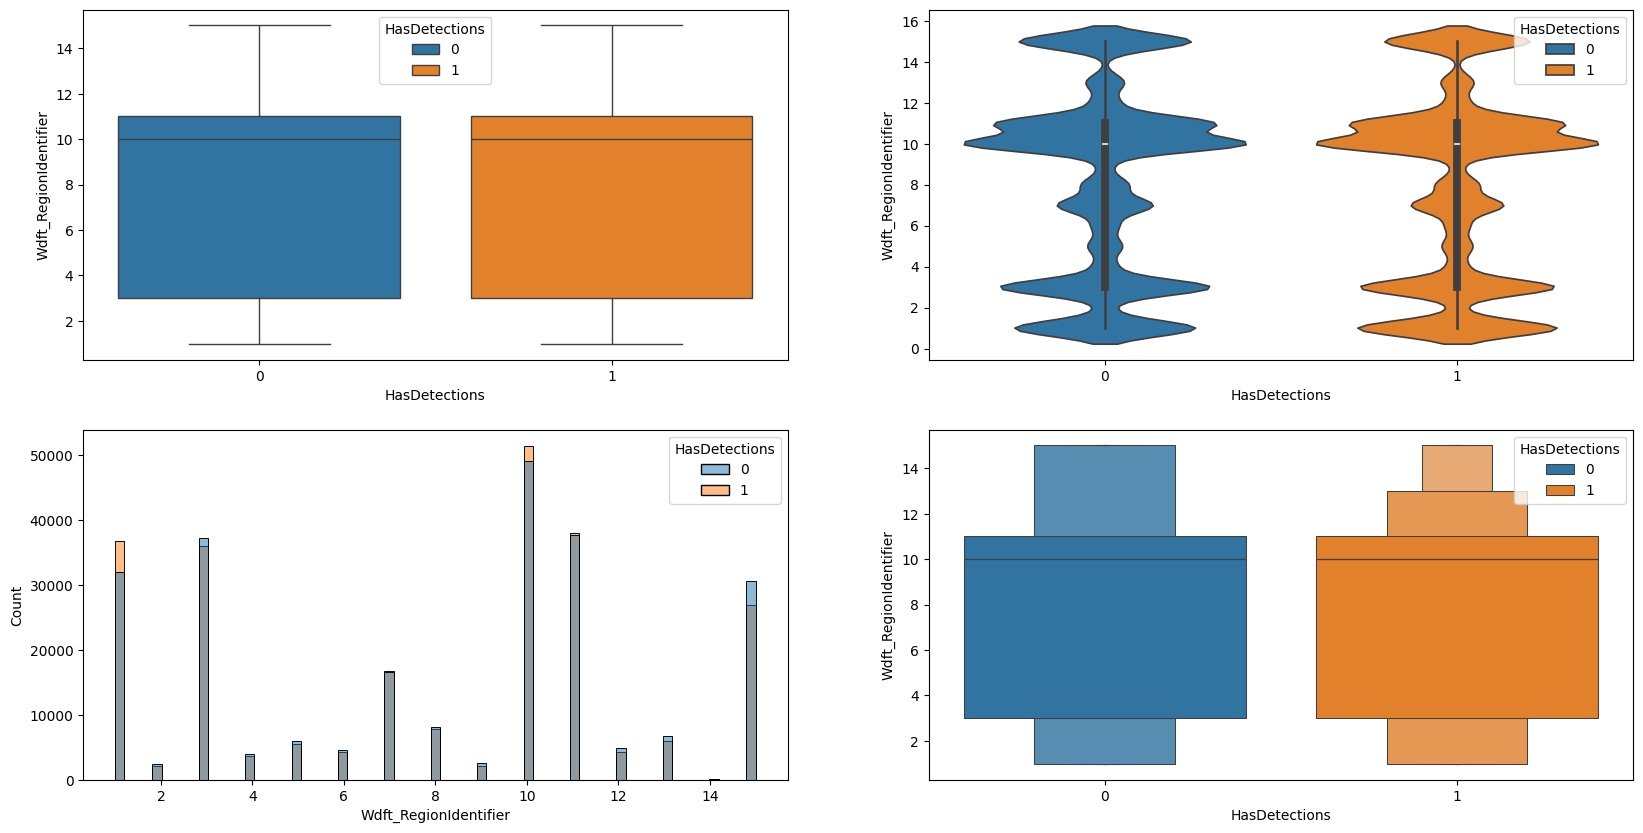

In [104]:
AnalisisAtributo(df_origin,df_origin.columns[80],tar=TARGET)

In [134]:
# Imputamos la moda de forma directa
df_origin.Wdft_RegionIdentifier.fillna(df_origin.Wdft_RegionIdentifier.mode()[0],inplace=True)

In [135]:
top6=(1,3,10,11,15)
df_origin.Wdft_RegionIdentifier=df_origin.Wdft_RegionIdentifier.apply(lambda x: 0 if (x not in top6) else x)
del(top6)

# 4.- Conclusiones Univariable

## 4.1.- Numéricas
- <a href= "#34--isbeta"> **{4} IsBeta**</a> -- _(Defender state information e.g. false)_</br> 
 Variable con 2 valores (0,1) pero solo hay un valor de = 1. La borramos..</br> 
 _[Eliminar atributo]_</br></br>
- <a href= "#36--issxspassivemode"> **{6} IsSxsPassiveMode**</a> -- _(No Description Available)_</br> 
 Variable con 2 valores. El 98,28% en un unico valor. Sin nulos.  Variabilidad en el TARGET.</br> 
 _[Sin cambios]_</br></br>
- <a href= "#39--avproductsinstalled"> **{9} AVProductsInstalled**</a> -- _(No Description Available)_</br> 
 Variable con valores enteros del 1 al 5 (concentrados en los valores 1 y 2) y con 1.938 nulos (0,39%). </br> 
 _[Imputar Moda]_</br></br>
 - <a href= "#310--avproductsenabled">**{10} AVProductsEnabled**</a> -- _(No Description Available)_</br> 
 Variable con valores enteros del 1 al 4 (concentrados en los valores 1 y 2) y con 1.938 nulos (0,39%). Imputo con la moda. Variabilidad en el TARGET..</br> 
 _[Imputar Moda]_</br></br>
  - <a href= "#311--hastpm">**{11} HasTpm**</a> -- _(True if machine has tpm)_</br> 
 Variable boolenana sin nulos con el 99% en el 1 y una distribucion del TARGET del 50%.</br> 
 _[Eliminar atributo]_</br></br>
 - <a href= "#321--ossuite">**{21} OsSuite**</a> -- _(No Description Available)_</br> 
Es numérica pero no tiene sentido ordinal. No tiene nulos. Tiene sólo 9 valores diferentes; el 96% de la muestra se encuentran distribuida en 5 valores. Agrupamos todas las demás muestras en el valor 0</br> 
_[Agrupamos muestras pequeñas con etiqueta 0]_</br></br>
- <a href= "#325--isprotected">**{25} IsProtected**</a> -- _(This is a calculated field derived from the Spynet Report's AV Products field. Returns: a. TRUE if there is at least one active and up)_</br> 
Atributo Boleano. Tiene 1926 nulos (0.39%). El 95% de la muestra recae en 1. Teniendo en cuenta que no podemos imputar nulos de forma objetiva y el sesgo de la muestra, decidimos eliminarla.</br> 
_[Eliminar atributo]_</br></br>
- <a href= "#326--autosampleoptin">**{26} AutoSampleOptIn**</a> -- _(This is the SubmitSamplesConsent value passed in from the service, Available on CAMP 9+)_</br> 
Atributo Boleano. Sólo tiene 14 entradas con valor 0. Se elimina.</br> 
_[Eliminar atributo]_</br></br>
- <a href= "#328--smode">**{28} SMode**</a> -- _(This field is set to true when the device is known to be in 'S Mode', as in, Windows 10 S mode, where only Microsoft Store apps can be installed)_</br> 
Atributo Boleano. Tiene un 6% de nulos. 99,6%  de la muestra en 0. Se elimina.</br> 
_[Eliminar atributo]_</br></br>
- <a href= "#329--ieveridentifier">**{29} IeVerIdentifier**</a> -- _(No Description Available)_</br> 
Hace referencia a versiones de IE. 0.64% de nulos. 99,6%  de la muestra en 0. 60% de la representación en 4 variables. Hacemos un TOP6 unificando las veriones minoritarias y los nulos en la verion 0. </br> 
_[Agrupamos muestras pequeñas con etiqueta 0]_</br></br>
- <a href= "#331--firewall">**{31} Firewall**</a> -- _(This attribute is true (1) for Windows 8.1 and above if windows firewall is enabled, as reported by the service.)_</br> 
El 97% de la muestra está en unmismo atributo. Tiene un 1% de nulos. Lo eliminamos. </br> 
_[Eliminar atributo]_</br></br>
- <a href= "#332--uacluaenable">**{32} UacLuaenable**</a> -- _(This attribute reports whether or not the "administrator in Admin Approval Mode" user type is disabled or enabled in UAC.)_</br> 
El 99.26% de la muestra está en unmismo atributo. Tiene un 0.12% de nulos. Lo eliminamos. </br> 
_[Eliminar atributo]_</br></br>
- <a href= "#335--census_oemnameidentifier">**{35} Census_OEMNameIdentifier**</a> -- _(No Description Available)_</br> 
Es numérica pero no tiene sentido ordinal. Tiene 1589 valores únicos, un 1% de nulos. Agrupamos en versión 0 todos los atributos con menos de 10000 entradas creando un Top11. </br> 
_[Agrupar Nulos y minoritarias en 0]_</br></br>
- <a href= "#336--census_oemmodelidentifier">**{36} Census_OEMModelIdentifier**</a> -- _(No Description Available)_</br> 
Es numérica pero no tiene sentido ordinal. Tiene 40697 valores únicos, un 1.15% de nulos. Muestra muy repartida. La variable con más peso representa un 3.24% de la muestra (17000 entradas). Imputamos los nulos con la moda al no ser ordinal. Si introduce ruido al modelo se elimina. </br> 
_[Imputar nulos cocon Moda y si introduce ruido al modelo, eliminar]_</br></br>
- <a href= "#337--census_processorcorecount">**{37} Census_ProcessorCoreCount**</a> -- _(Number of logical cores in the processor)_</br> 
Es numérica con sentido ordinal. Tiene 27 valores únicos y un 0.47% de nulos. El 90% de la muestra se reparte en 3 atributos. Agruparemos las minoritarias y los nulos en la categoría 0. </br> 
_[Agrupamos minoritarios y nulos en 0]_</br></br>
- <a href= "#338--census_processormanufactureridentifier">**{38} Census_ProcessorManufacturerIdentifier**</a> -- _(No Description Available)_</br> 
Es numérica pero no tiene sentido ordinal. Muestra poco distribuida con target 50/50. No aporta información. Se elimina. </br> 
_[Eliminar atributo]_</br></br>
- <a href= "#339--census_processormodelidentifier">**{39} Census_ProcessorModelIdentifier**</a> -- _(No Description Available)_</br> 
Es numérica pero no tiene sentido ordinal. Imputamos nulos ocn Moda la no ser ordinal. </br> 
_[Imputar nulos con Moda]_</br></br>
- <a href="#341--census_primarydisktotalcapacity">**{41} Census_PrimaryDiskTotalCapacity**</a> -- *(Amount of disk space on primary disk of the machine in MB)*</br> 
Variable complicada. Tiene un 0.01% de nulos (se podría imputar la mediana). Su varianza es alta, su rango es amplio y la distribución no es nada normalizada (ni aplicando logaritmos). La correlación con el TARGET refleja que es poco significativa.</br>
_[Candidata a ser eliminada]_</br></br> 
- <a href="#343--census_systemvolumetotalcapacity">**{43} Census_SystemVolumeTotalCapacity**</a> -- *(The size of the partition that the System volume is installed on in MB )*</br> 
Igual que la anterior, además la correlación de Pearson entre el atributo anterior y este es muy alta (0.78)</br> 
_[Unificar o eliminar ?]_ </br></br>
- <a href="#344--census_hasopticaldiskdrive">**{44} Census_HasOpticalDiskDrive**</a> -- *(True indicates that the machine has an optical disk drive (CD/DVD) )*</br> 
Variable booleana sin nulos. La mayoría de registros no tienen unidad óptica (92.3%). Si tienen unidad óptica, aumenta ligeramente la probabilidad de amenaza (49.7% -> 53.5%) </br> 
_[Atributo significativo]_</br></br> 
- <a href="#345--census_totalphysicalram">**{45} Census_TotalPhysicalRAM**</a> -- *(Retrieves the physical RAM in MB)*</br> 
Variable con un 0.01% de nulos y con outliers. Se podría tratar como categórica, imputar los nulos con la moda y reducir las categorías (top 9 + otros). Su distribución como numérica no es normal ni con la transformación logarítmica y parece poco significativa respecto al TARGET.</br> 
_[Transformacion, Agrupación, Imputación de nulos, Tratar outliers]_</br></br>
- <a href="#347--census_internalprimarydiagonaldisplaysizeininches">**{47} Census_InternalPrimaryDiagonalDisplaySizeInInches**</a> -- *(Retrieves the physical diagonal length in inches of the primary display)*</br> 
Variable con un 0.01% de nulos y con outliers. La distribución se normaliza con una transformación logarítmica (se observan outliers). La relación con el TARGET muestra que NO ES SIGNIFICATIVA</br> 
_[Eliminar / Imputar nulos(moda o mediana) y transformación logaritmica]_</br></br>
- <a href="#348--census_internalprimarydisplayresolutionhorizontal">**{48} Census_InternalPrimaryDisplayResolutionHorizontal**</a> -- *(Retrieves the number of pixels in the horizontal direction of the internal display)*</br> 
Variable con un 0.01% de nulos, además tiene registros con valor -1 que claramente son nulos. 474 valores diferentes (categórica?) Distribución sesgada a la derecha. En la relación con el TARGET parece que NO ES SIGNIFICATIVA.</br>
_[Corregir valores erróneos, Imputar nulos, Combinar con Vertical]_</br></br> 
- <a href="#349--census_internalprimarydisplayresolutionvertical">**{49} Census_InternalPrimaryDisplayResolutionVertical**</a> -- *(Retrieves the number of pixels in the vertical direction of the internal display )*</br> 
Similar a la resolución Horizontal. Mismos nulos (coinciden) y valores erróneos (coinciden). Se podrían combinar las columnas y agrupar en categorías</br> 
_[Corregir valores erróneos, Imputar nulos,  Combinar con Vertical]_</br></br> 
- <a href="#352--census_internalbatterynumberofcharges">**{52} Census_InternalBatteryNumberOfCharges**</a> -- *(No Description Available)*</br> 
Variable con 0.03% de nulos (pueden ser 0). Distribución desplazada a la izquierda (muchos equipos sin batería o con pocas cargas) pero también hay valores muy elevados para el número de cargas. Esta variable necesita un escalado. Combinar con el tipo de batería para más información. NO ES SIGNIFICATIVA respecto al TARGET</br> 
_[Combinar con tipo de batería, imputar nulos, escalar]_</br></br>
- <a href="#356--census_osbuildnumber">**{56} Census_OSBuildNumber**</a> -- *(OS Build number extracted from the OsVersionFull. Example - OsBuildNumber = 10512 or 10240 )*</br> 
Variable sin nulos. Puede ser redundante con Census_OSVersion. 61 valores distintos. Hacer top 6 y agrupar valores atípicos. Trasformar en categoría. NO ES SIGNIFICATIVA respecto al TARGET</br> 
_[Comparar con Census_OSVersion, Eliminar / Transformar en 7 categorías]_</br></br>  
- <a href="#357--census_osbuildrevision"> **{57} Census_OSBuildRevision** </a> -- *(OS Build revision extracted from the OsVersionFull. Example - OsBuildRevision = 1000 or 16458)*</br> 
Igual que la anterior pero hacer top 25 categorías</br> 
_[Comparar con Census_OSVersion, Eliminar / Transformar en 25 categorías]_</br></br>  
- <a href="#361--census_osinstalllanguageidentifier">**{61} Census_OSInstallLanguageIdentifier**</a> -- _(OS lenguage numerical identifier)_</br> 
 Identificador del idioma del SO codificado dle 1 al 39. Tiene un 0.67% de nulos y una fuerte correlación (0.98) con el siguiente atributo (Census_OSUILocaleIdentifier), el cual no presenta nulos.</br> 
 _[Eliminar atributo]_</br></br>
- <a href="#362--census_osuilocaleidentifier">**{62} Census_OSUILocaleIdentifier**</a> -- _(Equipment Location numerical identifier)_</br> 
Es numérica pero no tiene sentido ordinal. Cada valor identifica una localización diferente (1-162). Hay muchos equipos entre los valores 20 y 40 que probablemente repesenten localizaciones con mucha densidad de población.</br> 
 _[Se pasa a Int8]_</br></br>
- <a href="#364--census_isportableoperatingsystem">**{64} Census_IsPortableOperatingSystem**</a> -- _(Indicates whether OS is booted up and running via Windows)_</br> 
 Atributo Boleano. El 99% de los valores son 0 con uan distribución del TARGET del 50% y una std de 0,02. Este atributo no aporta nada al algoritmo. </br> 
_[Eliminar atributo]_</br></br>
- <a href="#367--census_isflightinginternal">**{67} Census_IsFlightingInternal**</a> -- _(No Description Available)_</br> 
 Atributo Boleano. El 99% de los valores son 0. Tiene un 83% de nulos que no hay forma objetiva de imputar. Este atributo no aporta nada al algoritmo. </br> 
_[Eliminar atributo]_</br></br>
- <a href="#368--census_isflightsdisabled">**{68} Census_IsFlightsDisabled**</a> -- _(Indicates if the machine is participating in flighting.)_</br> 
 Atributo Boleano. El 99% de los valores son 0. Tiene un 1.79% de nulos que no hay forma objetiva de imputar. Este atributo no aporta nada al algoritmo. </br> 
_[Eliminar atributo]_</br></br>
- <a href="#370--census_thresholdoptin">**{70} Census_ThresholdOptIn** </a>-- _(No Description Available)_</br> 
 Atributo Boleano. El 99% de los valores son 0. Tiene un 63.62% de nulos que no hay forma objetiva de imputar. Este atributo no aporta nada al algoritmo. </br> 
_[Eliminar atributo]_</br></br>
- <a href="#371--census_firmwaremanufactureridentifier">**{71} Census_FirmwareManufacturerIdentifier**</a> -- _(No Description Available)_</br> 
Categoría NO ordinal con 2% de nulos. Tiene 303 valores únicos, muchos de ellos con una unica representación en la muestra.  Por debajo del TOP4, la representación de cada variable es inferior a 10%. Por debajo del 10% de la muestra, se les asigna el valor 0 para quedarnos con un TOP5.</br> 
_[Nulos imputados con 0 y minoritarias agrupadas en 0]_</br></br>
- <a href="#357--census_osbuildrevision">**{72} Census_FirmwareVersionIdentifier**</a> -- _(No Description Available)_</br> 
Categoría NO ordinal con 1.8% de nulos. No hay correlación con el atributo anterior. Al tratarse de versiones, saldrían demasiadas variables para un OHE. Imputaremos los nulos con la moda y agrupamos por número inicial de versión.  
_[Nulos imputados con moda, pasado a Int64 y agrupación por numero inicial de version]_</br></br>
- <a href="#373--census_issecurebootenabled">**{73} Census_IsSecureBootEnabled**</a> -- _(Indicates if Secure Boot mode is enabled.)_</br> 
Atributo Boleano. Distribución 50/50.   
_[Ningún cambio]_</br></br>
- <a href="#374--census_iswimbootenabled">**{74} Census_IsWIMBootEnabled**</a> -- _(No Description Available)_</br> 
Todos los valores son 0 con el Target distribuido 50/50. Tiene un 63.5% de nulos. NO aporta nada. </br> 
_[Eliminar atributo]_</br></br>
- <a href="#375--census_isvirtualdevice">**{75} Census_IsVirtualDevice**</a> -- _(Identifies a Virtual Machine)_</br> 
Atributo Boleano. Sólo tiene un 0.18% de nulos pero la distribución del atributo está repartida en un 99/1% (el 99% de la muestra no es una maquina virtual) pese a que el targuet esté 50/50. NO aporta nada al algoritmo.</br> 
_[Eliminar atributo]_</br></br>
- <a href="#357--census_osbuildrevision">**{76} Census_IsTouchEnabled**</a> -- _(Is this a touch device ?)_</br> 
Atributo Boleano. La muestra está repartida en una proporción dle 87/12%, no tiene nulos y el target tiene proporción 50/50.</br> 
_[Ningún cambio]_</br></br>
- <a href="#377--census_ispencapable">**{77} Census_IsPenCapable**</a> -- _(Is the device capable of pen input ?)_</br> 
Atributo Boleano. La muestra está repartida en una proporción dle 96/4%, no tiene nulos y el target tiene proporción 50/50. Demasiada diferencia en el muestreo.</br> 
_[Eliminar atributo]_</br></br>
- <a href="#378--census_isalwaysonalwaysconnectedcapable">**{78} Census_IsAlwaysOnAlwaysConnectedCapable**</a> -- _(Retreives information about whether the battery enables the device to be AlwaysOnAlwaysConnected.)_</br> 
Atributo Boleano. La muestra está repartida en una proporción dle 95/5%, tiene un 1% de nulos y el target tiene proporción 50/50.</br> 
_[Eliminar atributo]_</br></br>
- <a href="#379--wdft_isgamer">**{79} Wdft_IsGamer**</a> -- _(Indicates whether the device is a gamer device or not based on its hardware combination.)_</br> 
Atributo Boleano. La muestra está repartida en una proporción del 71/28, tiene un 3.4% de nulos y el target tiene proporción 50/50. Imputamos le valor mínimo (0) ya que por lo generla, los equipos gamer suelen llevar software dedicado para identificación de Hardware. Si asumimos que el nulo es que no ha podido identificar el Hardware, podemos asumir también que el equipo, porbablemente no sea Gamer </br> 
_[Imputamos el valor minimo]_</br></br>
- <a href="#380--wdft_regionidentifier">**{80} Wdft_RegionIdentifier**</a> -- _(No Description Available)_</br> 
Es numérica pero no tiene sentido ordinal. Tiene un 3.4% de nulos y el target tiene proporción 50/50.Se imputa la moda. Hay variables con una representación inferior al 1%. Todas las inferiores al 10% se agrupan en un nevo conjunto denaminado 0.</br> 
_[Imputamos moda y agrupar por debajo del 10% para un top 6]_</br></br>


## 4.2.- Categóricas
   - <a href="#30--productname">**{0} ProductName**</a> -- _(Defender state information e.g. win8defender)_</br> 
 Variable sin nulos, con 3 registros únicos y poca variabilidad (99% en un unico valor con el target distribuido en un 50%). Lo borramos por no aportar informacion.</br> 
 _[Eliminar atributo]_</br></br>
   - <a href="#31--engineversion">**{1} EngineVersion**</a> -- _(Defender state information e.g. 1.1.12603.0)_</br> 
 Variable sin nulos, con 53 registros únicos y con poca variabilidad (el 84% en dos valores) con distinta distribución del target en estos dos valores. </br> 
 _[Ordinal Encoder]_</br></br>
   - <a href="#32--appversion">**{2} AppVersion**</a> -- _(Defender state information e.g. 4.9.10586.0)_</br> 
 Variable con 95 valores únicos, sin nulos y con 58% en un único valor. En general el target distribuido entorno al 50% en los 5 primeros valores y en los siguientes ya encontramos algun valor con mayor variabilidad. Se limpia borrando el '4.' con el que empiezan los registros.</br> 
 _[Ordinal Encoder]_</br></br>
   - <a href="#33--avsigversion">**{3} AvSigVersion**</a> -- _(Defender state information e.g. 1.217.1014.0)_</br> 
 Variable con 6.455 valores unicos, sin nulos. Agruparemos los valores con <1000 registros. Variabilidad en el TARGET.</br> 
 _[Agrupar minoritarios, OHE]_</br></br>
   - <a href="#35--rtpstatebitfield">**{5} RtpStateBitfield**</a> -- _(No Description Available)_</br> 
 Variable con 8 valores numéricos per debería tratarse como categórica. El 96,97% en un unico valor y tiene nulos (0.37%).</br> 
 _[Imputar Moda, OHE]_</br></br>
   - <a href="#37--defaultbrowsersidentifier">**{7} DefaultBrowsersIdentifier**</a> -- _(ID for the machine's default browser)_</br> 
 Tvariable con > 95% nulos. La borramos.</br> 
 _[Eliminar Atributo]_</br></br>
   - <a href="#38--avproductstatesidentifier">**{8} AVProductStatesIdentifier**</a> -- _(ID for the specific configuration of a user's antivirus software)_</br> 
 Variable con 5.517 valores distintos y 1.938 nulos. Aunque son valores numéricos debería tratarse como variable categórica. Agruparemos los valores con <1.000 registros. Variabilidad en el TARGET.</br> 
 _[Agrupar minoritarios, OHE]_</br></br>
   - <a href="#312--countryidentifier">**{12} CountryIdentifier**</a> -- _(ID for the country the machine is located in)_</br> 
 Variable con 222 valores distintos sin nulos. Son valores numéricos pero debe tratarse como una variable categórica. Agrupar con < 1.000 registros.</br> 
 _[Agrupar minoritarios, OHE]_</br></br>
   - <a href="#313--cityidentifier">**{13} CityIdentifier**</a> -- _(ID for the city the machine is located in)_</br> 
 Variable con 37.157 valores distintos pero el que más valores tiene es el nulo con mas de 18.000 registros. Son valores numéricos pero debe tratarse como una variable categórica. La eliminamos porque si intentamos agrupar, la mayoría de registros quedarán con 'Others'.</br> 
 _[Eliminar atributo]_</br></br>
   - <a href="#314--organizationidentifier">**{14} OrganizationIdentifier**</a> -- _(ID for the organization the machine belongs in, organization ID is mapped to both specific companies and broad industries)_</br> 
 Variable con 44 valores unicos y 154.563 valores nulos (30%). Son valores numéricos pero debe tratarse como una variable categórica. Nulos imputar con -1 y agrupar con <1.000 registros.</br> 
 _[Imputar constante -1, agrupar minoritarios, OHE]_</br></br>
   - <a href="#315--geonameidentifier">**{15} GeoNameIdentifier**</a> -- _(ID for the geographic region a machine is located in)_</br> 
 Variable con 268 valores unicos, 16 nulos (que imputaremos con la constante -1) y variancia en el TARGET. Son valores numéricos pero debe tratarse como una variable categórica.</br> 
 _[Imputar constante -1, OHE]_</br></br>
   - <a href="#316--localeenglishnameidentifier">**{16} LocaleEnglishNameIdentifier**</a> -- _(English name of Locale ID of the current user)_</br> 
 Variable con 233 valores unicos, sin nulos. Poca varianza del TARGET. La trataremos también como categórica y la agruparemos.</br> 
 _[Agrupar minoritarios, OHE]_</br></br>
   - <a href="#317--platform">**{17} Platform**</a> -- _(Calculates platform name (of OS related properties and processor property))_</br> 
 Variable con 4 valores únicos y sin nulos.</br> 
 _[Sin cambios, OHE]_</br></br>
   - <a href="#318--processor">**{18} Processor**</a> -- _(This is the process architecture of the installed operating system)_</br> 
 Variable con 3 valores unicos (el 90% concentrado en uno de los valores) y sin nulos. Variabilidad en el TARGET.</br> 
 _[Sin cambios, OHE]_</br></br>
   - <a href="#319--osver">**{19} OsVer**</a> -- _(Version of the current operating system)_</br> 
 Variable con 21 valores únicos, sin nulos y el 96.77% asignado a un único valor. Agrupar con < 1.000 registros.</br> 
 _[Agrupar minoritarios, OHE]_</br></br>
   - <a href="#320--osbuild">**{20} OsBuild**</a> -- _(Build of the current operating system)_</br> 
 Variable con 48 valores únicos, sin nulos. Agrupamos si < 1.000 registros. Variabilidad en el TARGET.</br> 
 _[Agrupar minoritarios, OHE]_</br></br>
 - <a href="#322--osplatformsubrelease">**{22} OsPlatformSubRelease**</a> -- _(Returns the OS Platform sub)_</br> 
Hay 9 categorías únicas. La categoría 'prers5' representa un 0.23% de la muestra con una 44/56 % de distribución del target. Como hace referncia a versiones previas a la versión de W10 de Octubre del 2018, la agruparemos con la versión rs1</br> 
_[Agrupamos prers5 con rs1, OHE]_</br></br>
 - <a href="#323--osbuildlab">**{23} OsBuildLab**</a> -- _(Build lab that generated the current OS. Example: 9600.17630.amd64fre.winblue_r7.150109)_</br> 
Hay 453 categorías únicas. Hay 1 nulo. El 70% de la muestra queda representado por 4 categorías diferentes. El resto tienen una representación inferior al 2%. Las que representan menos del 2% se agrupan en 'Other'</br> 
_[Agrupamos en 'Other' por debajo del 2% de representación, OHE]_</br></br>
 - <a href="#324--skuedition">**{24} SkuEdition**</a> -- _(The goal of this feature is to use the Product Type defined in the MSDN to map to a 'SKU)_</br> 
Hay 8 categorías únicas. El 98% de la muestra restá representado por las versiones 'Pro' y 'Home'. Las otras 6 categorías representan menos de un 1% por separado. Se agrupan en 'Other'</br> 
_[Agrupamos en 'Other' las categorias minoritarias, OHE]_</br></br>
 - <a href="#327--puamode">**{27} PuaMode**</a> -- _(Pua Enabled mode from the service)_</br> 
Tiene un 99.97% de nulos. Se elimina</br> 
_[Eliminar atributo]_</br></br>
 - <a href="#330--smartscreen">**{30} SmartScreen**</a> -- _(This is the SmartScreen enabled string value from registry. If the value exists but is blank, the value "ExistsNotSet" is sent in telemetry.)_</br> 
Atributo con 35.7% de nulos y distribución muy sesgada. Se elimina.</br> 
_[Eliminar atributo]_</br></br>
 - <a href="#333--census_mdc2formfactor">**{33} Census_MDC2FormFactor**</a> -- _(A grouping based on a combination of Device Census level hardware characteristics. The logic used to define Form Factor is rooted in business and industry standards and aligns with how people think about their device.)_</br> 
Sin nulos. 85% de la muestra repartido en 2 atributos. El resto de atributos se agrupan en 'Other'.</br> 
_[Agrupar minoritarios en 'Other', OHE]_</br></br>
 - <a href="#334--census_devicefamily">**{34} Census_DeviceFamily**</a> -- _(AKA DeviceClass. Indicates the type of device that an edition of the OS is intended for.)_</br> 
Sin nulos. 99.84% de la muestra en 1 atributo cona distribución del target del 50%. Se elimina.</br> 
_[Eliminar atributo]_</br></br>
 - <a href="#340--census_processorclass">**{40} Census_ProcessorClass**</a> -- _(A classification of processors into high/medium/low. Initially used for Pricing Level SKU. No longer maintained and updated)_</br> 
Tiene un 99% de nulos y la descripción indica que no se mantiene actualizada. Se elimina.</br> 
_[Eliminar atributo]_</br></br>
- <a href="#342--census_primarydisktypename">**{42} Census_PrimaryDiskTypeName**</a> -- *(Friendly name of Primary Disk Type - HDD or SSD )*</br>
Hay un 0.14 % de nulos. Existen las categorías HDD, SSD, Unknown y Unspecified (estas últimas se podría agrupar con los nulos). Variable relativamente SIGNIFICATIVA</br>
_[Imputar nulos, Agrupar desconocidas, OHE]_</br></br>
- <a href="#346--census_chassistypename">**{46} Census_ChassisTypeName**</a> -- *(Retrieves a numeric representation of what type of chassis the machine has. A value of 0 means xx )*</br>
Hay 0.01% de nulos, 0.74% Unknown. Además 33 categorías, algunas con pocos registros. Hay variabilidad con el TARGET para cada categoría. Variable SIGNIFICATIVA</br>
_[Imputar nulos, agrupar categorias por variabilidad con el target (5 más altas y 5 más bajas por ejemplo), OHE]</br></br>
- <a href="#350--census_powerplatformrolename">**{50} Census_PowerPlatformRoleName**</a> -- *(Indicates the OEM preferred power management profile. This value helps identify the basic form factor of the device )*</br>
Hay solamente 2 registros nulos. Además hay 9 categorías, pero solamente 4 representativas. Variabilidad con el TARGET para cada categoría. Variable SIGNIFICATIVA</br>
_[Imputar nulos, agrupar atípicas, OHE]_</br></br>
- <a href="#351--census_internalbatterytype">**{51} Census_InternalBatteryType**</a> -- *(No Description Available)*</br>
Hay muchos nulos 71%. Más de 20 valores distintos pero la mayoría poco representativos o con poca variabilidad con el TARGET. Conviene combinarla con la columna 52 para sacar información, pero parece una variable POCO SIGNIFICATIVA</br>
[Imputar nulos, Comparar con Número de cargas / Eliminar ]_</br></br>
- <a href="#353--census_osversion">**{53} Census_OSVersion**</a> -- *(Numeric OS version Example - 10.0.10130.0 )*</br>
Columna redundante. Se puede eliminar. Solo hay una version 6.3.x.x, el resto de registros son 10.0.x.x. Las columnas BuildNumber y Revision combinadas si son SIGNIFICATIVAS</br>
_[ Eliminar ]_</br></br>
- <a href="#354--census_osarchitecture">**{54} Census_OSArchitecture**</a> -- *(Architecture on which the OS is based. Derived from OSVersionFull. Example - amd64 )*</br>
Sin nulos. Hay tres valores posibles, arm64 muy poco representado (menos del 0%). Variable MUY SIGNIFICATIVA</br>
_[ Eliminar arm64?, OHE ]_</br></br>
- <a href="#355--census_osbranch">**{55} Census_OSBranch**</a> -- *(Branch of the OS extracted from the OsVersionFull. Example - OsBranch = fbl_partner_eeap where OsVersion = 6.4.9813.0.amd64fre.fbl_partner_eeap.140810-0005 )*</br>
Sin nulos. Hay 15 valores, algunos con muy poca representación. Variable SIGNIFICATIVA</br>
_[ Agrupar atípicos, OHE ]_</br></br>
- <a href="#358--census_osedition">**{58} Census_OSEdition**</a> -- *(Edition of the current OS. Sourced from HKLM\Software\Microsoft\Windows NT\CurrentVersion@EditionID in registry. Example: Enterprise)*</br>
Sin nulos. Hay 22 valores, algunos con muy poca representación. Variable SIGNIFICATIVA</br>
_[ Agrupar atípicos, OHE ]_</br></br>
- <a href="#359--census_osskuname">**{59} Census_OSSkuName**</a> -- *(OS edition friendly name (currently Windows only) )*</br>
Columna redundante con la anterior. OSEdition refleja la edición del SO en el registro oficial de Windows, es más fiable. Por lo que se puede eliminar esta columna</br>
_[ Eliminar ]_</br></br>
- <a href="#360--census_osinstalltypename">**{60} Census_OSInstallTypeName** </a> -- *(Friendly description of what install was used on the machine i.e. clean)*</br>
No hay nulos. Hay 9 valores, pero se pueden agrupar (Clean con IBSClean, upgrade, con UUPUgrade y CleanRefresPc con Refresh). Variable significativa</br>
_[ Agrupar valores, OHE]_</br></br>
- <a href="#363--census_oswuautoupdateoptionsname">**{63} Census_OSWUAutoUpdateOptionsName**</a> -- _(Friendly name of the WindowsUpdate auto)_</br> 
 Las categorías 'Off','DownloadNotify' y 'AutoInstallAndRebootAtMaintenanceTime' Son muy pequeñas en comparación a las otras 3. Como ya existe la categoría UNKWNON, las agrupamos. </br> 
 _[Agrupar categorias minoritarias en 'UNKNOWN' ya existente, OHE]_</br></br>
- <a href="#365--census_genuinestatename">**{65} Census_GenuineStateName** </a>-- _(Friendly name of OSGenuineStateID. 0 = Genuine)_</br> 
 La variable 'IS_GENUINE' agrupa 88,3% de los casos con uan distribución dle TARGET del 49,9%. La variable 'INVALID_LICENSE' representa un 9% de la muestra, mientras que las otras 2 juntas representan menos de un 3%.</br>
 _[Agrupamos variables minoritarias en 'INVALID_LICENSE', OHE]_</br></br>
- <a href="#366--census_activationchannel">**{66} Census_ActivationChannel**</a> -- _(Retail license key or Volume license key for a machine.)_</br> 
 Hay 6 variables diferentes. 2 hacen referencia a 'Retail', 2 a 'OEM' y 2 a 'Volume. Por separado algunos subgrupos representan menos del 0.1%</br> 
 _[Se agrupan los subgupos de cada categoria, OHE]_</br></br>
- <a href="#369--census_flightring">**{69} Census_FlightRing**</a> -- _( The ring that the device user would like to receive flights for. This might be different from the ring of the OS which is currently installed if the user changes the ring after getting a flight from a different ring.)_</br> 
 La variable 'Retail' tiene el 93,6% de los registros con una distribución del TARGET del 50%. Las otras 7 variables acumulan un 0.6% de la muestra con la misma distribución de TARGET. La variable 'Retail tiene demasiada presencia y no va a aportar nada al algoritmo.</br> 
 _[Eliminar atributo]_</br></br>